This notebook quantifies/estimates the projection property of MSN using the distribution of extra-somatic transcripts.

In [1]:
import numpy as np
import pandas as pd
import glob
import scipy 
from tqdm import tqdm 


- Load raw transcript files 

In [ ]:
fls = glob.glob(r'./Raw_custom_MERFISH_Imaging_data/20250511_XXhBG_1311/HumanBG_MERFISH_Filtered_Spots/Conv_zscan__*--spots.npz')
all_gns = np.loadtxt(r'./../../analysis_notebooks/Final_codebook_BG_673gn_new.csv',dtype=str,delimiter=',')[1:,0] # get the full gn list form the codebook


xfov = []
header = list(np.load(fls[0])['header'])
icell_id = header.index('cell_id')
Mcts = []
for fl in tqdm(fls[::]):
    XF = np.load(fl)['XF']
    icell = XF[:,icell_id]
    genes_ = np.load(fl)['genes'][icell == 0]
    gns,cts = np.unique(np.concatenate([genes_,all_gns]), return_counts=True)
    xfov.append(XF[0][-2:]) # xfov, yfov i.e. global position of the fov center
    Mcts.append(cts)


100%|██████████| 8501/8501 [08:22<00:00, 16.93it/s]


In [3]:
header

['z',
 'x',
 'y',
 'abs_brightness',
 'cor',
 'brightness',
 'color',
 'mean_bightness_variation',
 'mean_distance_variation',
 'index_from_XH_pruned',
 'score',
 'cell_id',
 'ifov',
 'iset',
 'xfov',
 'yfov']

In [4]:
np.array(Mcts).shape

(8501, 769)

- Load the adata 

In [ ]:
import scanpy as sc
adata = sc.read_h5ad(r'./MERFISH_adata_QC/mapmycell_annotated_adata/MER2_Gpe_Gpi_CaPu_1311__MERFISH_annotated.h5ad')


In [6]:
adata

AnnData object with n_obs × n_vars = 1124161 × 673
    obs: 'volm', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'leiden', 'Neighborhood_label', 'Neighborhood_name', 'Neighborhood_bootstrapping_probability', 'Class_label', 'Class_name', 'Class_bootstrapping_probability', 'Subclass_label', 'Subclass_name', 'Subclass_bootstrapping_probability', 'Group_label', 'Group_name', 'Group_bootstrapping_probability', 'Cluster_label', 'Cluster_name', 'Cluster_alias', 'Cluster_bootstrapping_probability'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'Ensemble_ID'
    uns: 'Class_name_colors', 'Group_name_colors', 'Subclass_name_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'rank_genes_groups', 'umap'
    obsm: 'X_raw', 'X_spatial', 'X_spatial_rot

- Normalize the count

In [7]:
# replace count by raw count 
adata.X = adata.layers['X_raw'].copy()

In [ ]:
# Normalize by volume
med_volm = np.median(adata.obs['volm'])
temp = adata.X.astype('float').copy()
temp /= adata.obs['volm'].values[:,np.newaxis]
temp *= med_volm
adata.X  = temp

# Normlize count 
target_sum  = np.median(np.array(adata.X.sum(axis=-1)))
sc.pp.normalize_total(adata, target_sum=target_sum)
sc.pp.log1p(adata)



### 1. Spatial plot for correlaton of ambient RNA/transcript count with the differential enrichement level of  genes between STR D2 Matrix MSN and  STR D1 Matrix MSN

A. Enrichment of STRd D2 Matrix MSN RNA

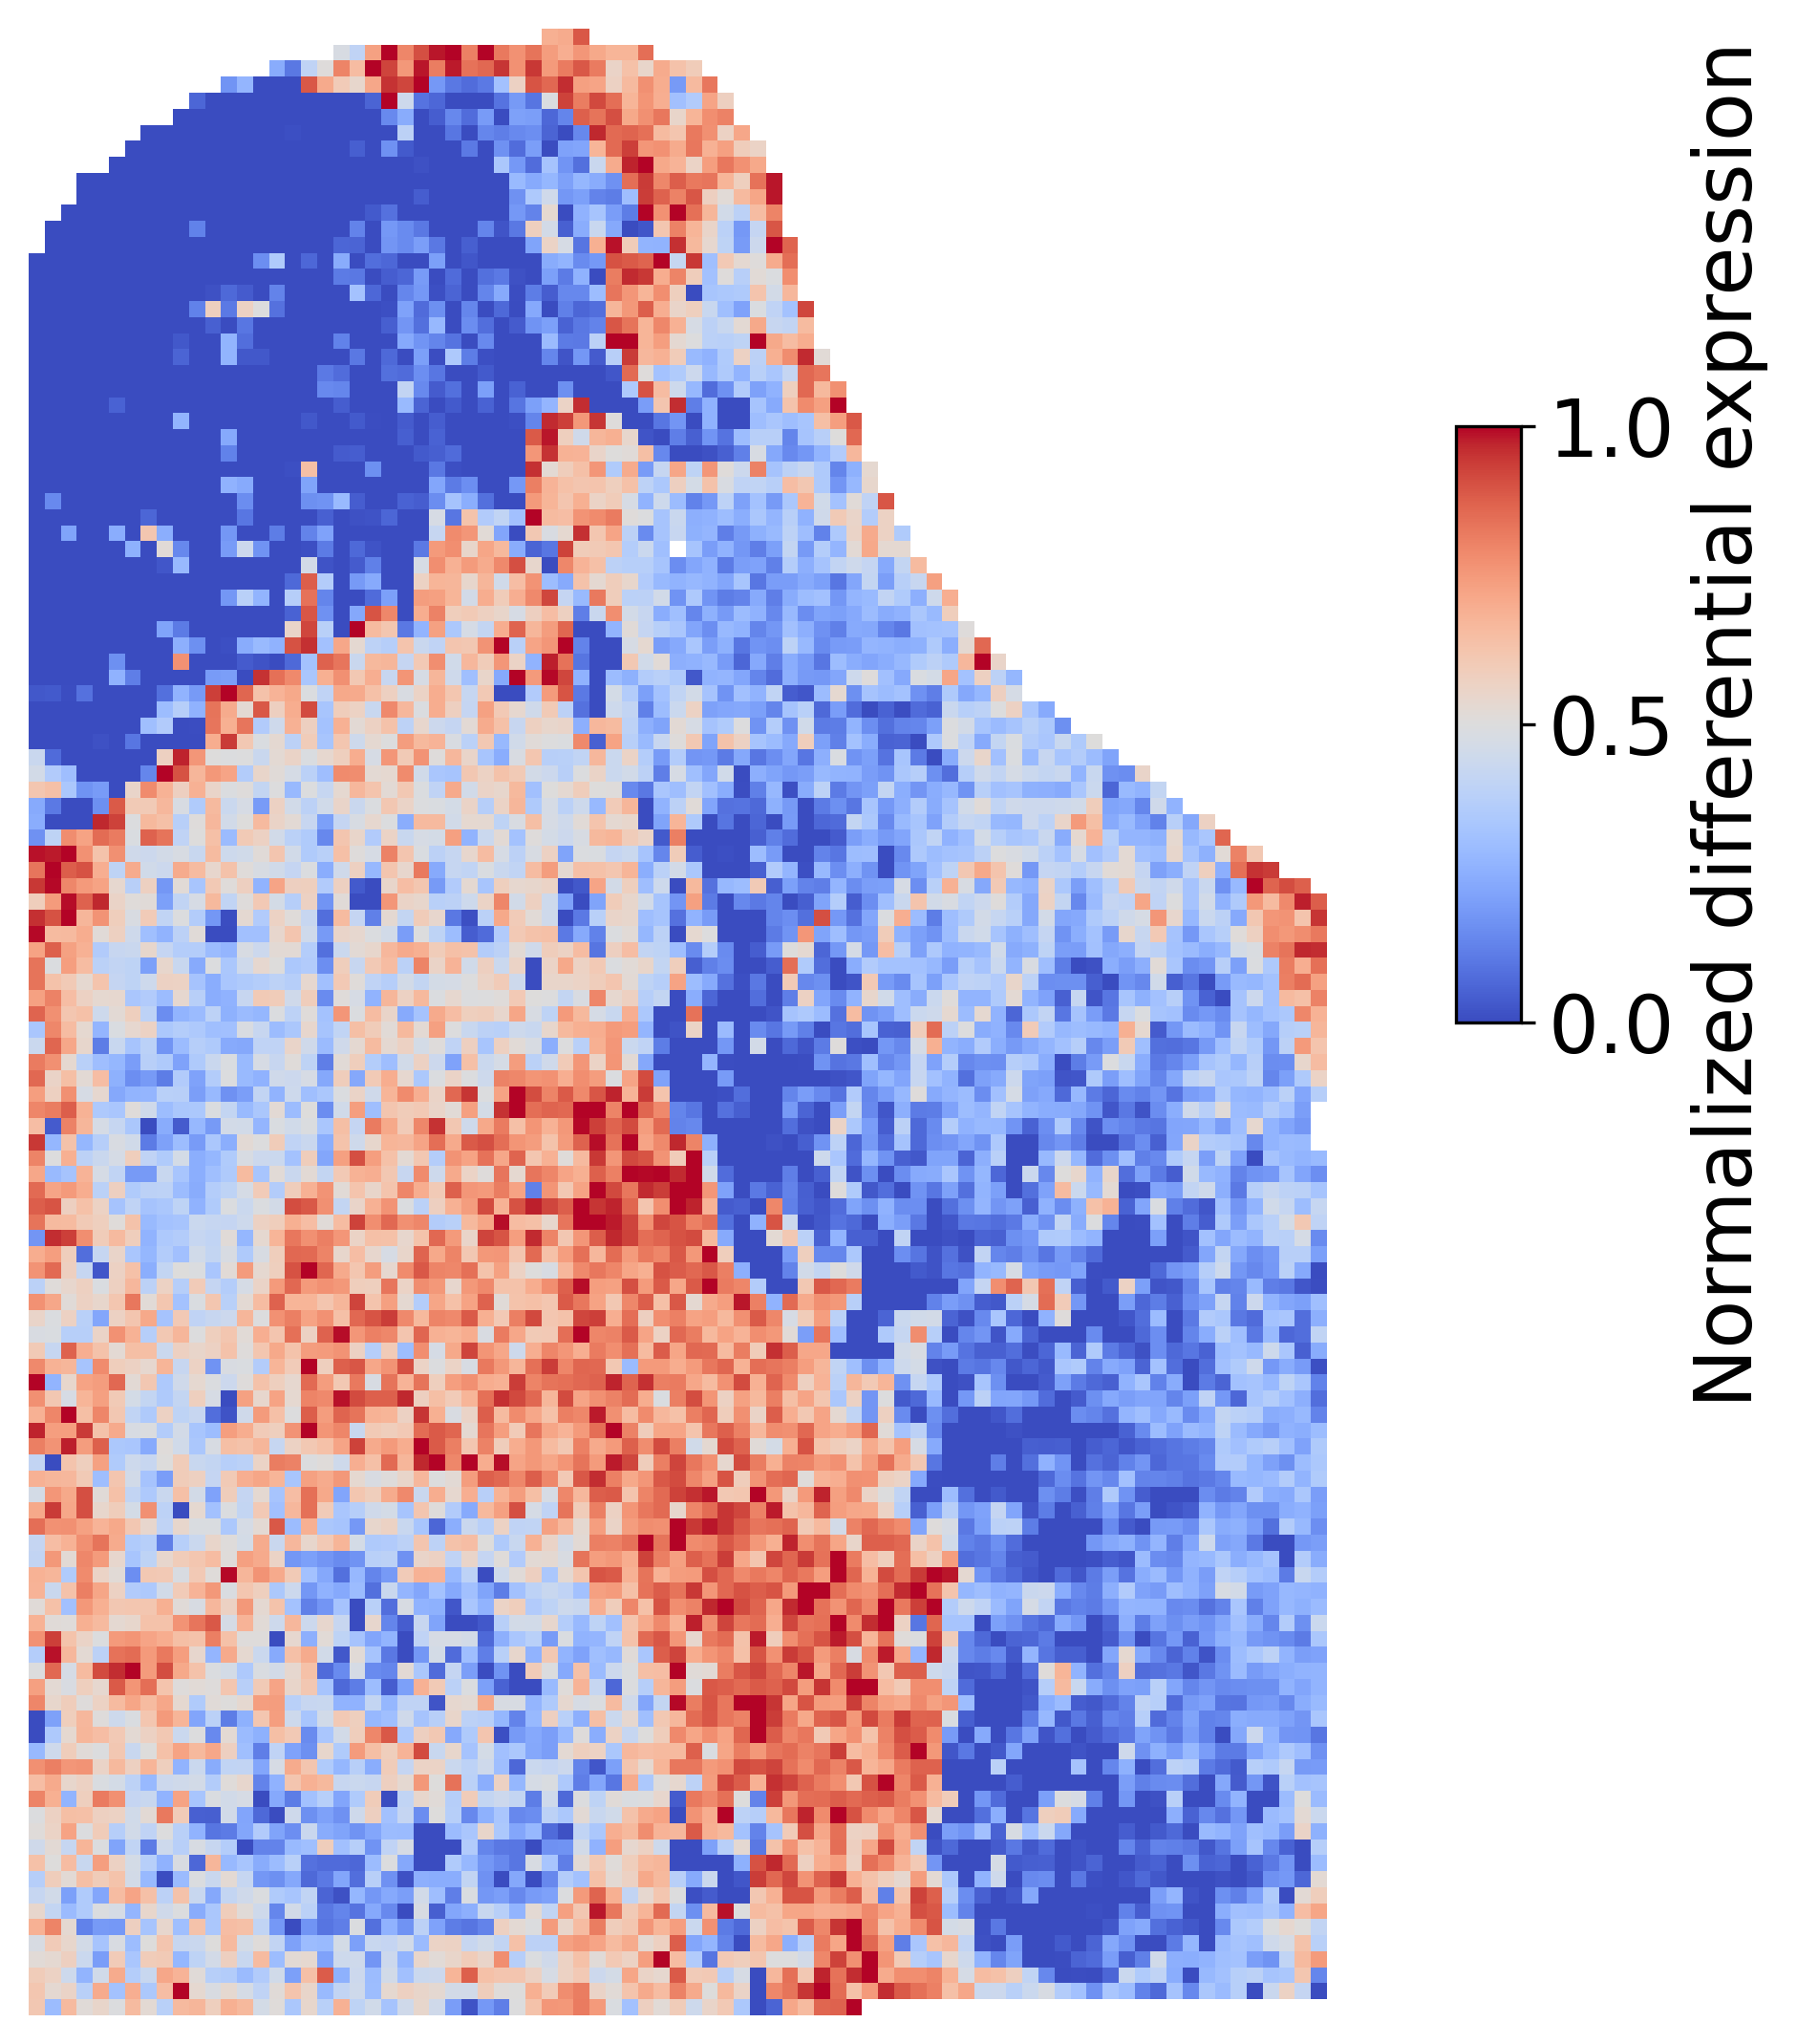

In [9]:
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt

mpl.rcParams['font.size'] = 20

keep_nonBlank = ['blank' not in gn.lower() for gn in gns]

gns_order = gns[keep_nonBlank].copy()
xfov = np.array(xfov)
XfovT = np.round(xfov/296.9).astype(int) # 296.9 is the  width of the fov
XfovT = XfovT-np.min(XfovT,axis=0)

# Normalize the background gene count
Mcts_array  = np.array(Mcts)[:,keep_nonBlank] # Nfovs x ngns
Mlog = np.log(Mcts_array) 
Mlog = Mlog-np.mean(Mlog,axis=-1)[:,np.newaxis] # normalize across genes
Mlog = Mlog-np.mean(Mlog,axis=0)[np.newaxis,:] # normalize across FOVS

mn_all = np.mean(adata[:,gns_order].X,axis=0)

e1 = 'STRd D2 Matrix MSN'
e2 = 'STRd D1 Matrix MSN'


meanDH = np.mean(adata[:,gns_order][adata.obs['Group_name']== e1].X,axis=0)-mn_all # 1 x ngns 
meanDHC= np.mean(adata[:,gns_order][adata.obs['Group_name']== e2].X,axis=0)-mn_all # 1 x ngns


Mloggn=np.dot(Mlog,meanDH-meanDHC) # Nfovs x 1 = Nfovs x ngns @ ngns x 1
mgn,Mgn = np.percentile(Mloggn,15),np.percentile(Mloggn,99)

def get_col(tv):
    cs = []
    for t in tv:
        if t<0.5: 
            t= 2*t
            c=np.array([1,0,1])*(1-t)+t*np.array([0,0,0])
        else:
            t=(t-0.5)*2
            c=np.array([0,0,0])*(1-t)+t*np.array([0,1,0])
        cs.append(c)
    return np.array(cs)

# mgn,Mgn=-5,8
colgn = mpl.cm.coolwarm(np.clip((Mloggn-mgn)/(Mgn-mgn),0,1))[:,:3]

# colgn = get_col(np.clip((Mloggn-mgn)/(Mgn-mgn),0,1))
imgn = np.ones(list(np.max(XfovT,axis=0)+1)+[3])
imgn[tuple(XfovT.T)]=colgn[:,:3]

fig,ax = plt.subplots(1,1, dpi = 300, figsize = (6,9))
hd = ax.imshow(imgn)
ax.set_axis_off()


# add colorbar
bbox = ax.get_position()
ax_cbar = fig.add_axes([bbox.xmin + 1.1*bbox.width, bbox.ymin + 0.5*bbox.height, 0.05*bbox.width, 0.3*bbox.height])

colorNorm = np.clip((Mloggn-mgn)/(Mgn-mgn),0,1)
cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=colorNorm.min(), vmax=colorNorm.max())

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax_cbar, label='Normalized differential expression')

plt.savefig(r'./figures/D2Matrix_enrichment_wrt_D1Matrix_mgn_n2_Mgn_p8.png',bbox_inches = 'tight')
plt.savefig(r'./figures/D2Matrix_enrichment_wrt_D1Matrix_mgn_n2_Mgn_p8.tif',bbox_inches = 'tight')

plt.show()

B. Enrichment of STRd D1 Matrix MSN

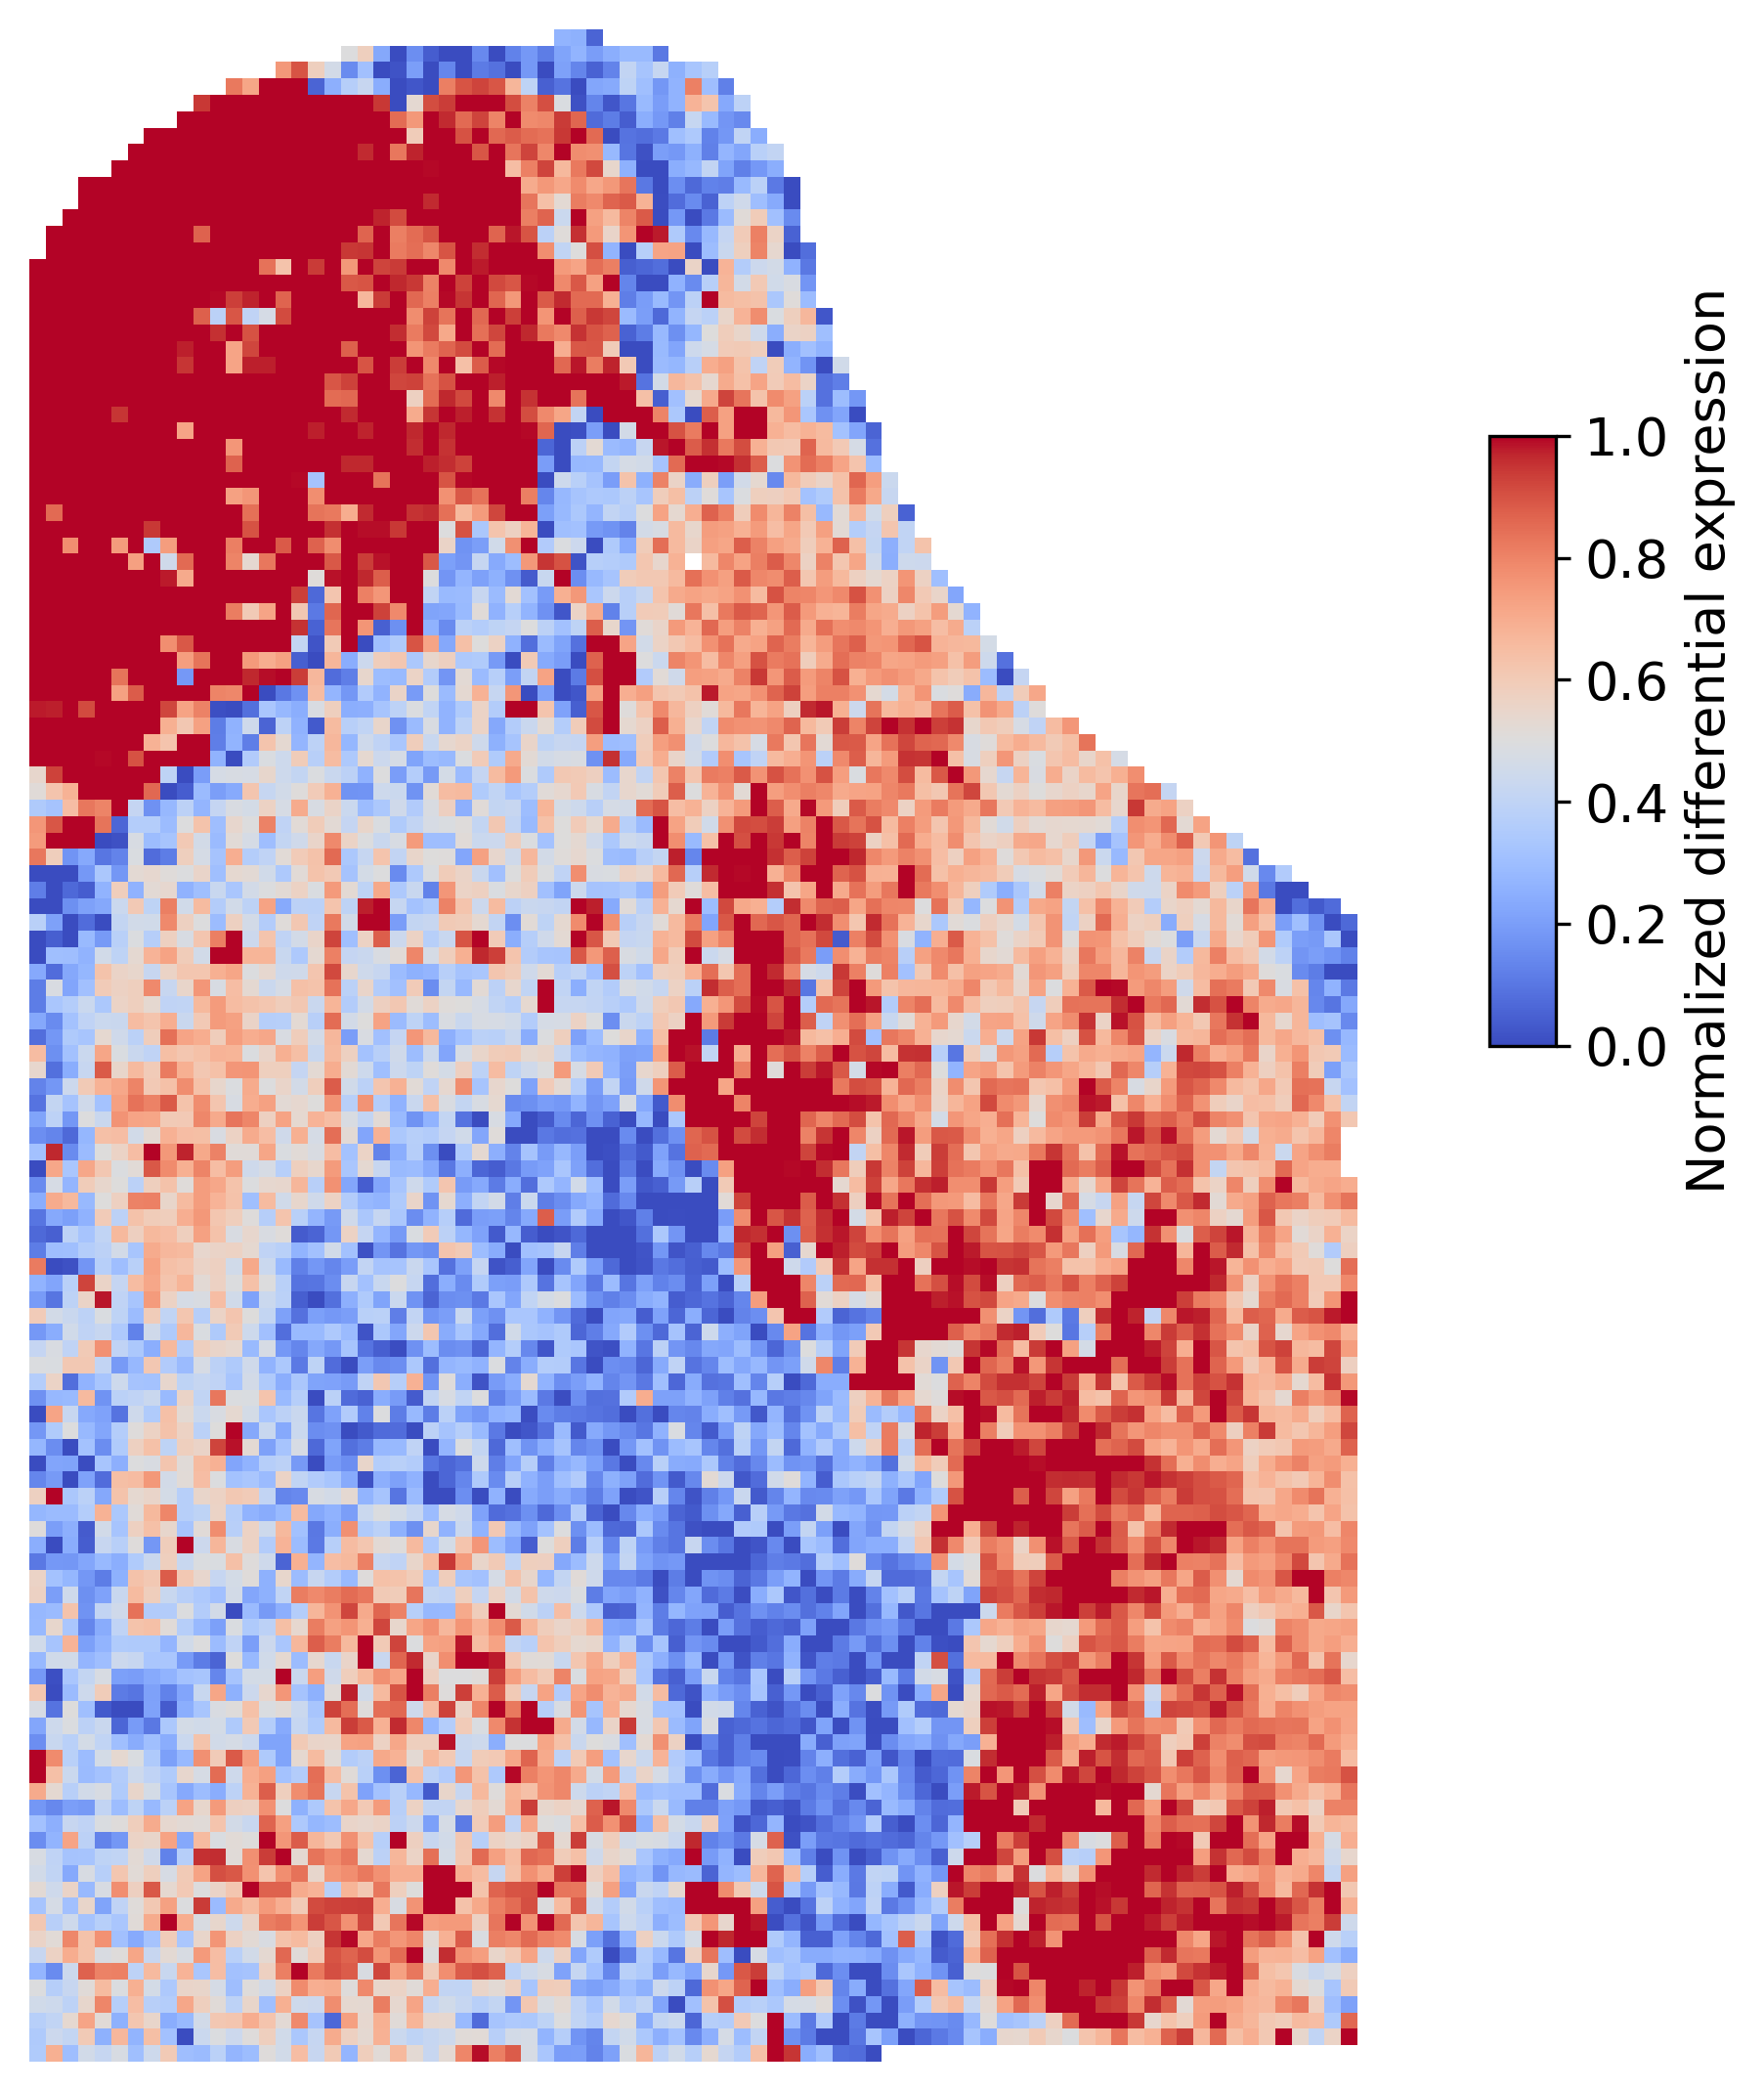

In [100]:
keep_nonBlank = ['blank' not in gn.lower() for gn in gns]

gns_order = gns[keep_nonBlank].copy()
xfov = np.array(xfov)
XfovT = np.round(xfov/296.9).astype(int) # 296.9 is the  width of the fov
XfovT = XfovT-np.min(XfovT,axis=0)

Mcts_array  = np.array(Mcts)[:,keep_nonBlank]
Mlog = np.log(Mcts_array) 
Mlog = Mlog-np.mean(Mlog,axis=-1)[:,np.newaxis] # normalize across genes
Mlog = Mlog-np.mean(Mlog,axis=0)[np.newaxis,:] # normalize across FOVS

mn_all = np.mean(adata[:,gns_order].X,axis=0)

e1 = 'STRd D1 Matrix MSN'
e2 = 'STRd D2 Matrix MSN'


meanDH = np.mean(adata[:,gns_order][adata.obs['Group_name']== e1].X,axis=0)-mn_all
meanDHC= np.mean(adata[:,gns_order][adata.obs['Group_name']== e2].X,axis=0)-mn_all


Mloggn=np.dot(Mlog,meanDH-meanDHC)
mgn,Mgn = np.percentile(Mloggn,5),np.percentile(Mloggn,95)

def get_col(tv):
    cs = []
    for t in tv:
        if t<0.5: 
            t= 2*t
            c=np.array([1,0,1])*(1-t)+t*np.array([0,0,0])
        else:
            t=(t-0.5)*2
            c=np.array([0,0,0])*(1-t)+t*np.array([0,1,0])
        cs.append(c)
    return np.array(cs)

mgn,Mgn=-10,6
# colgn = mpl.cm.coolwarm(np.clip((Mloggn-mgn)/(Mgn-mgn),0,1))[:,:3]
colgn = mpl.cm.coolwarm(np.clip((Mloggn-mgn)/(Mgn-mgn),0,1))[:,:3]
# colgn = get_col(np.clip((Mloggn-mgn)/(Mgn-mgn),0,1))
imgn = np.ones(list(np.max(XfovT,axis=0)+1)+[3])
imgn[tuple(XfovT.T)]=colgn[:,:3]

fig,ax = plt.subplots(1,1, dpi = 300, figsize = (6,9))
hd = ax.imshow(imgn, )

# add colorbar
bbox = ax.get_position()
ax_cbar = fig.add_axes([bbox.xmin + 1.1*bbox.width, bbox.ymin + 0.5*bbox.height, 0.05*bbox.width, 0.3*bbox.height])


colorNorm = np.clip((Mloggn-mgn)/(Mgn-mgn),0,1)
cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=colorNorm.min(), vmax=colorNorm.max())

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax_cbar, label='Normalized differential expression')
ax.set_axis_off()


# plt.savefig(r'./figures/D1Matrix_enrichment_wrt_D2Matrix.png',bbox_inches = 'tight')
# plt.savefig(r'./figures/D1Matrix_enrichment_wrt_D2Matrix.tif',bbox_inches = 'tight')

plt.show()

Plot the differential genes between D1 and D2 Matrix MSN

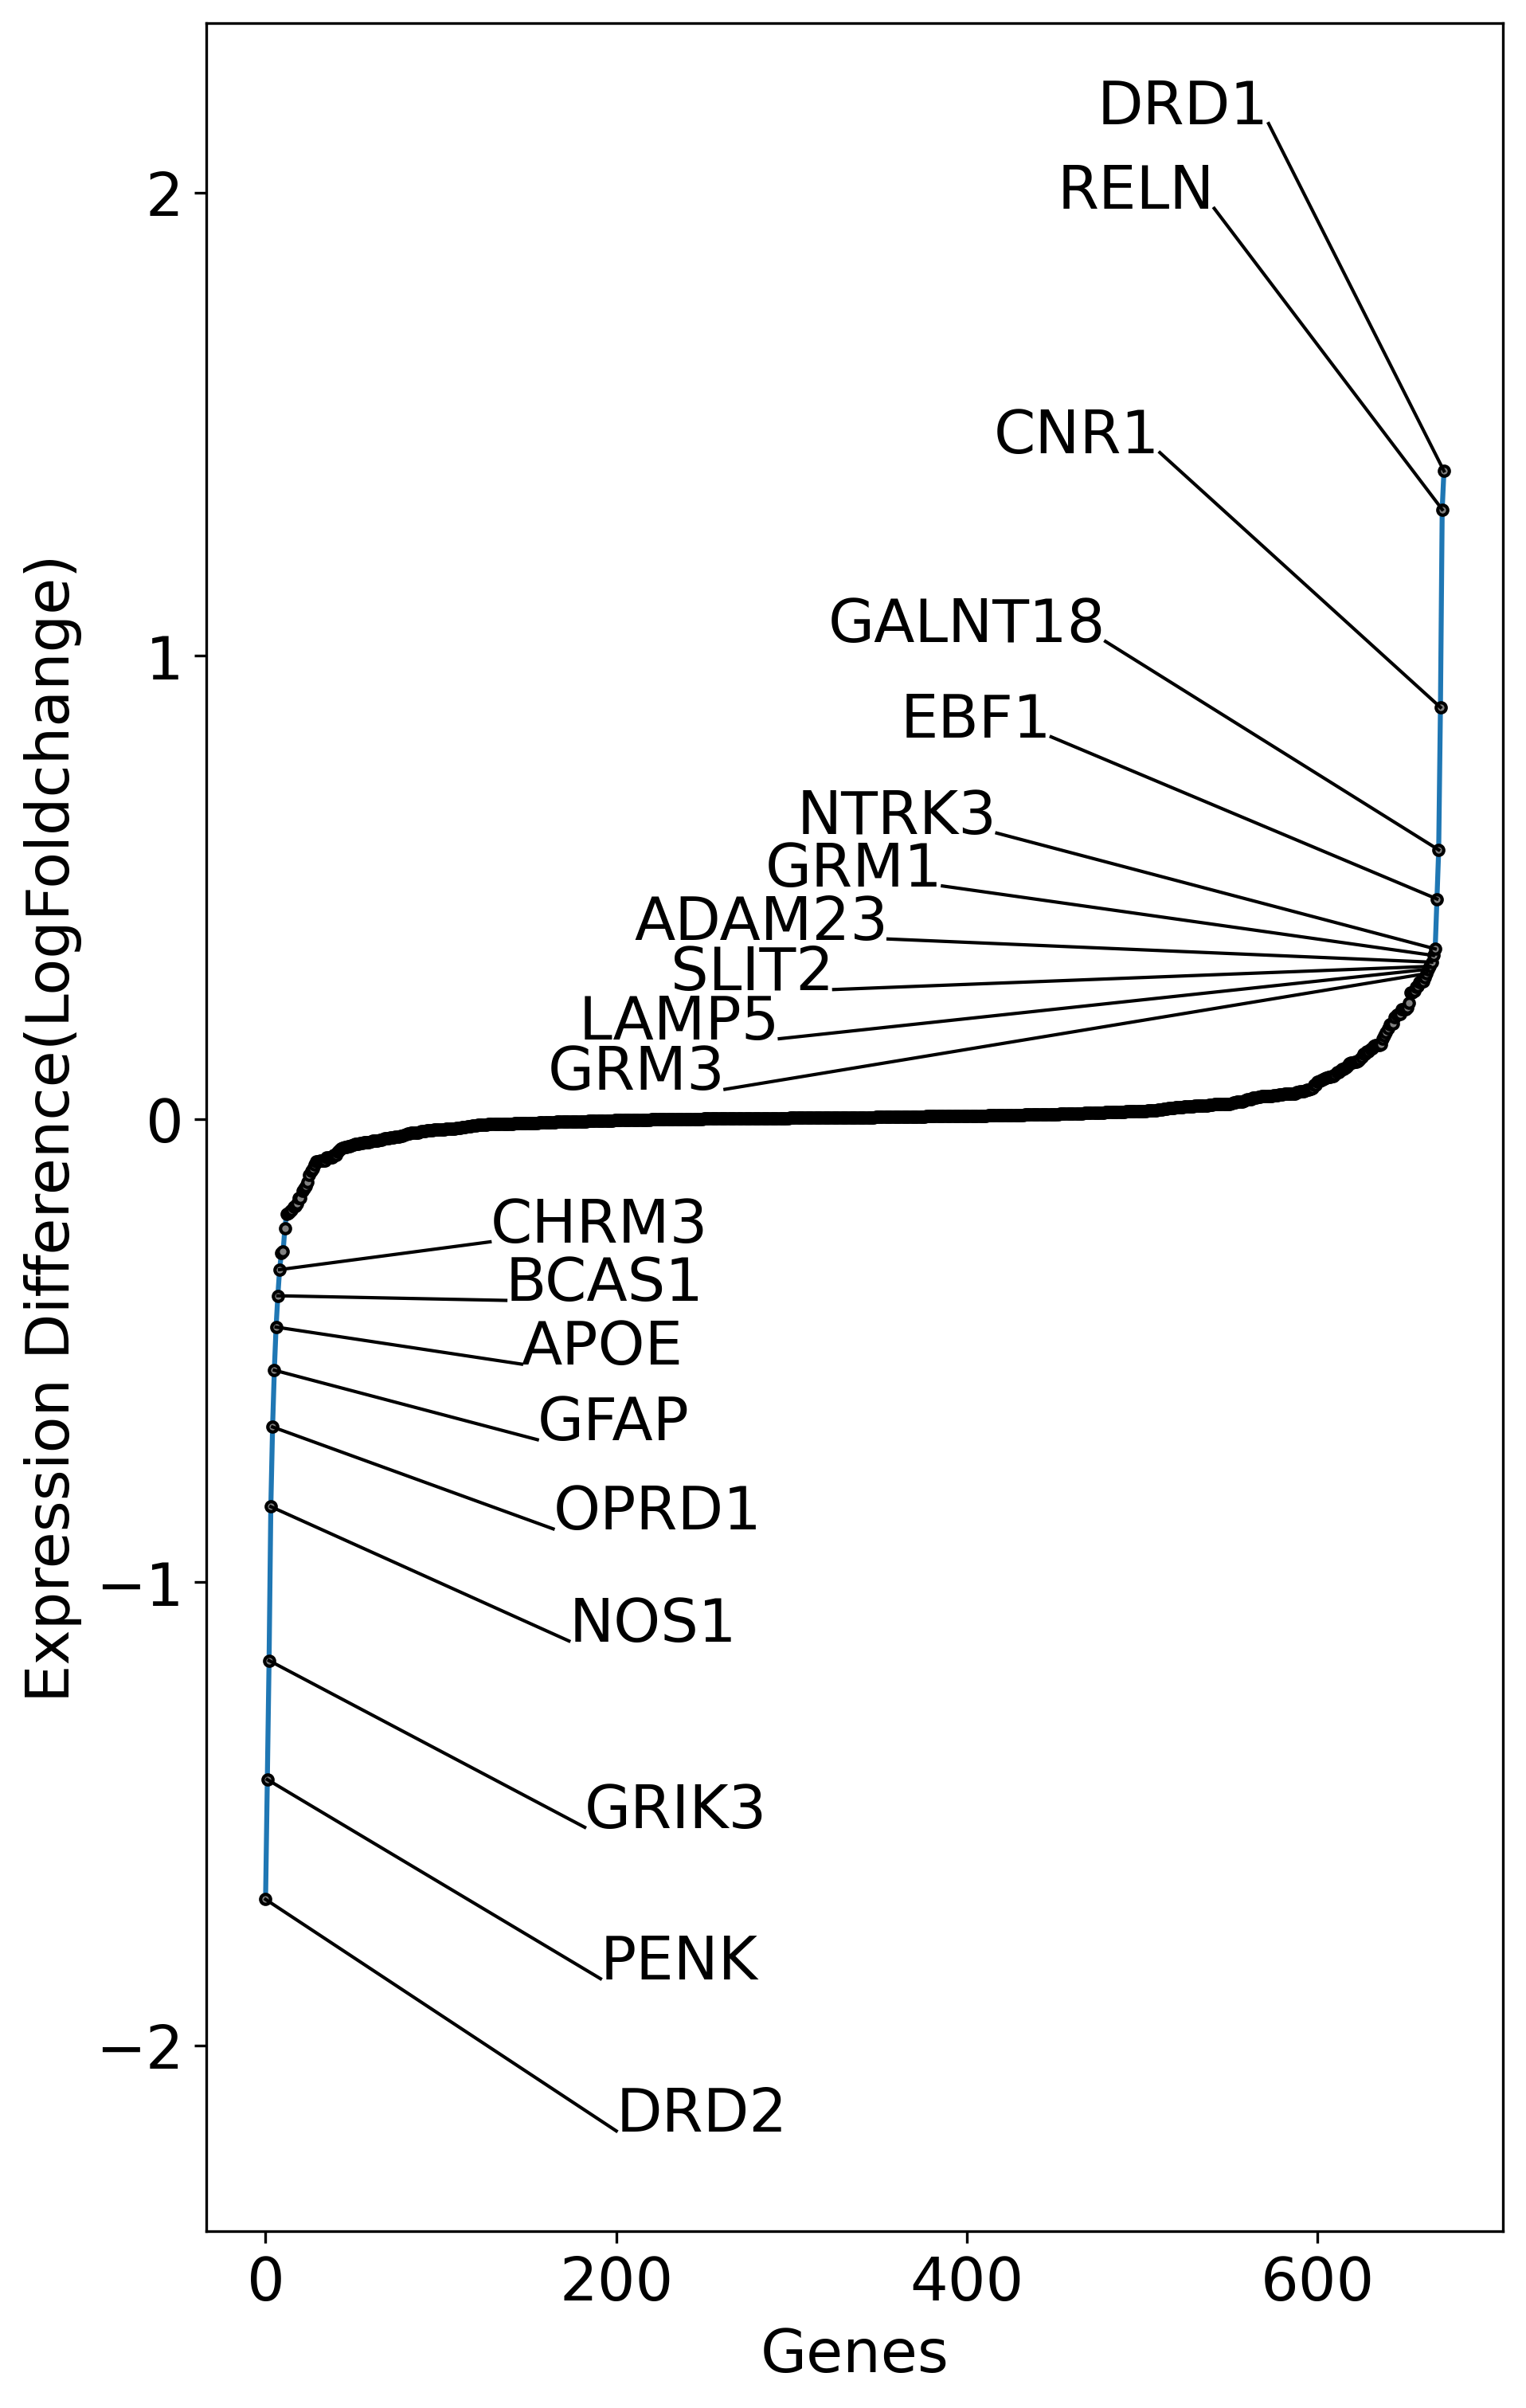

In [14]:
import matplotlib.pylab as plt
mpl.rcParams['font.size'] = 18
fig,ax = plt.subplots(1,1, figsize = (7,12), dpi =300)
e1 = 'STRd D1 Matrix MSN'
e2 = 'STRd D2 Matrix MSN'
meanDH = np.mean(adata[:,gns_order][adata.obs['Group_name']== e1].X,axis=0)-mn_all
meanDHC= np.mean(adata[:,gns_order][adata.obs['Group_name']== e2].X,axis=0)-mn_all
dif = meanDH-meanDHC
sortidx = np.argsort(dif)
sorted_gns = gns[keep_nonBlank].copy()[sortidx]
sorted_dif = dif[sortidx].copy() 
ax.plot(sorted_dif,'o-', markersize = 3, mec = 'k', mfc = 'gray')
# add the text ontop of the genes 
keep_topD1_gn = sorted_dif > np.percentile(sorted_dif,98.5)
keep_topD2_gn = sorted_dif < np.percentile(sorted_dif,3)
d2_i = 0
for gn in sorted_gns[keep_topD2_gn]:
    if gn not in ['DRD2', 'PENK', 'GRIK3', 'NOS1', 'OPRD1','BCAS1','CHRM3','GFAP', 'APOE']:
        continue
    gn_i = np.where(sorted_gns == gn)[0]
    gn_i_ = gn_i + (200 - d2_i*10 )
    diff_val_ = sorted_dif[gn_i] + (0.07*d2_i - 0.5)
    color_ = 'b' if gn in ['SLIT2','ADAM23', 'NTRK3', 'SPARCL1']  else 'k'
    ax.text(gn_i_,diff_val_, gn, color = color_)
    d2_i +=1
    # draw line to connect the text with the point 
    
    ax.plot([gn_i,gn_i_],[sorted_dif[gn_i],diff_val_],c ='k',lw = 1)

for i,gn in enumerate(sorted_gns[keep_topD1_gn]):
    
    gn_i = np.where(sorted_gns == gn)[0]
    gn_i_ = gn_i - (400 - i*30 )
    diff_val_ = sorted_dif[gn_i] - (0.25 - 0.1*i )
    # color_ = 'r' if gn in ['SLIT2','ADAM23', 'NTRK3', 'SPARCL1']  else 'k'
    color_ = 'k'
    ax.text(gn_i_,diff_val_, gn, color = color_,ha = 'right')
    # draw line to connect the text with the point 
    ax.plot([gn_i,gn_i_],[sorted_dif[gn_i],diff_val_],c = 'k',lw = 1)

ax.set_xlabel('Genes')
ax.set_ylabel('Expression Difference(LogFoldchange)')

plt.savefig(r'./figures/D1_D2_diffExp_genes_logFoldChange_updated.png',bbox_inches = 'tight')
plt.savefig(r'./figures/D1_D2_diffExp_genes_logFoldChange_updated.tif',bbox_inches = 'tight')
plt.savefig(r'./figures/D1_D2_diffExp_genes_logFoldChange_updated.eps',bbox_inches = 'tight')

plt.show()

### 3. Spatial plot of extra-somatic count for selected genes

- Load list of axonal guidance genes

In [ ]:
# load the axonal guidance genes 
fl = open(r'./../../processed_data/XXBB3_500CellAdhAxon.fasta').readlines()
probe_nm = [fl[x] for x in range(0,len(fl),2)]
gene_nm = [x.split('__')[-1].split('_')[0].upper() for x in probe_nm]
AxG_Cadh_genes = np.unique(gene_nm)
keep_topD1_gn = sorted_dif > np.percentile(sorted_dif,98.5)
keep_topD2_gn = sorted_dif < np.percentile(sorted_dif,3)
top_gns = sorted_gns[keep_topD2_gn ]
set(top_gns).intersection(AxG_Cadh_genes)

{'BCAN', 'SPARCL1'}

In [232]:
top_gns

array(['DRD2', 'PENK', 'GRIK3', 'NOS1', 'OPRD1', 'GFAP', 'APOE', 'BCAS1',
       'CHRM3', 'ZEB2', 'NRGN', 'C3', 'SPARCL1', 'GPR6', 'PTGDS', 'CST3',
       'SLC1A3', 'BCAN', 'AQP4', 'GPR88', 'LPAR1'], dtype='<U15')

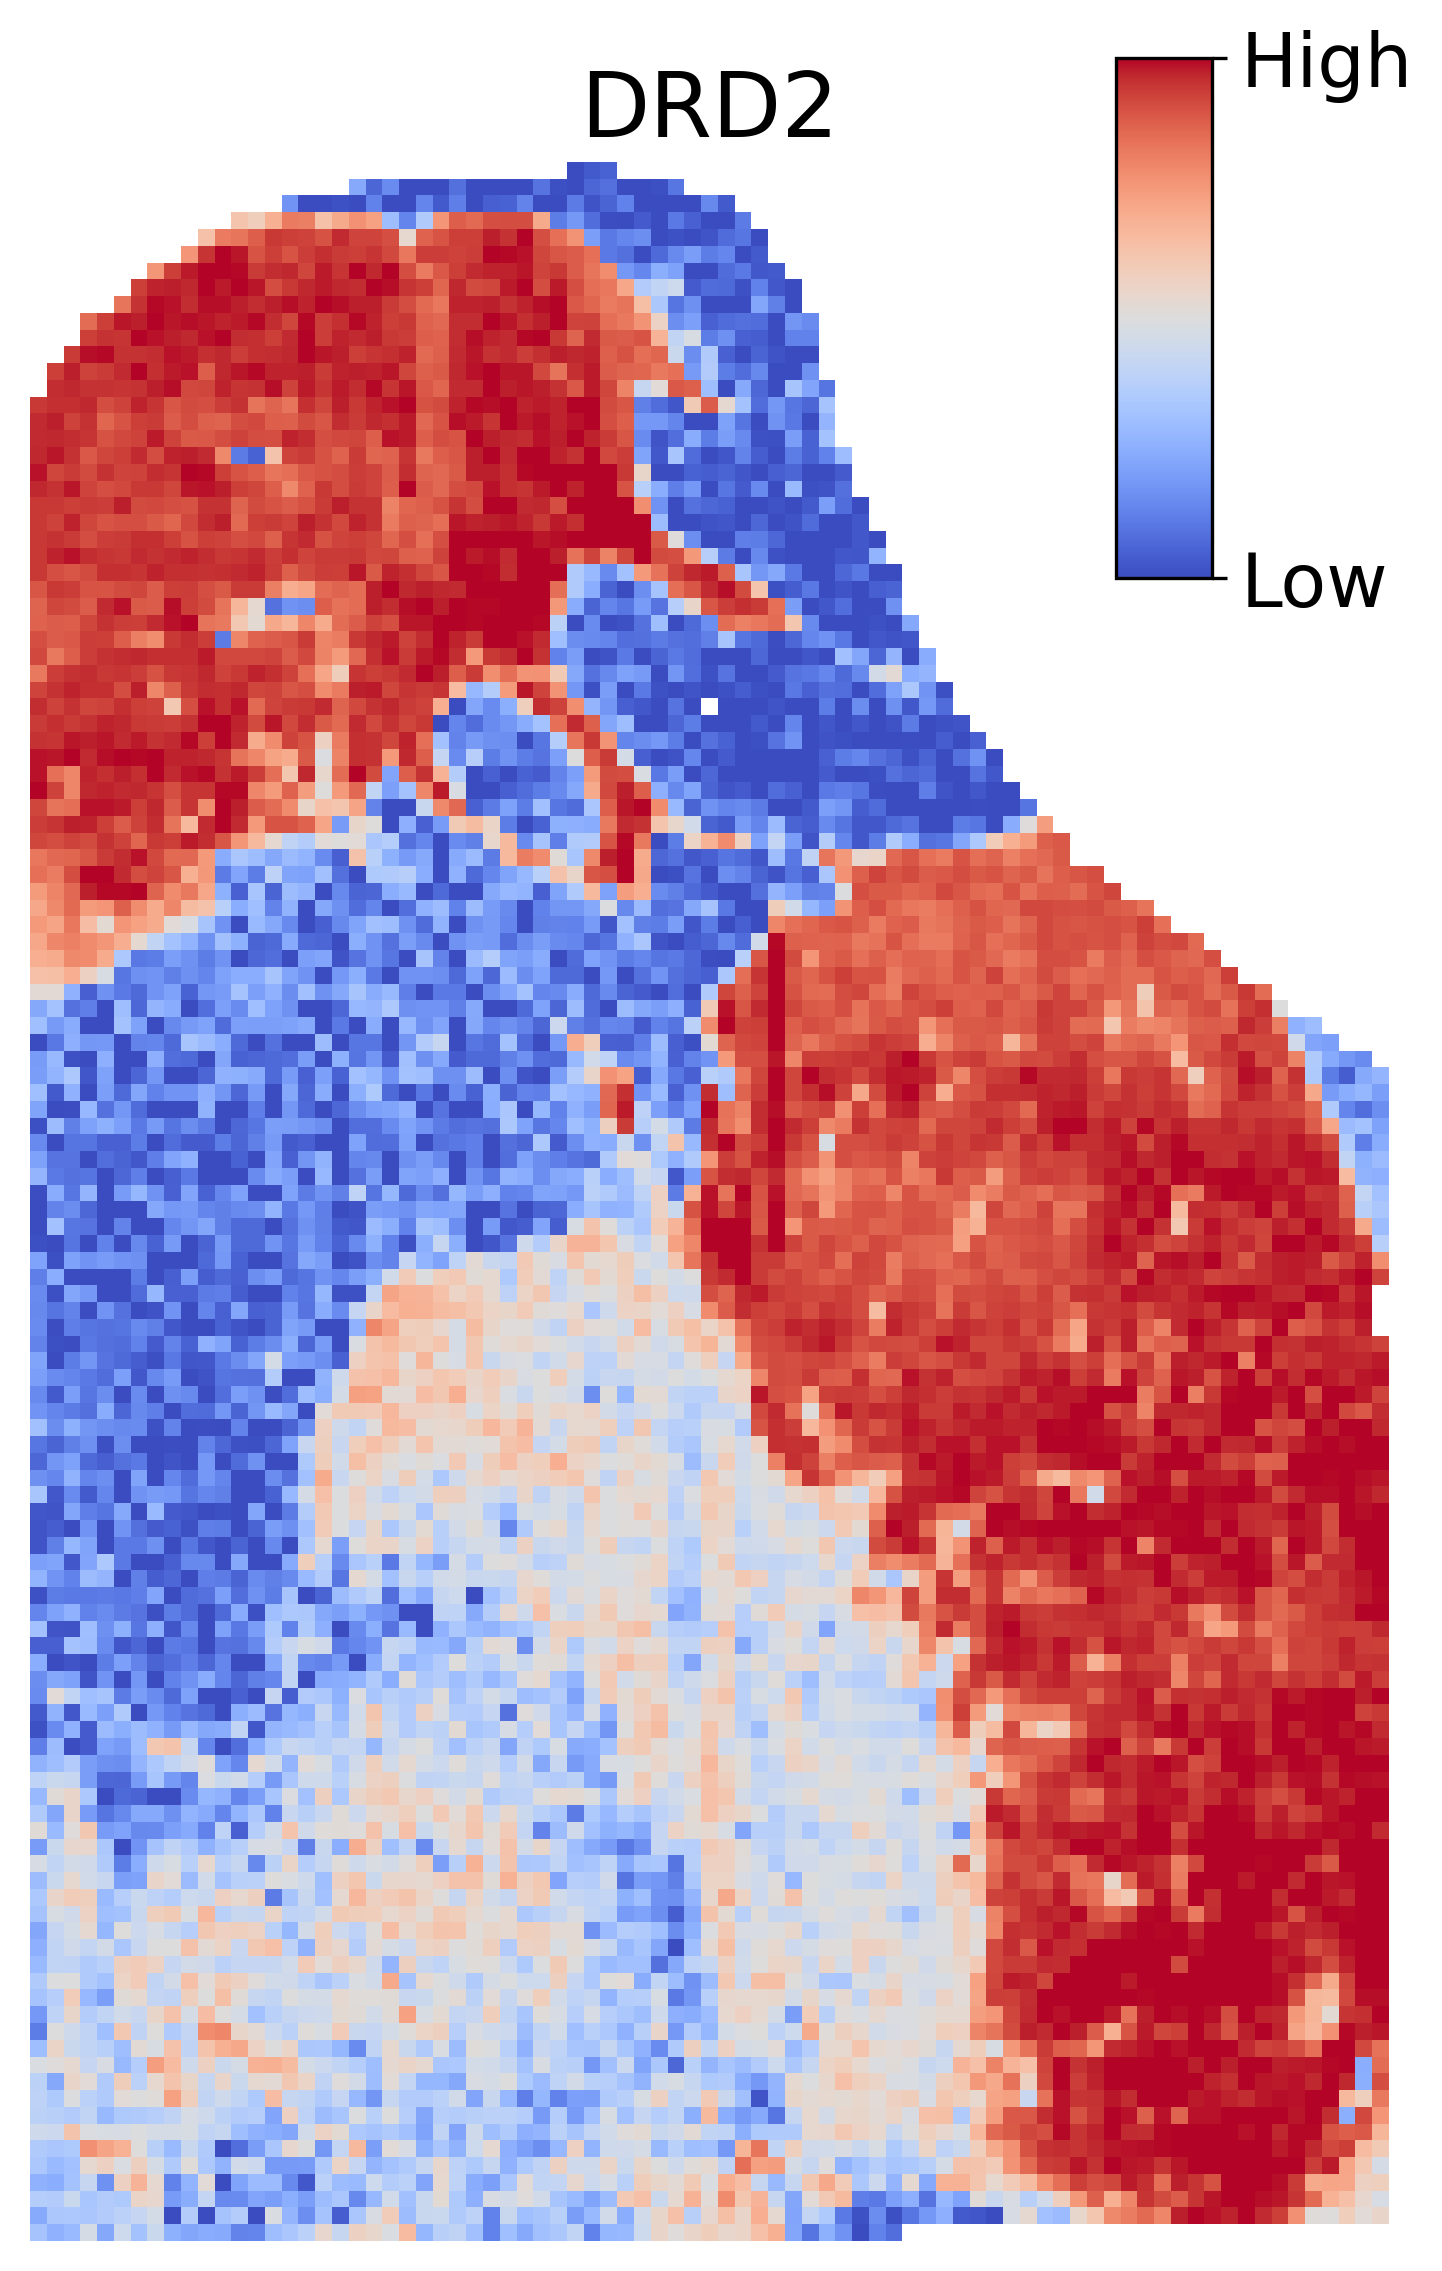

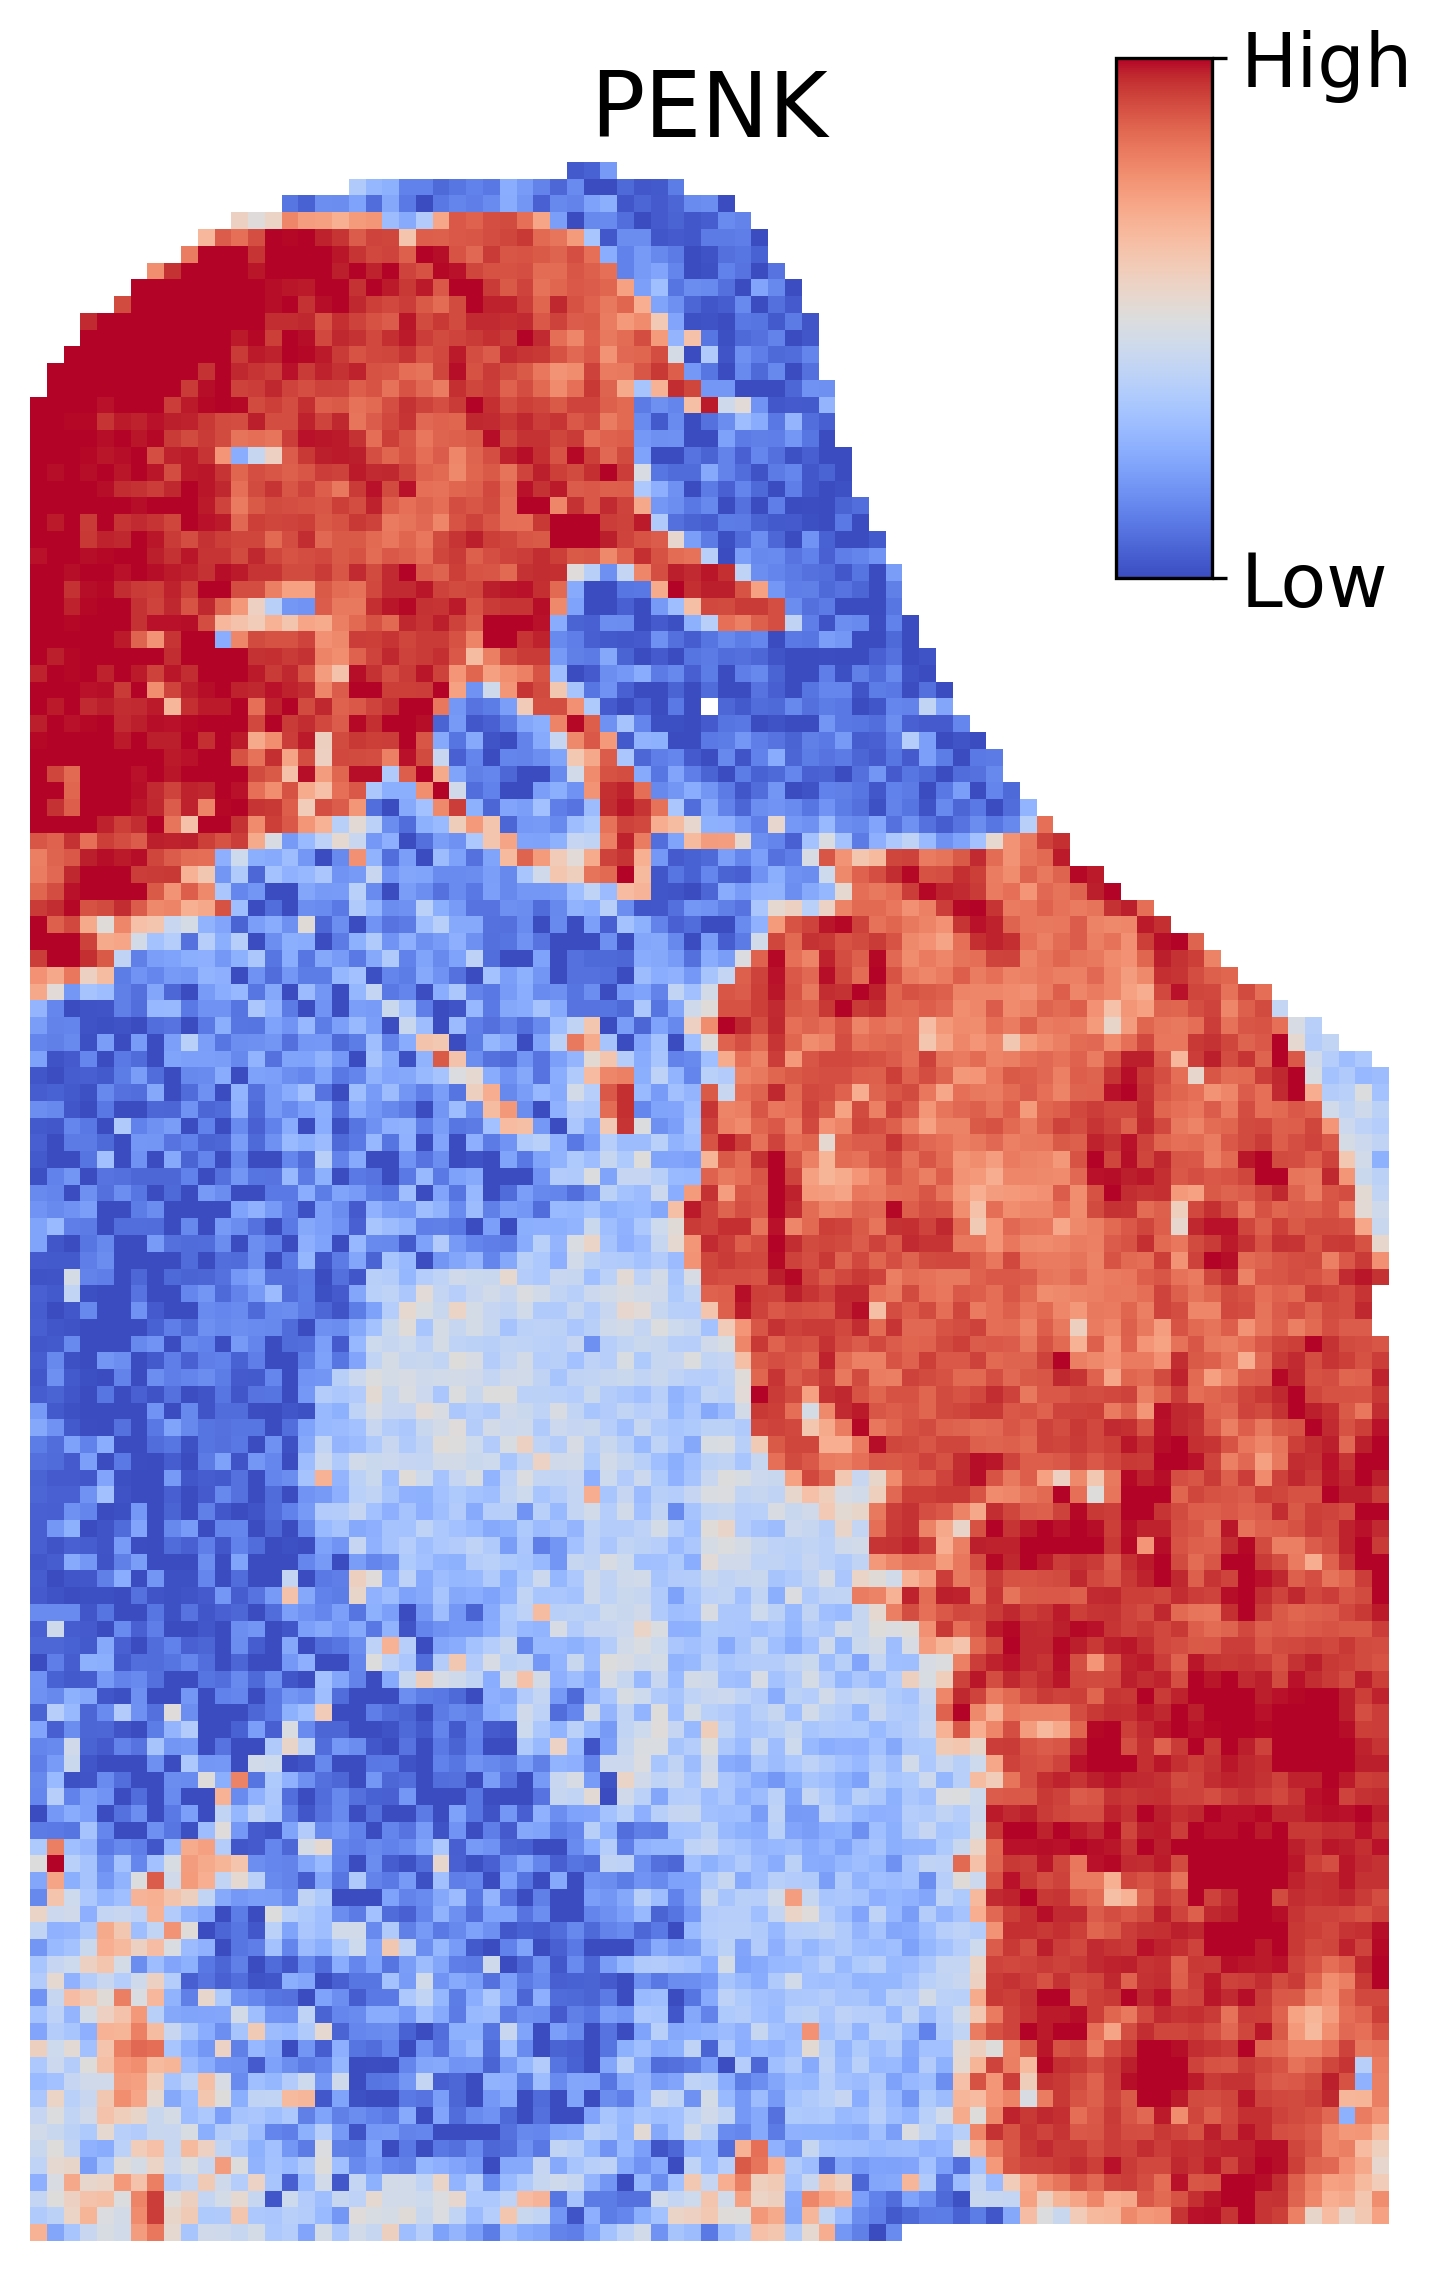

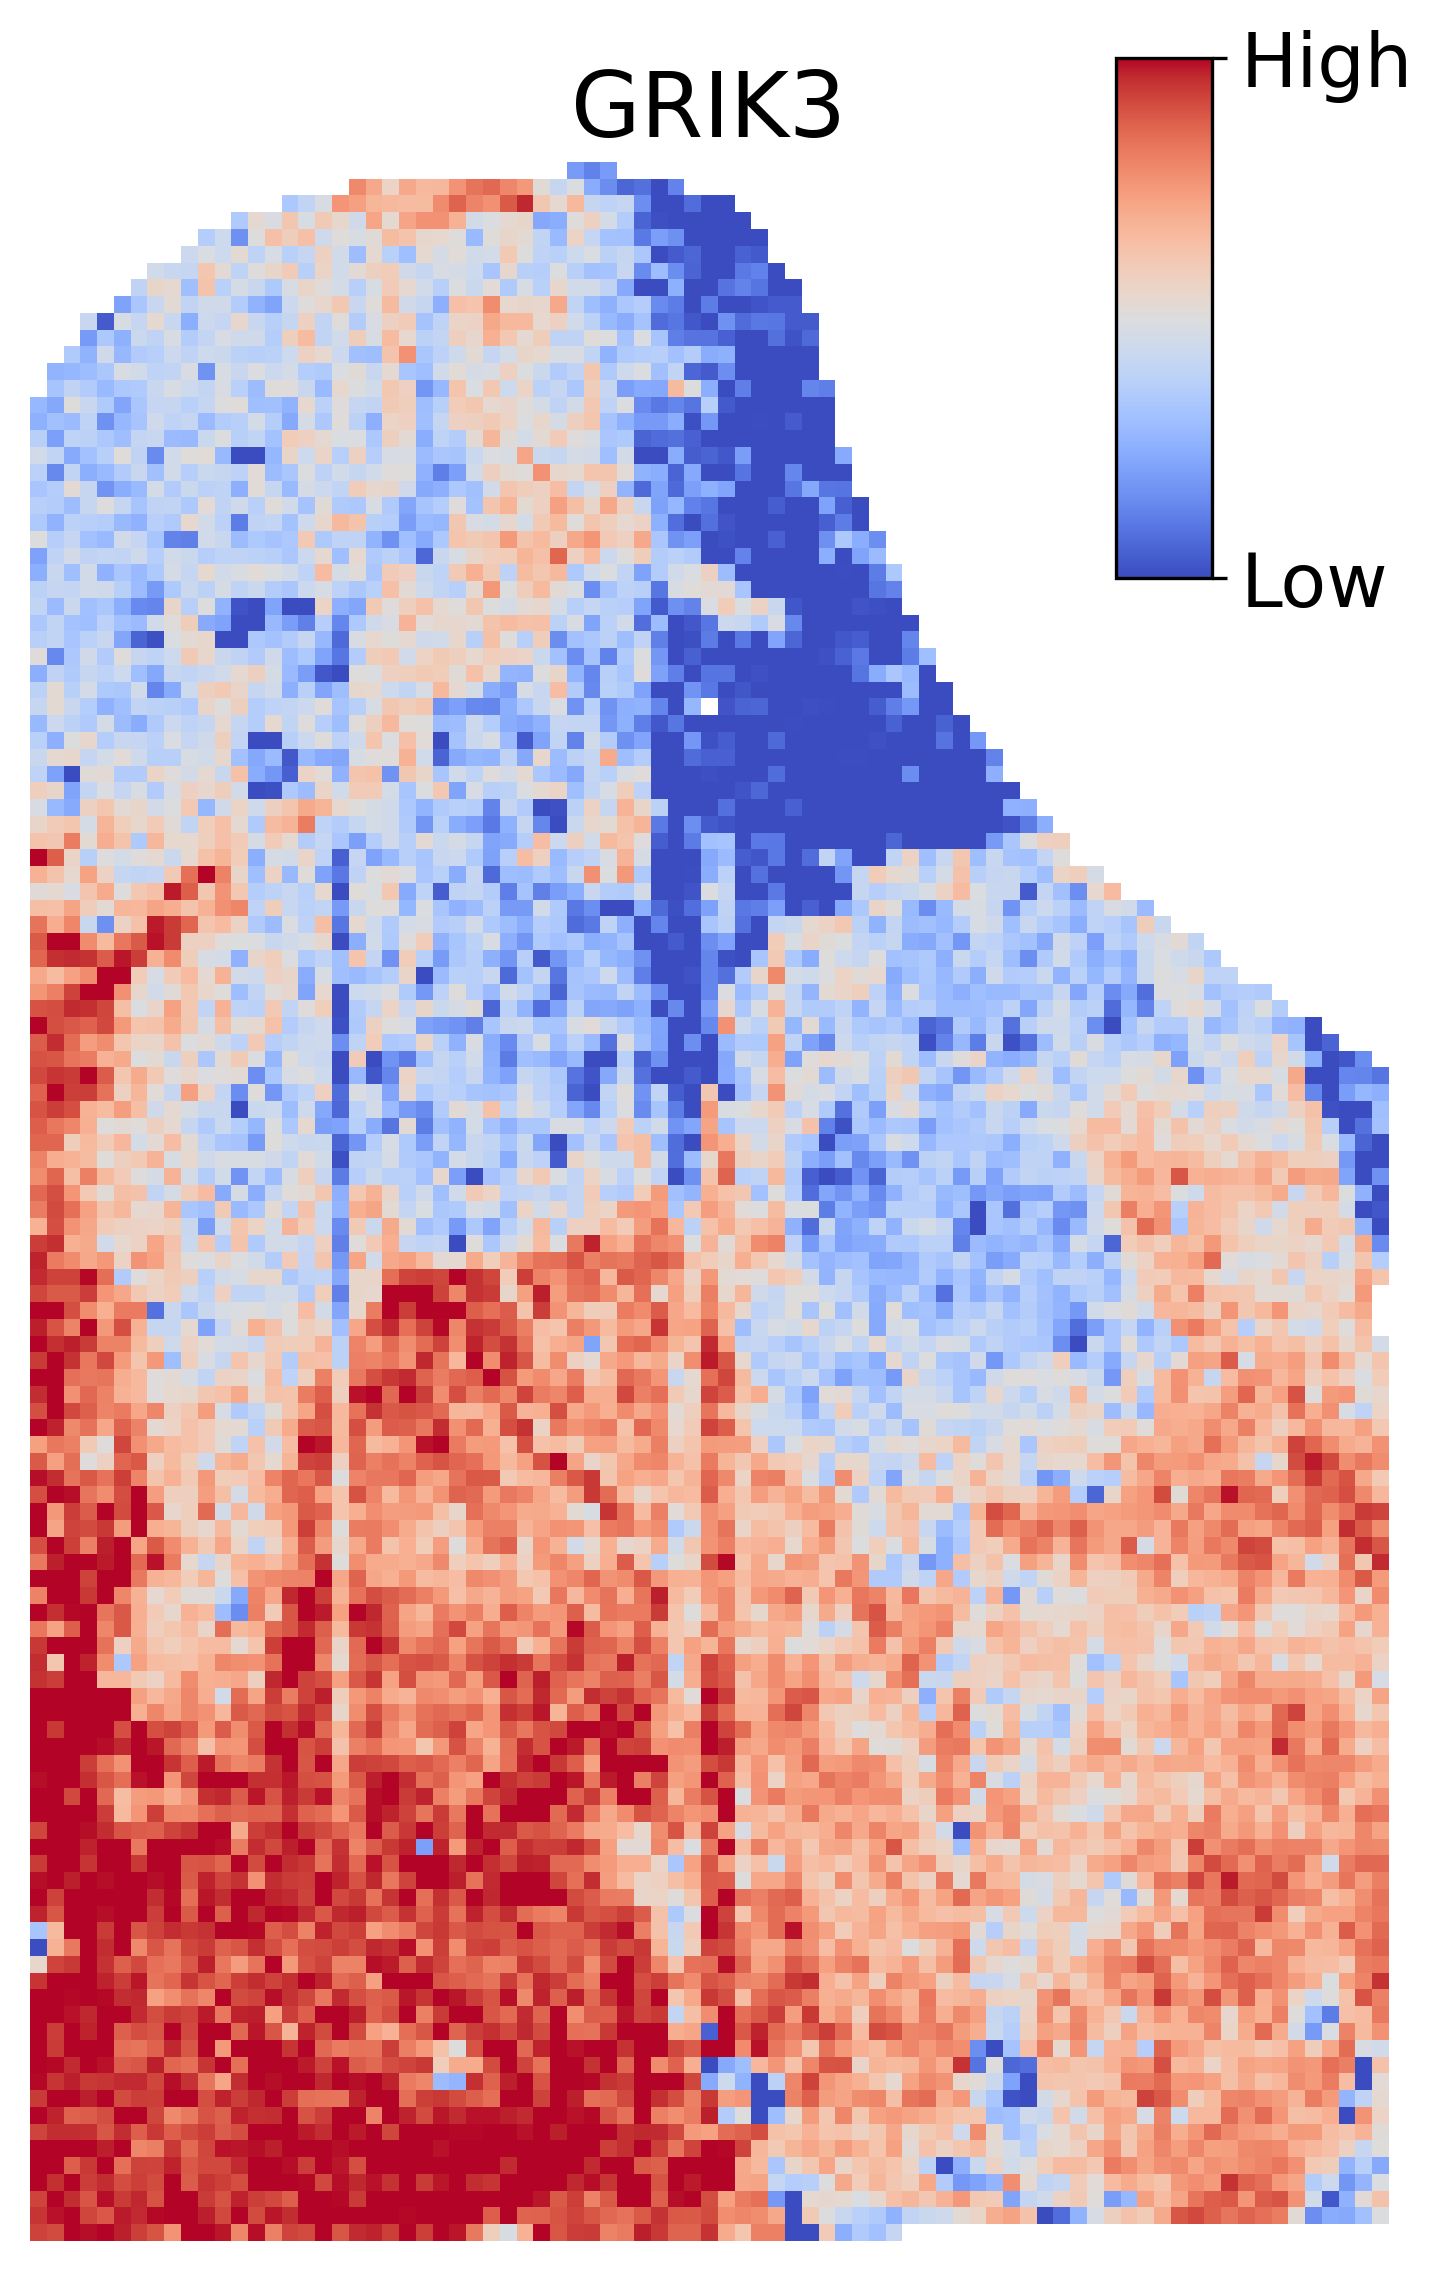

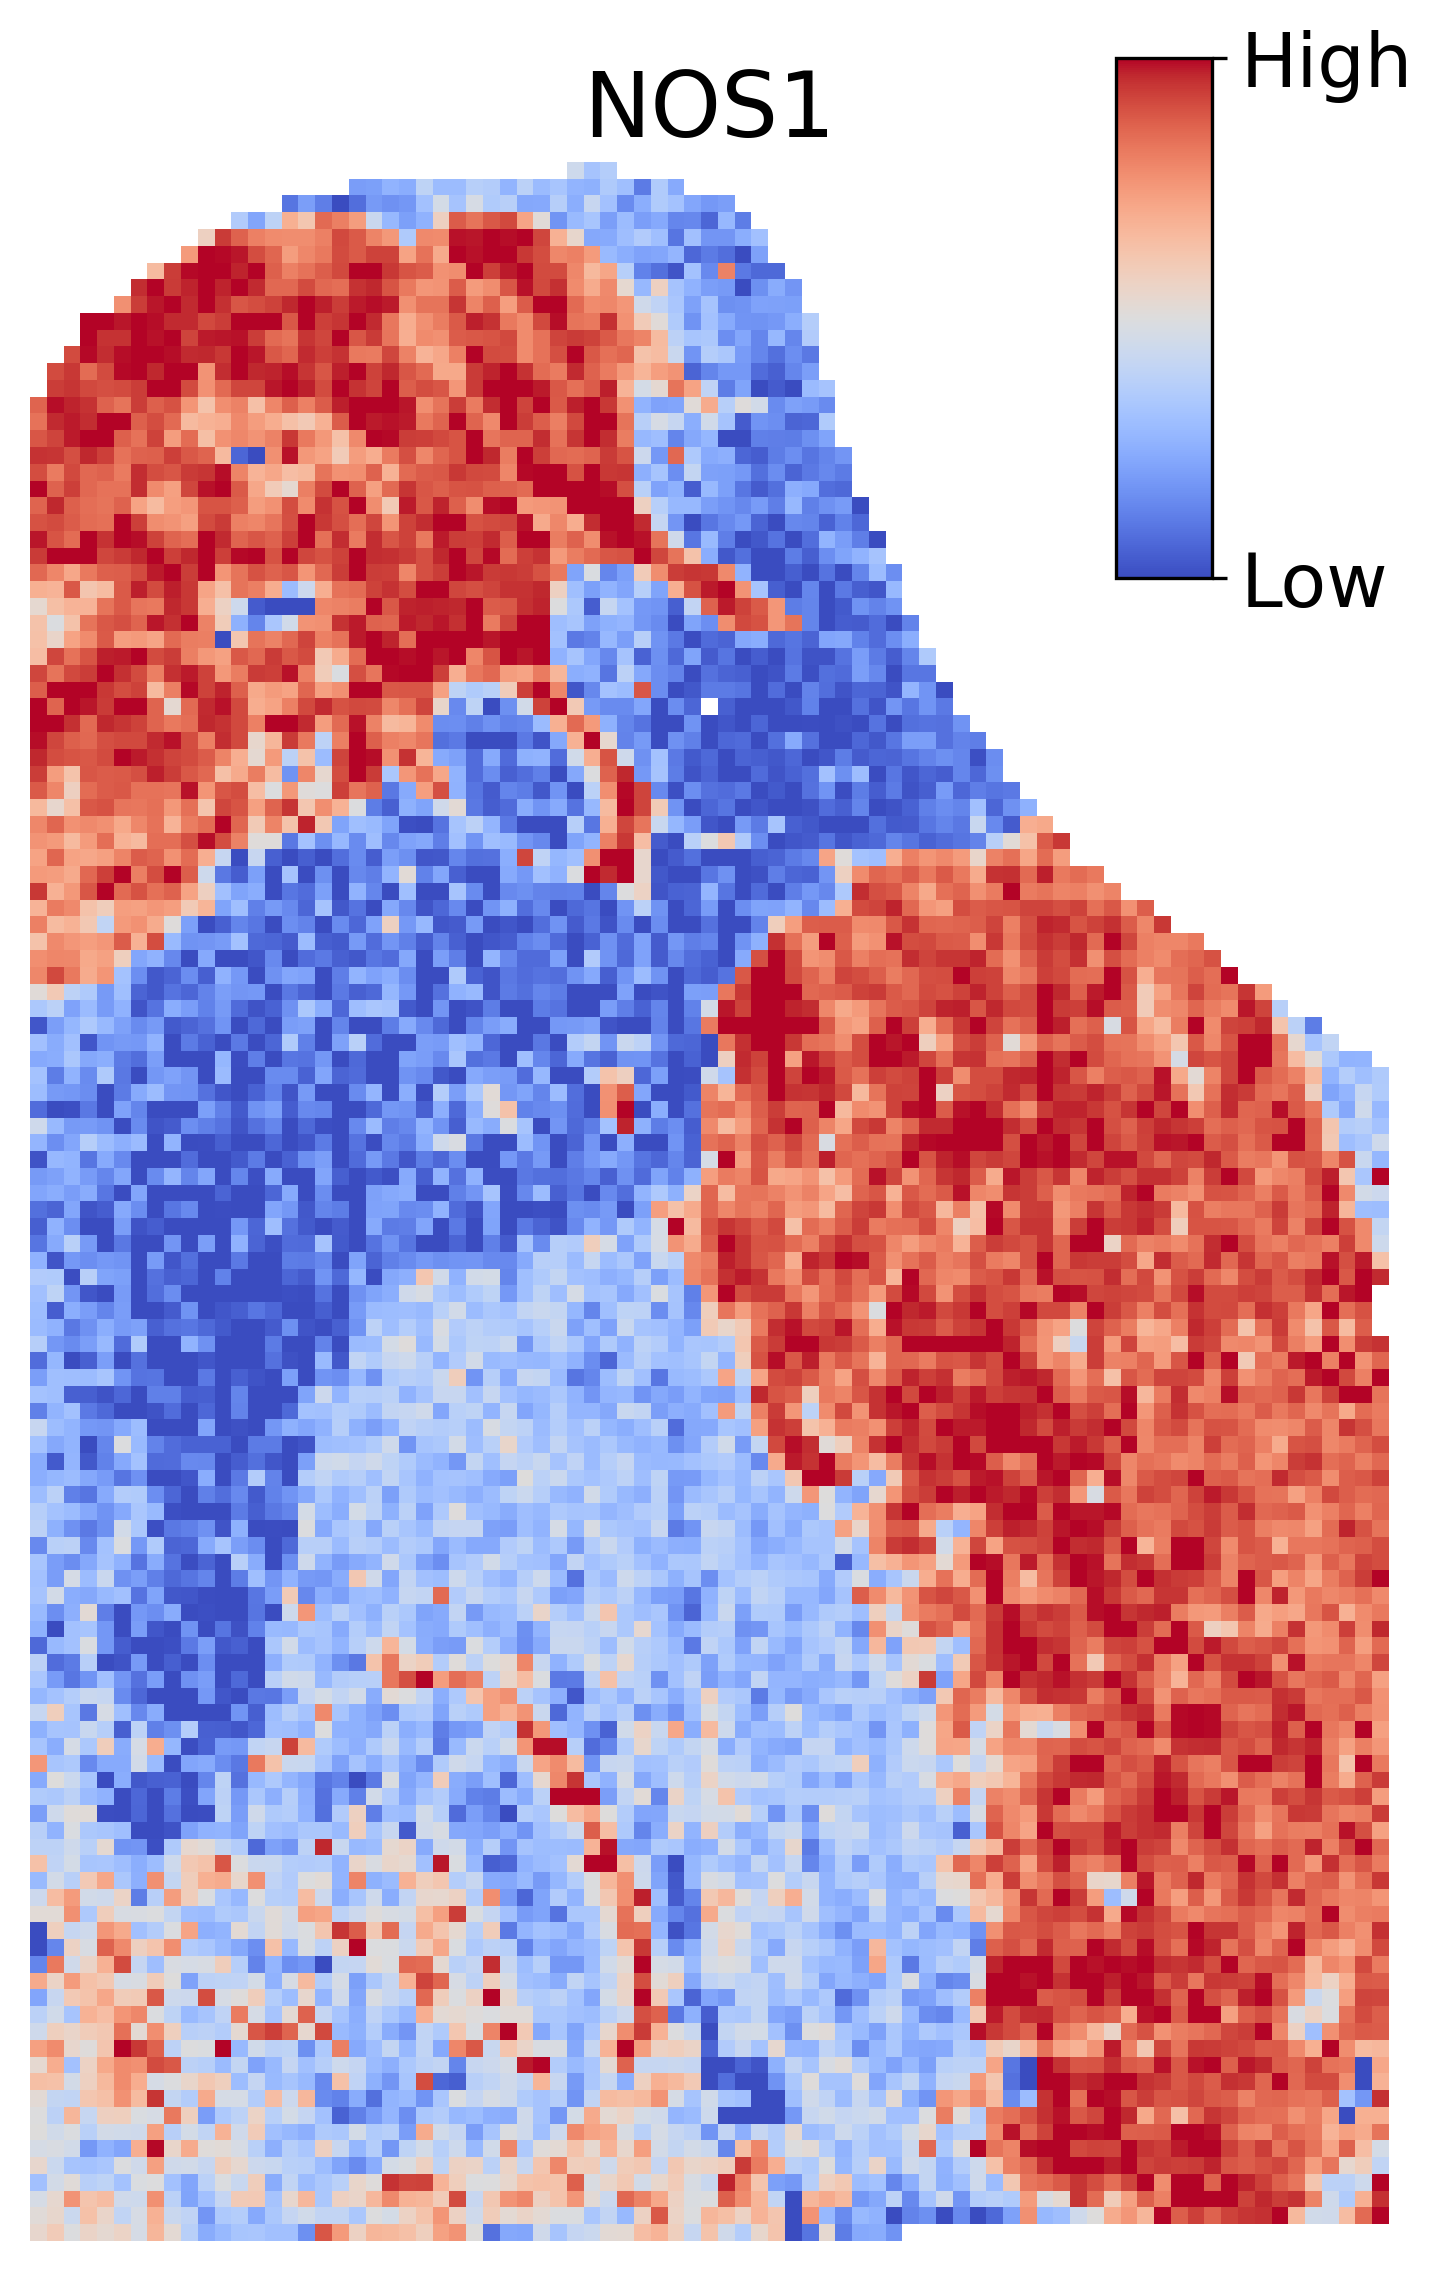

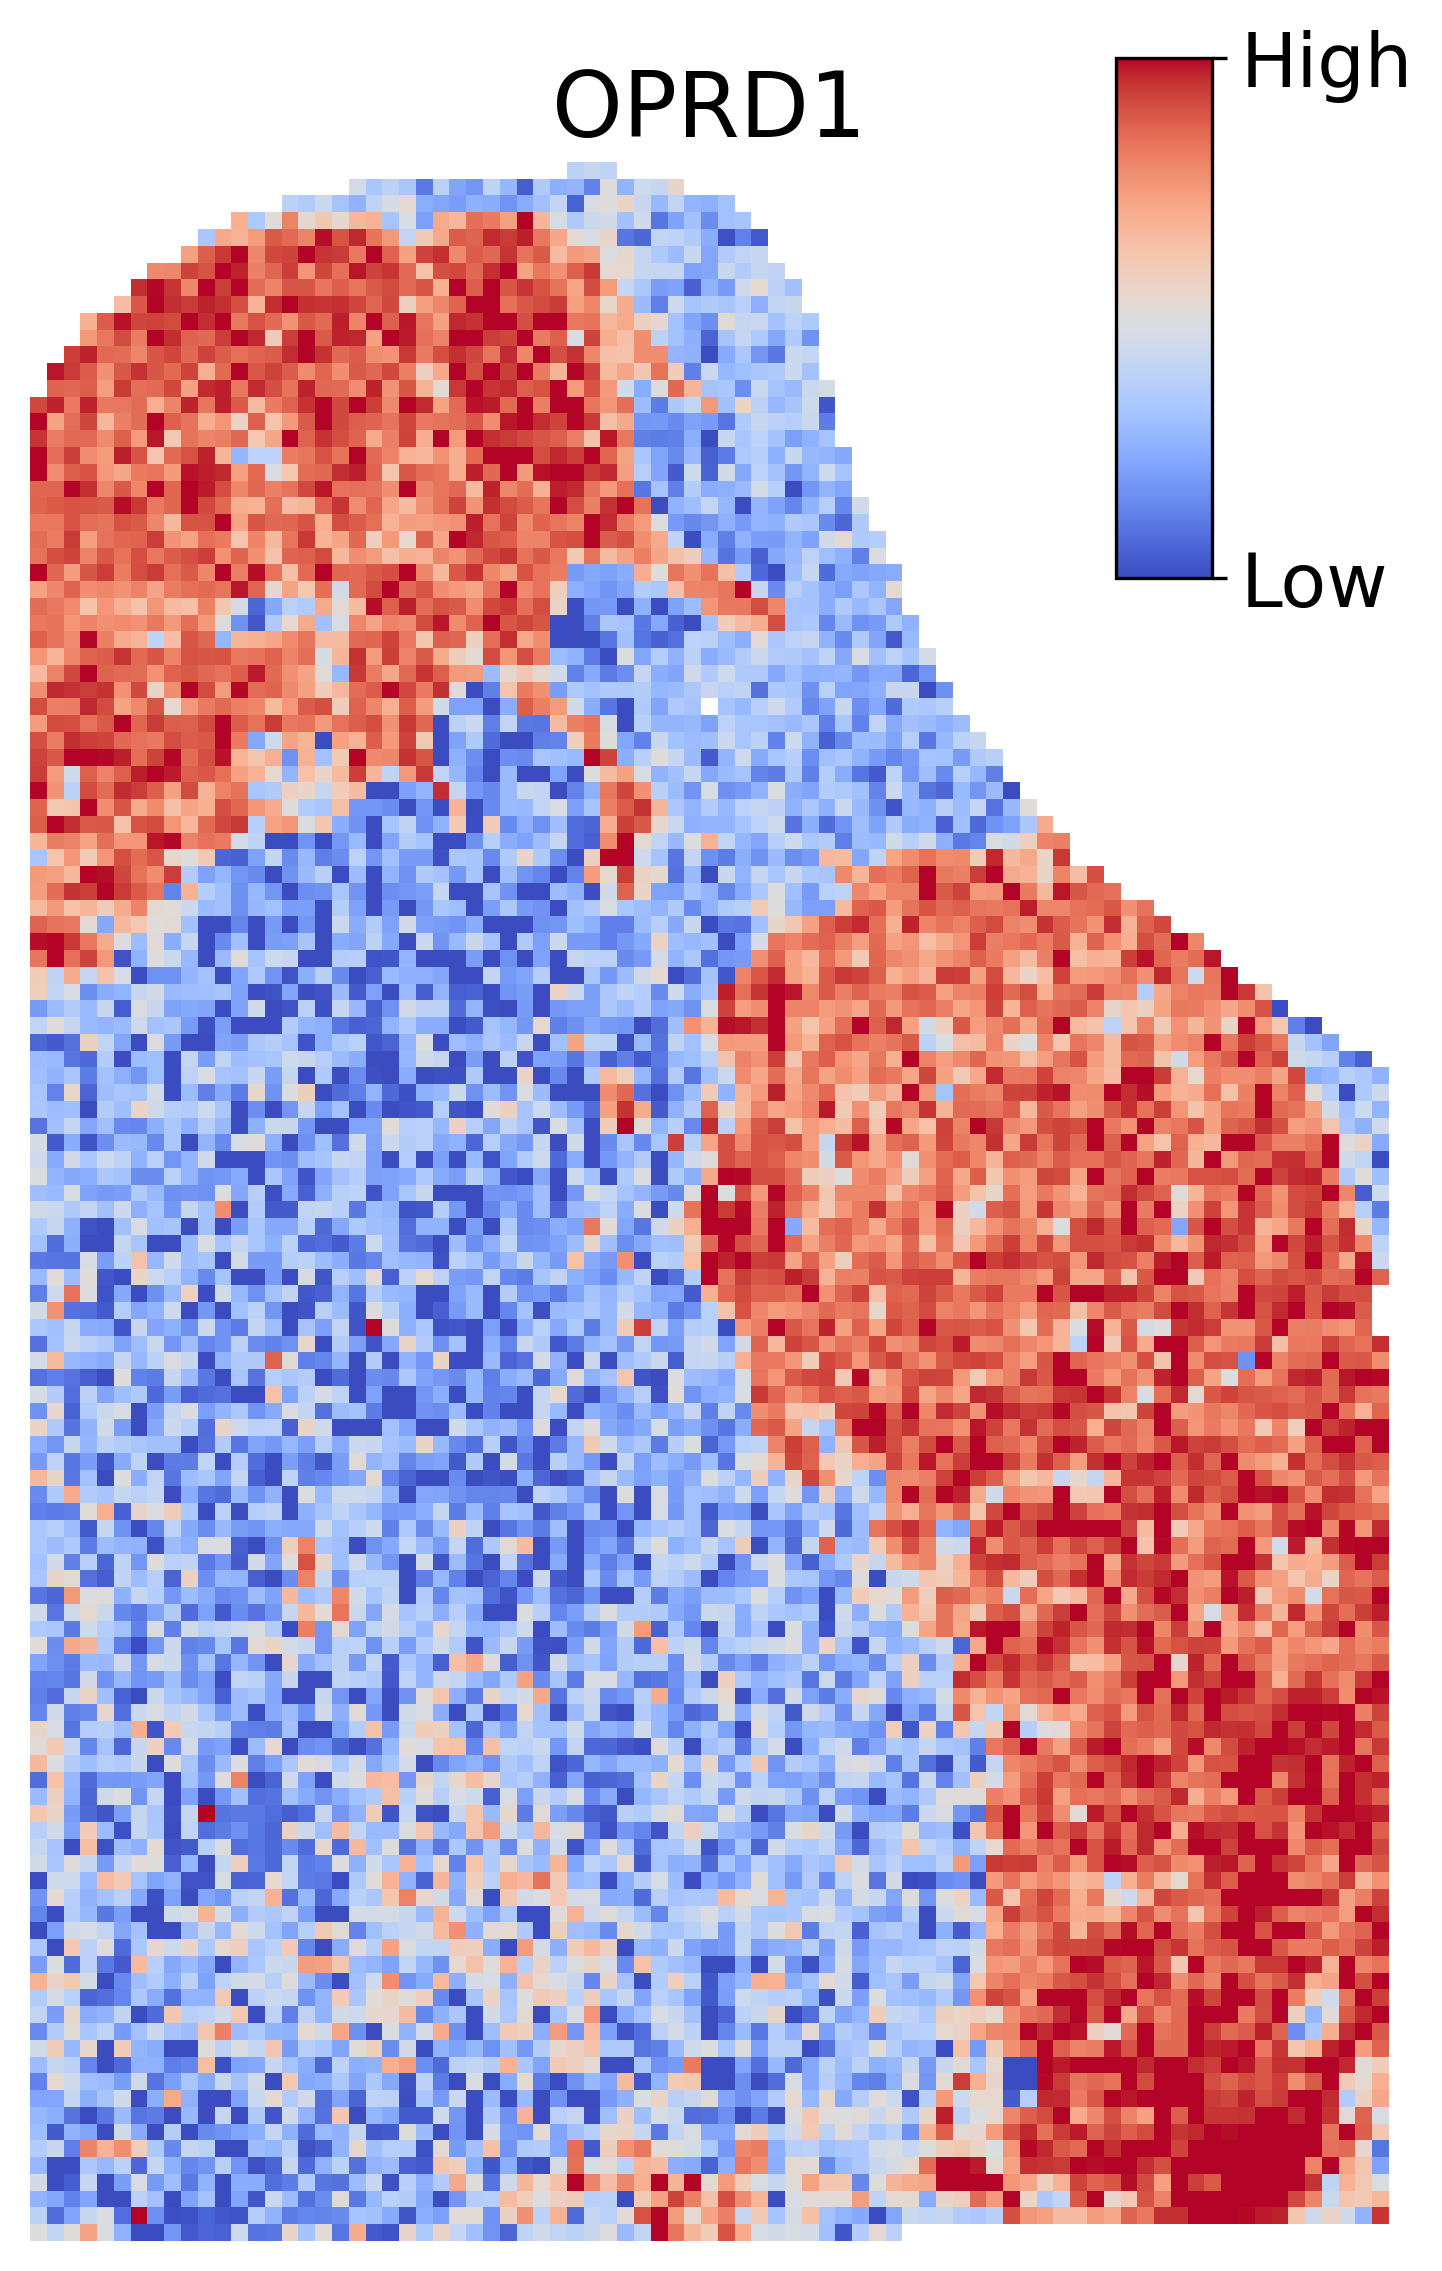

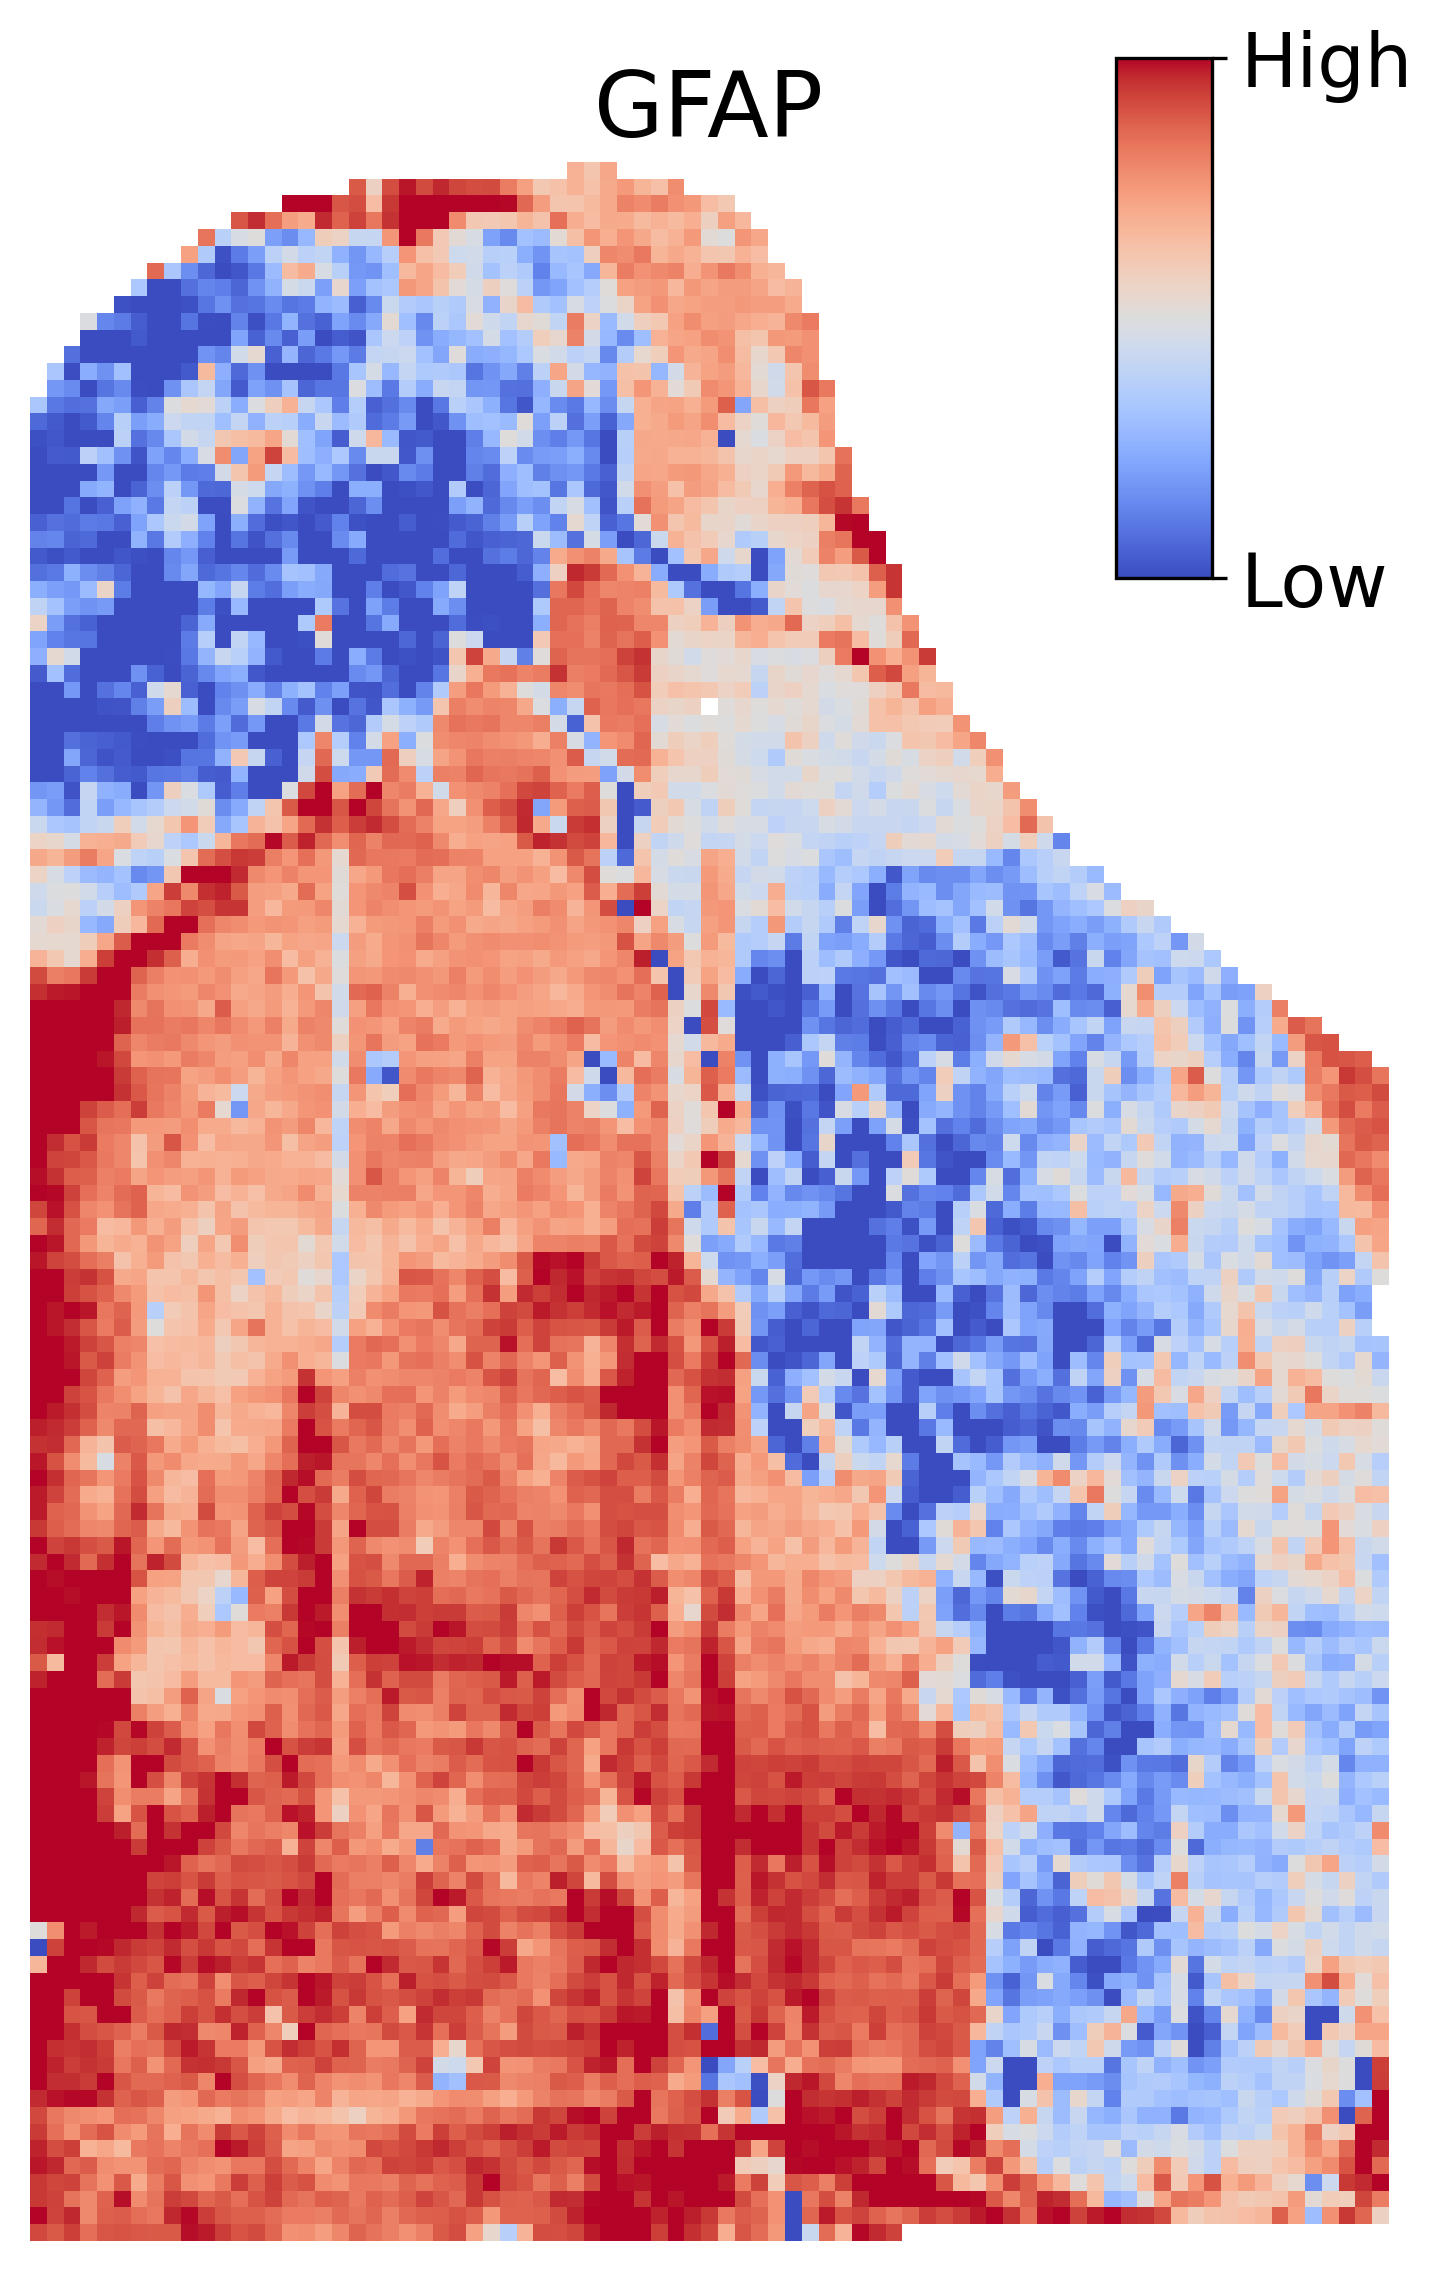

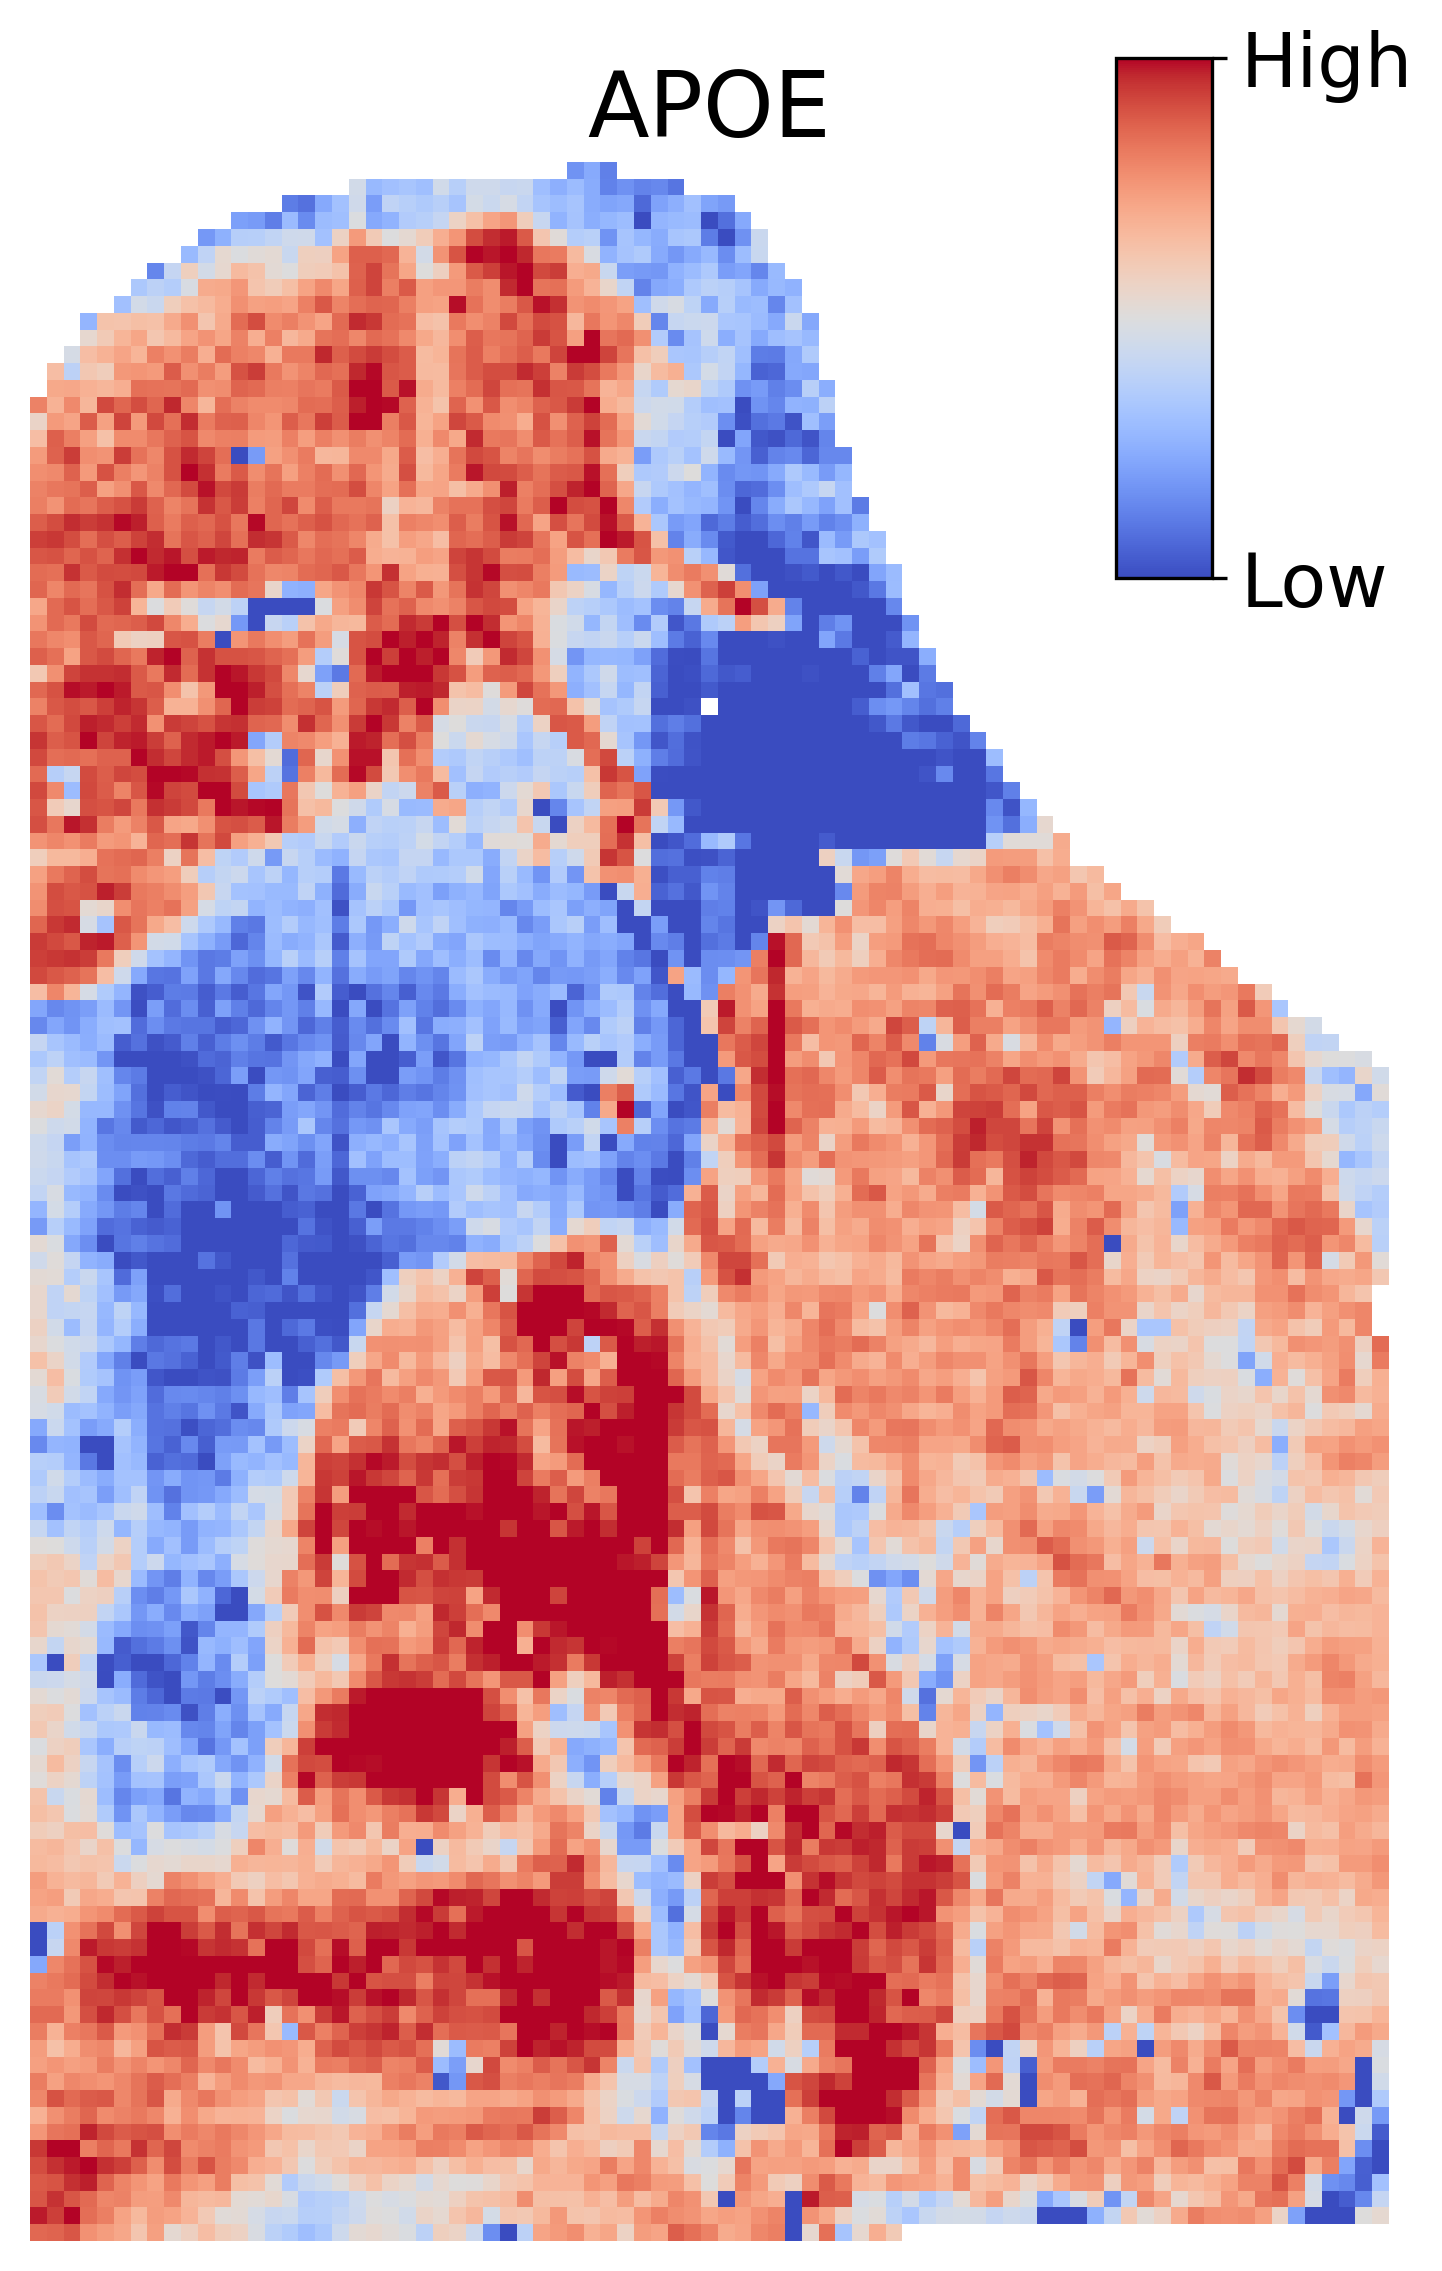

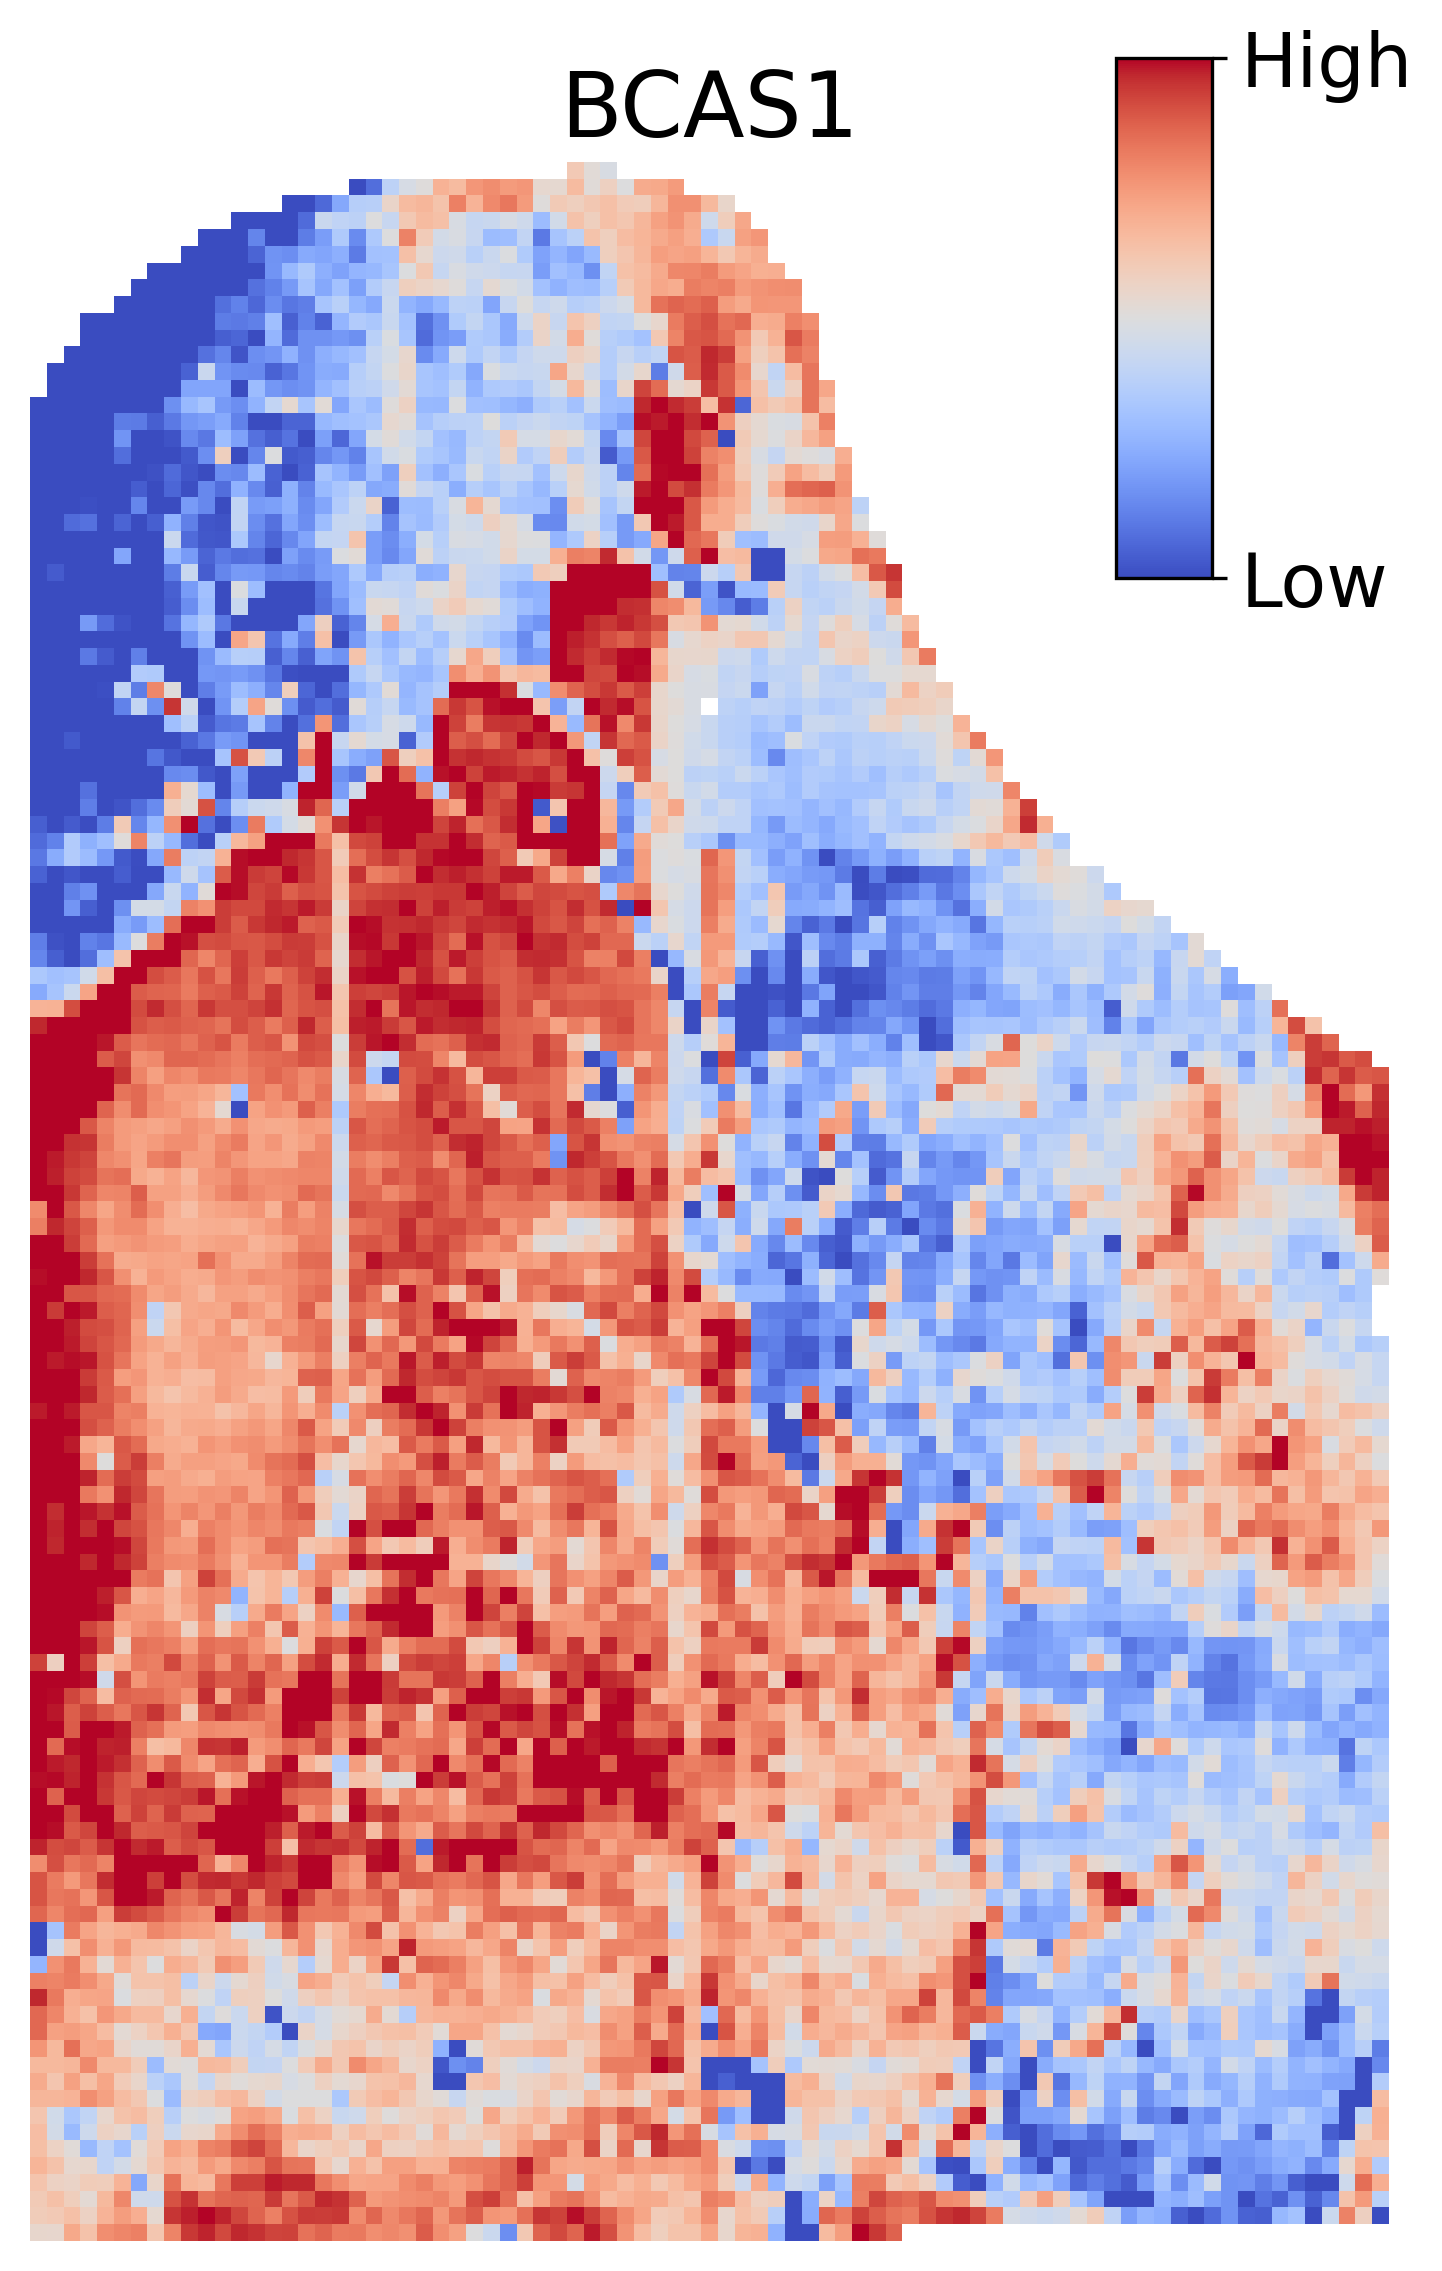

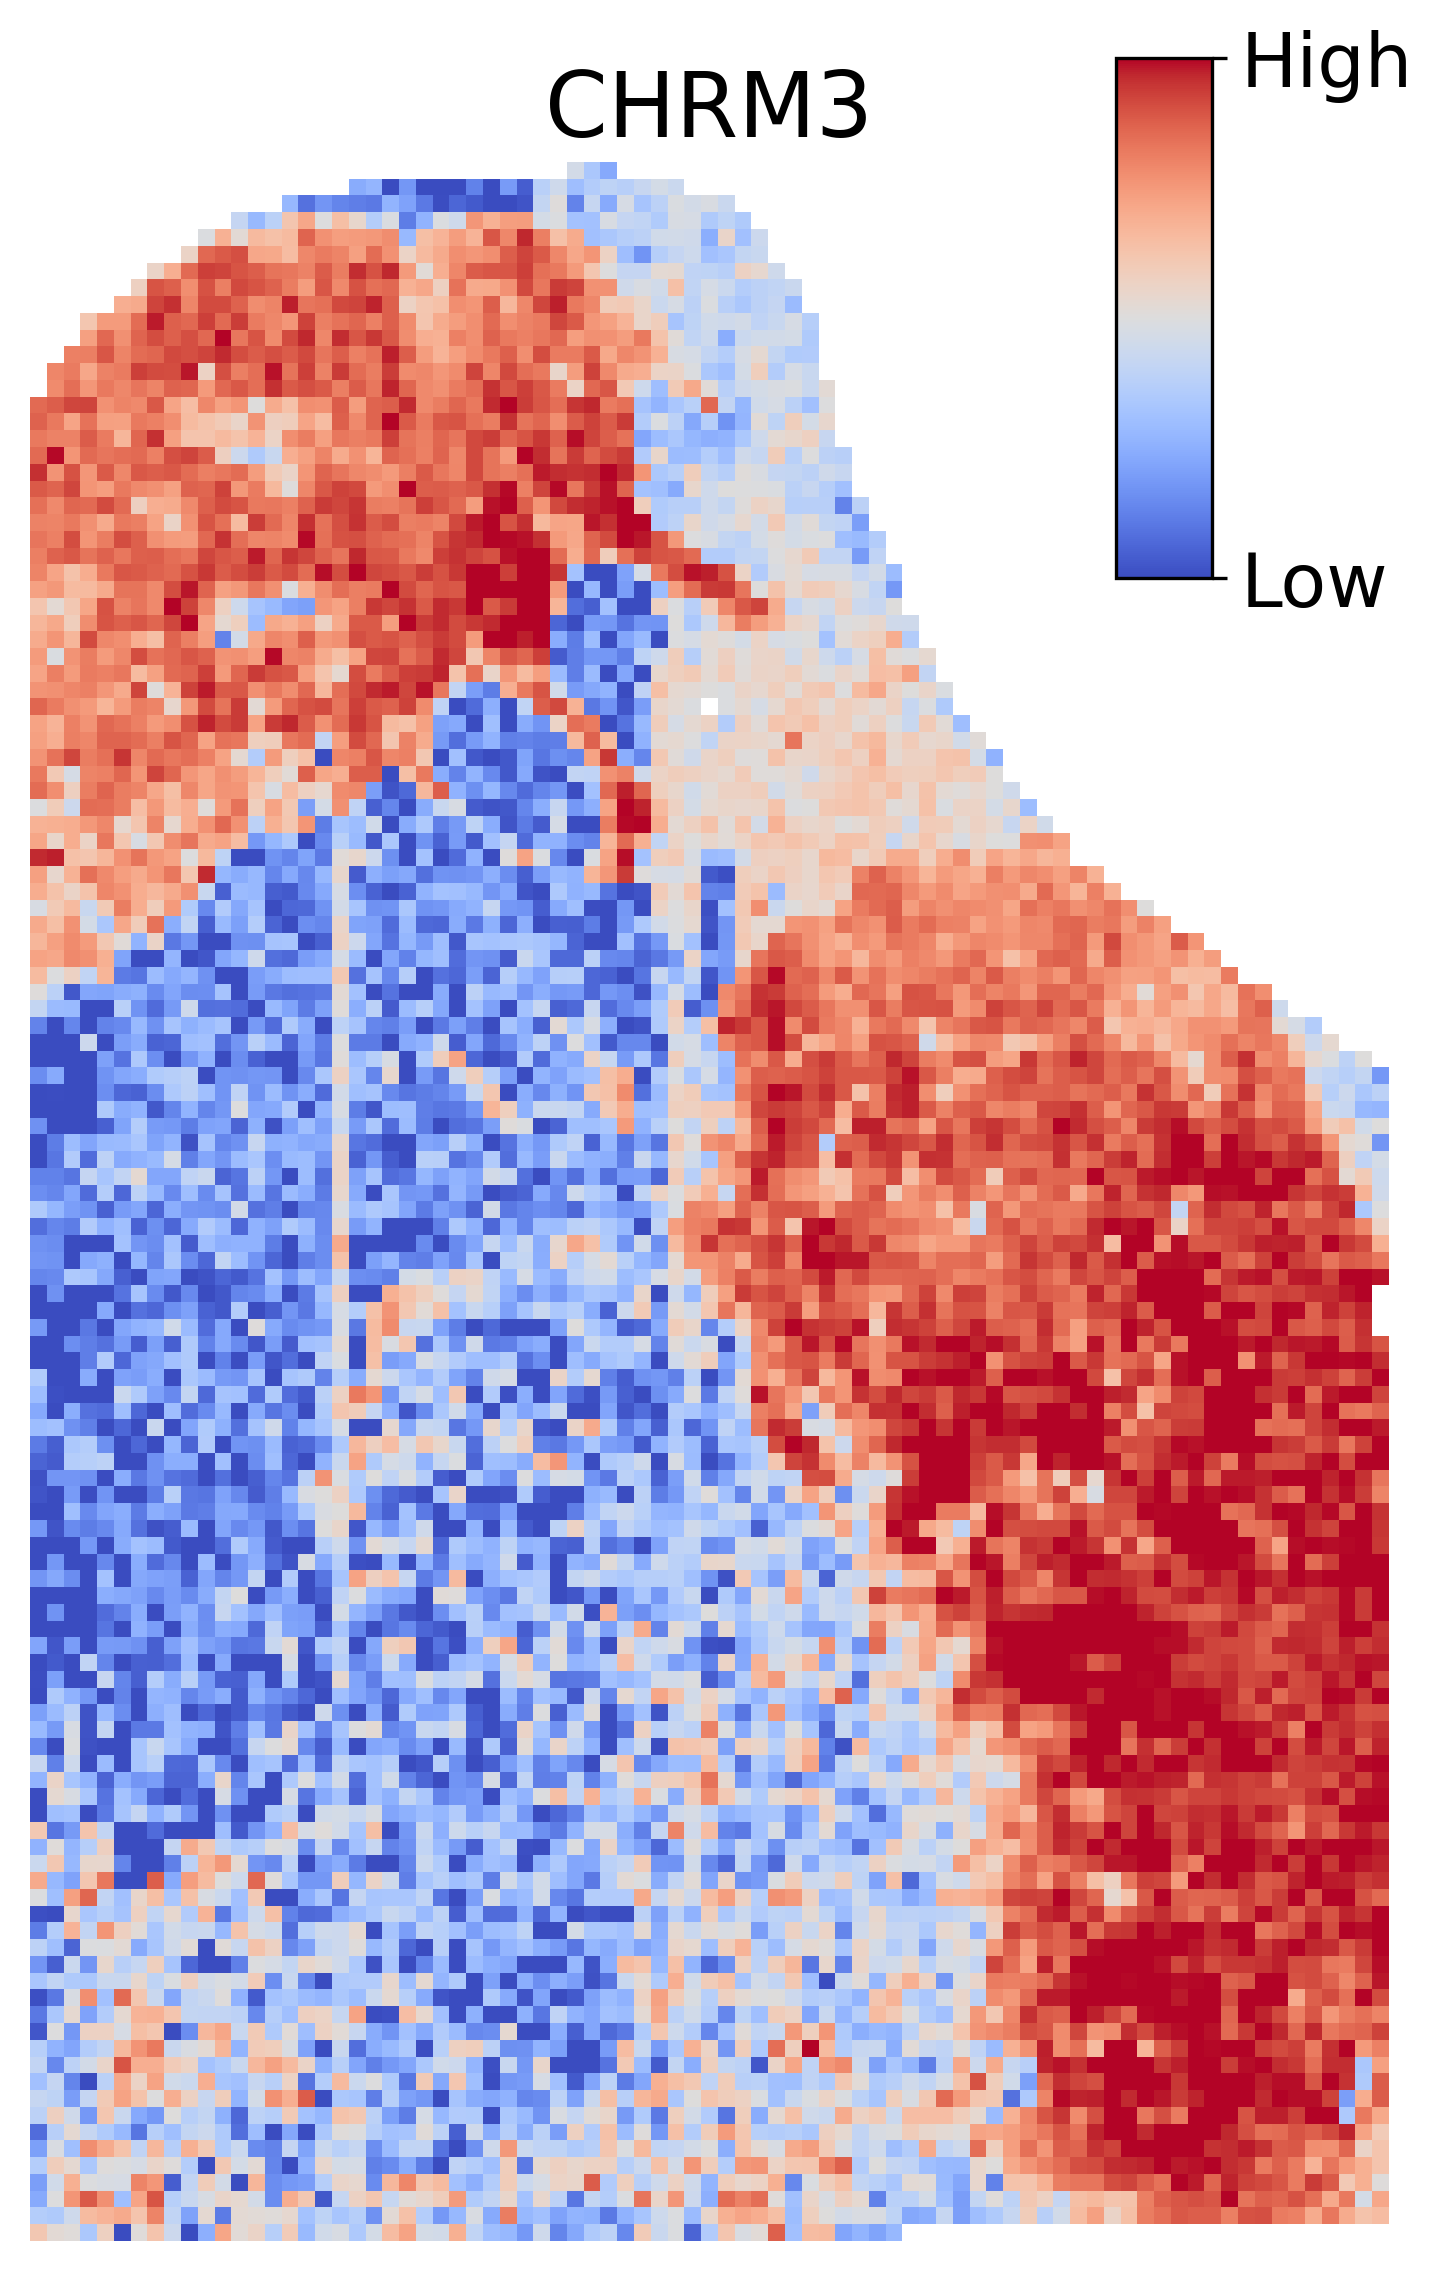

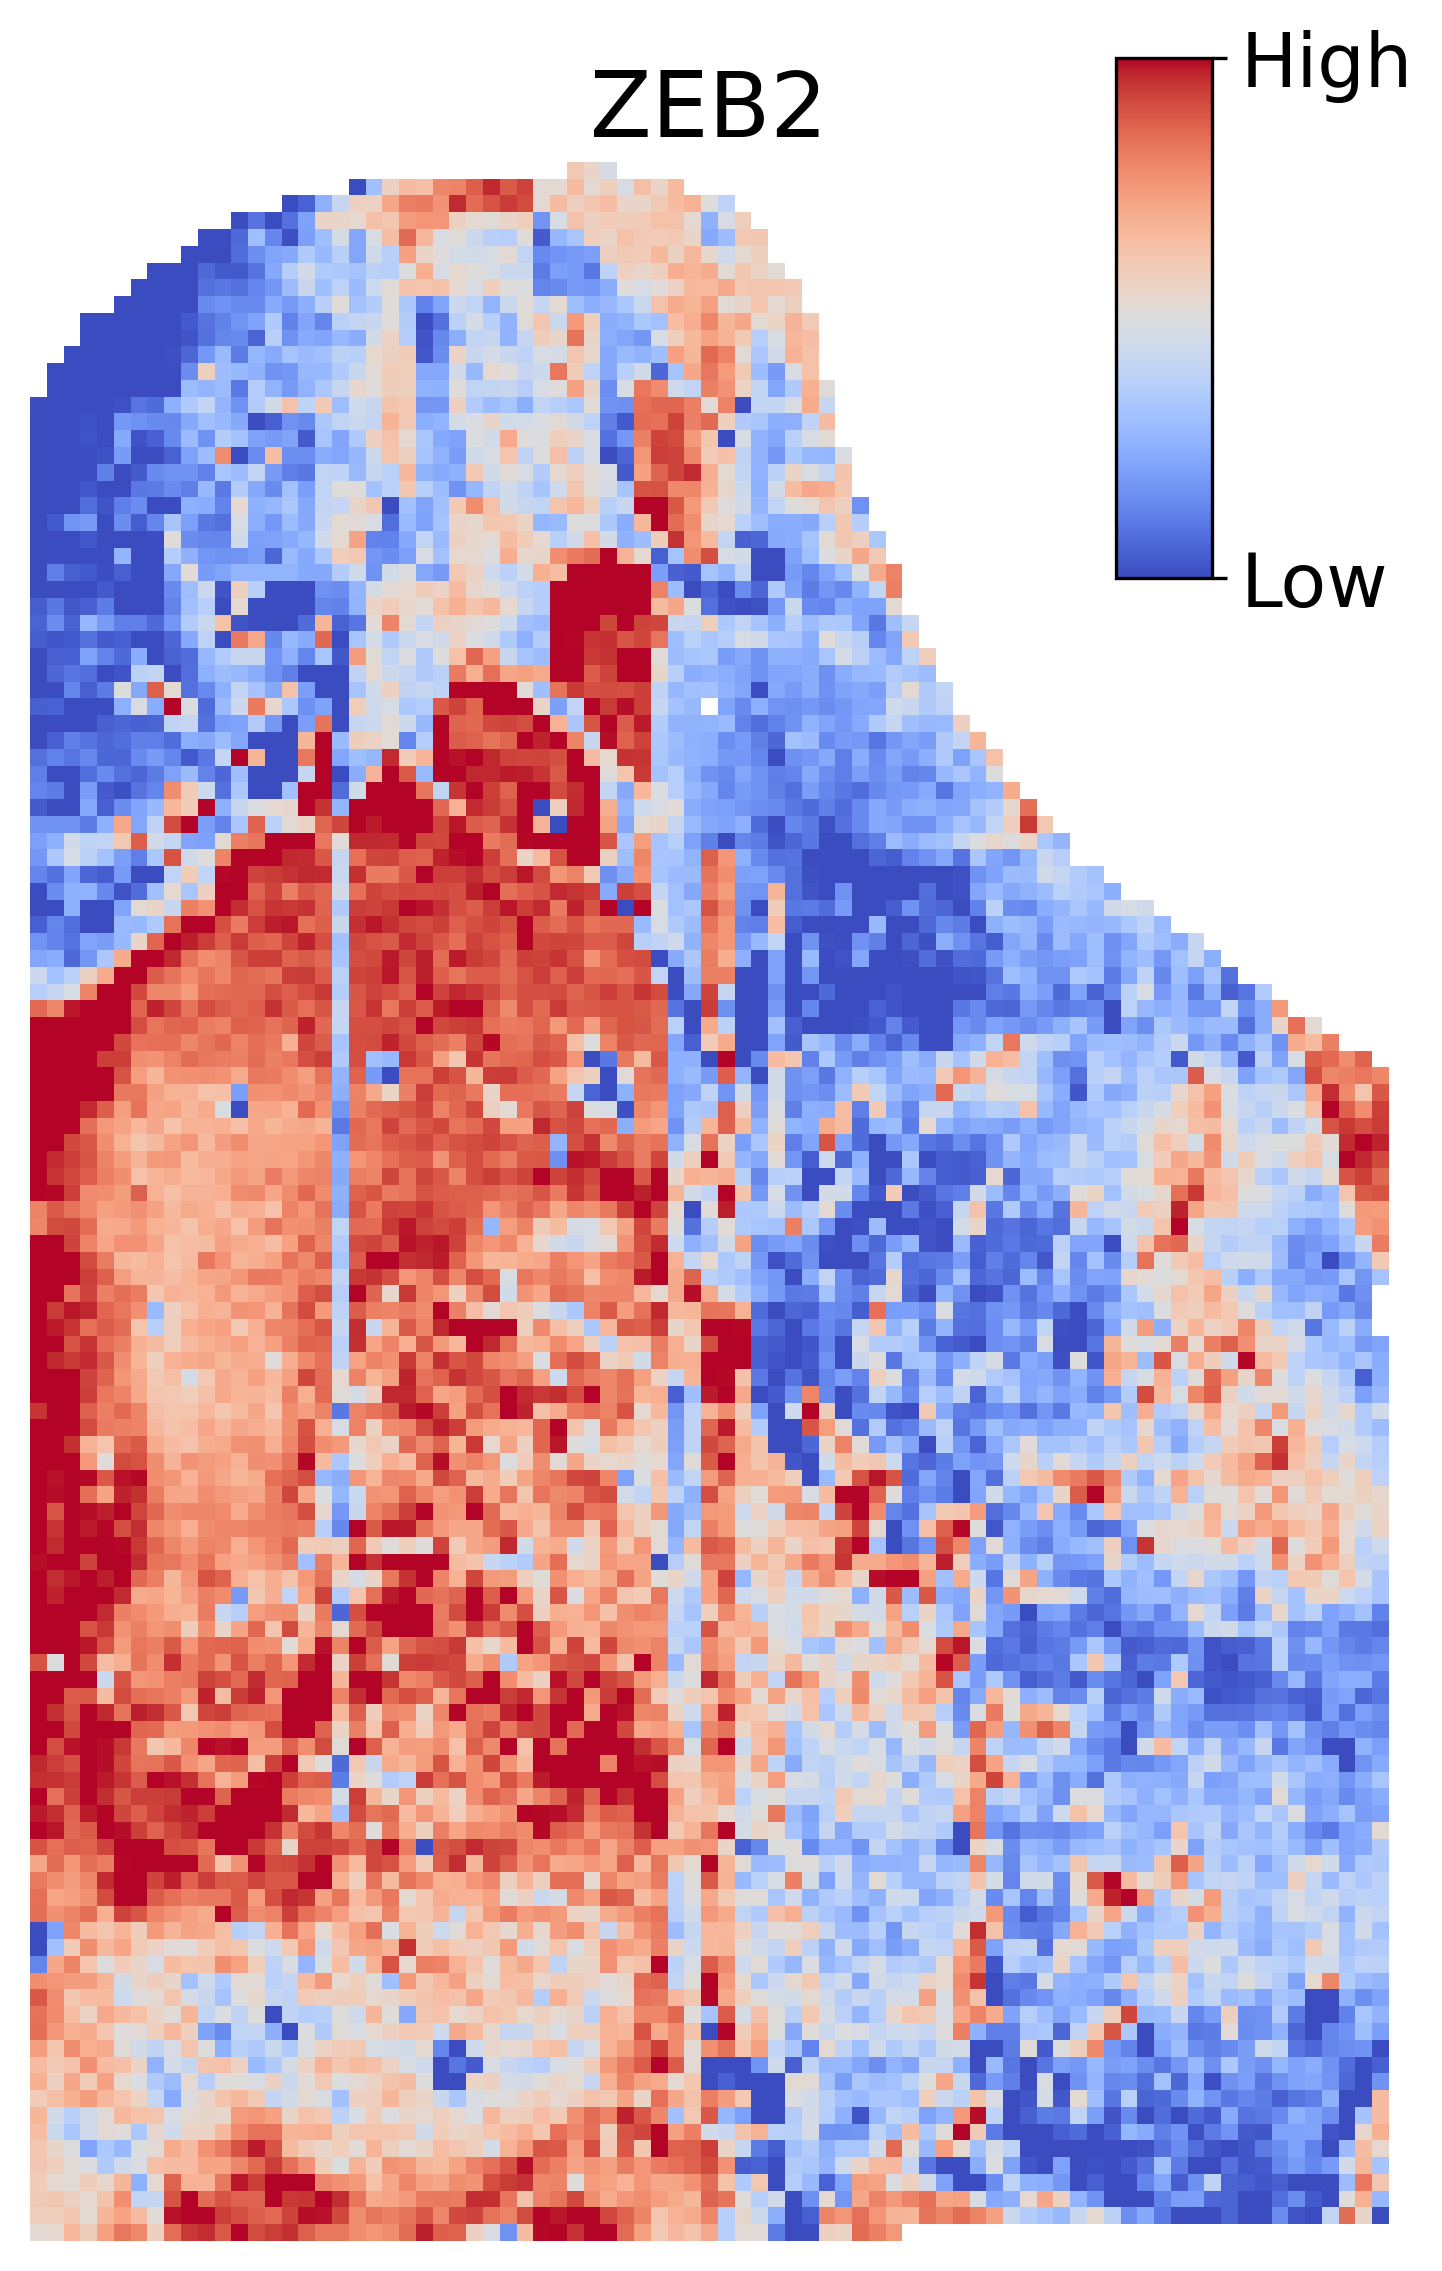

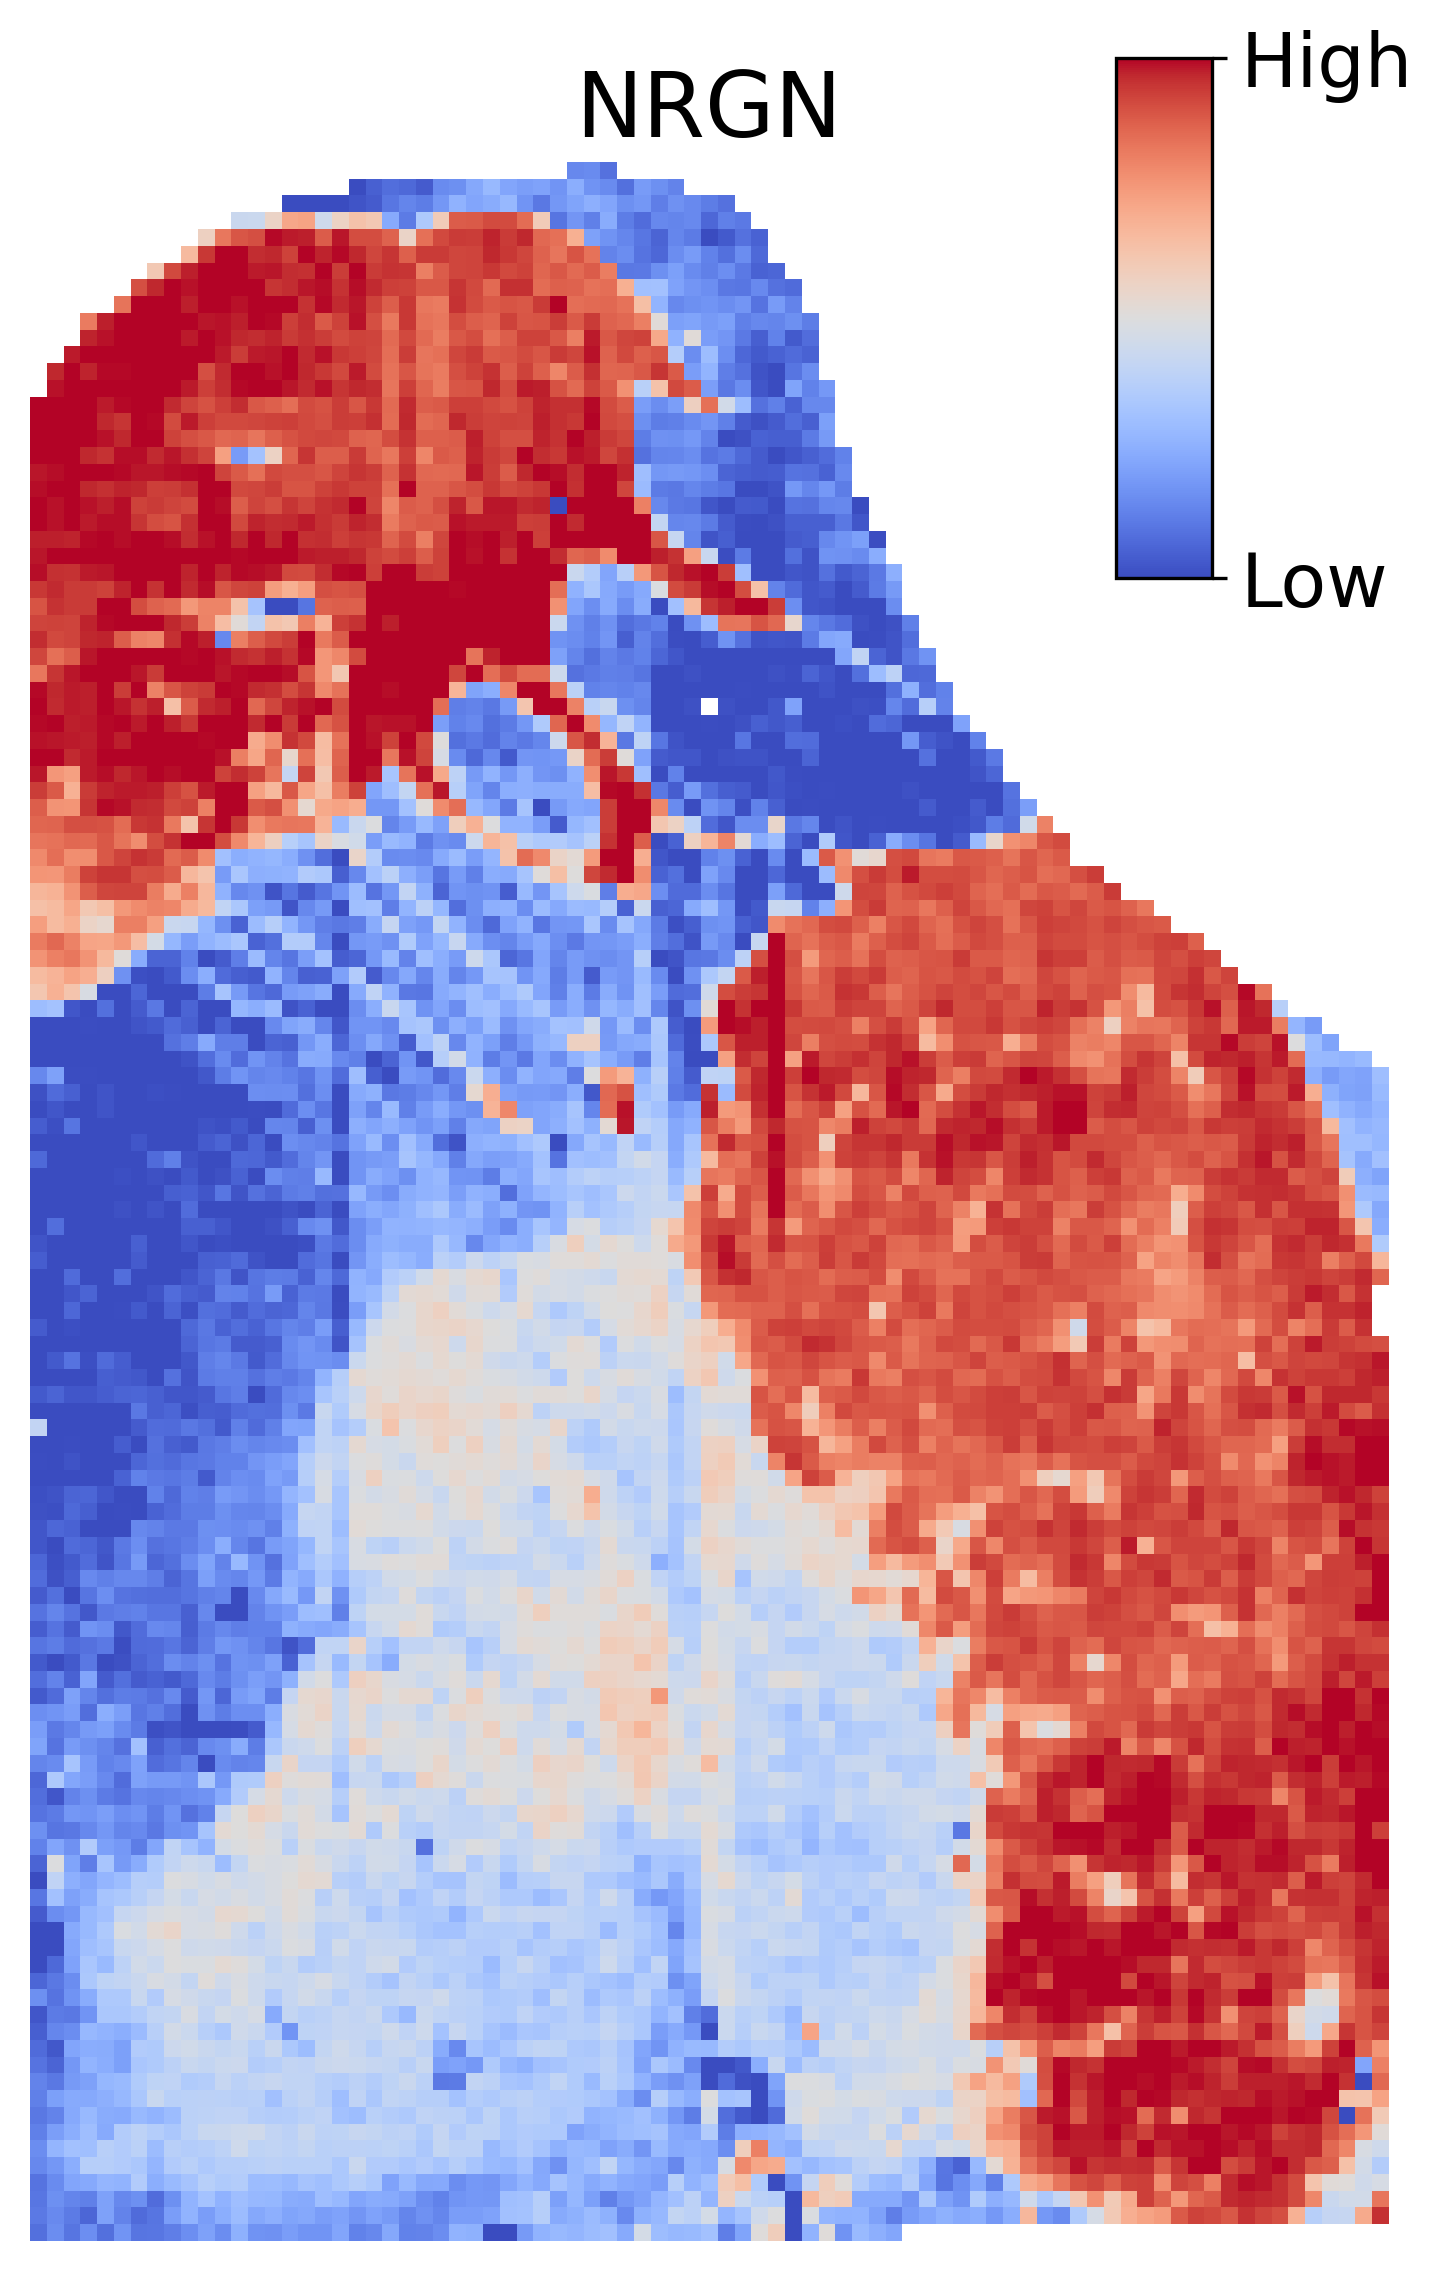

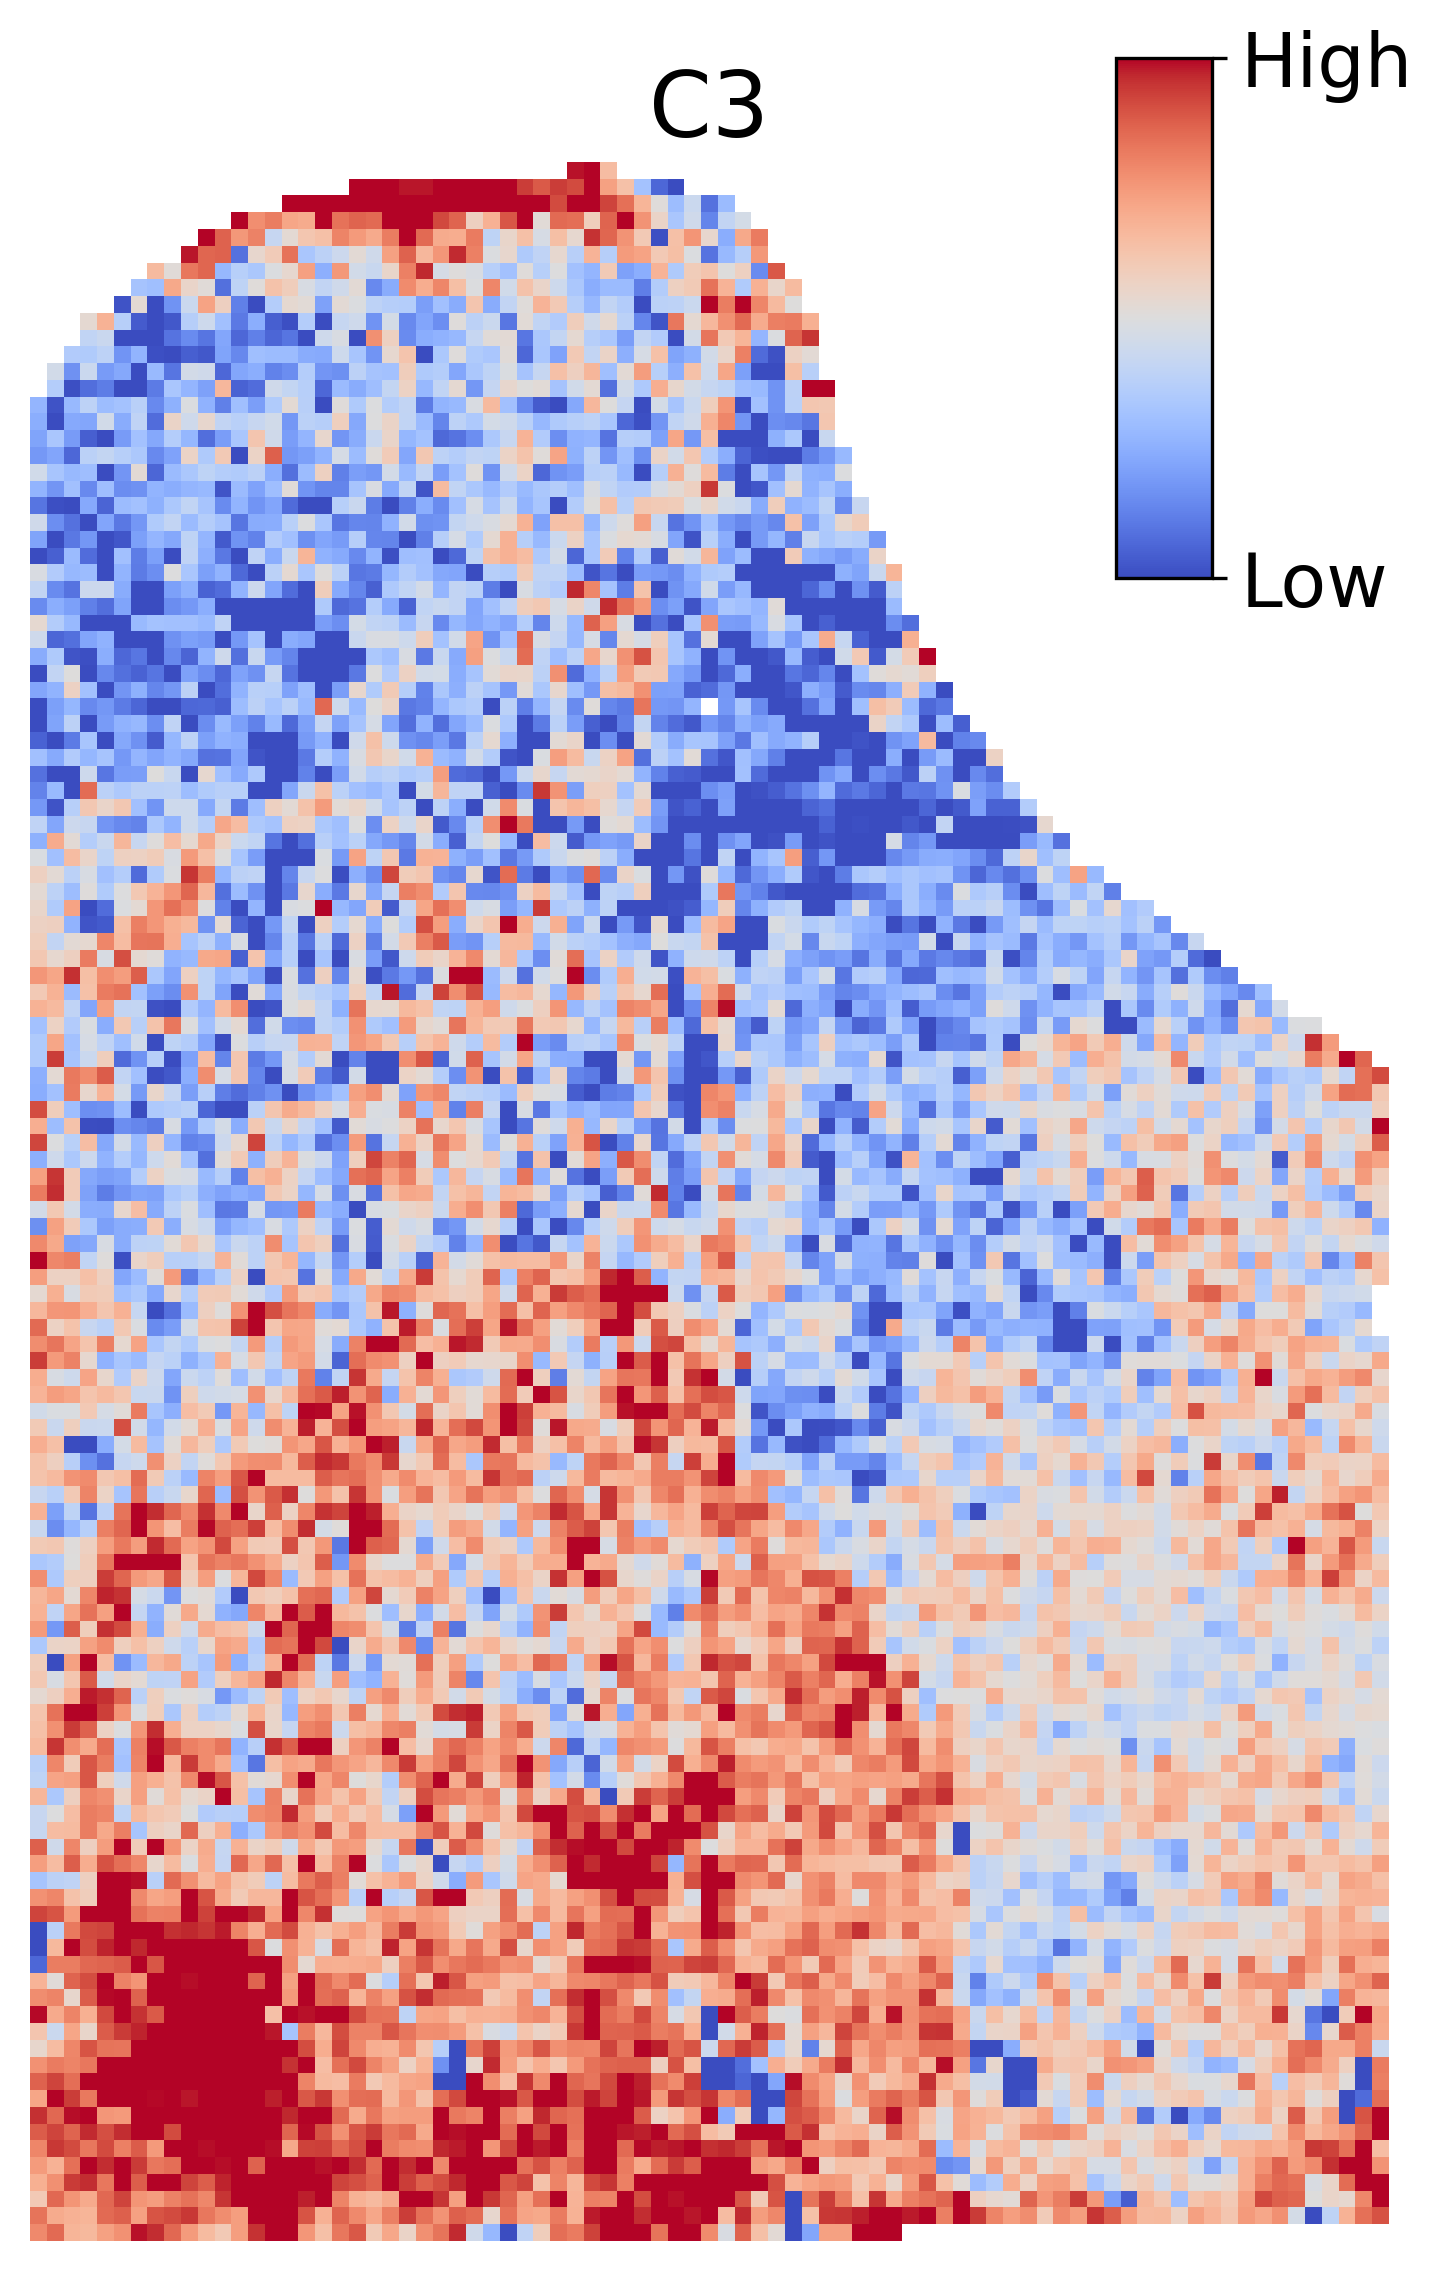

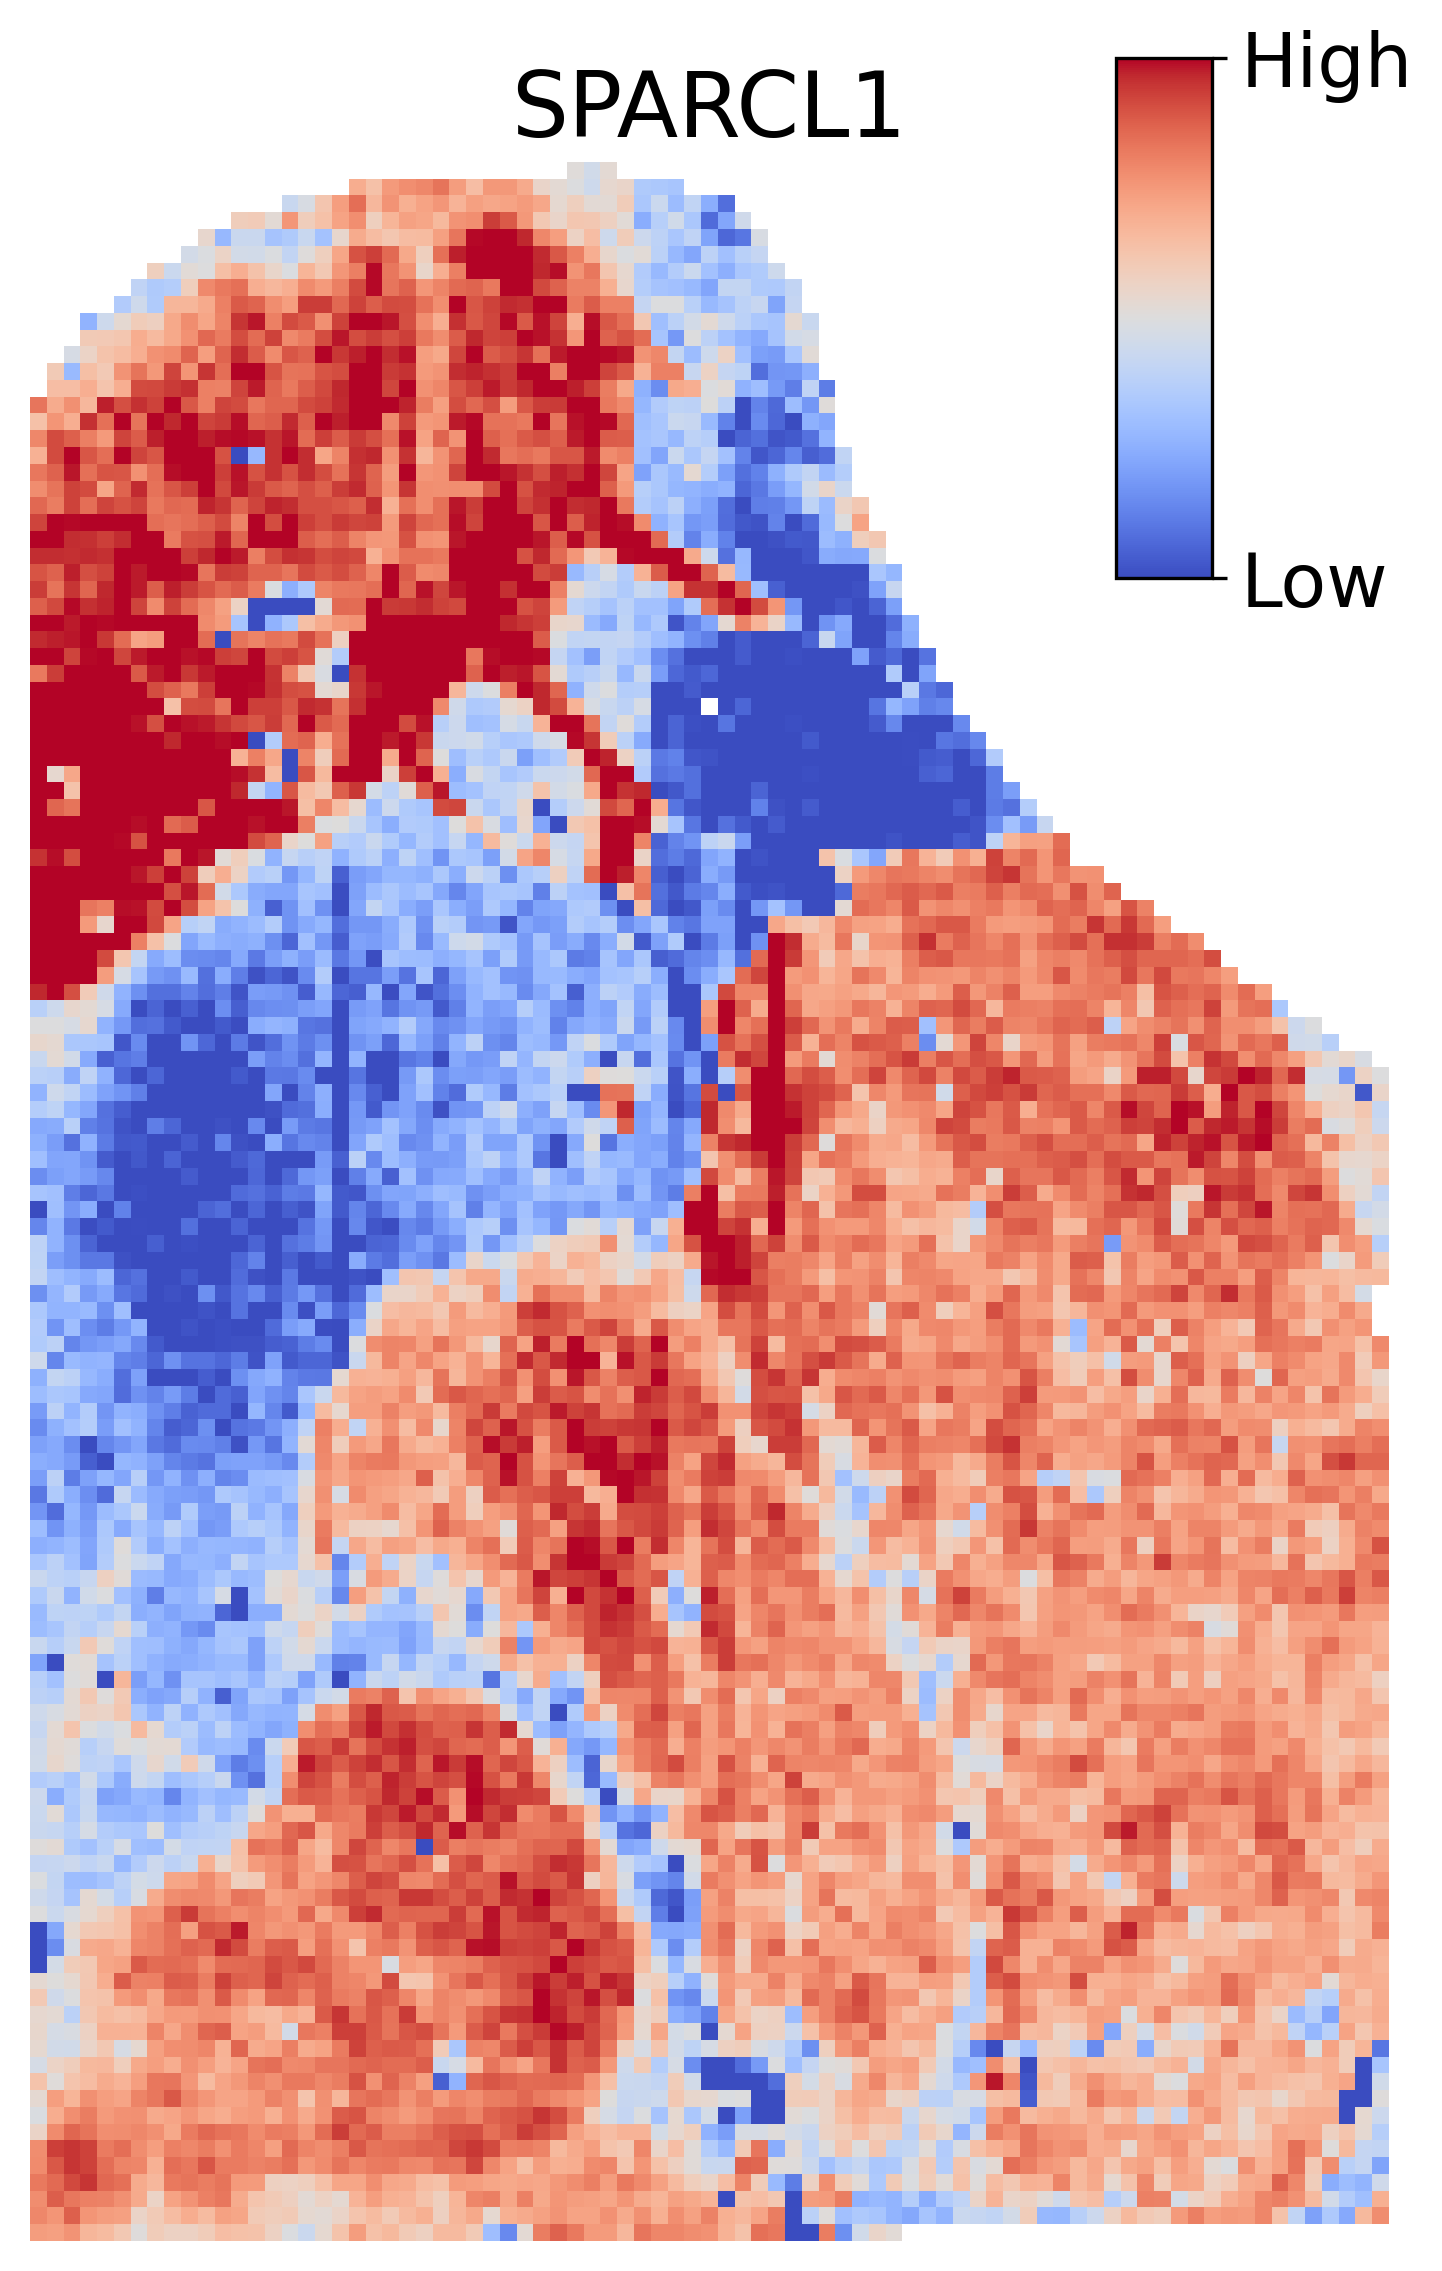

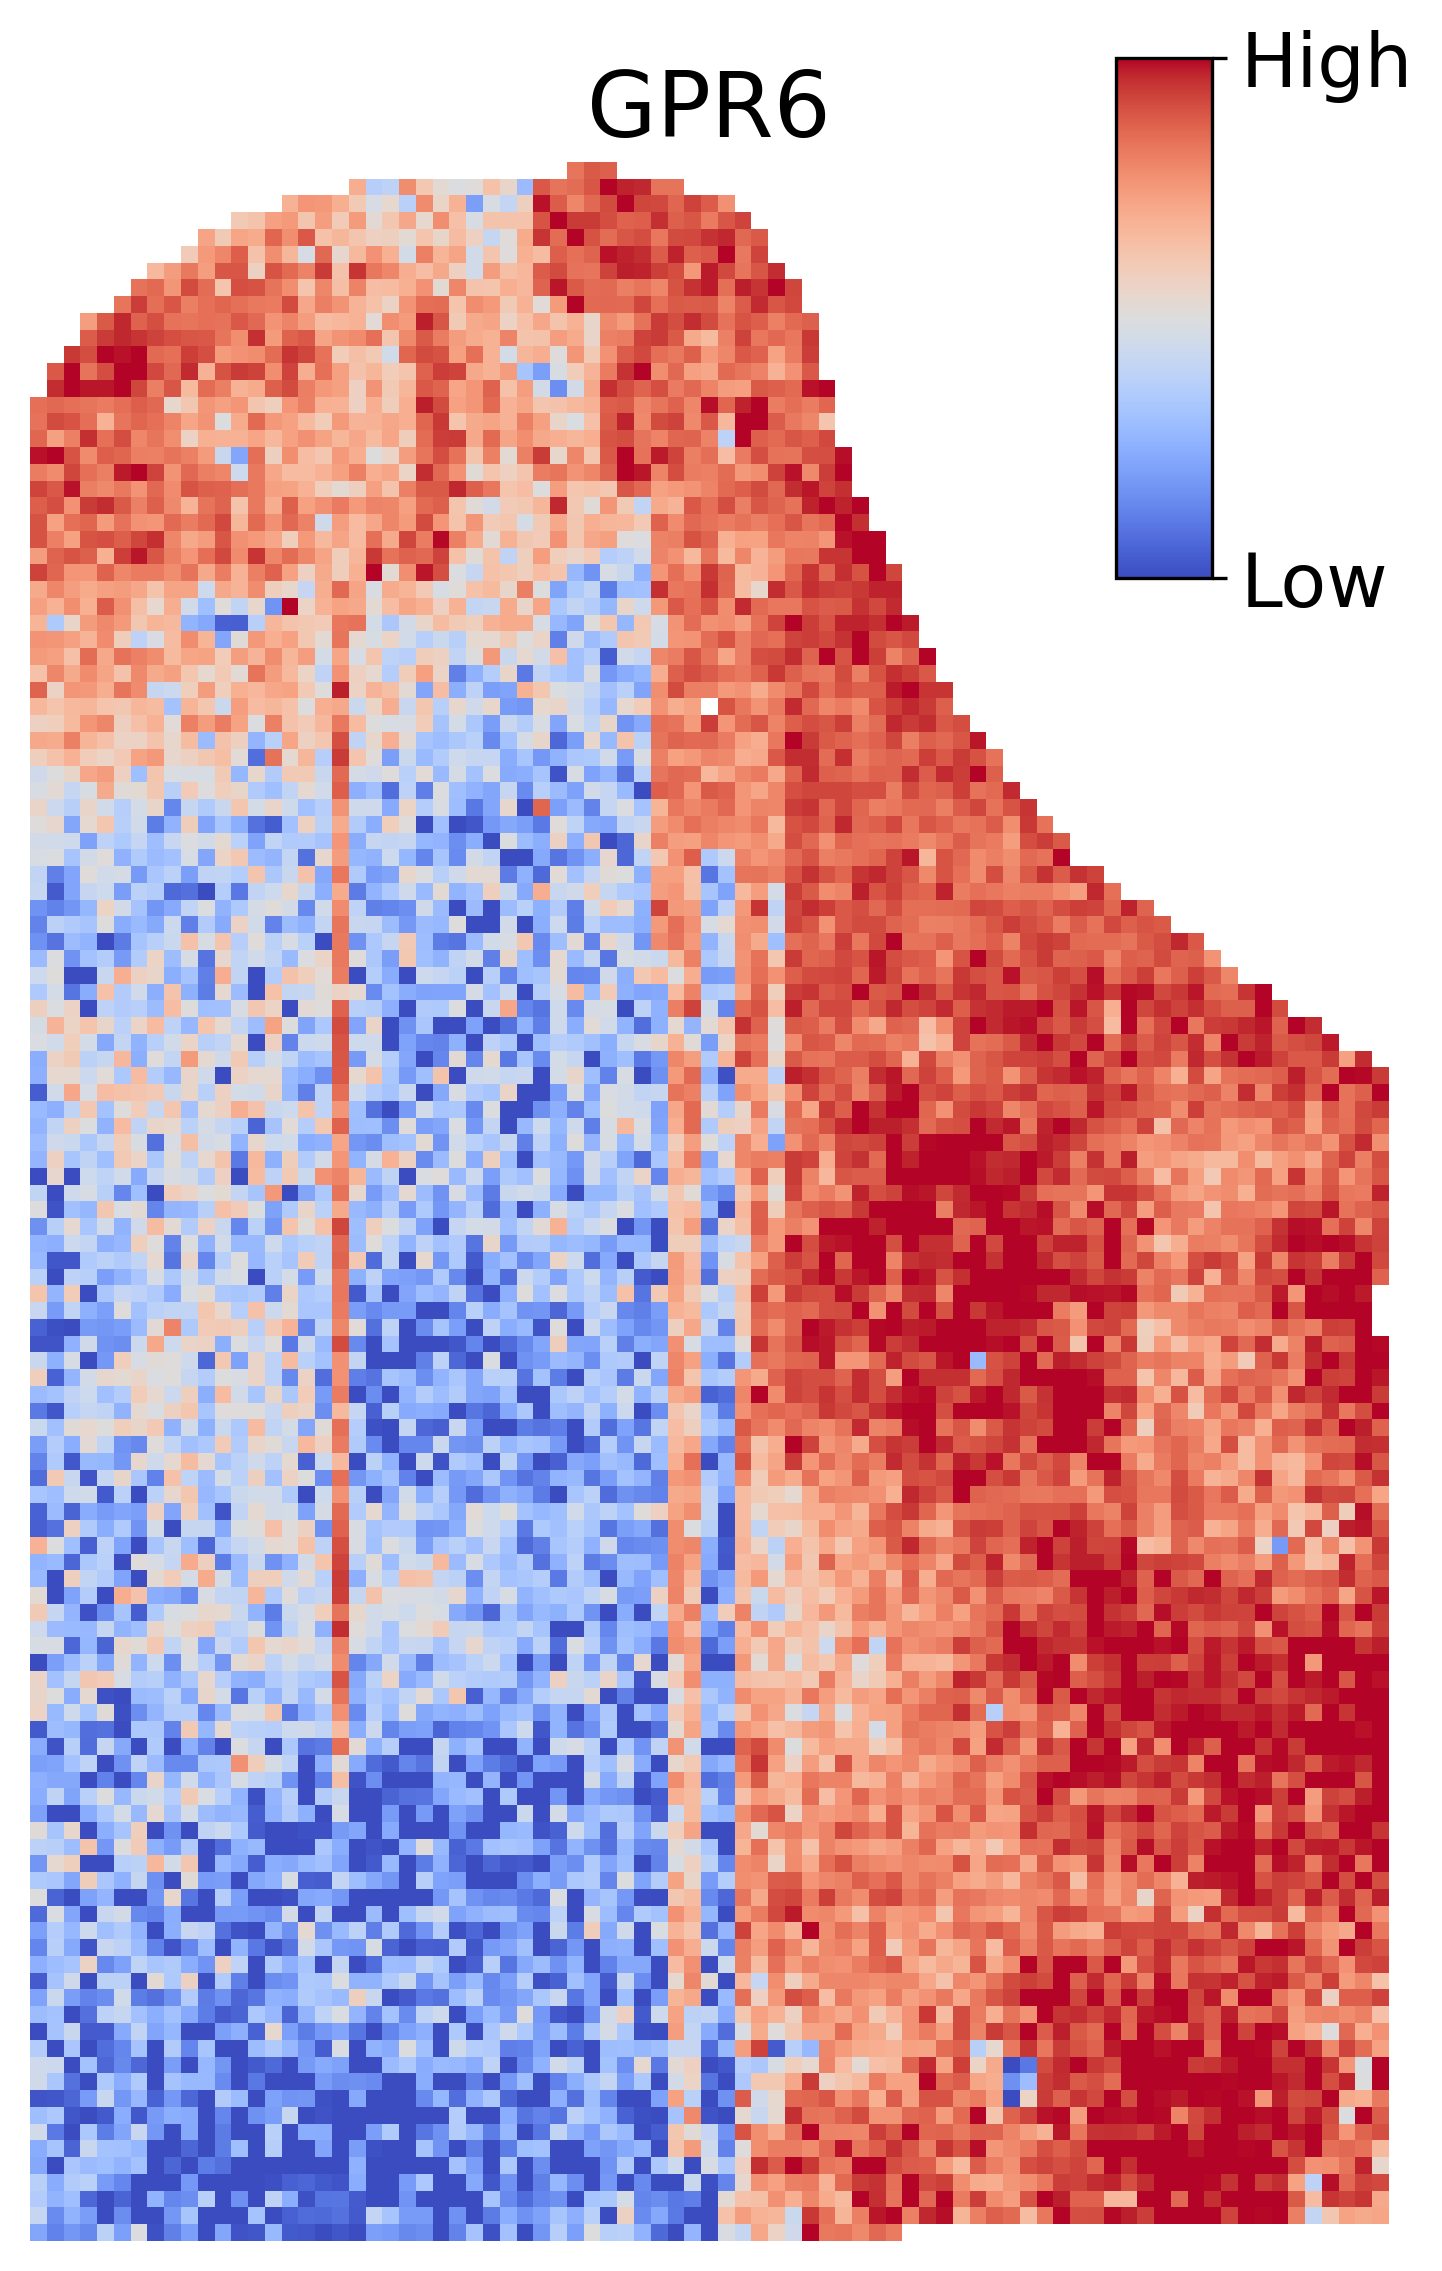

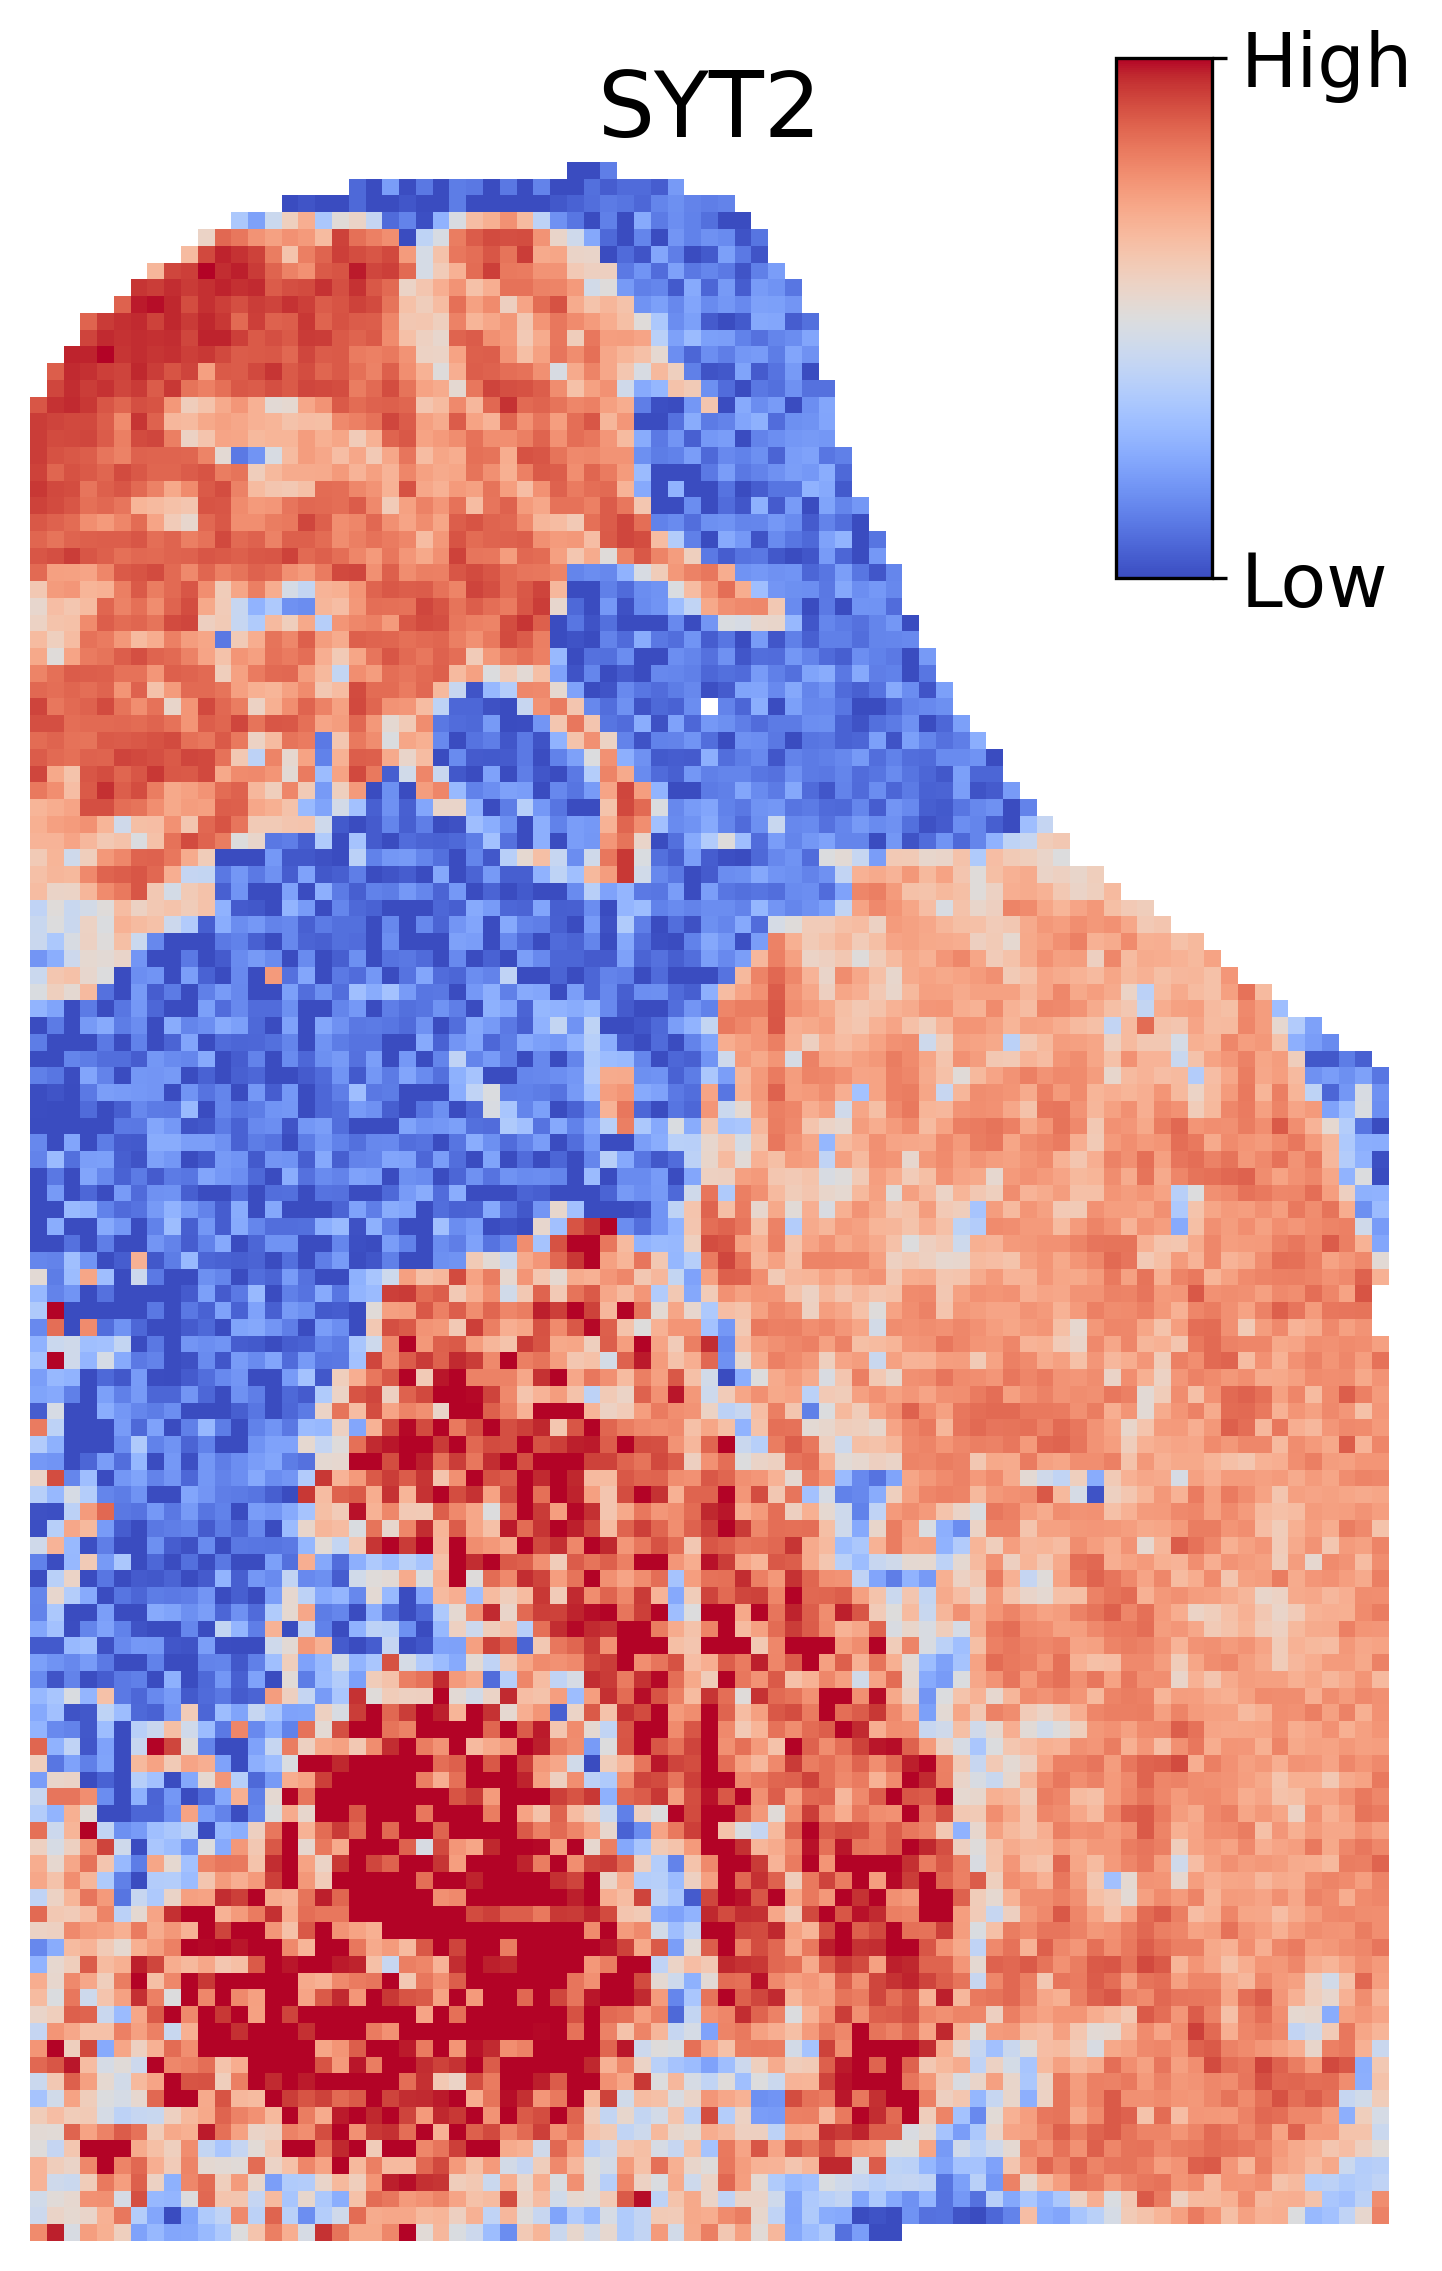

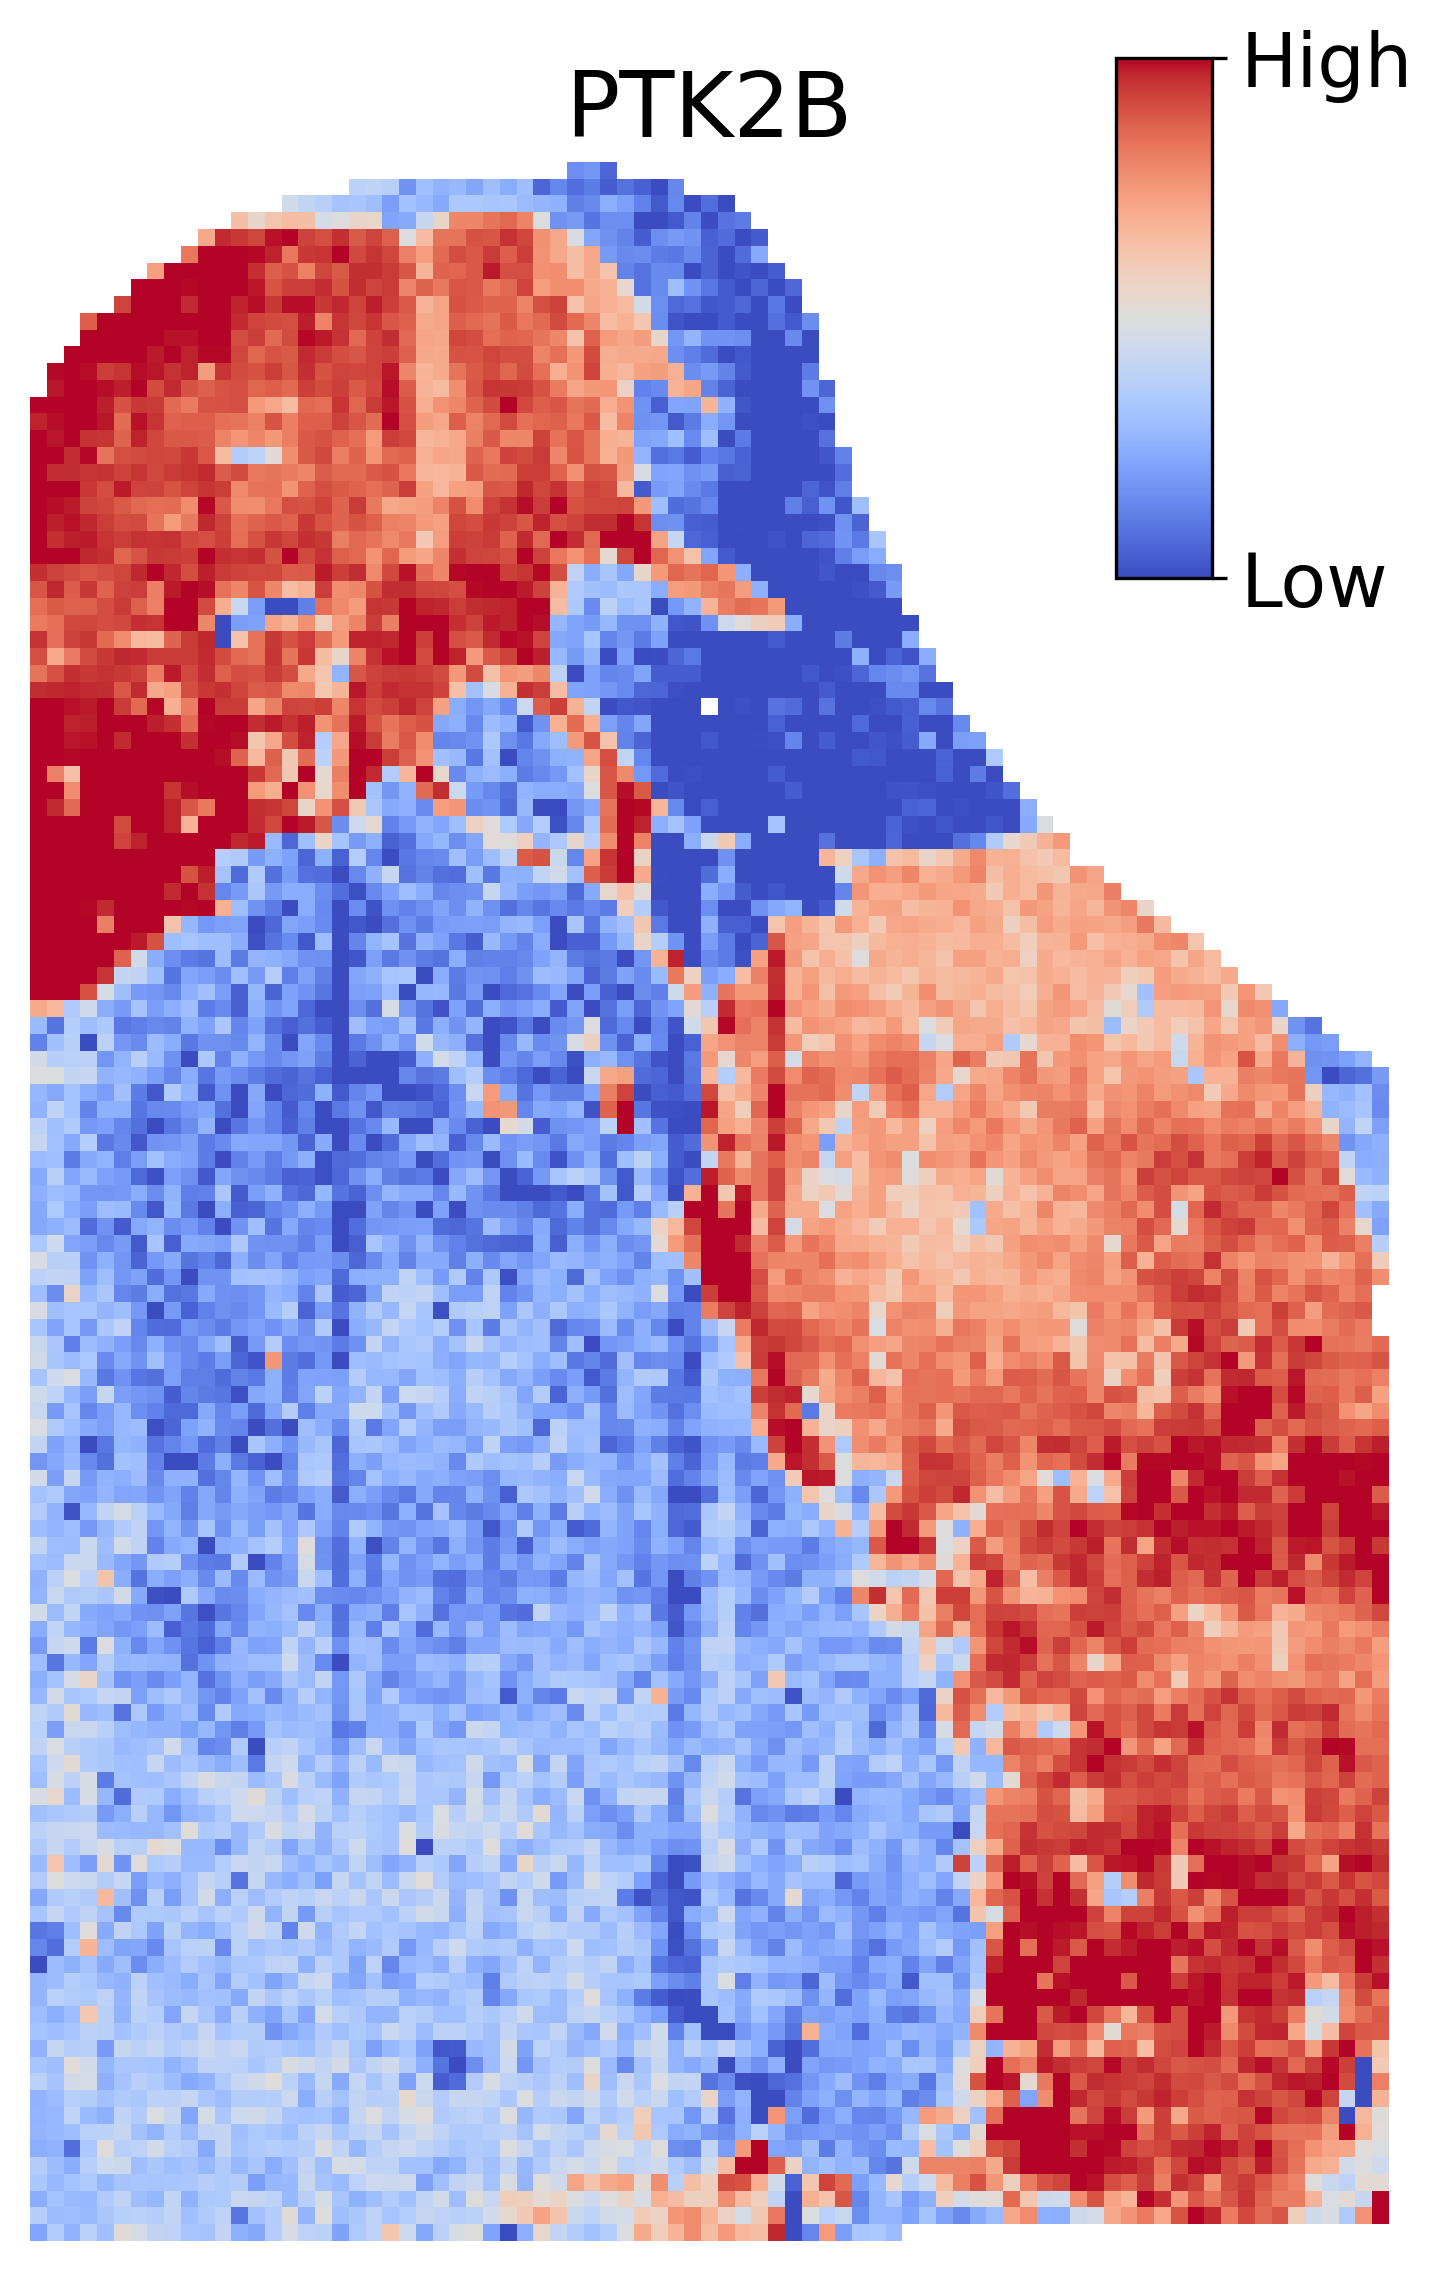

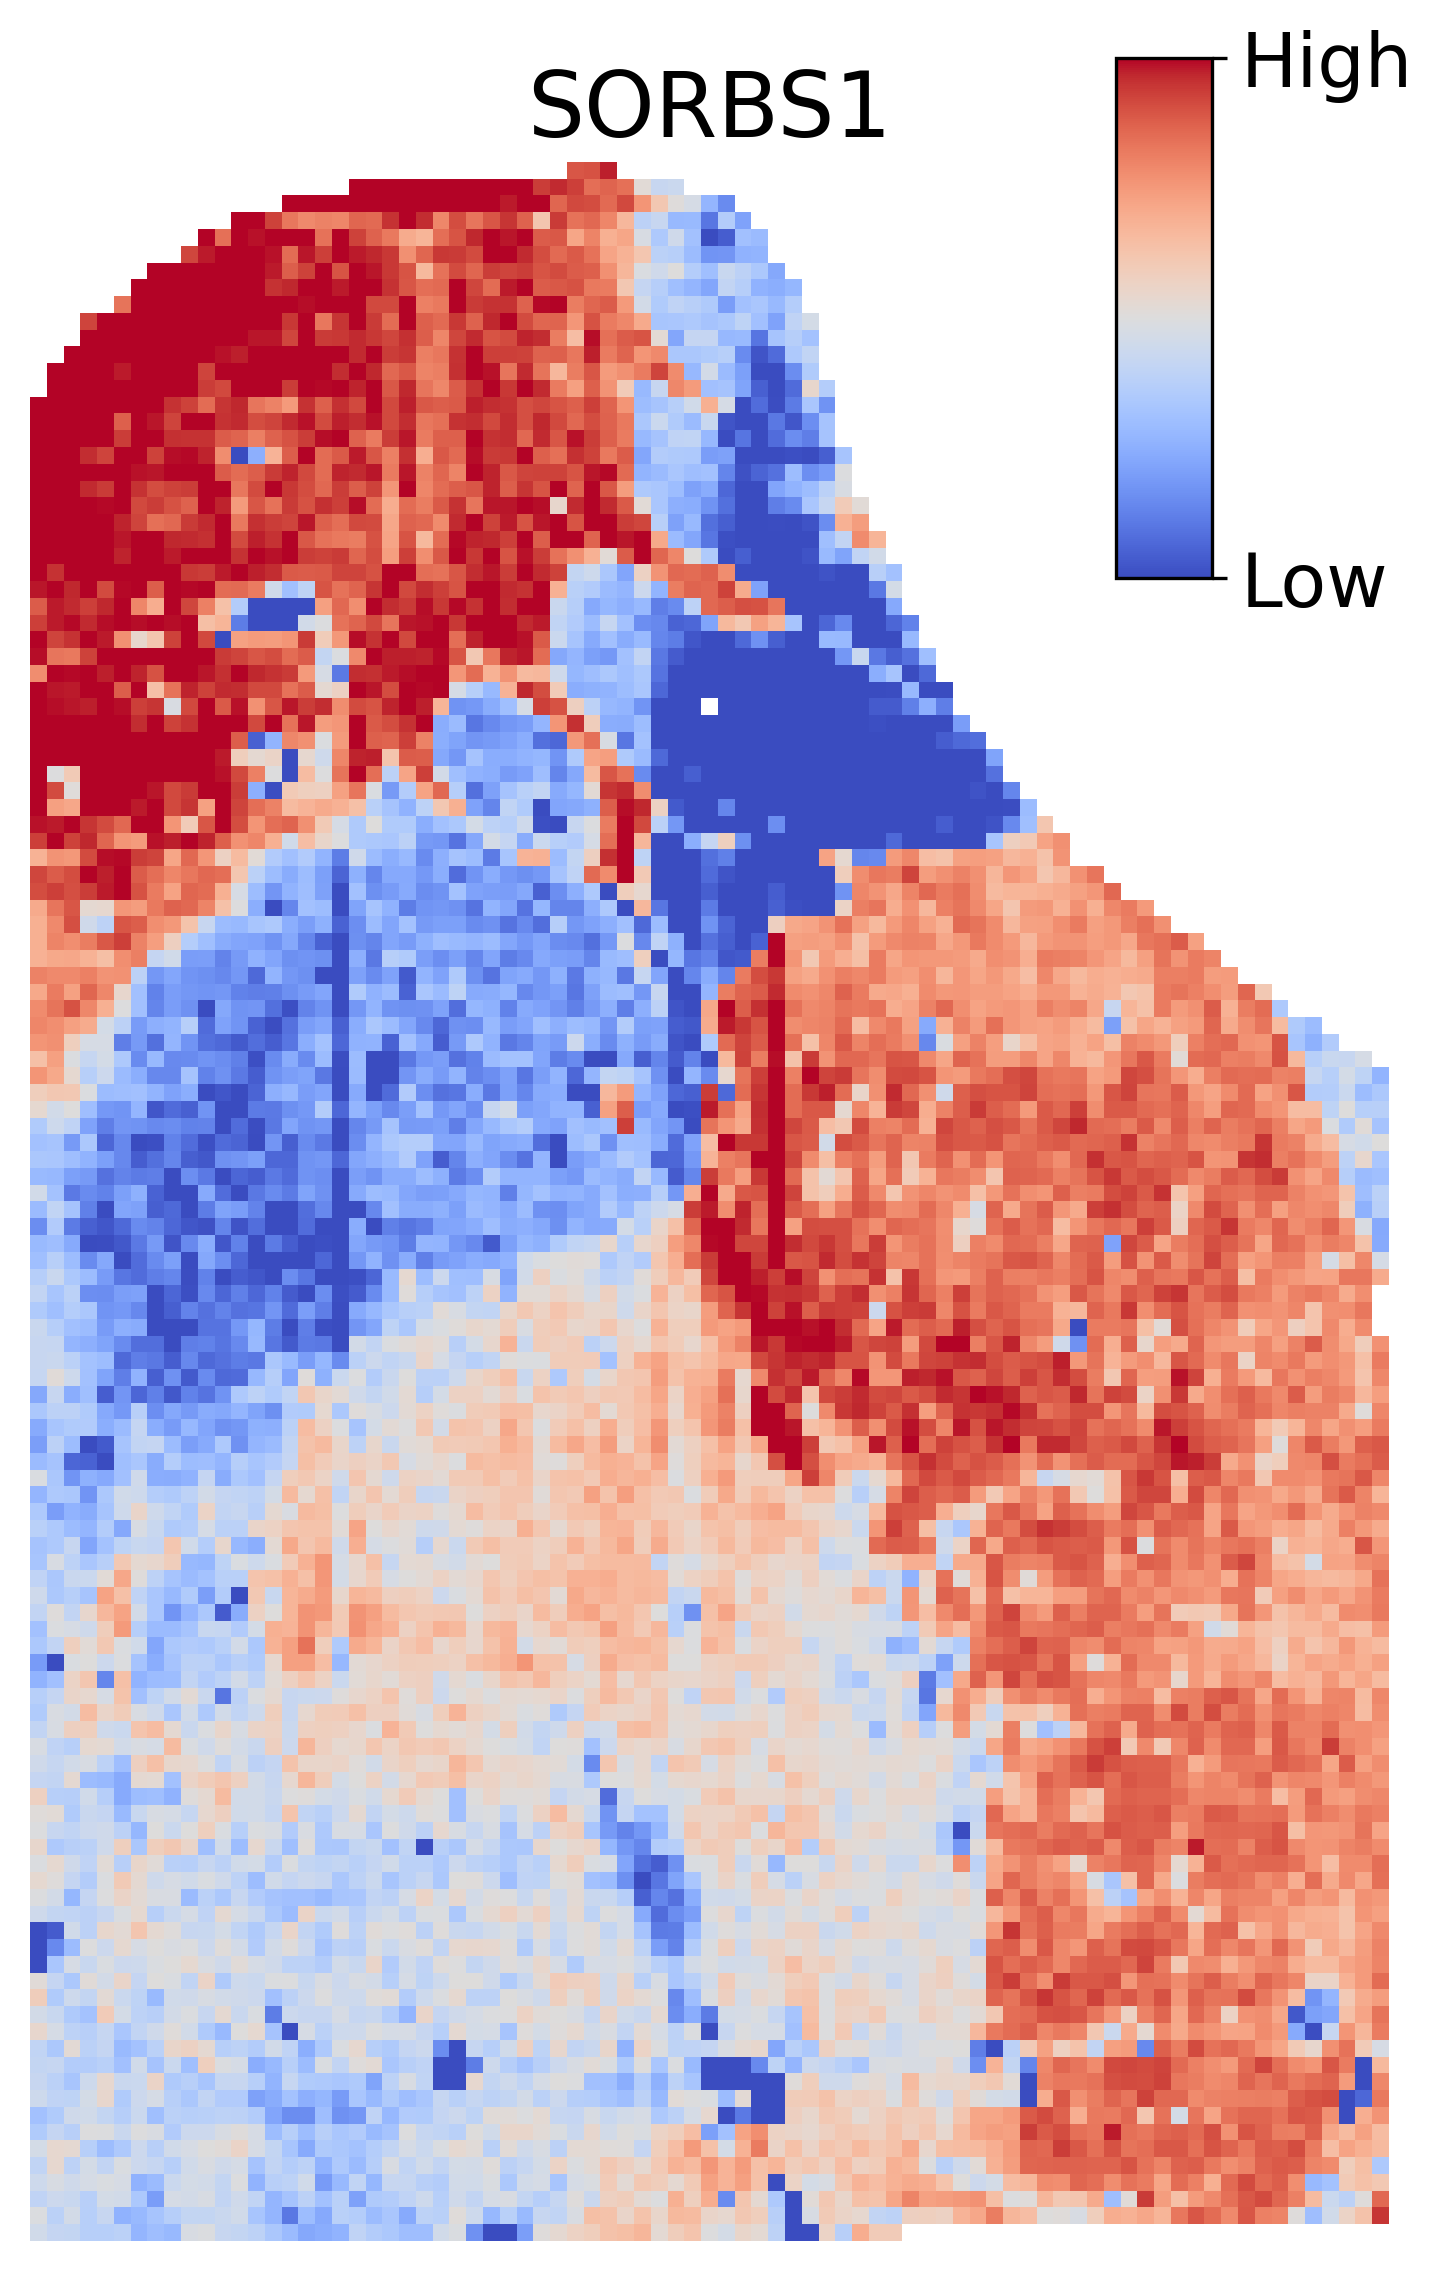

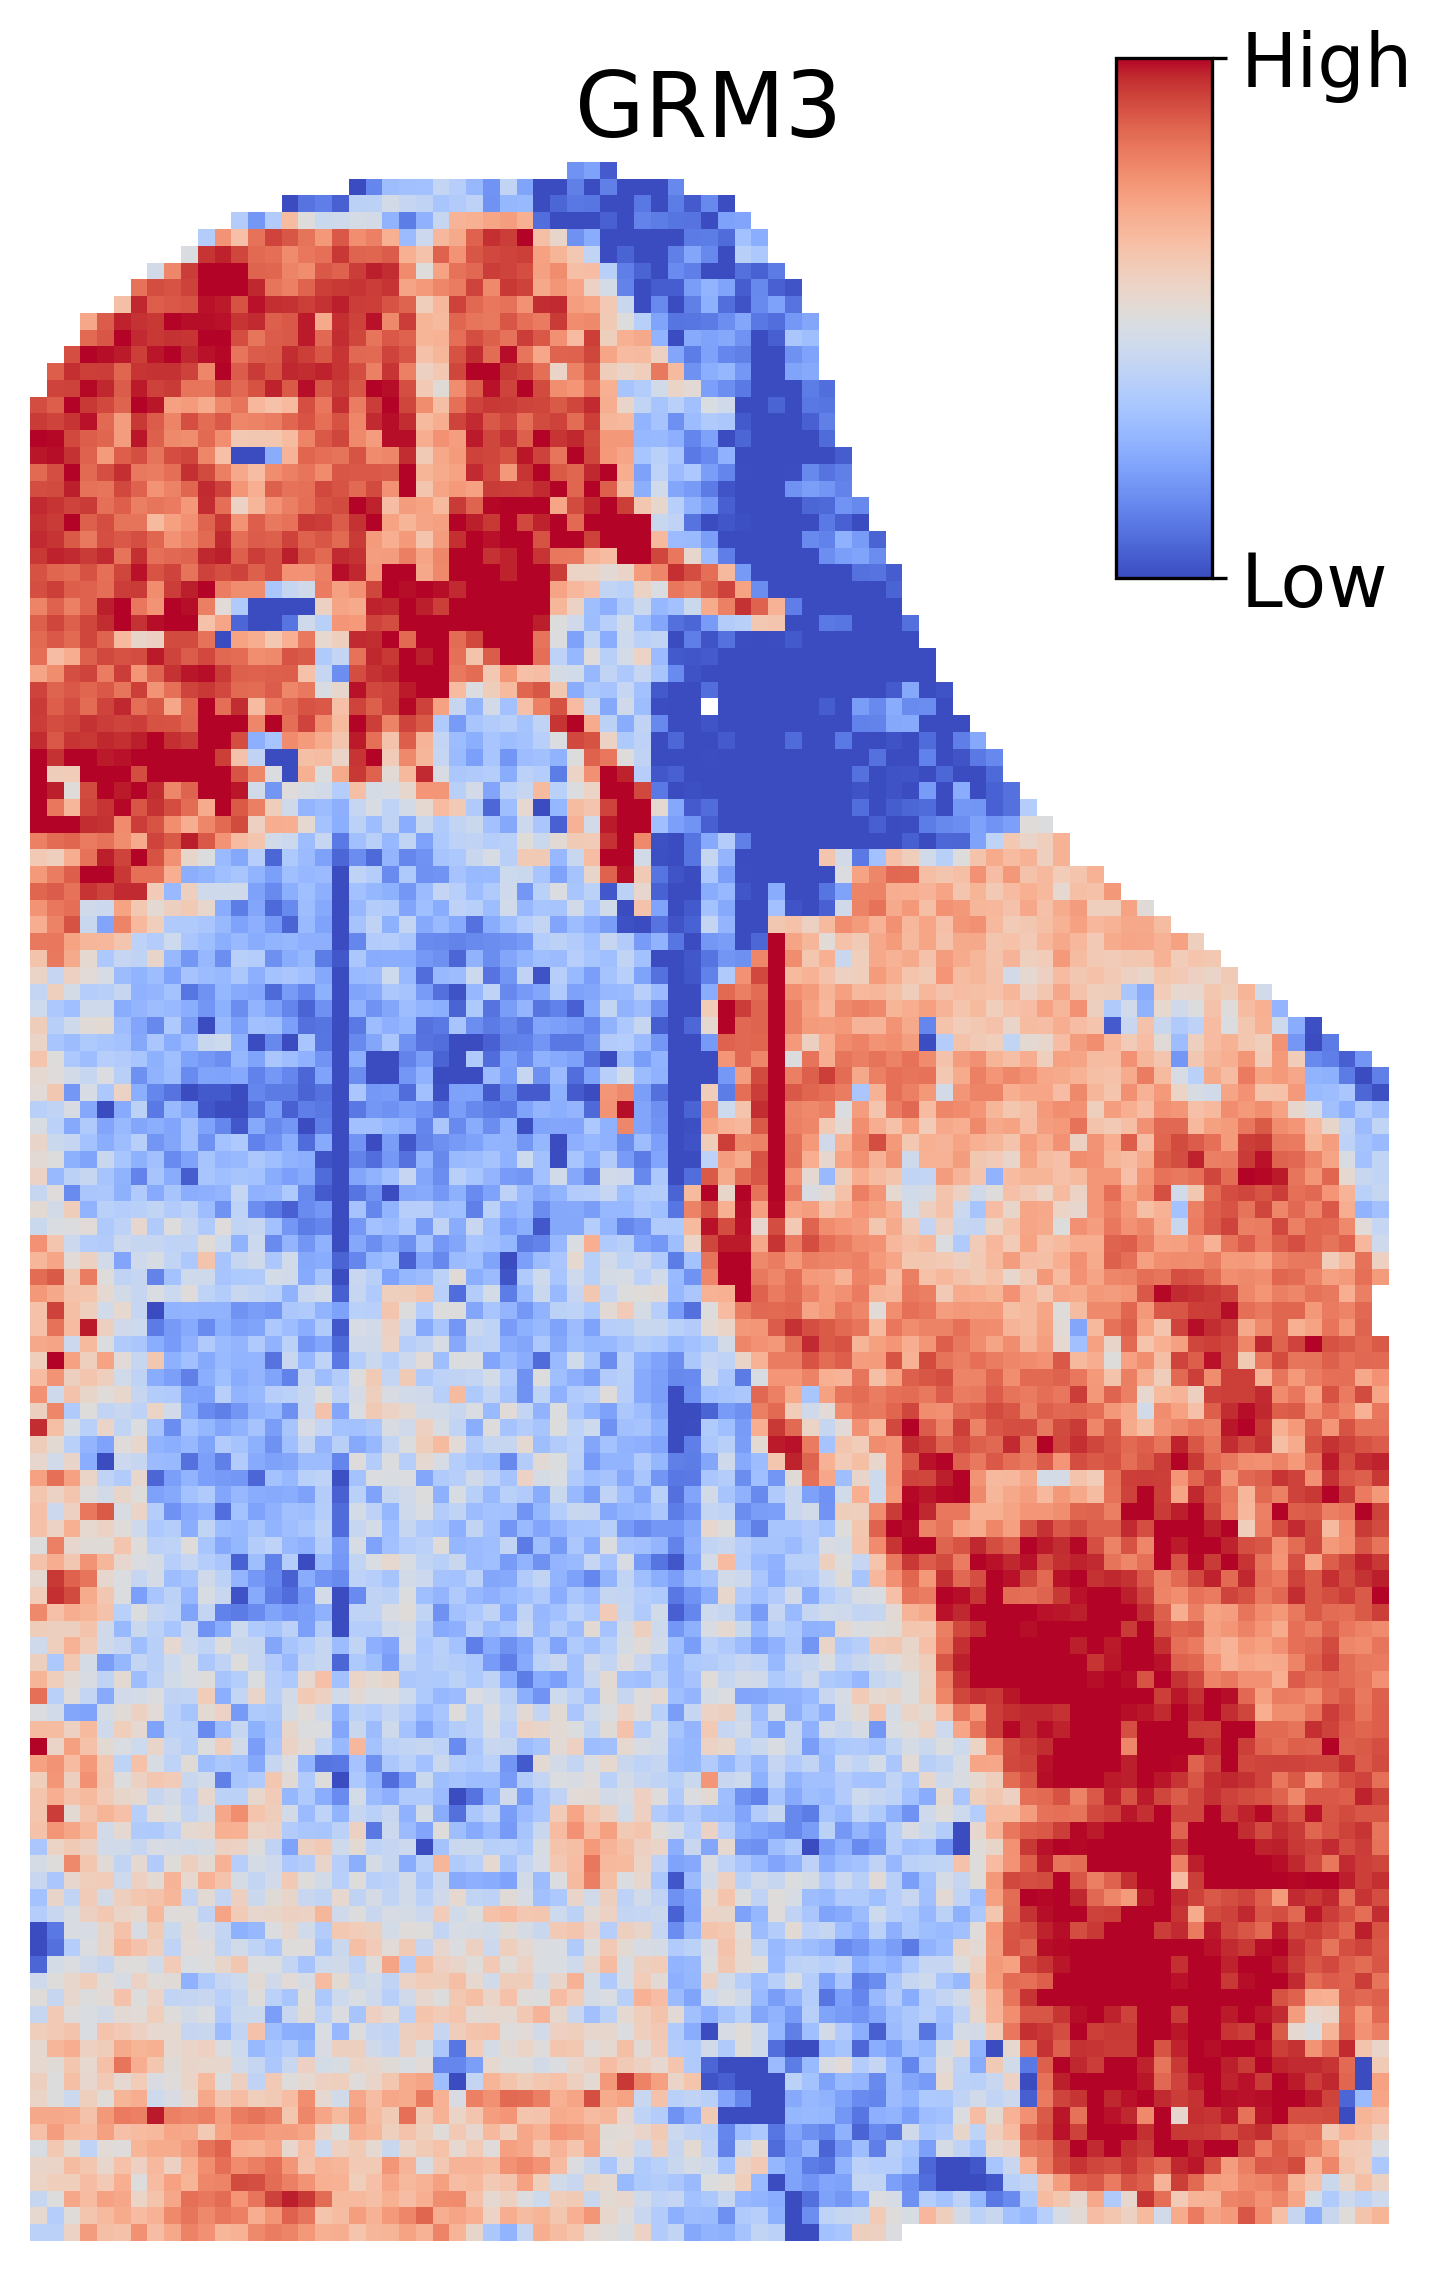

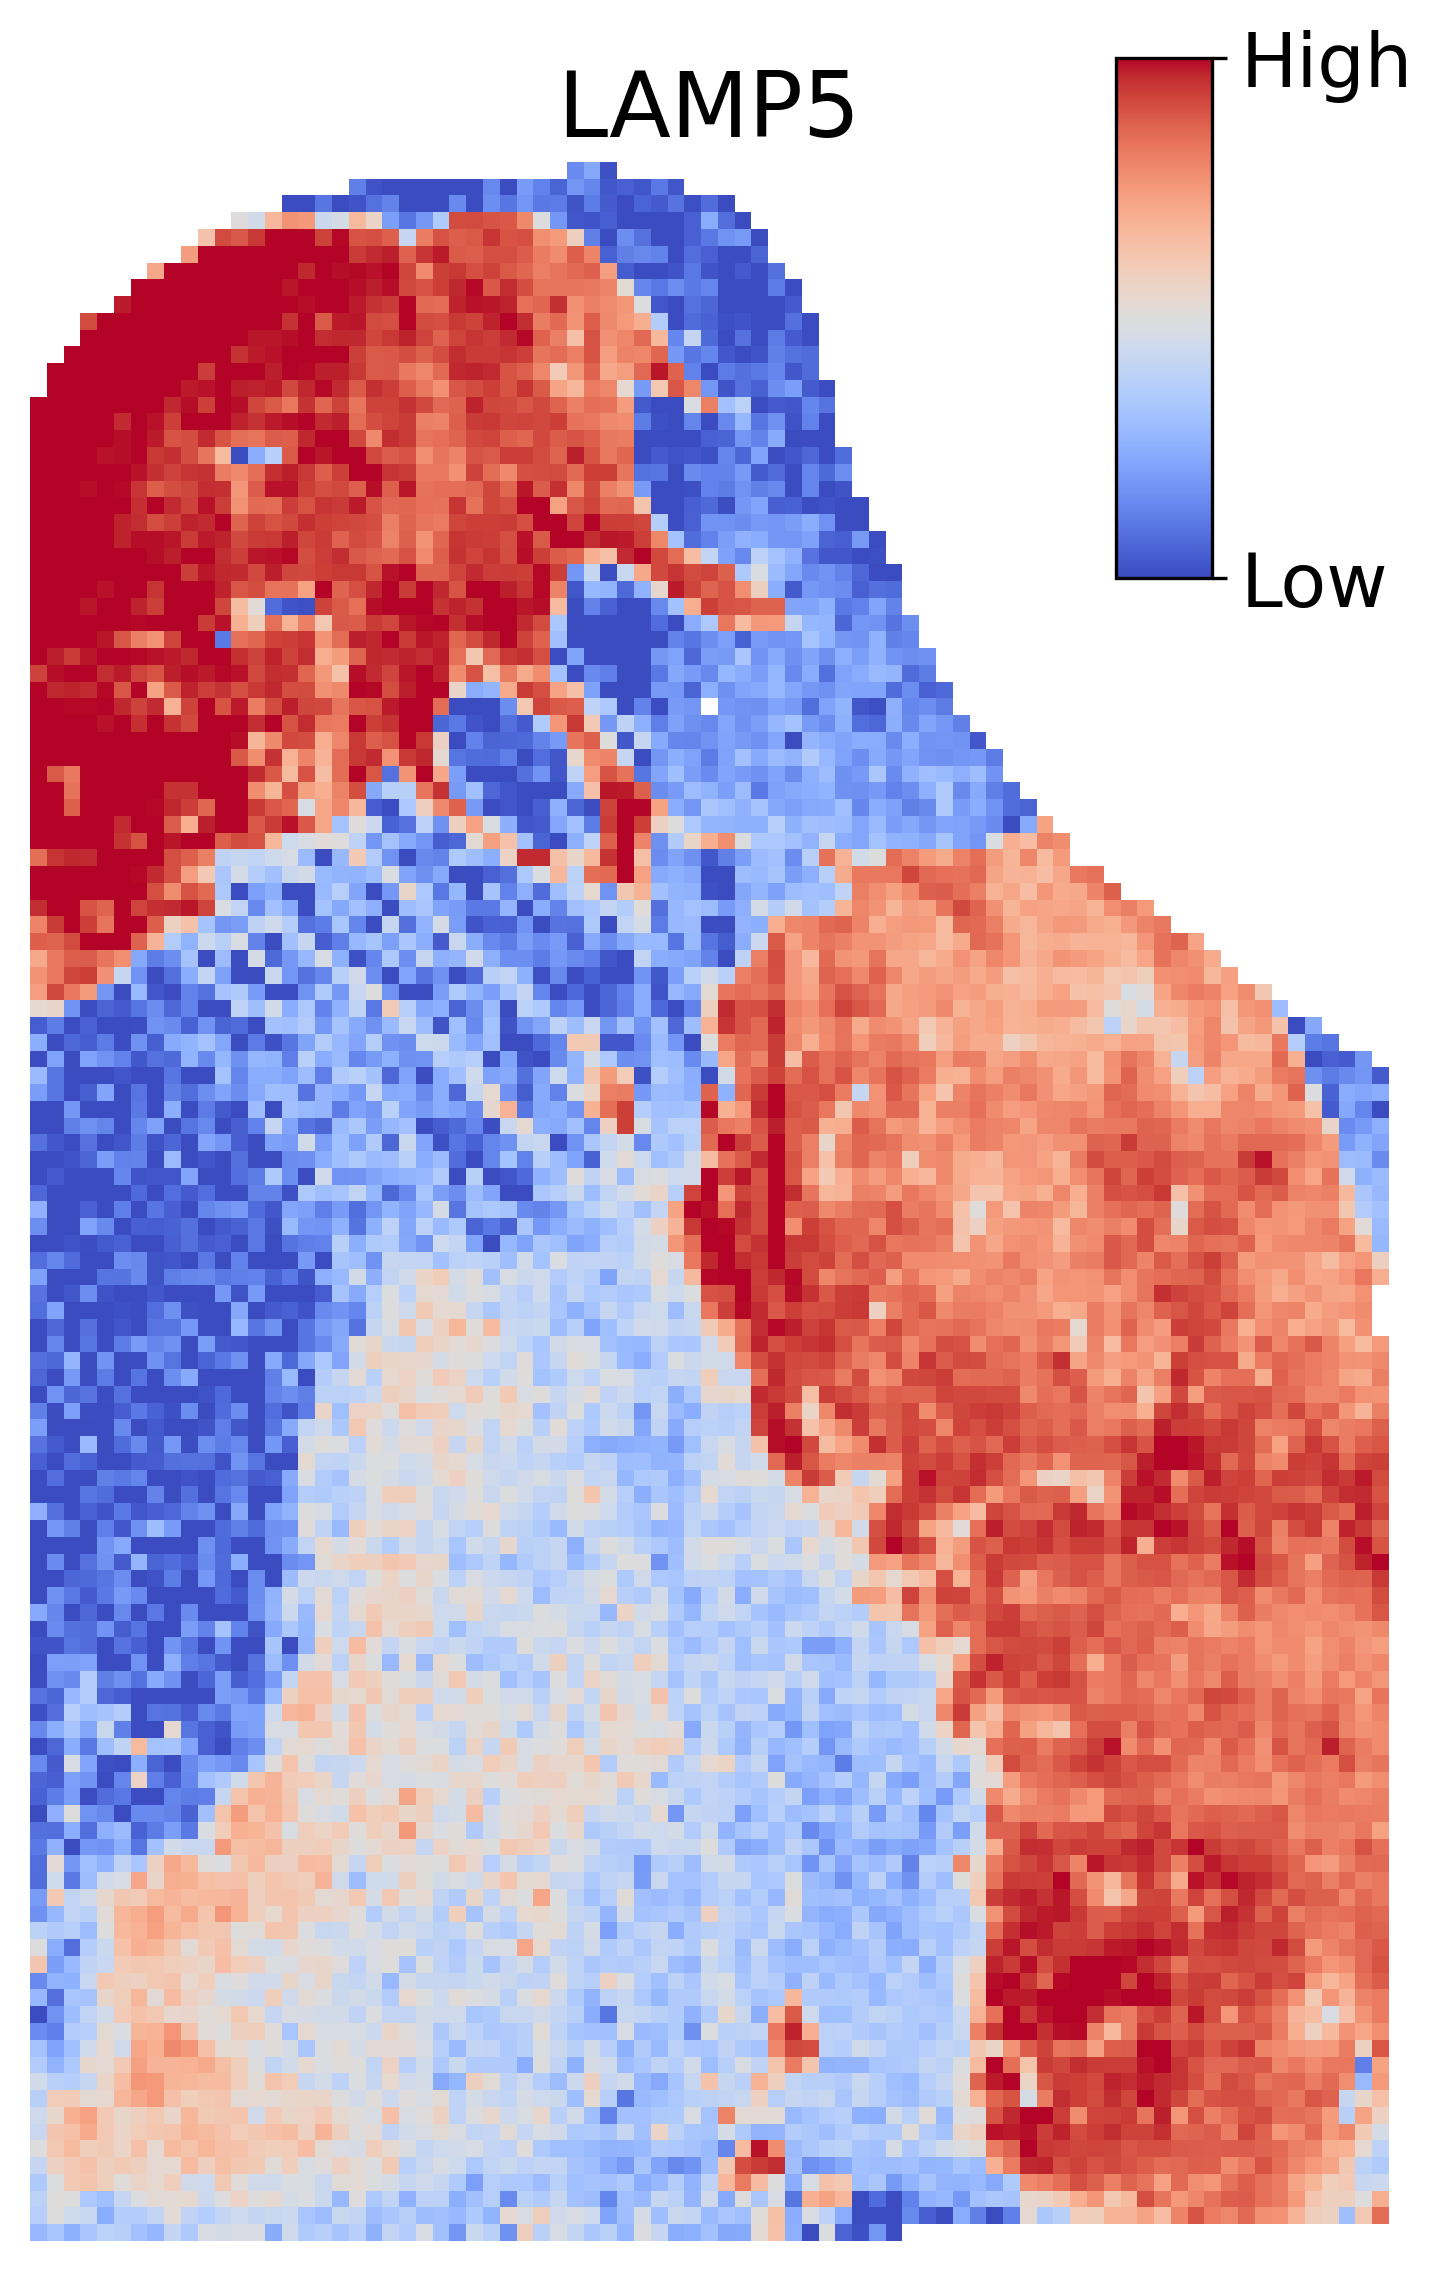

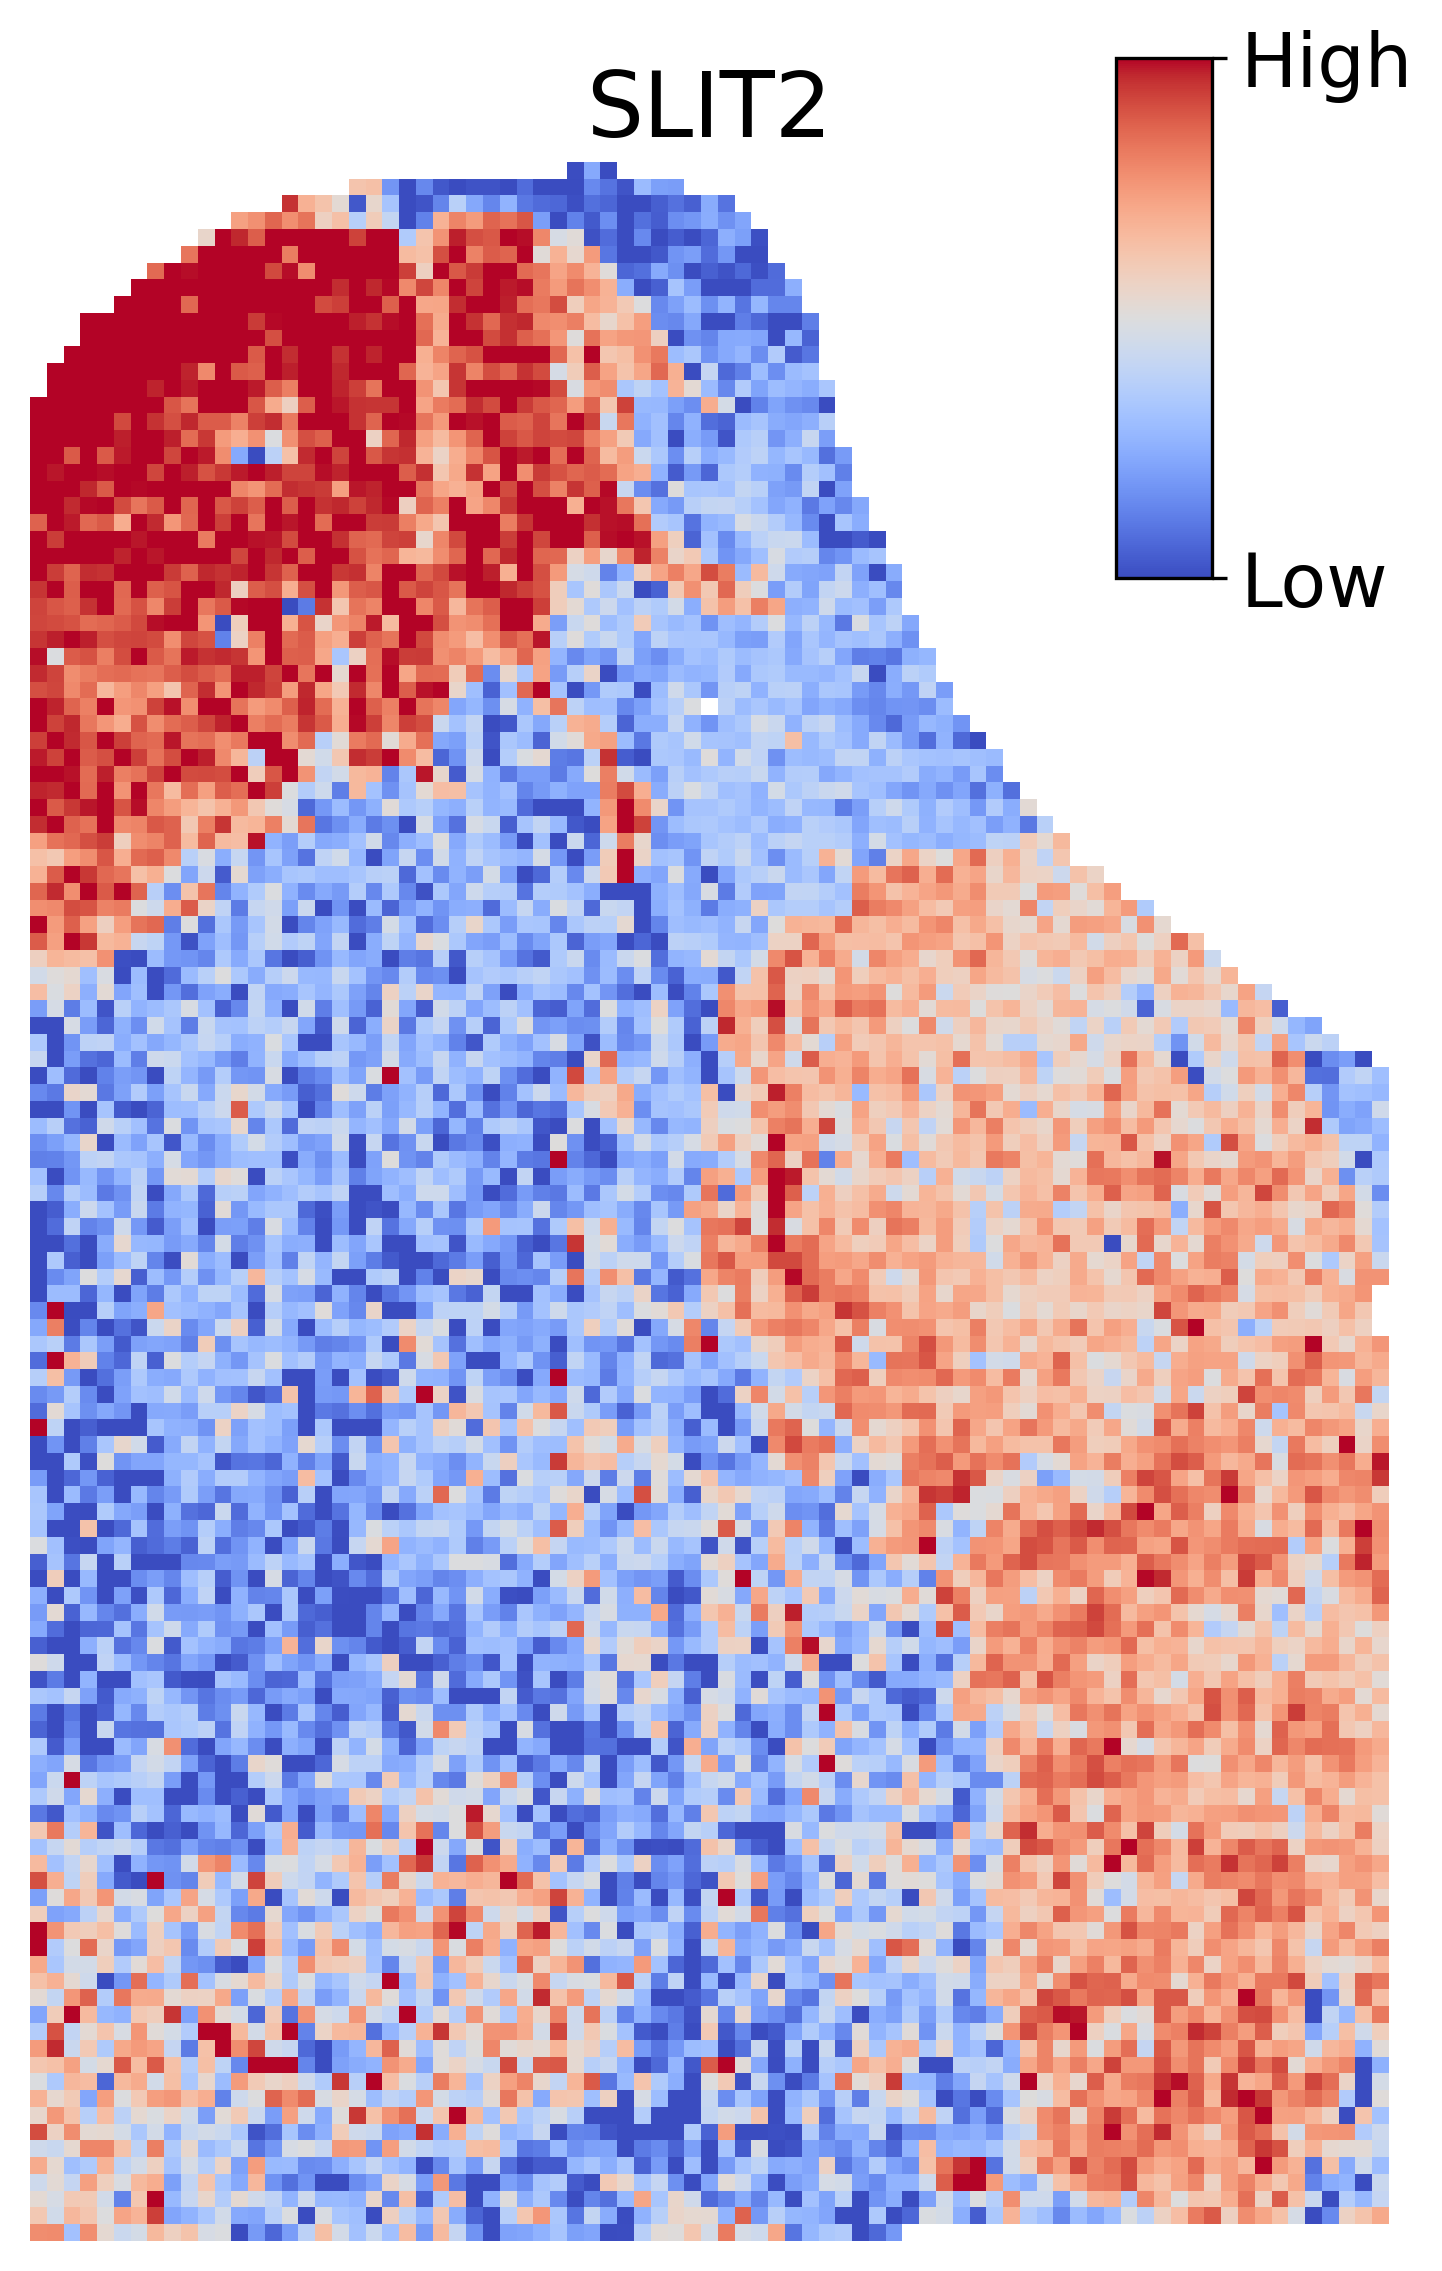

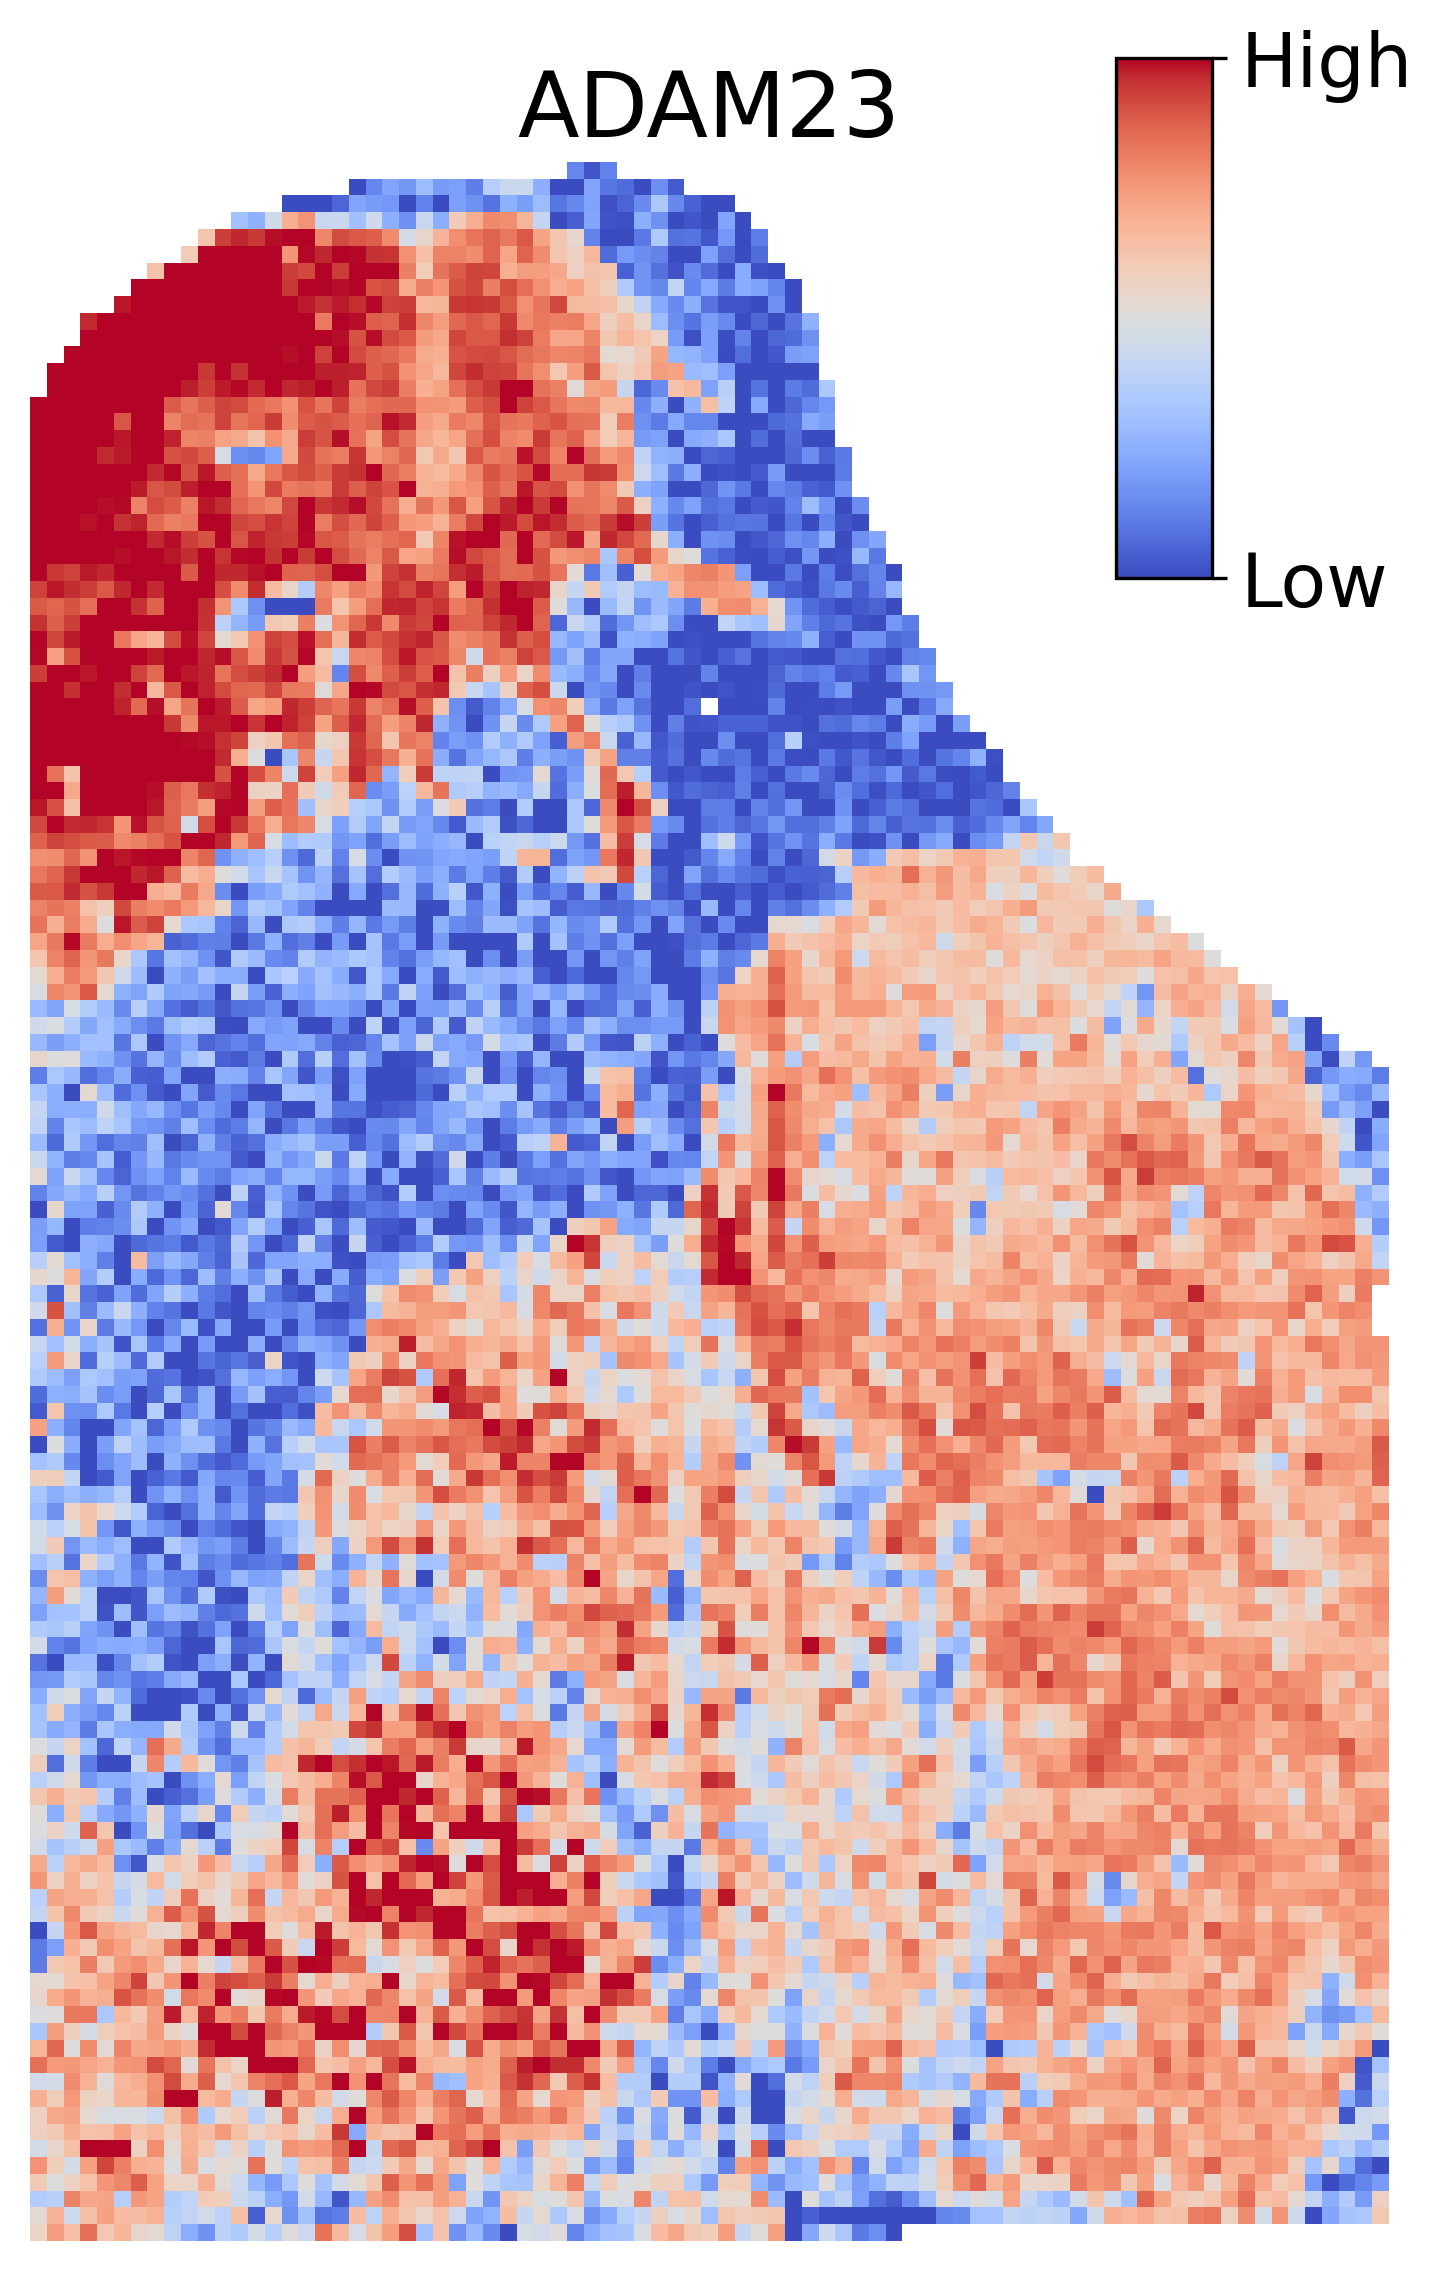

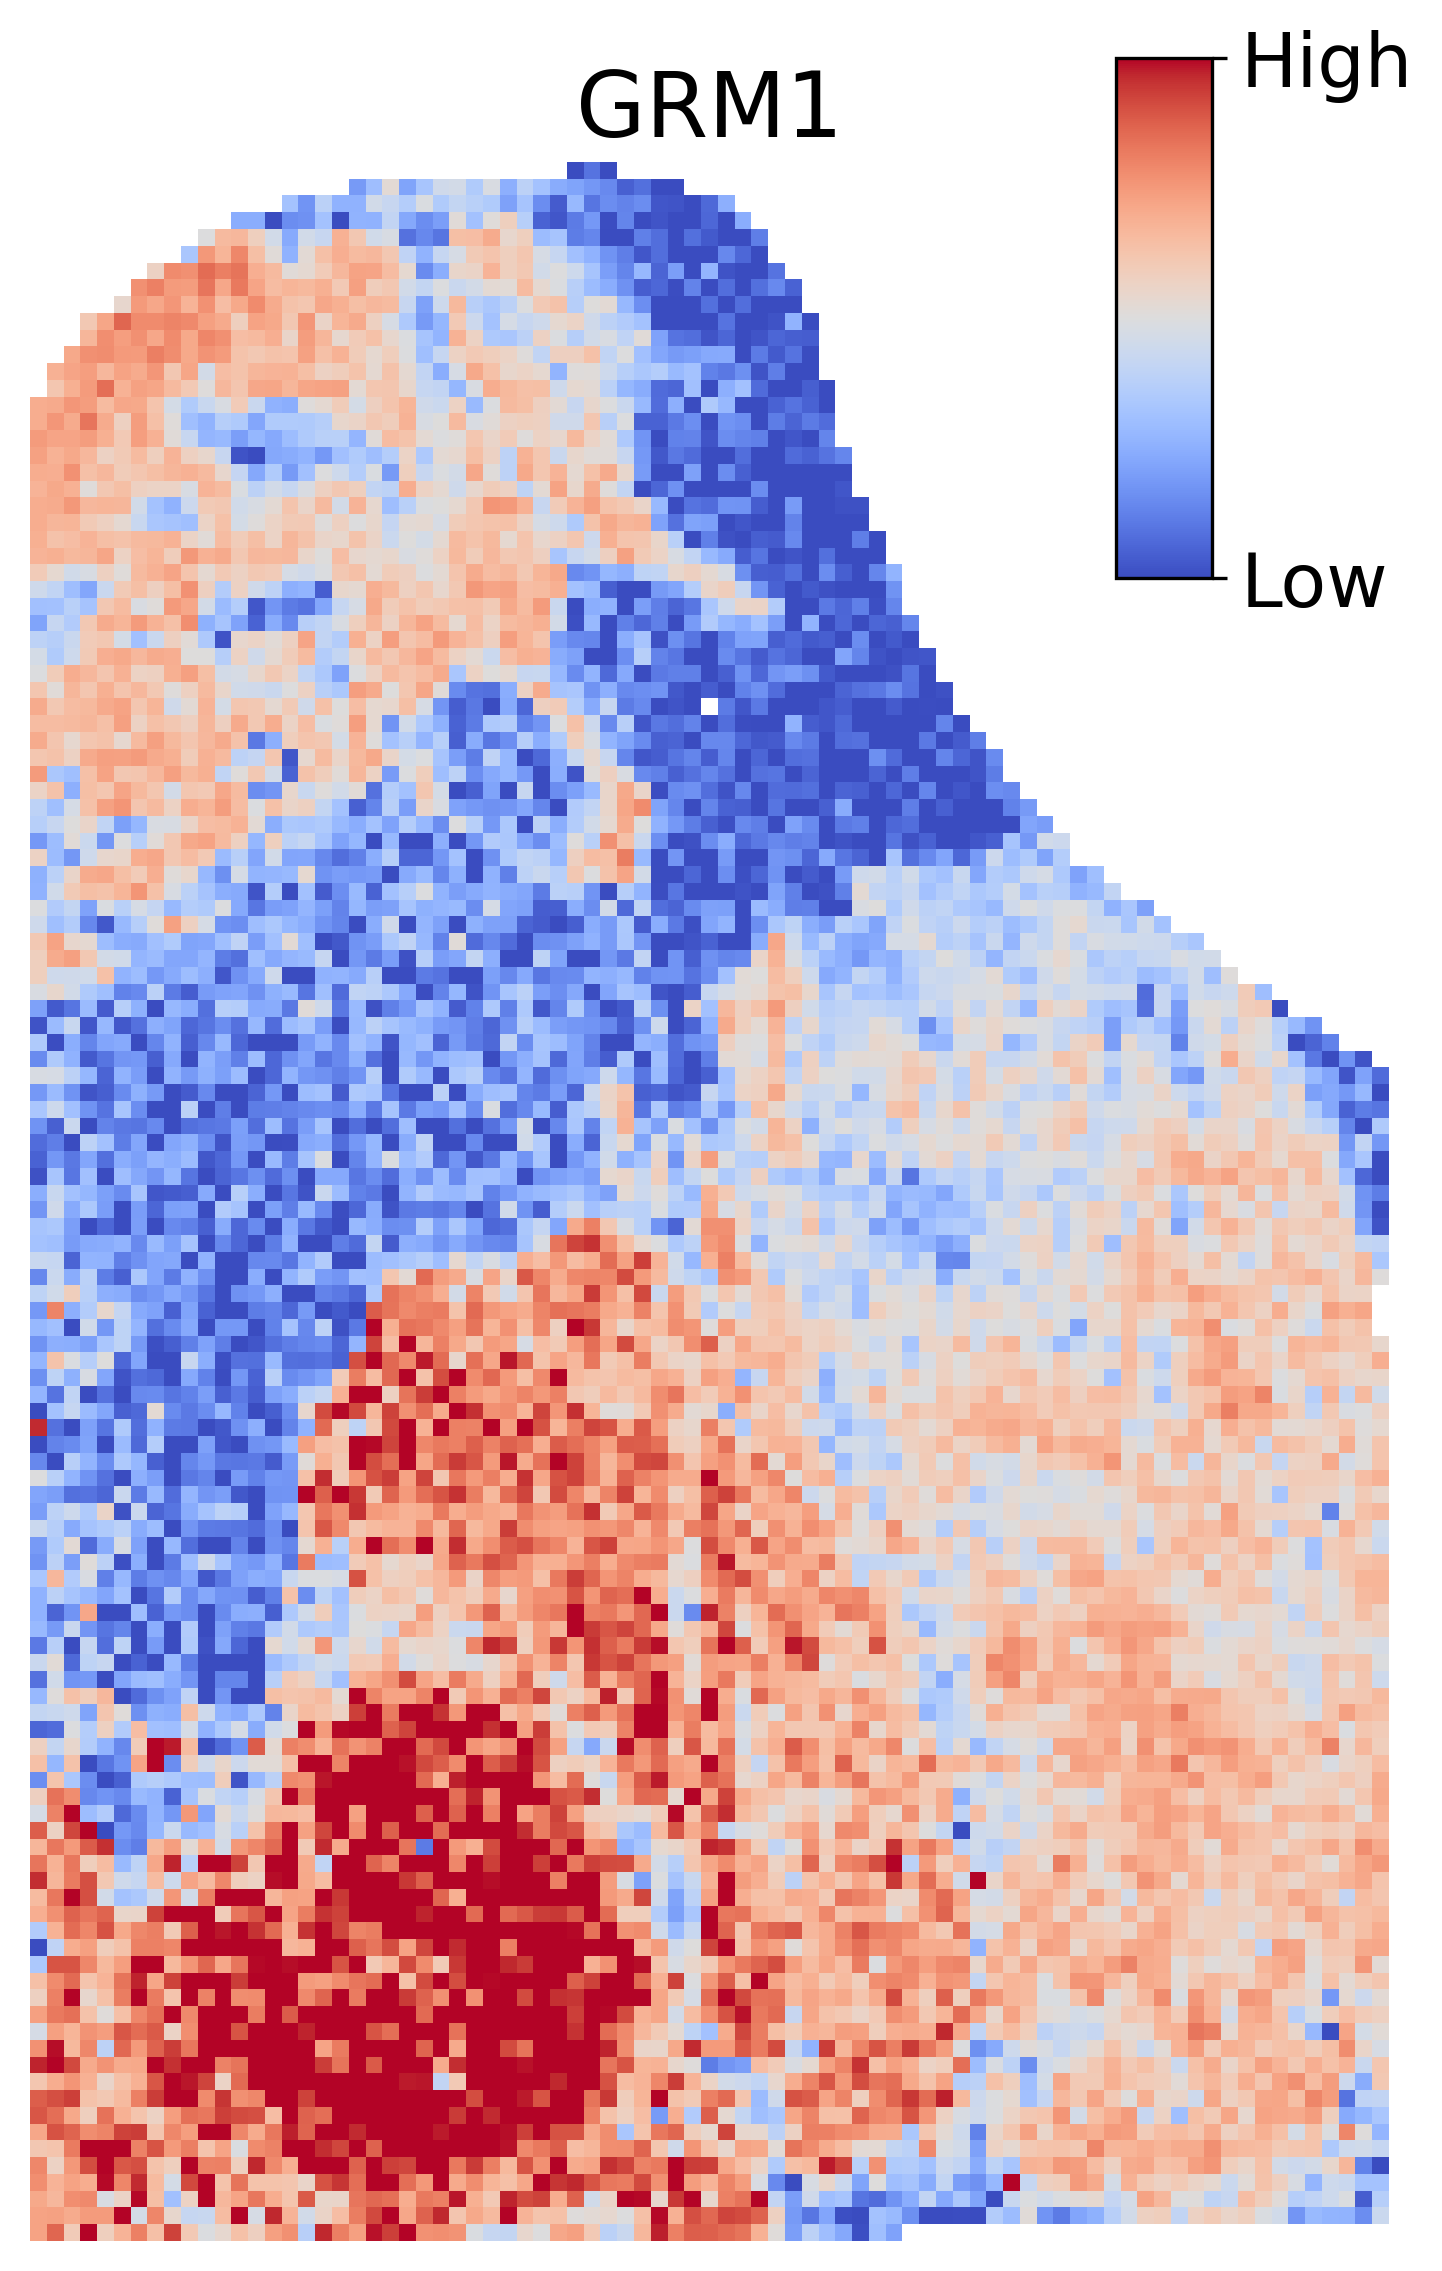

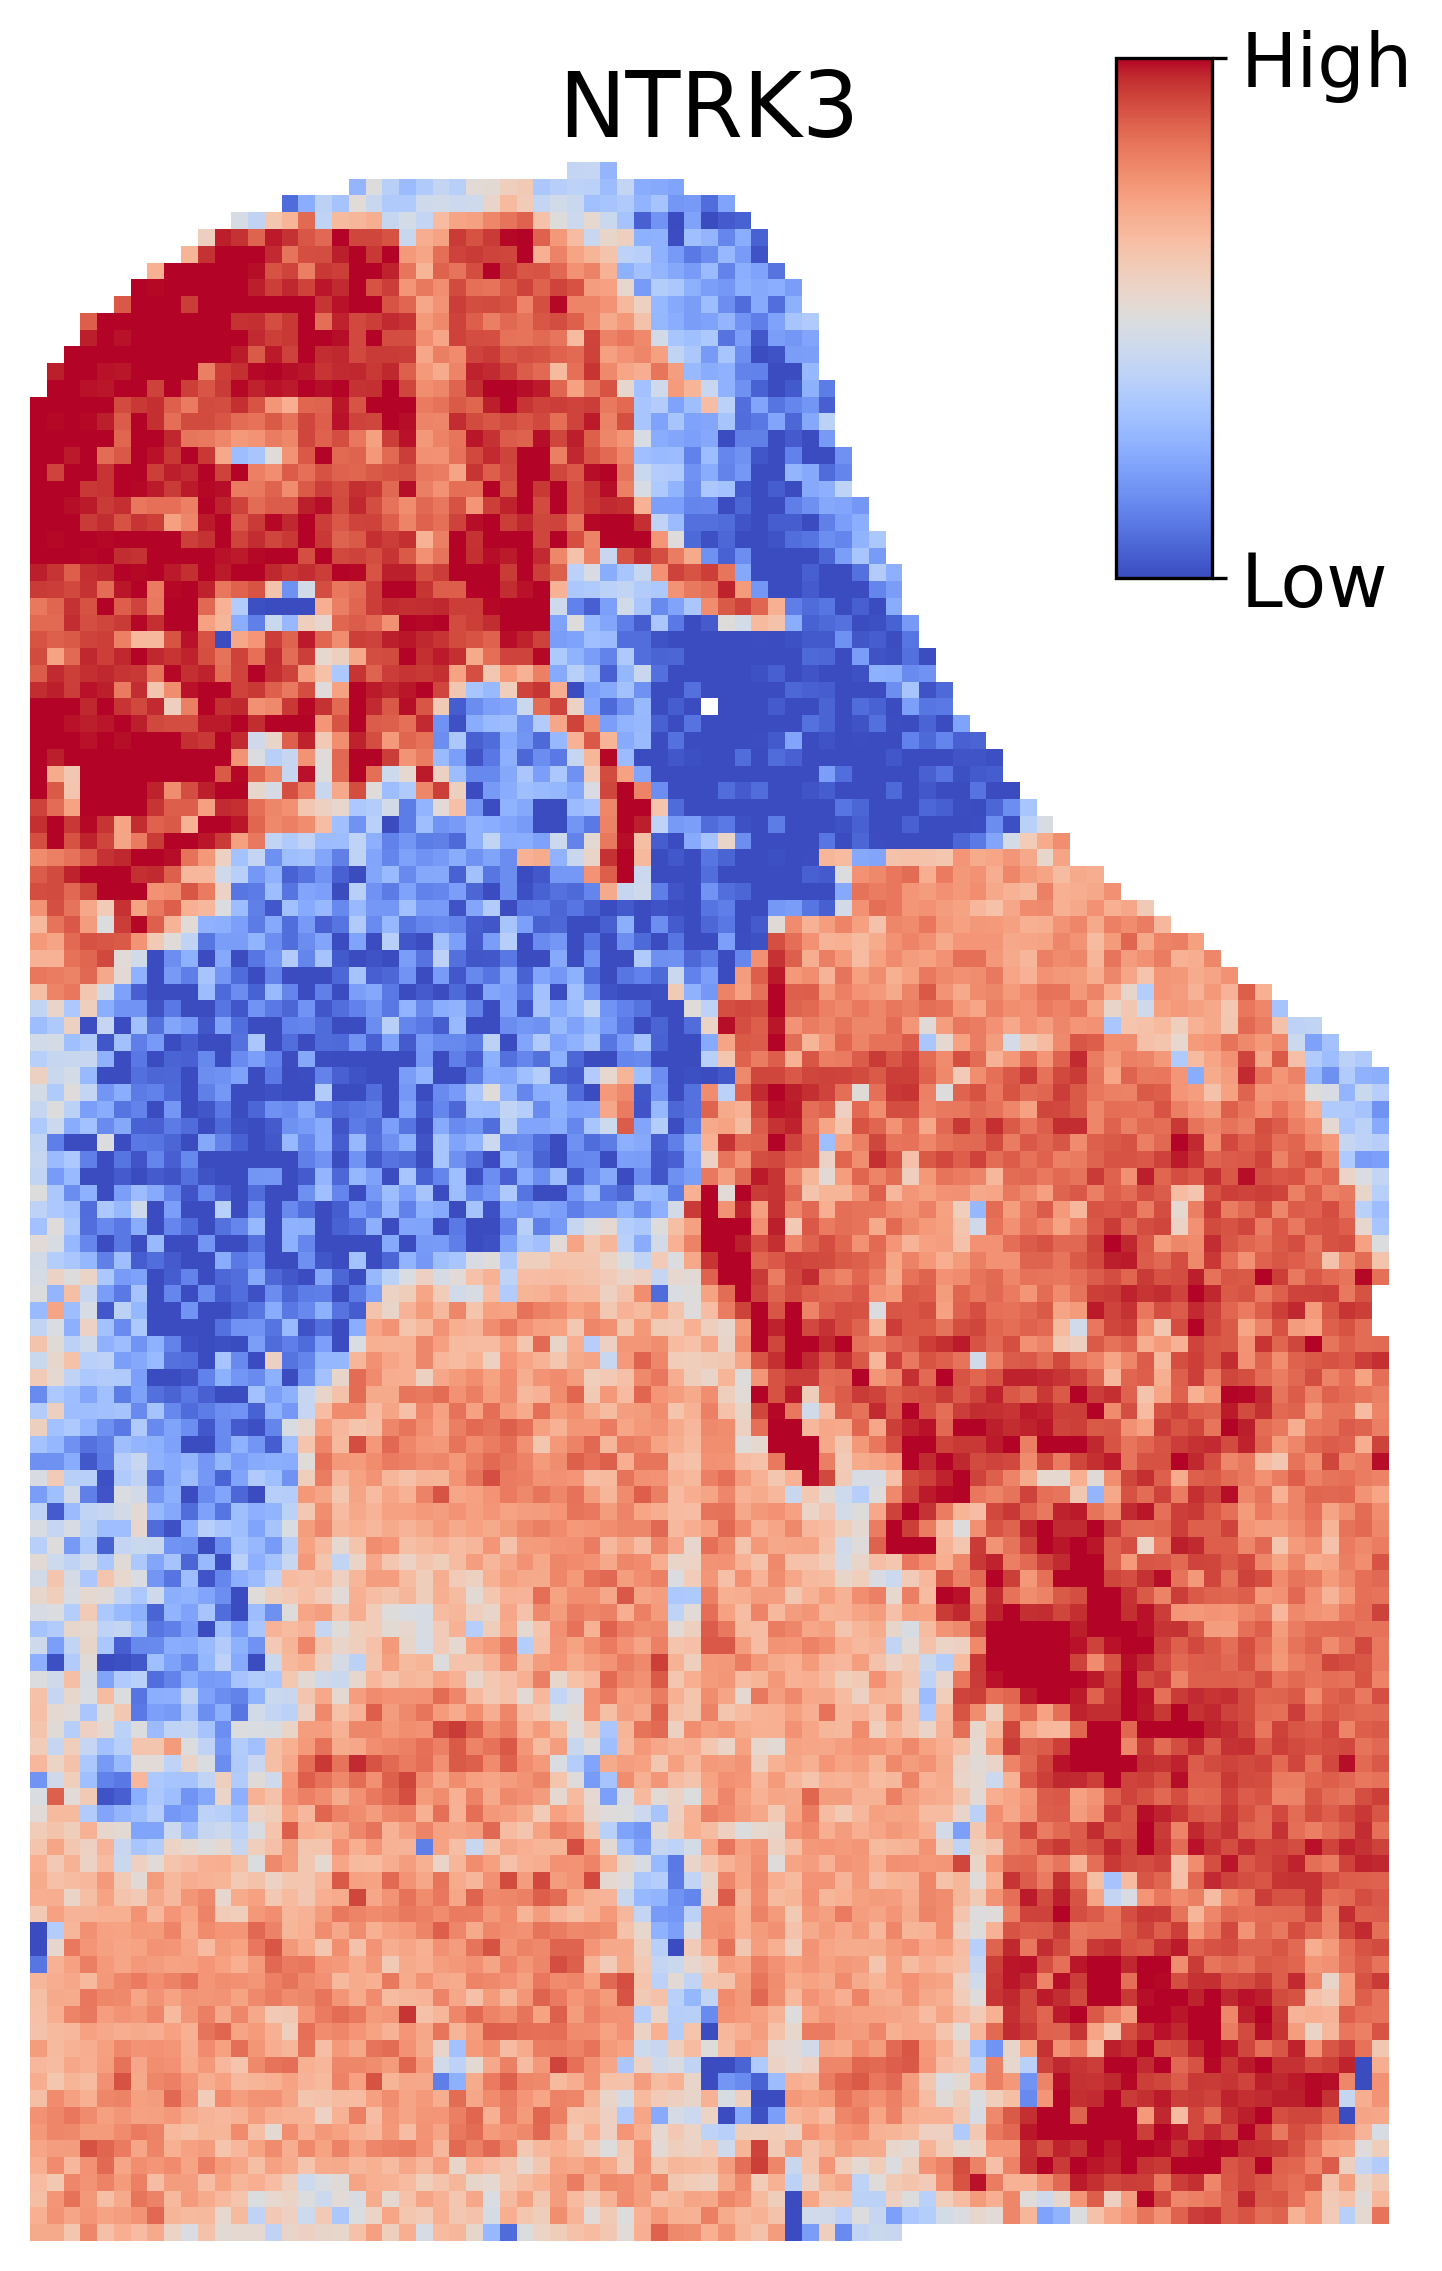

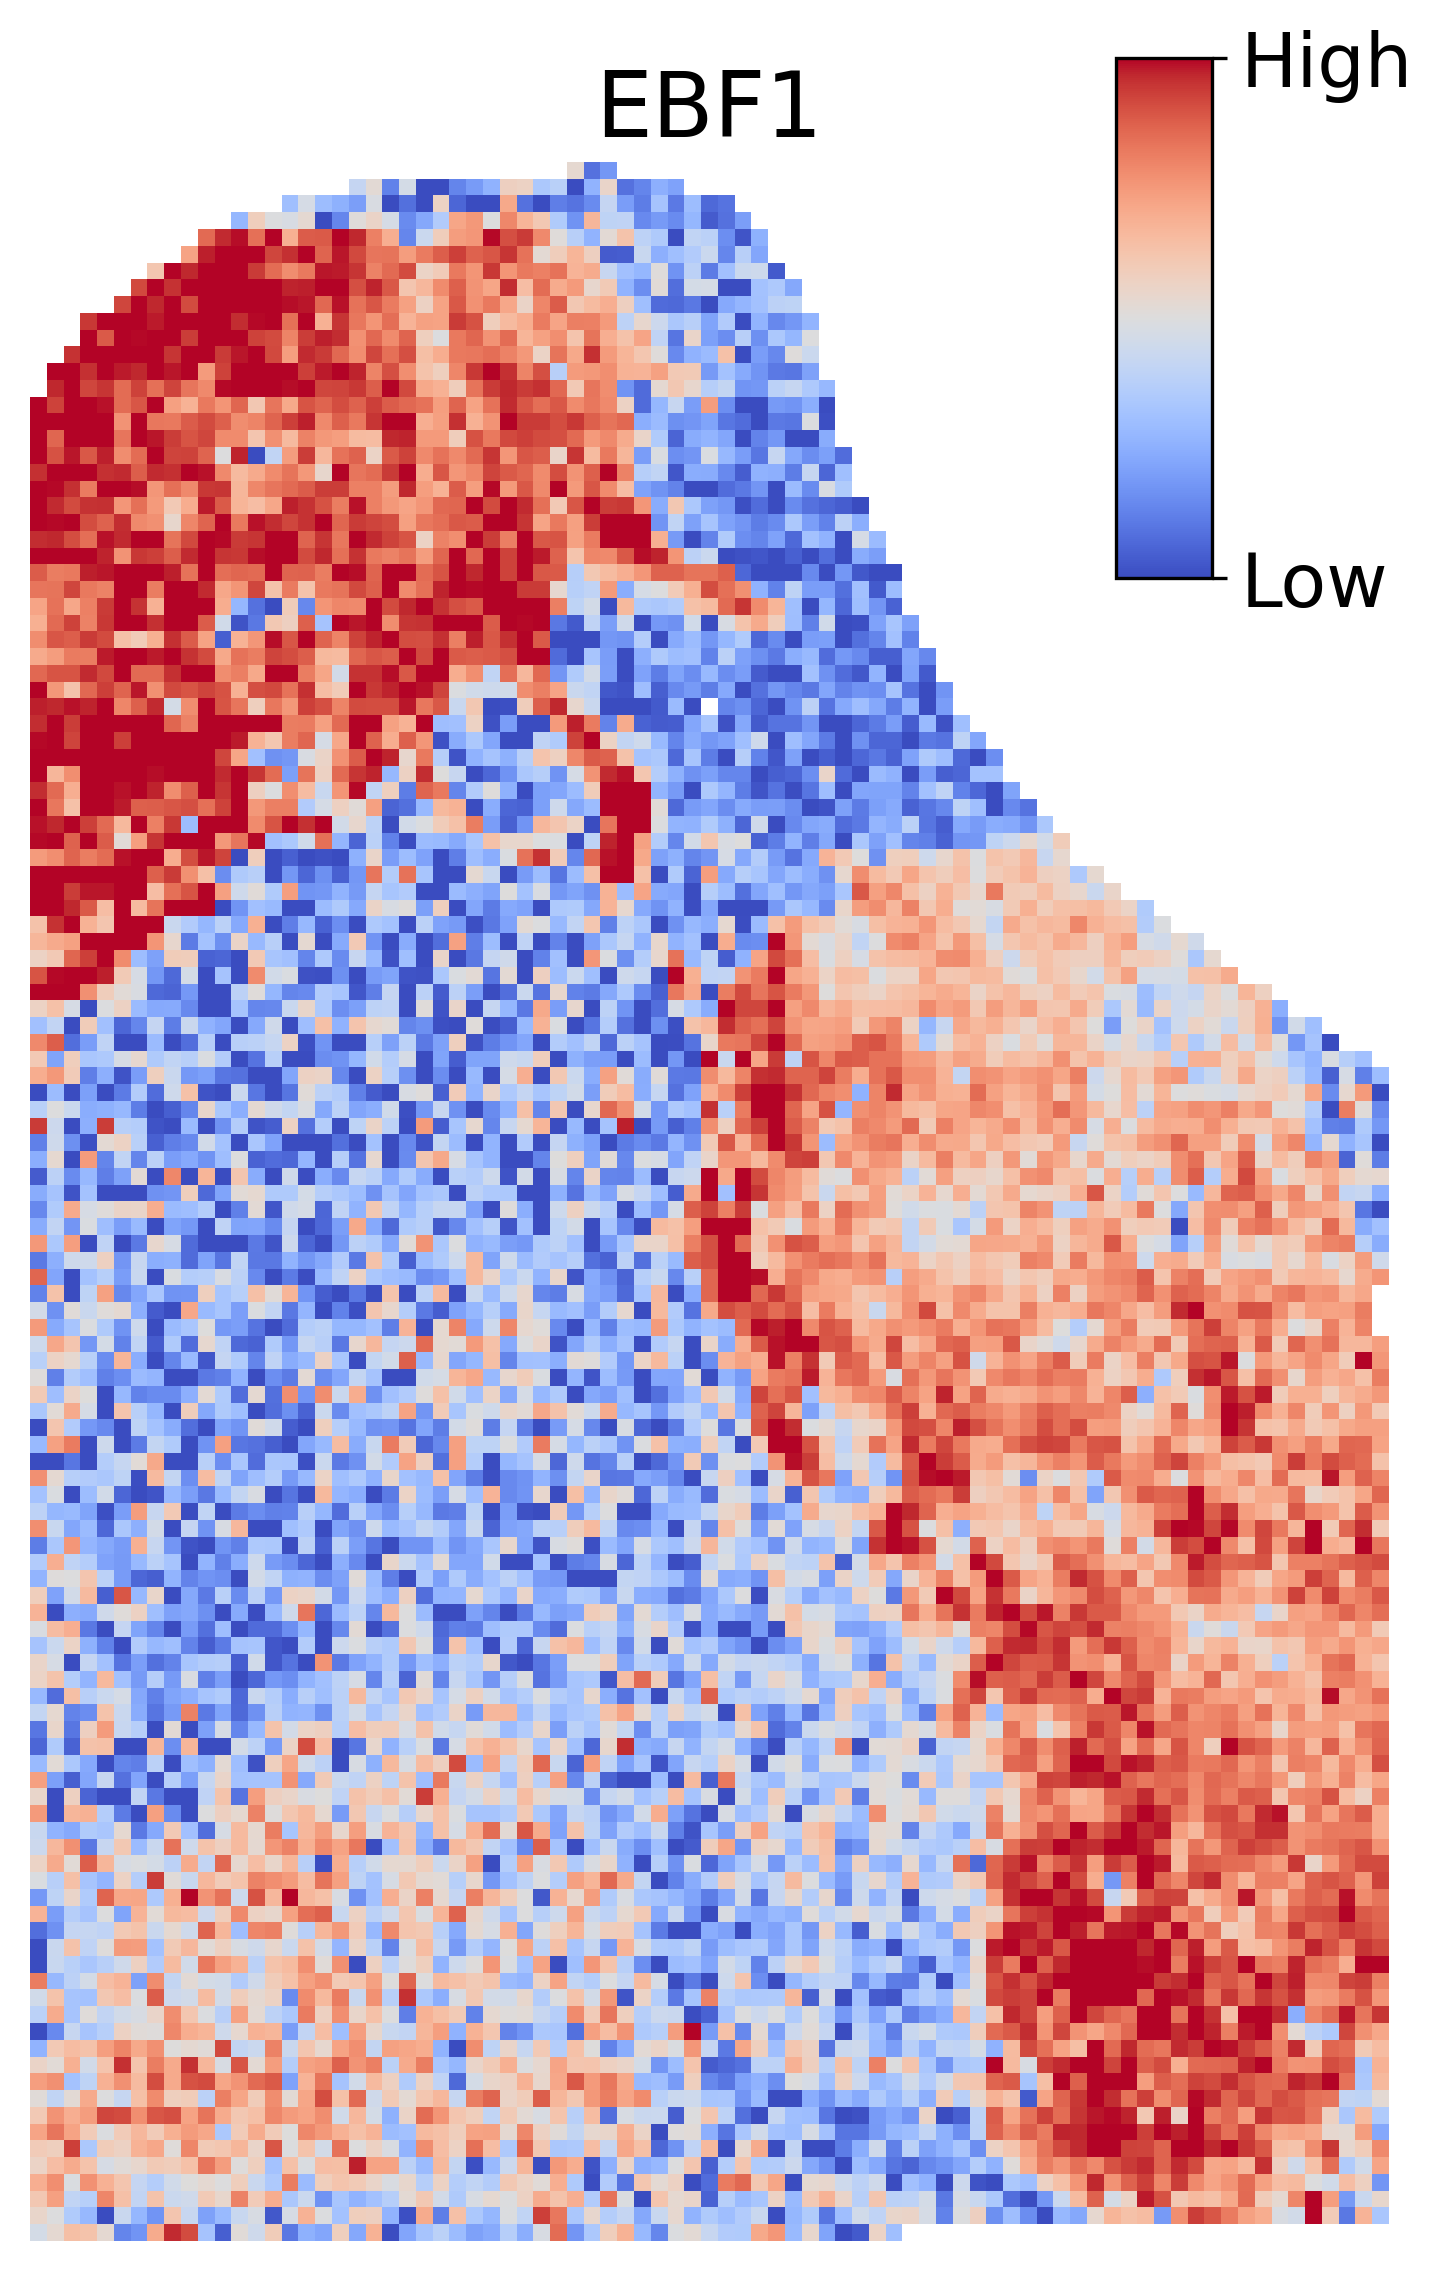

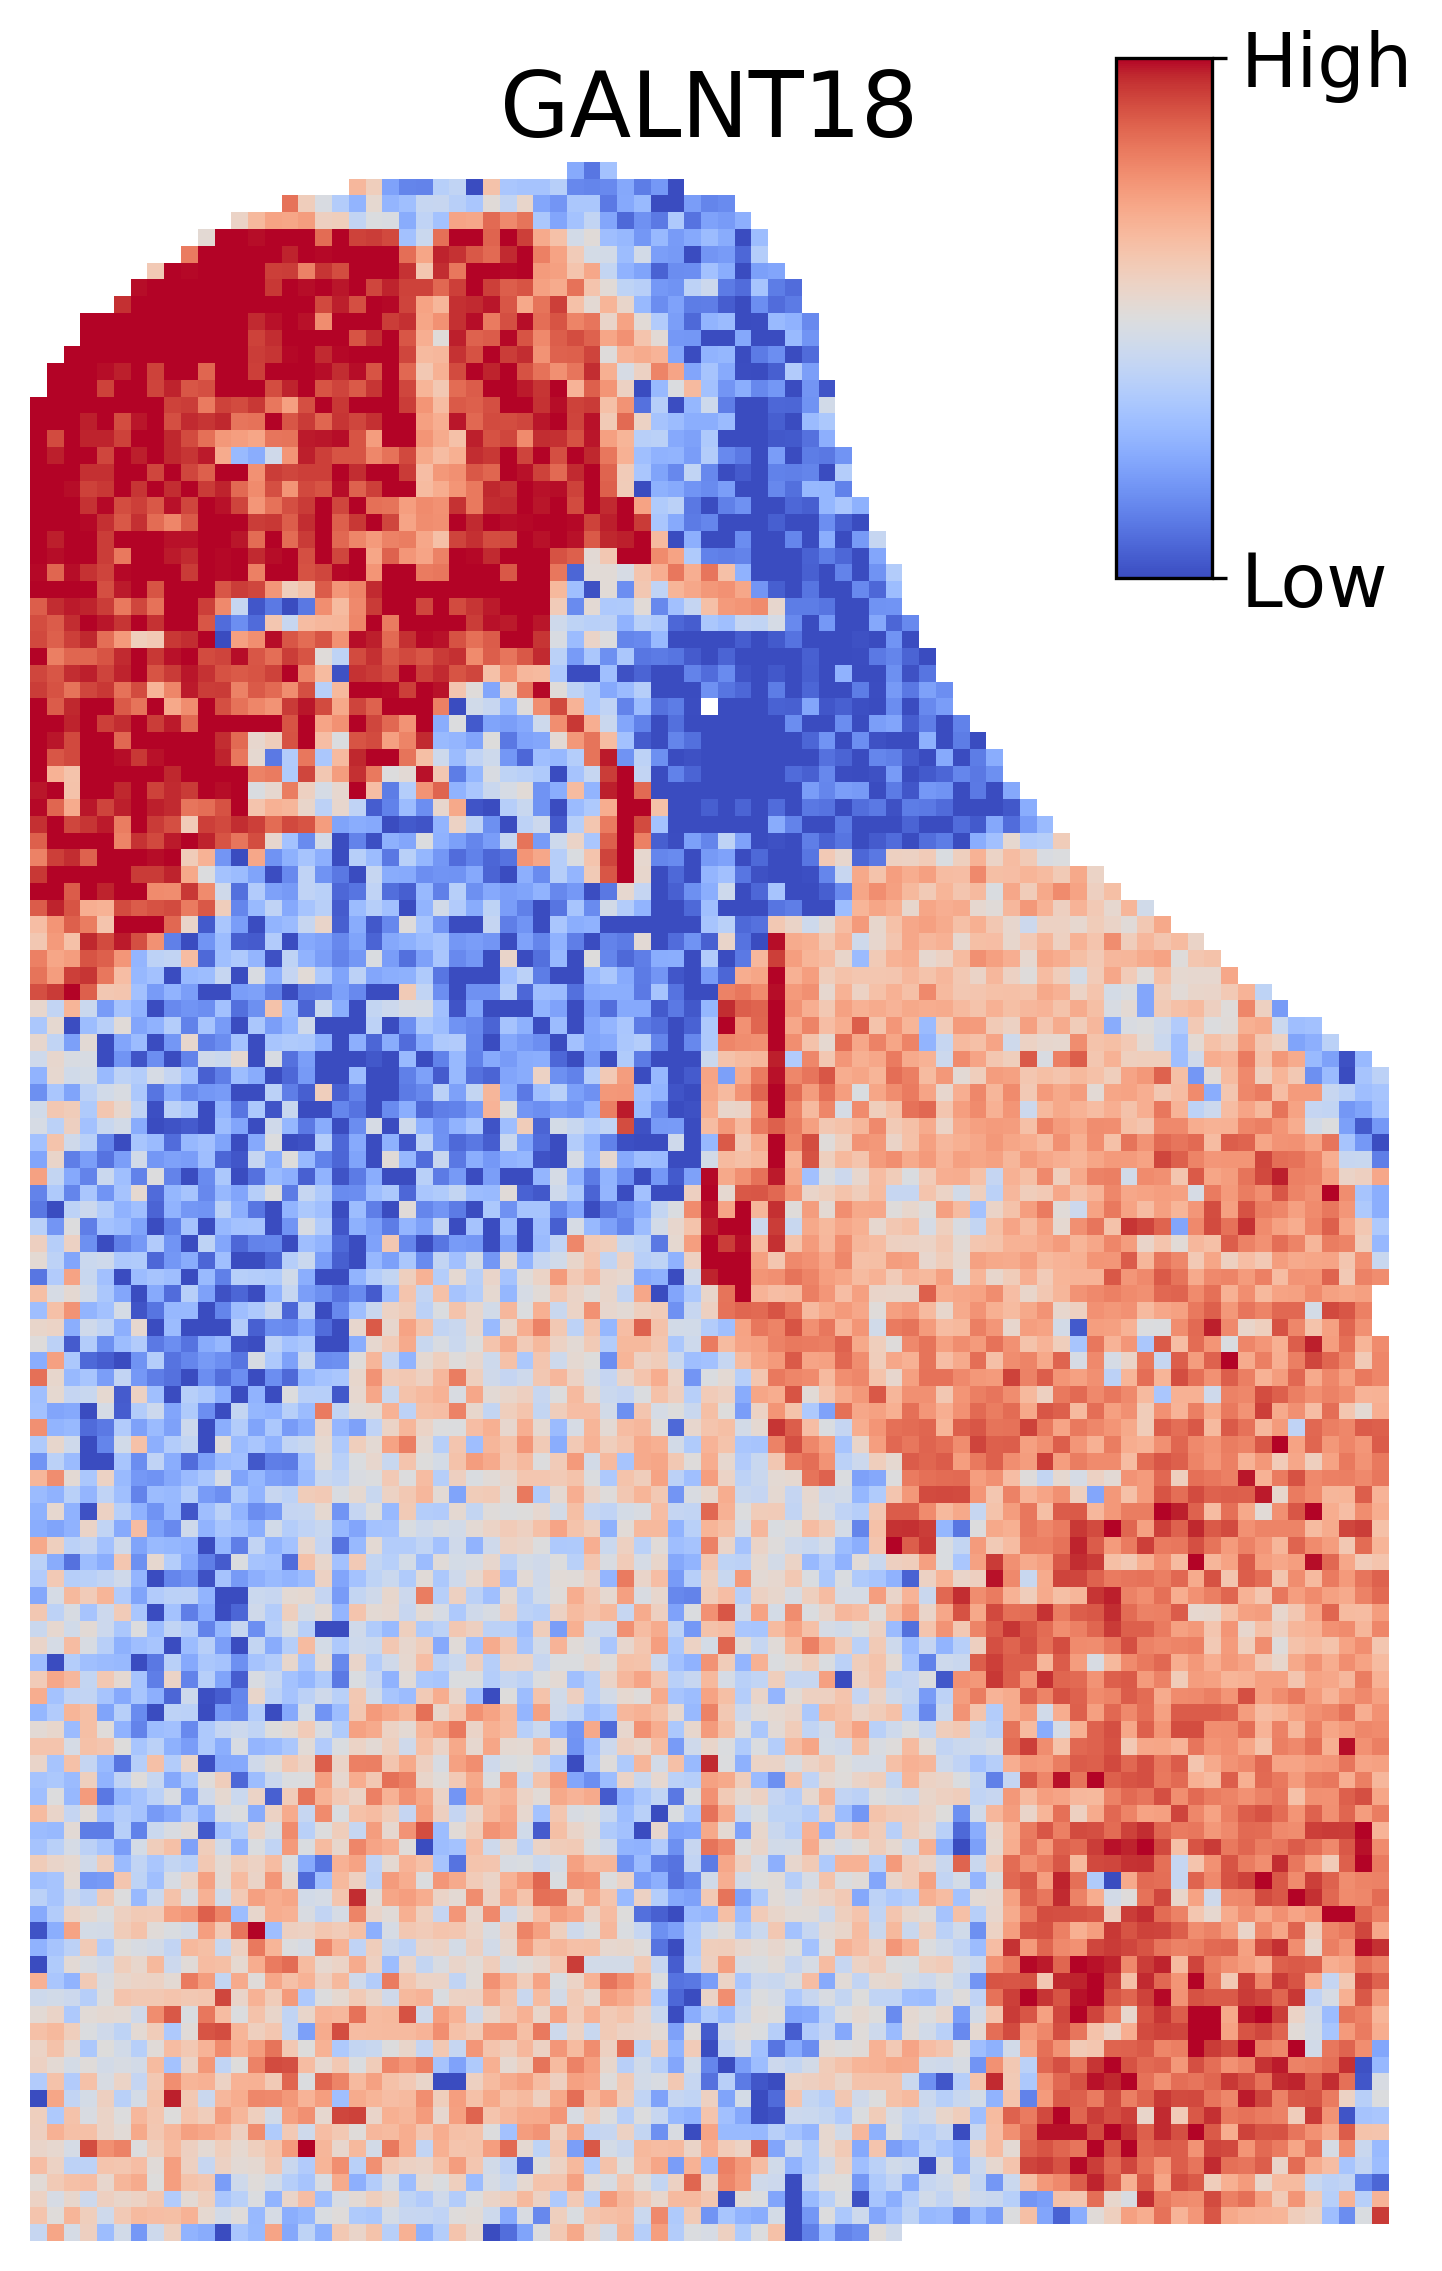

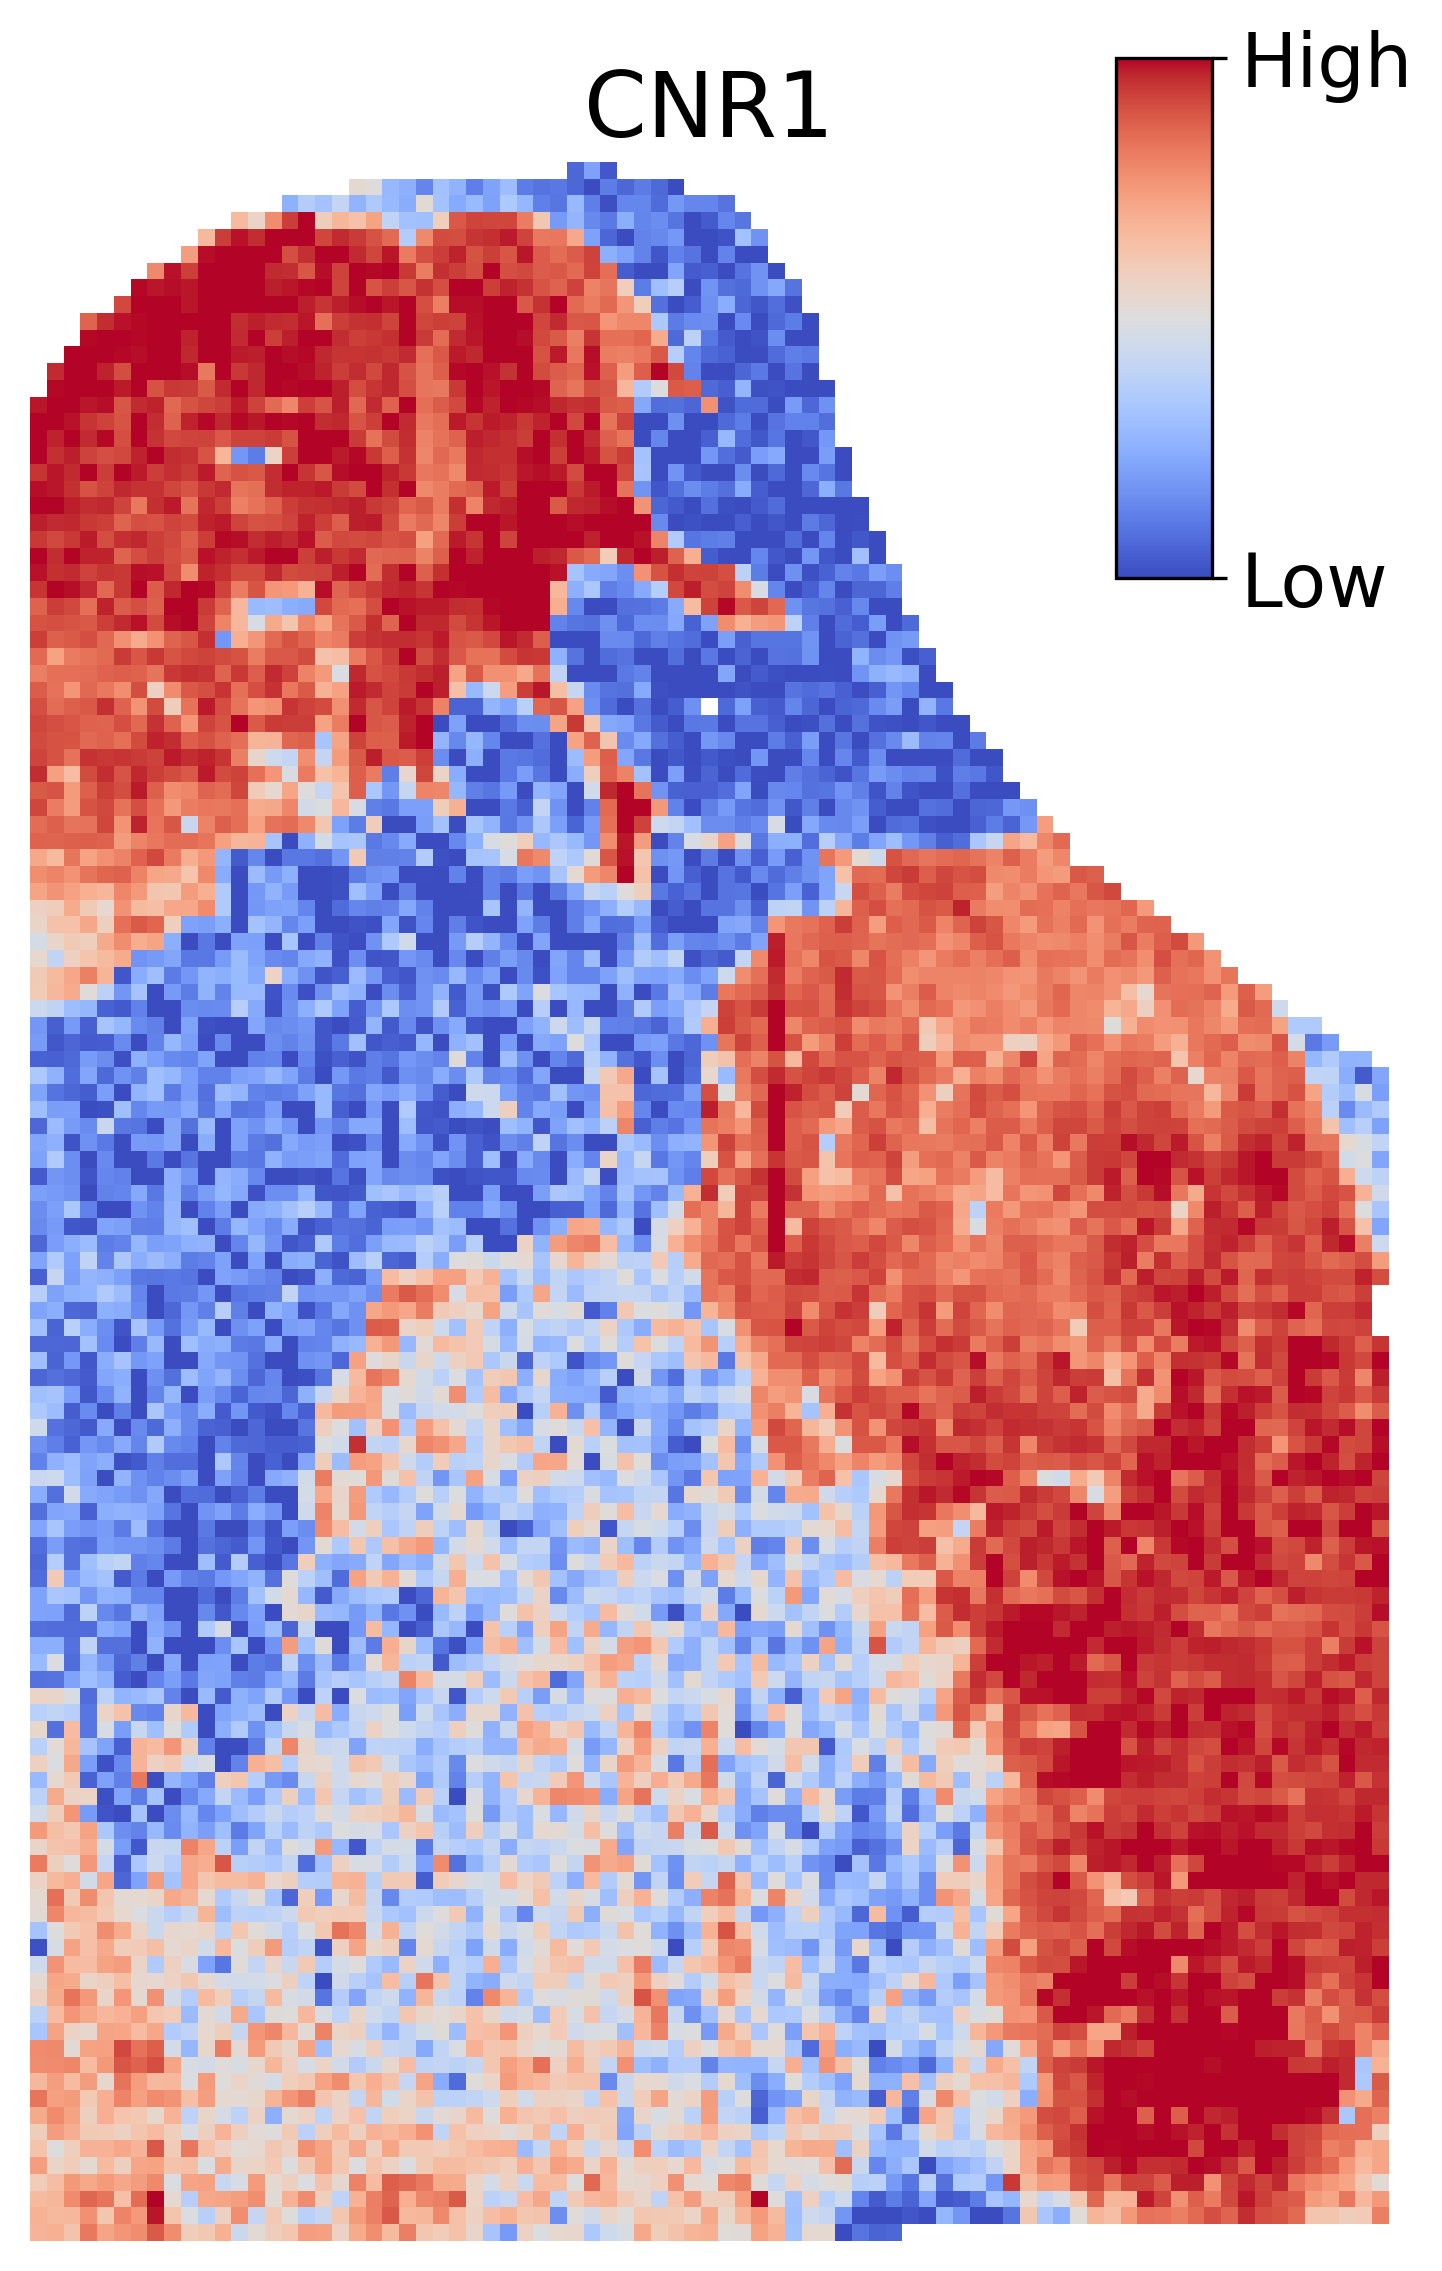

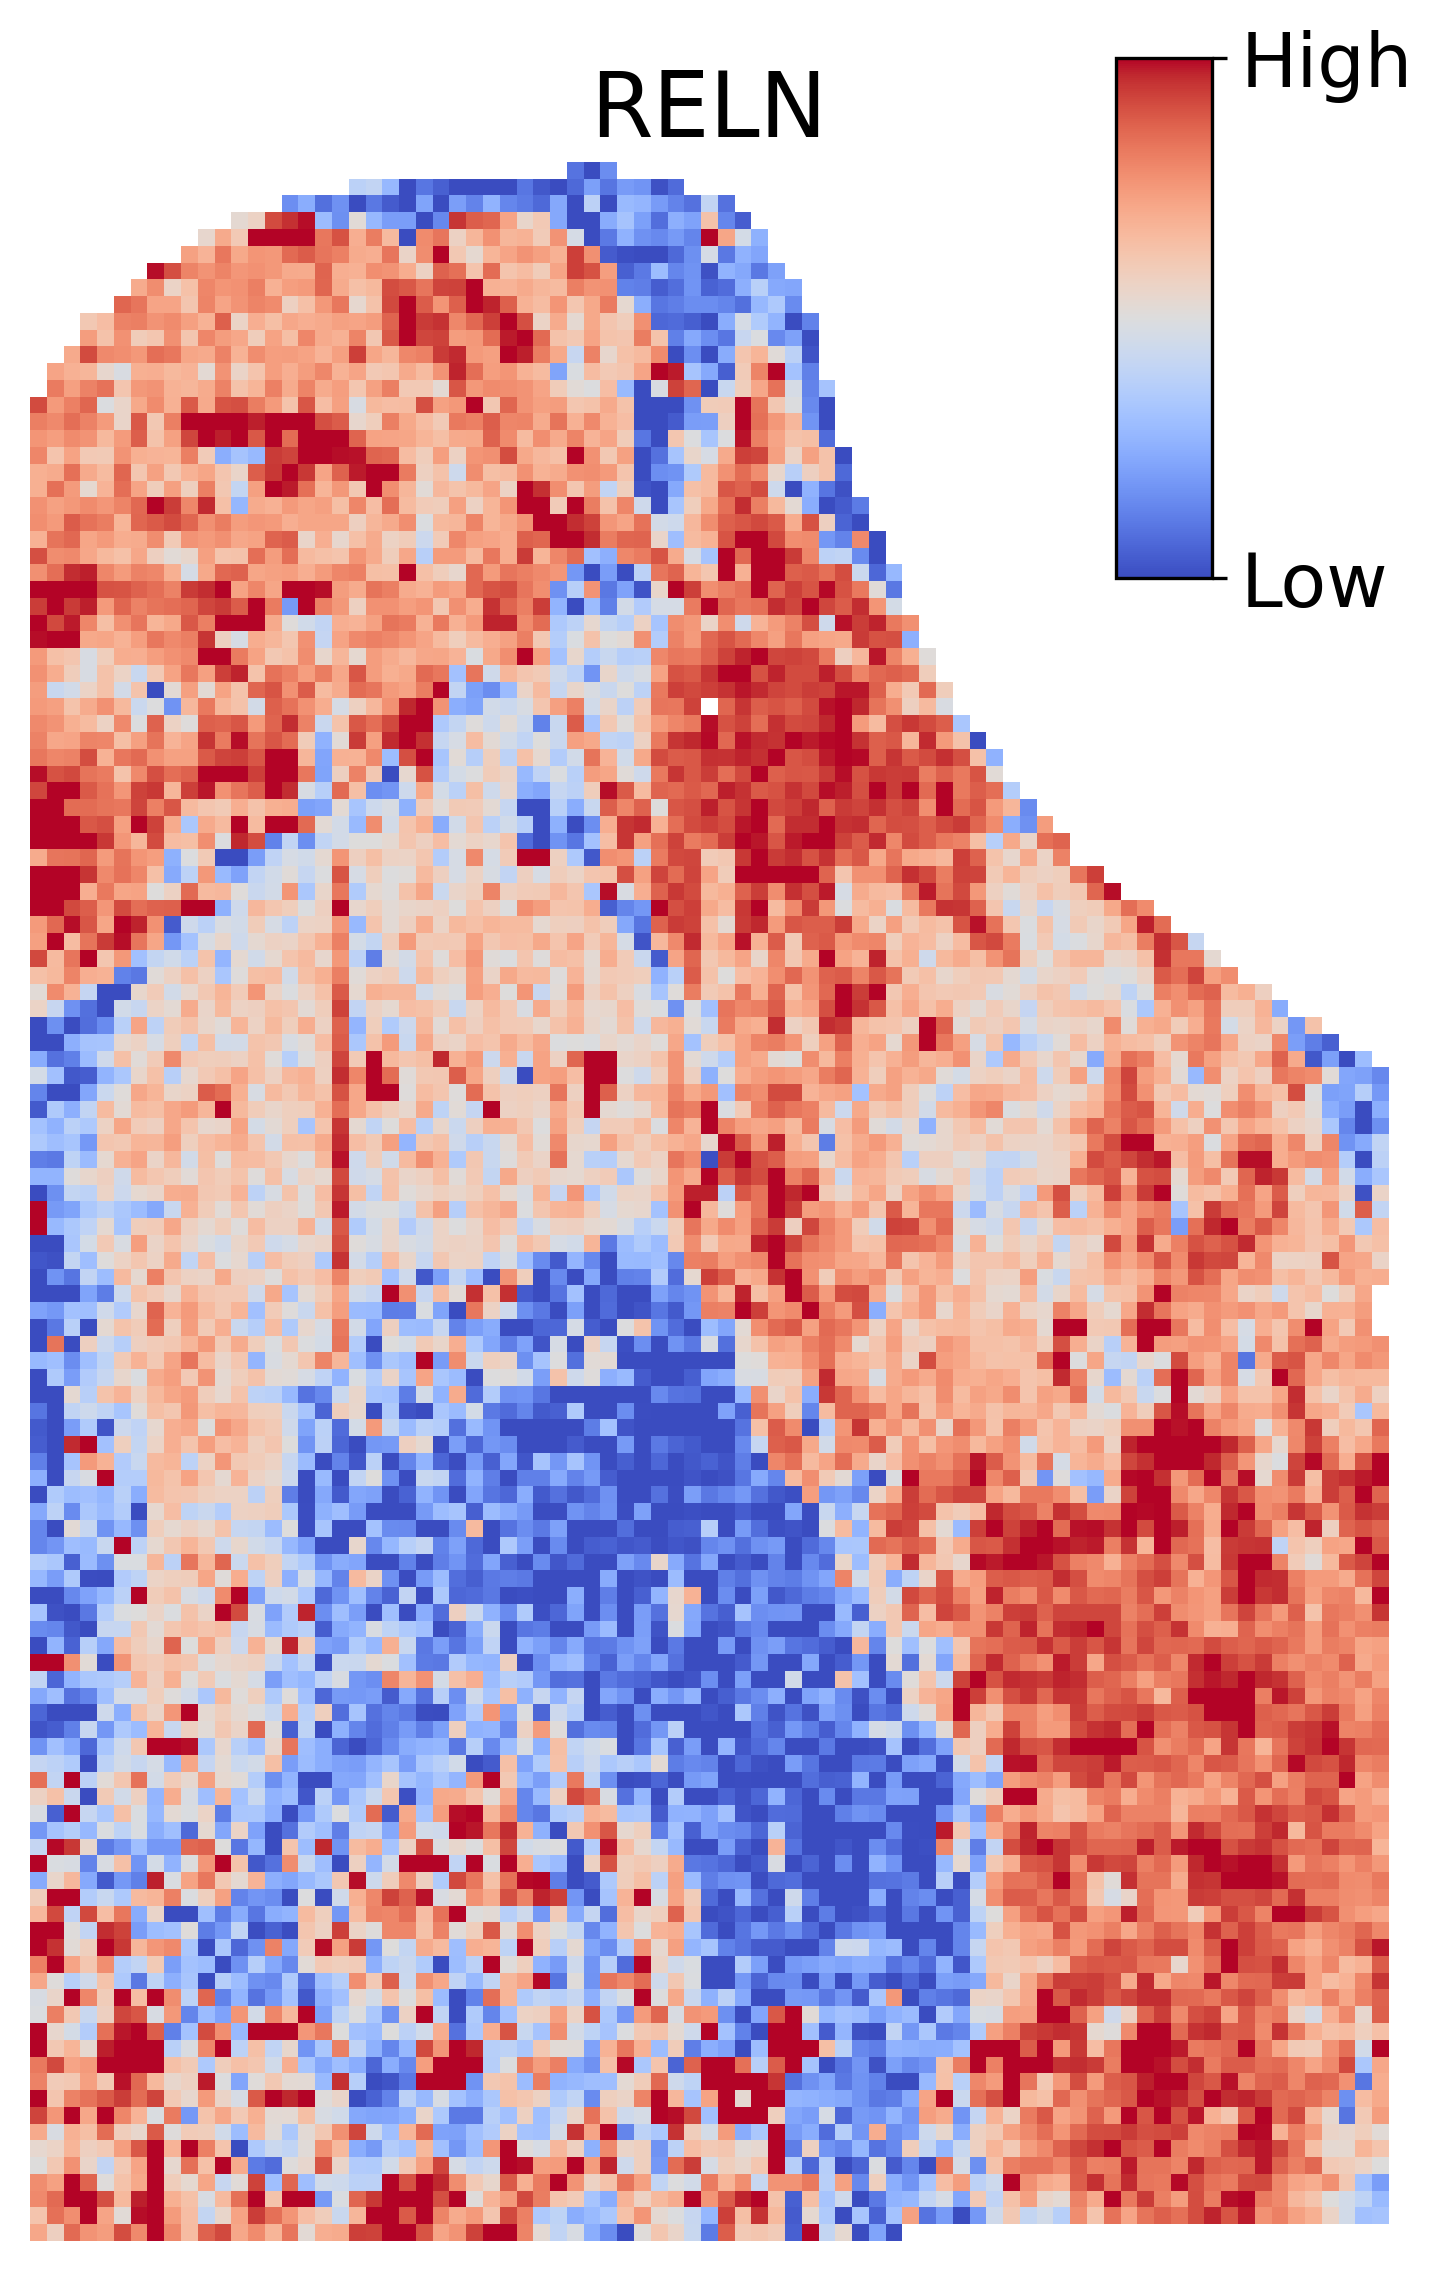

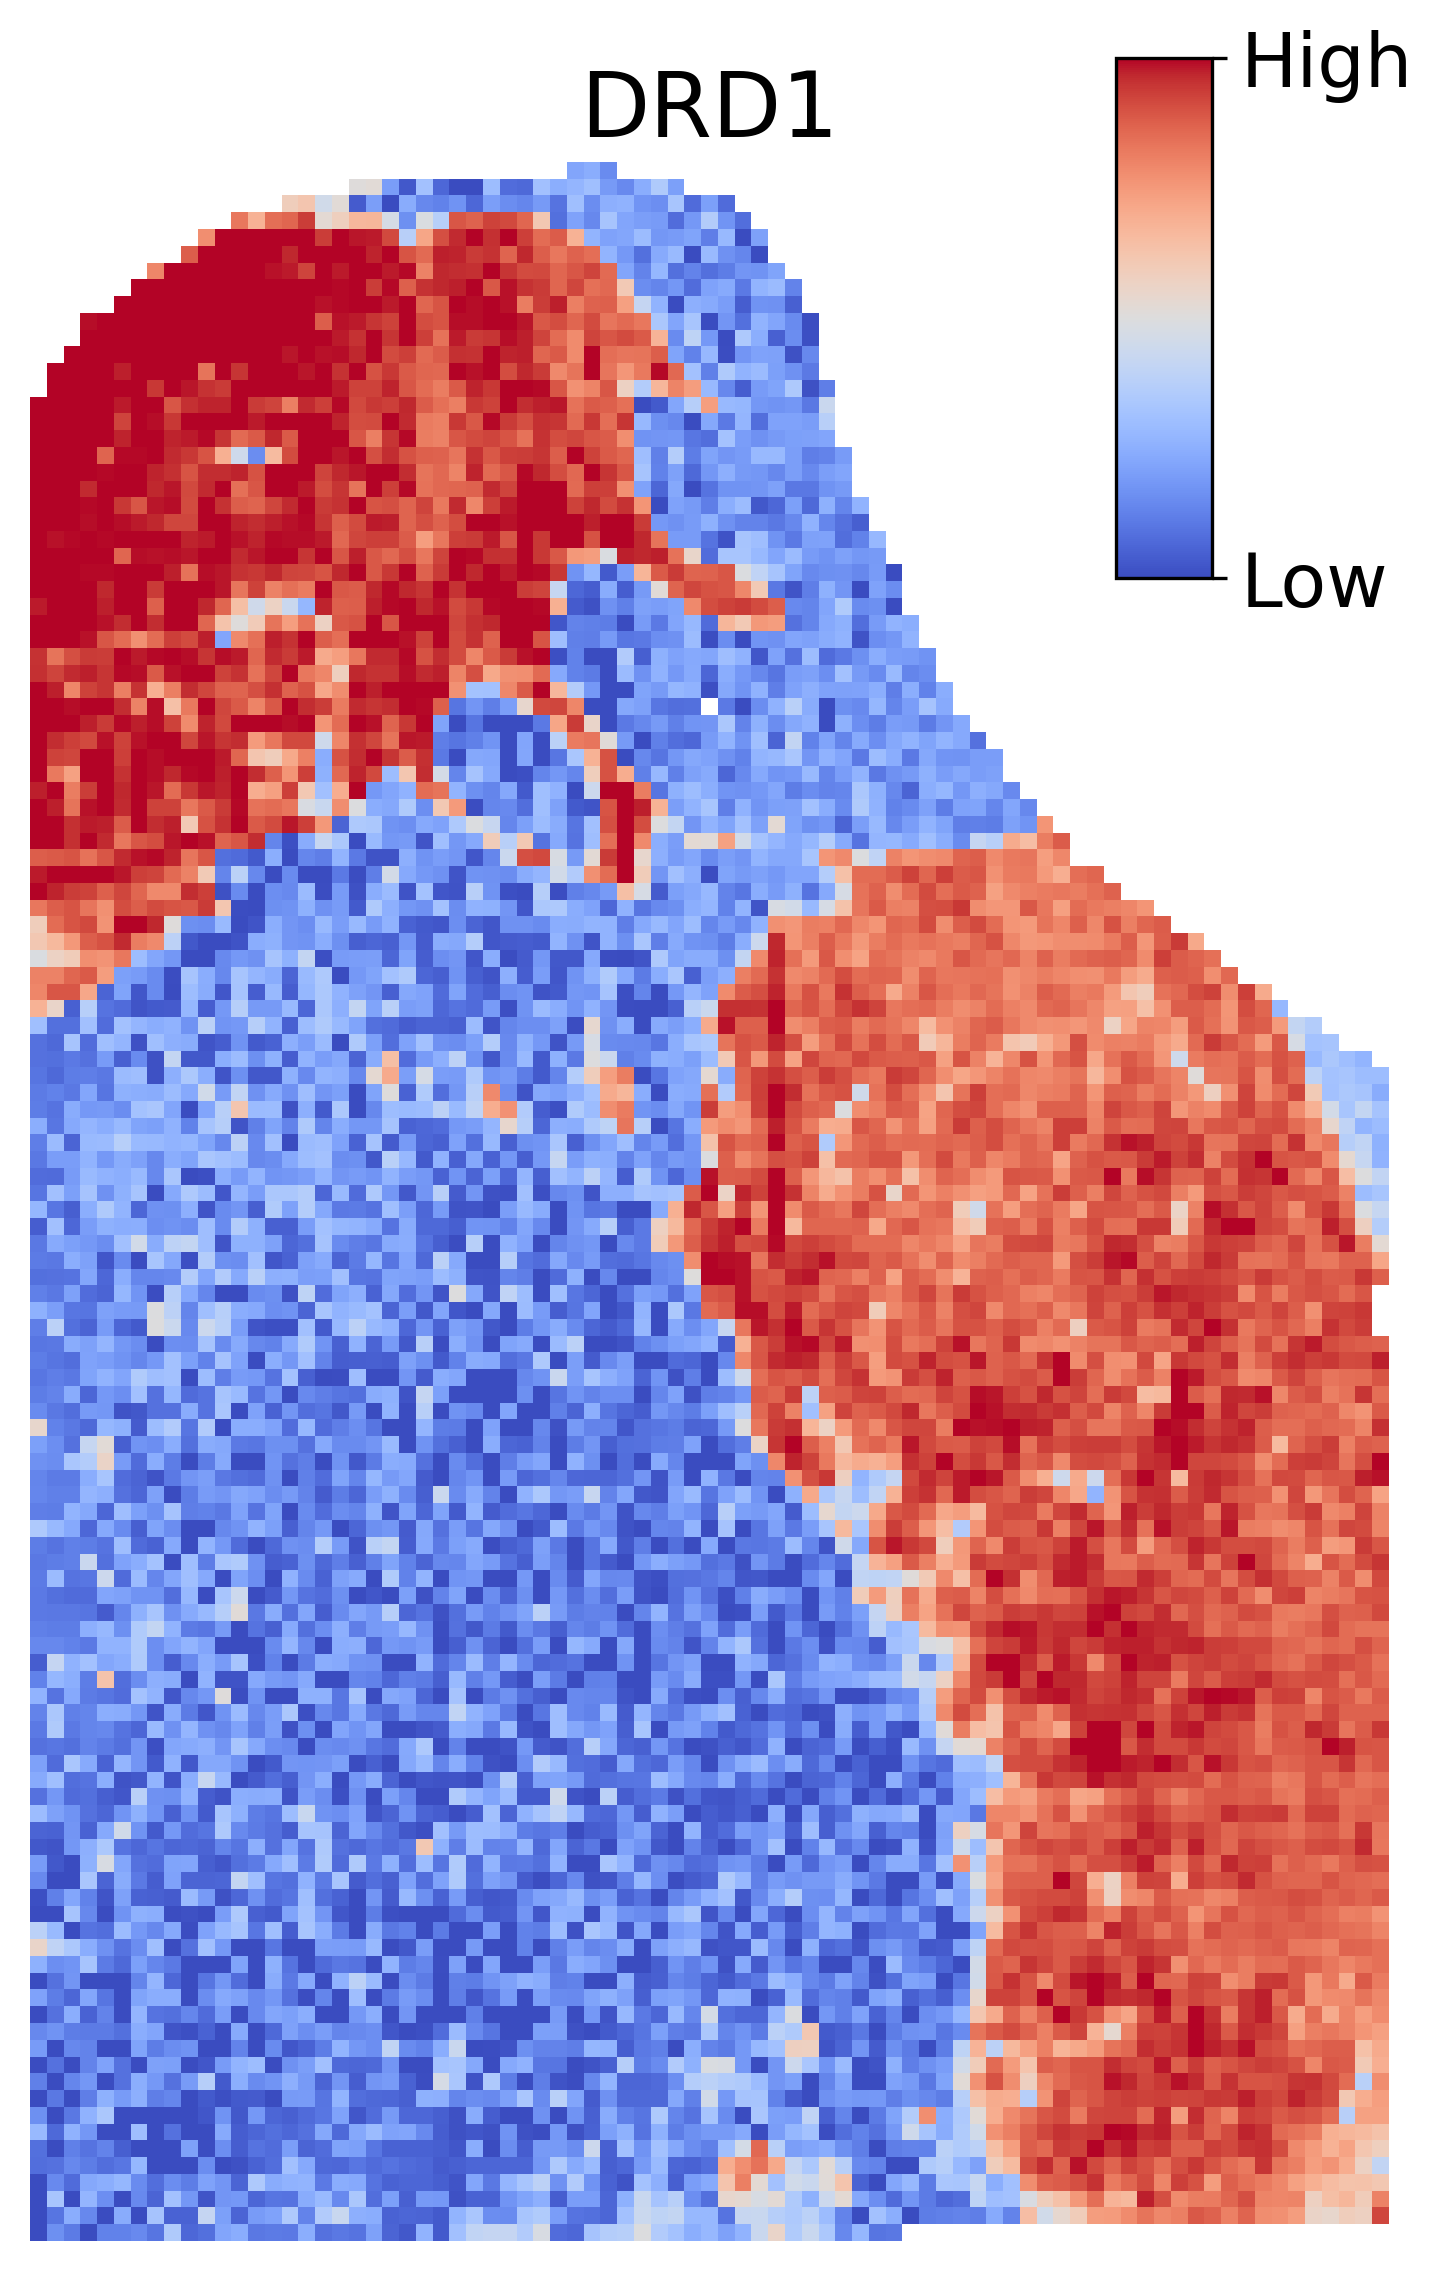

In [173]:
import matplotlib as mpl
for gn in top_gns:
    ign = list(gns).index(gn)#PENK,RELN
    Mlog = np.log(Mcts)
    Mlog = Mlog-np.mean(Mlog,axis=-1)[:,np.newaxis]
    Mlog = Mlog-np.mean(Mlog,axis=0)[np.newaxis]

    Mloggn = Mlog[:,ign].copy()
    mgn,Mgn = np.percentile(Mloggn,5),np.percentile(Mloggn,95)
    colgn = mpl.cm.coolwarm(np.clip((Mloggn-mgn)/(Mgn-mgn),0,1))[:,:3]
    imgn = np.ones(list(np.max(XfovT,axis=0)+1)+[3])
    imgn[tuple(XfovT.T)]=colgn[:,:3]

    fig,ax = plt.subplots(1,1, dpi = 300, figsize = (6,9))
    hd = ax.imshow(imgn)
    ax.title.set_text(gn)
    # plt.colorbar(hd)
    ax.set_axis_off()
    # add a scalebar 
    # add colorbar
    bbox = ax.get_position()
    ax_cbar = fig.add_axes([bbox.xmin + 0.8*bbox.width, bbox.ymin + 0.8*bbox.height, 0.07*bbox.width, 0.25*bbox.height])


    colorNorm = np.clip((Mloggn-mgn)/(Mgn-mgn),0,1)
    cmap = mpl.cm.coolwarm
    norm = mpl.colors.Normalize(vmin=colorNorm.min(), vmax=colorNorm.max())

    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                cax=ax_cbar,)
    ax_cbar.set_yticks([0,1],['Low','High'])
    plt.savefig(r'./figures' + f'spatial_Extracellular_Expression_map_{gn}.png',bbox_inches = 'tight')
    plt.savefig(r'./figures' + f'spatial_Extracellular_Expression_map_{gn}.tif',bbox_inches = 'tight')
    plt.show()


- Spatial plot for axonal guidance and cell adhesion genes

In [10]:
top_cellAdh_Axon_gns = ['SLIT2', 'SEMA3C', 'SEMA3D', 'SEMA3E', 'SEMA5A', 'SEMA5B', 'NTN1', 'UNC5C', 'EPHA3', 'EFNB2', 'RGMA', 'NRP2', 'WNT5A', 'RTN4', 'NTNG1', 'NTNG2', 'NTRK3',
                         'ADAM12', 'ADAM23', 'ADAM28', 'ADAM2', 'ADAMTS2', 'ADAMTS9', 'ADAMTS17', 'ADAMTS18', 'ADAMTS20', 'ADAMTSL1', 'ADAMTSL3', 'SULF1', 'SULF2', 'HS3ST4']


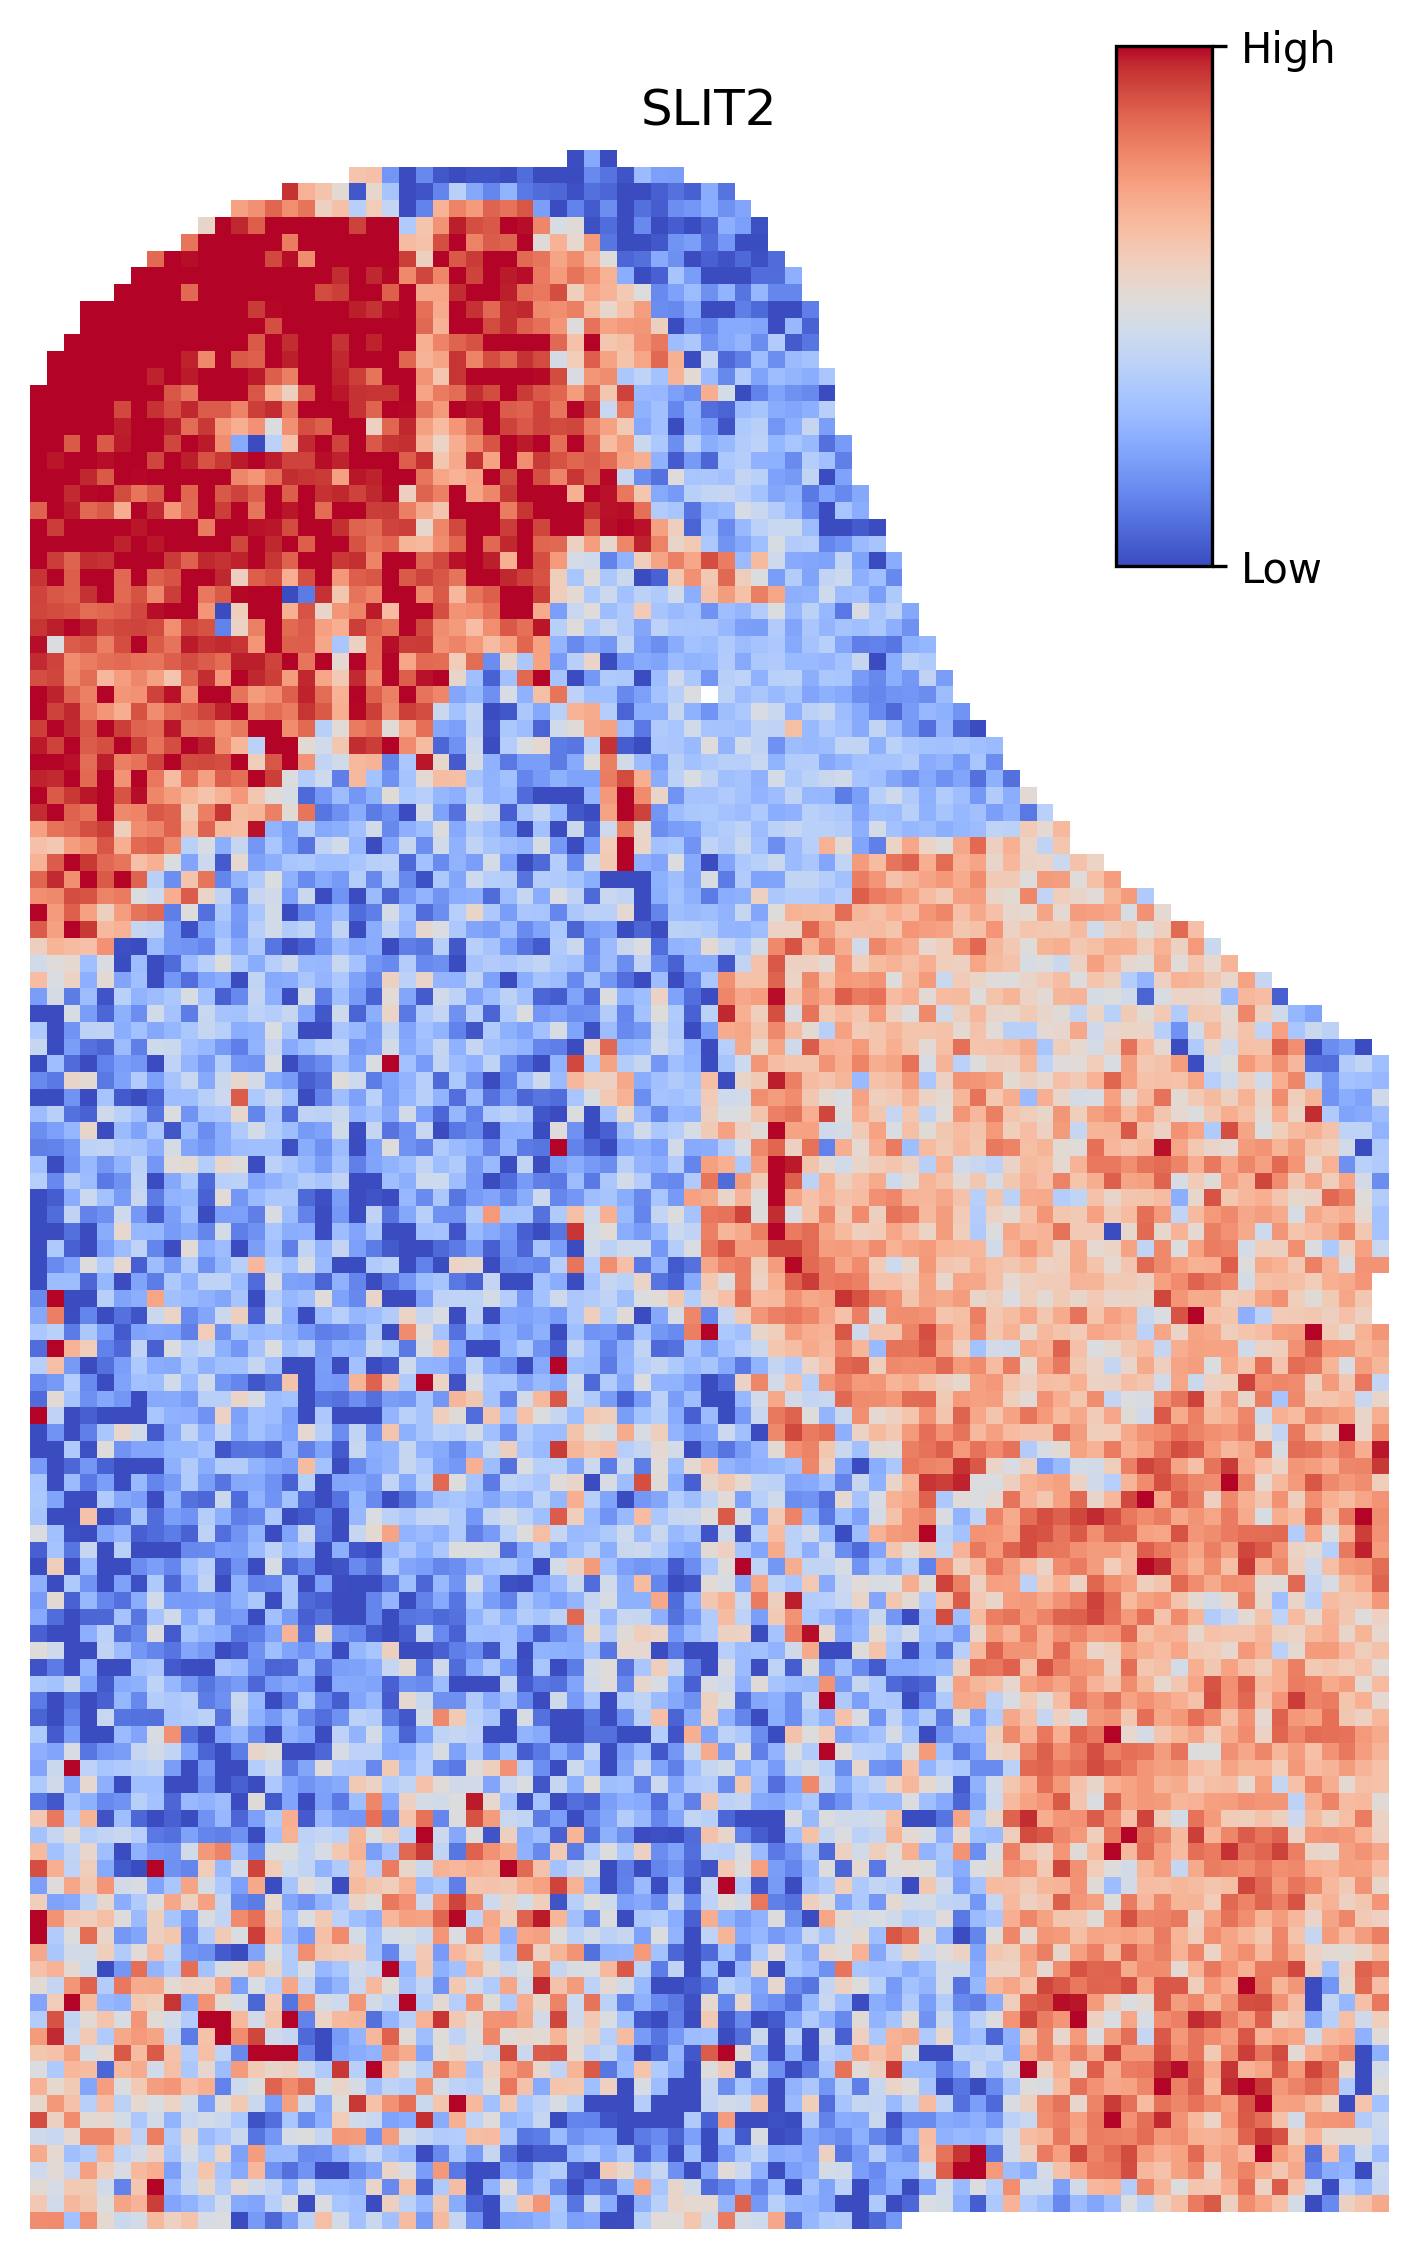

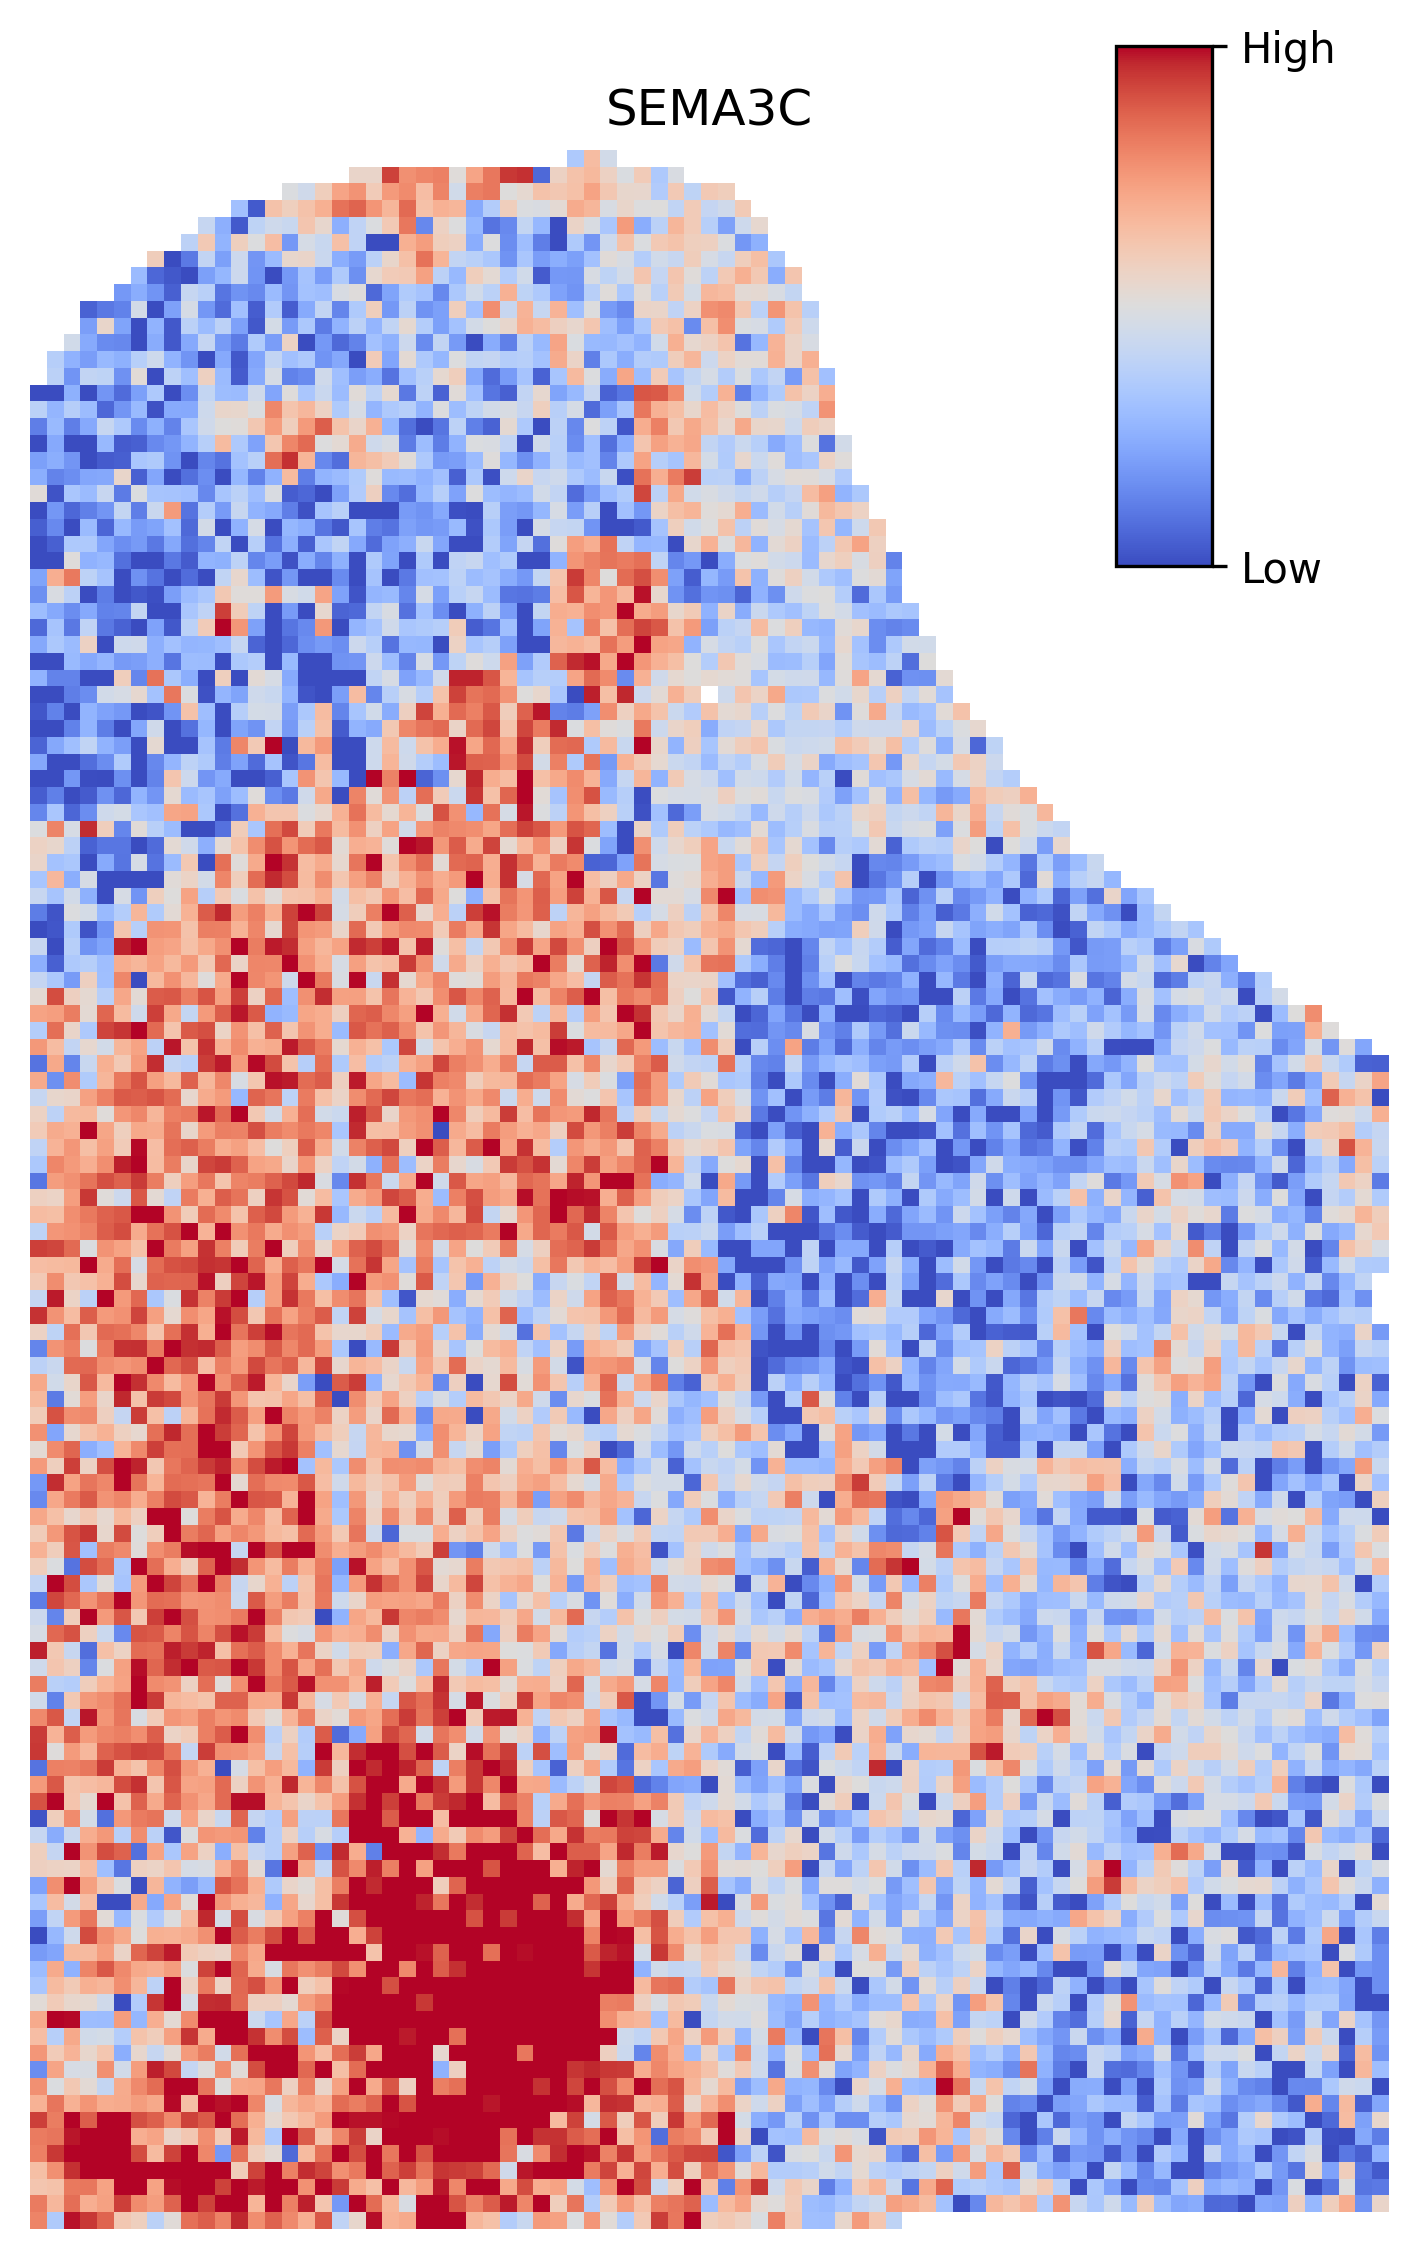

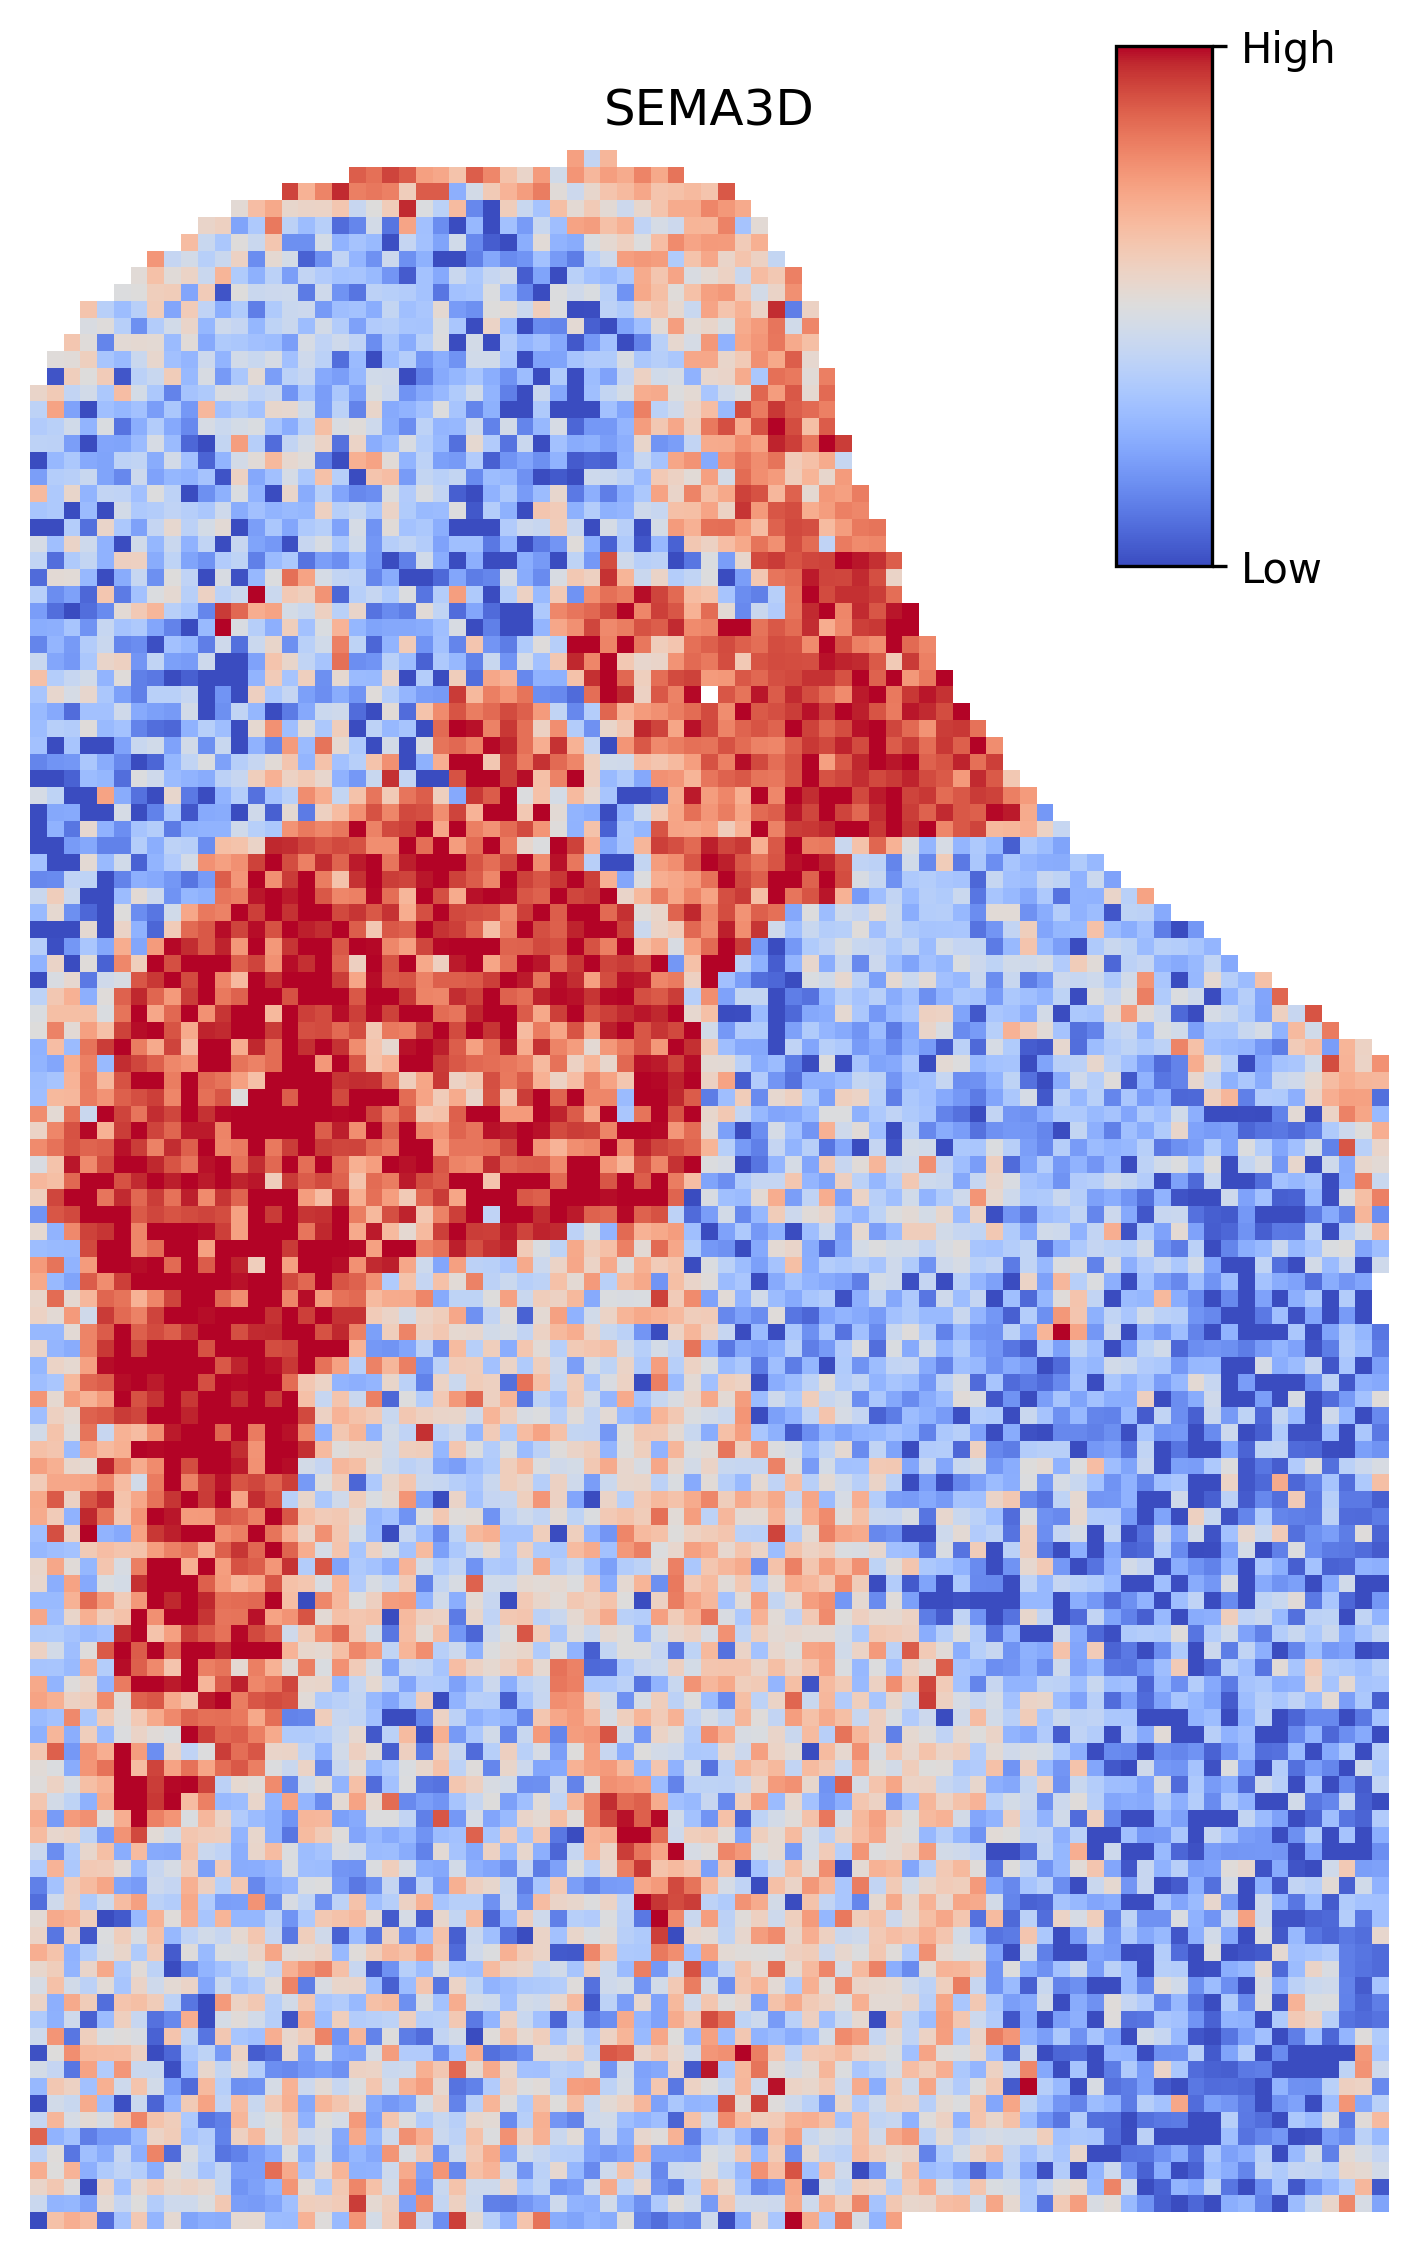

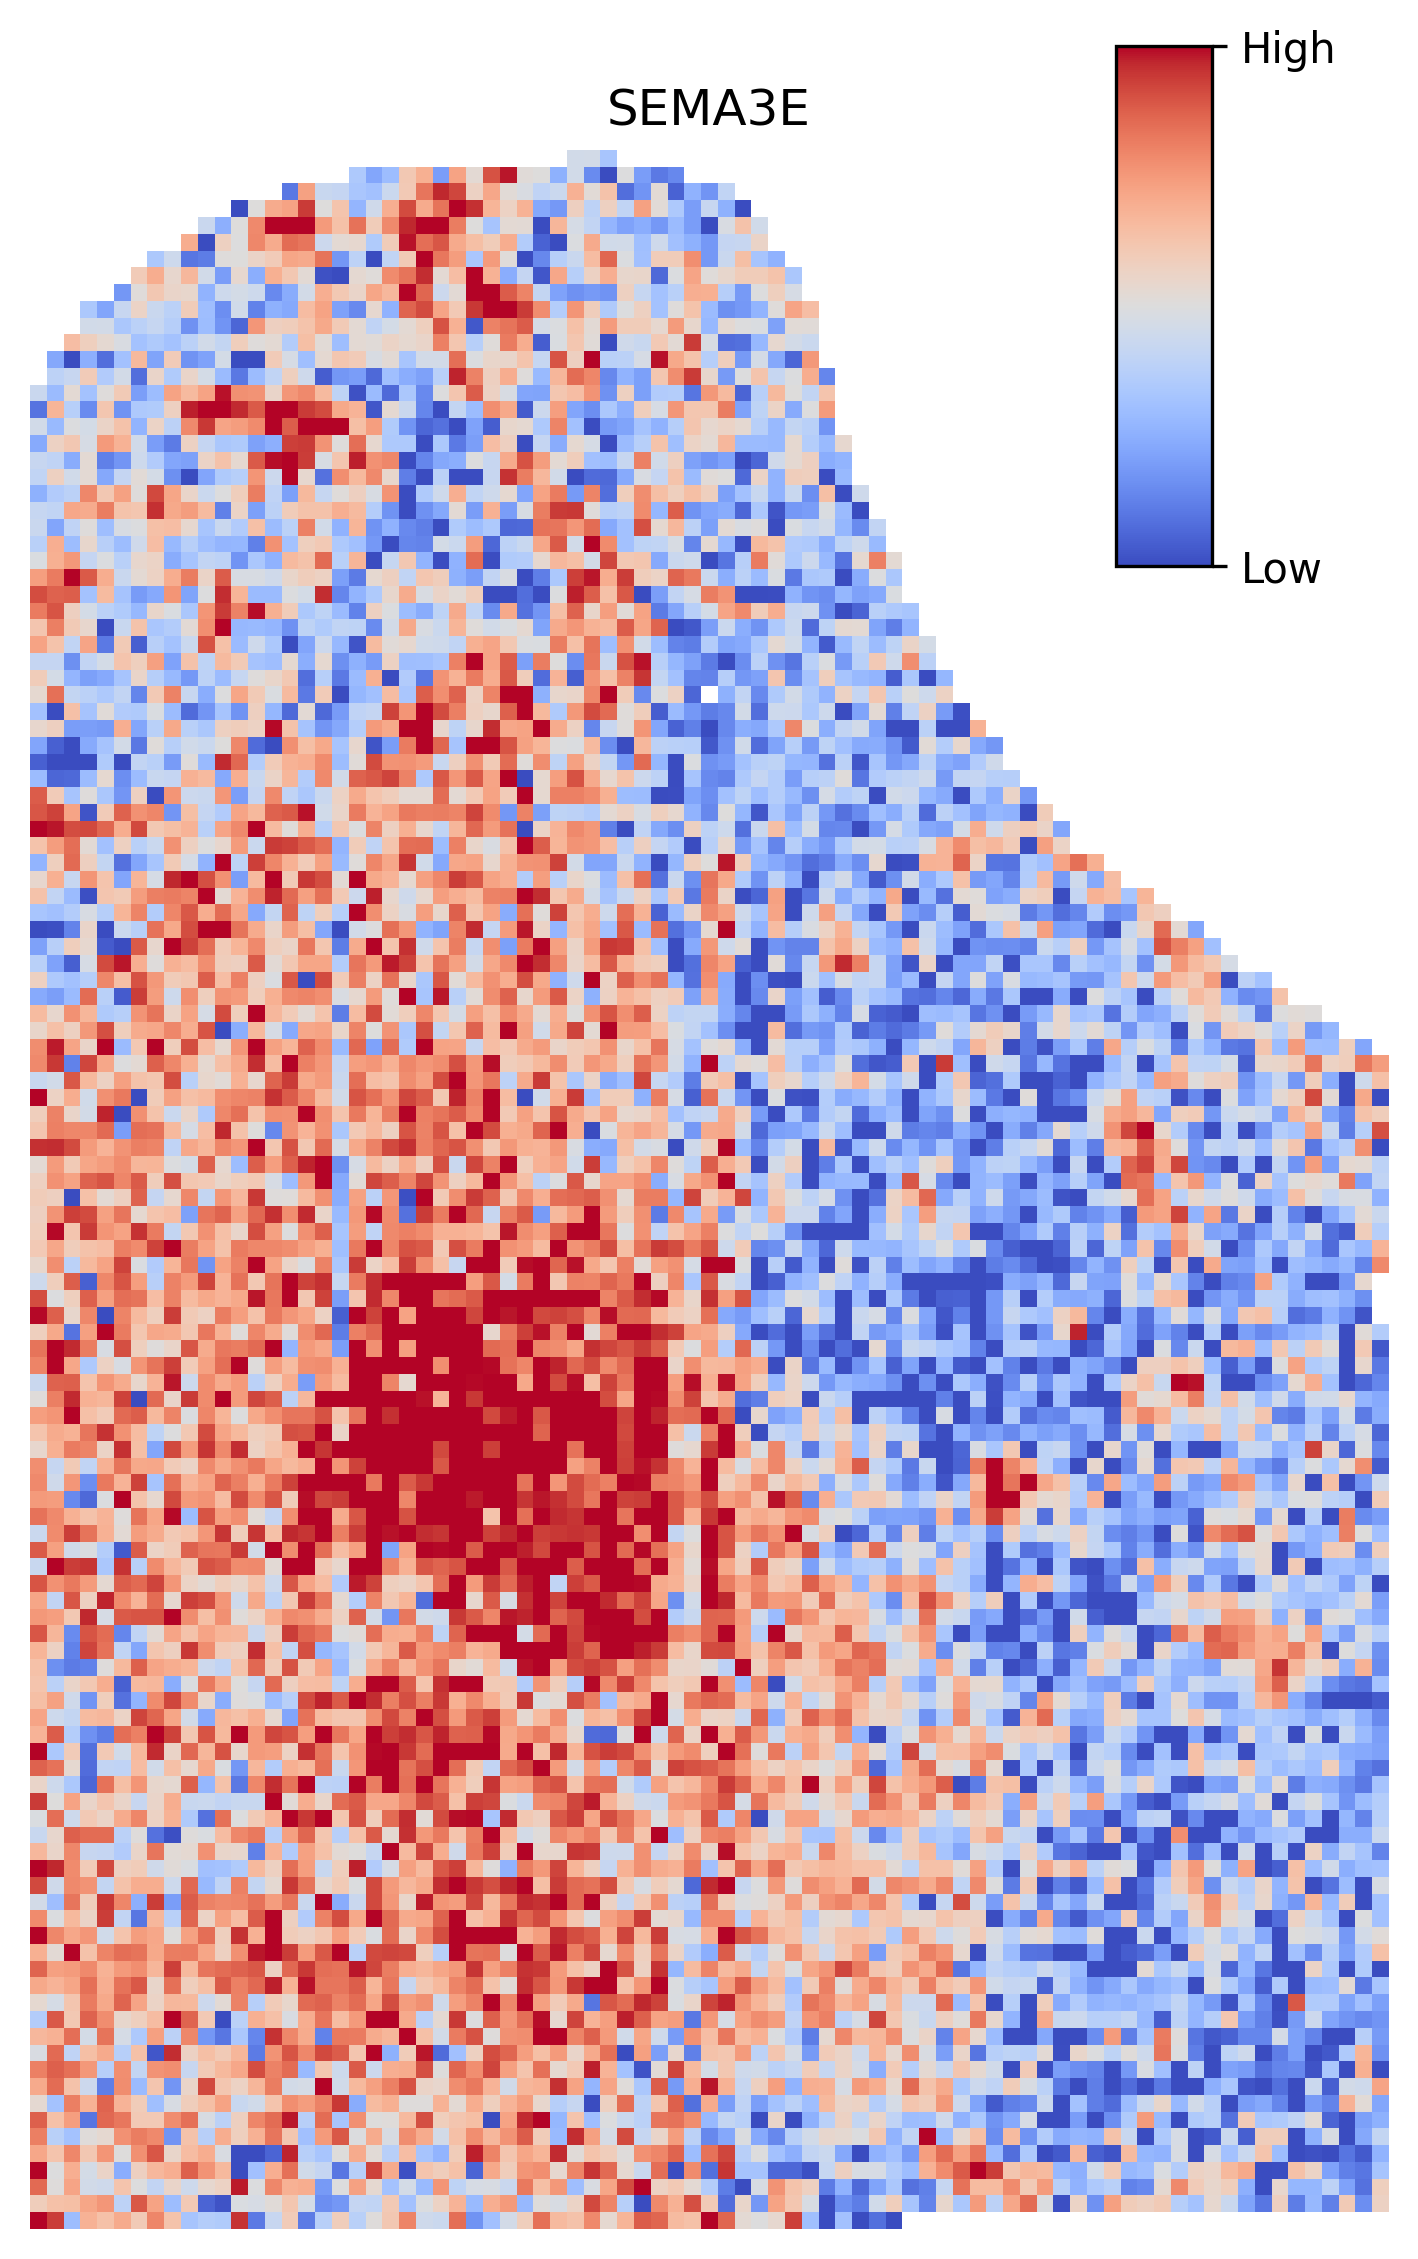

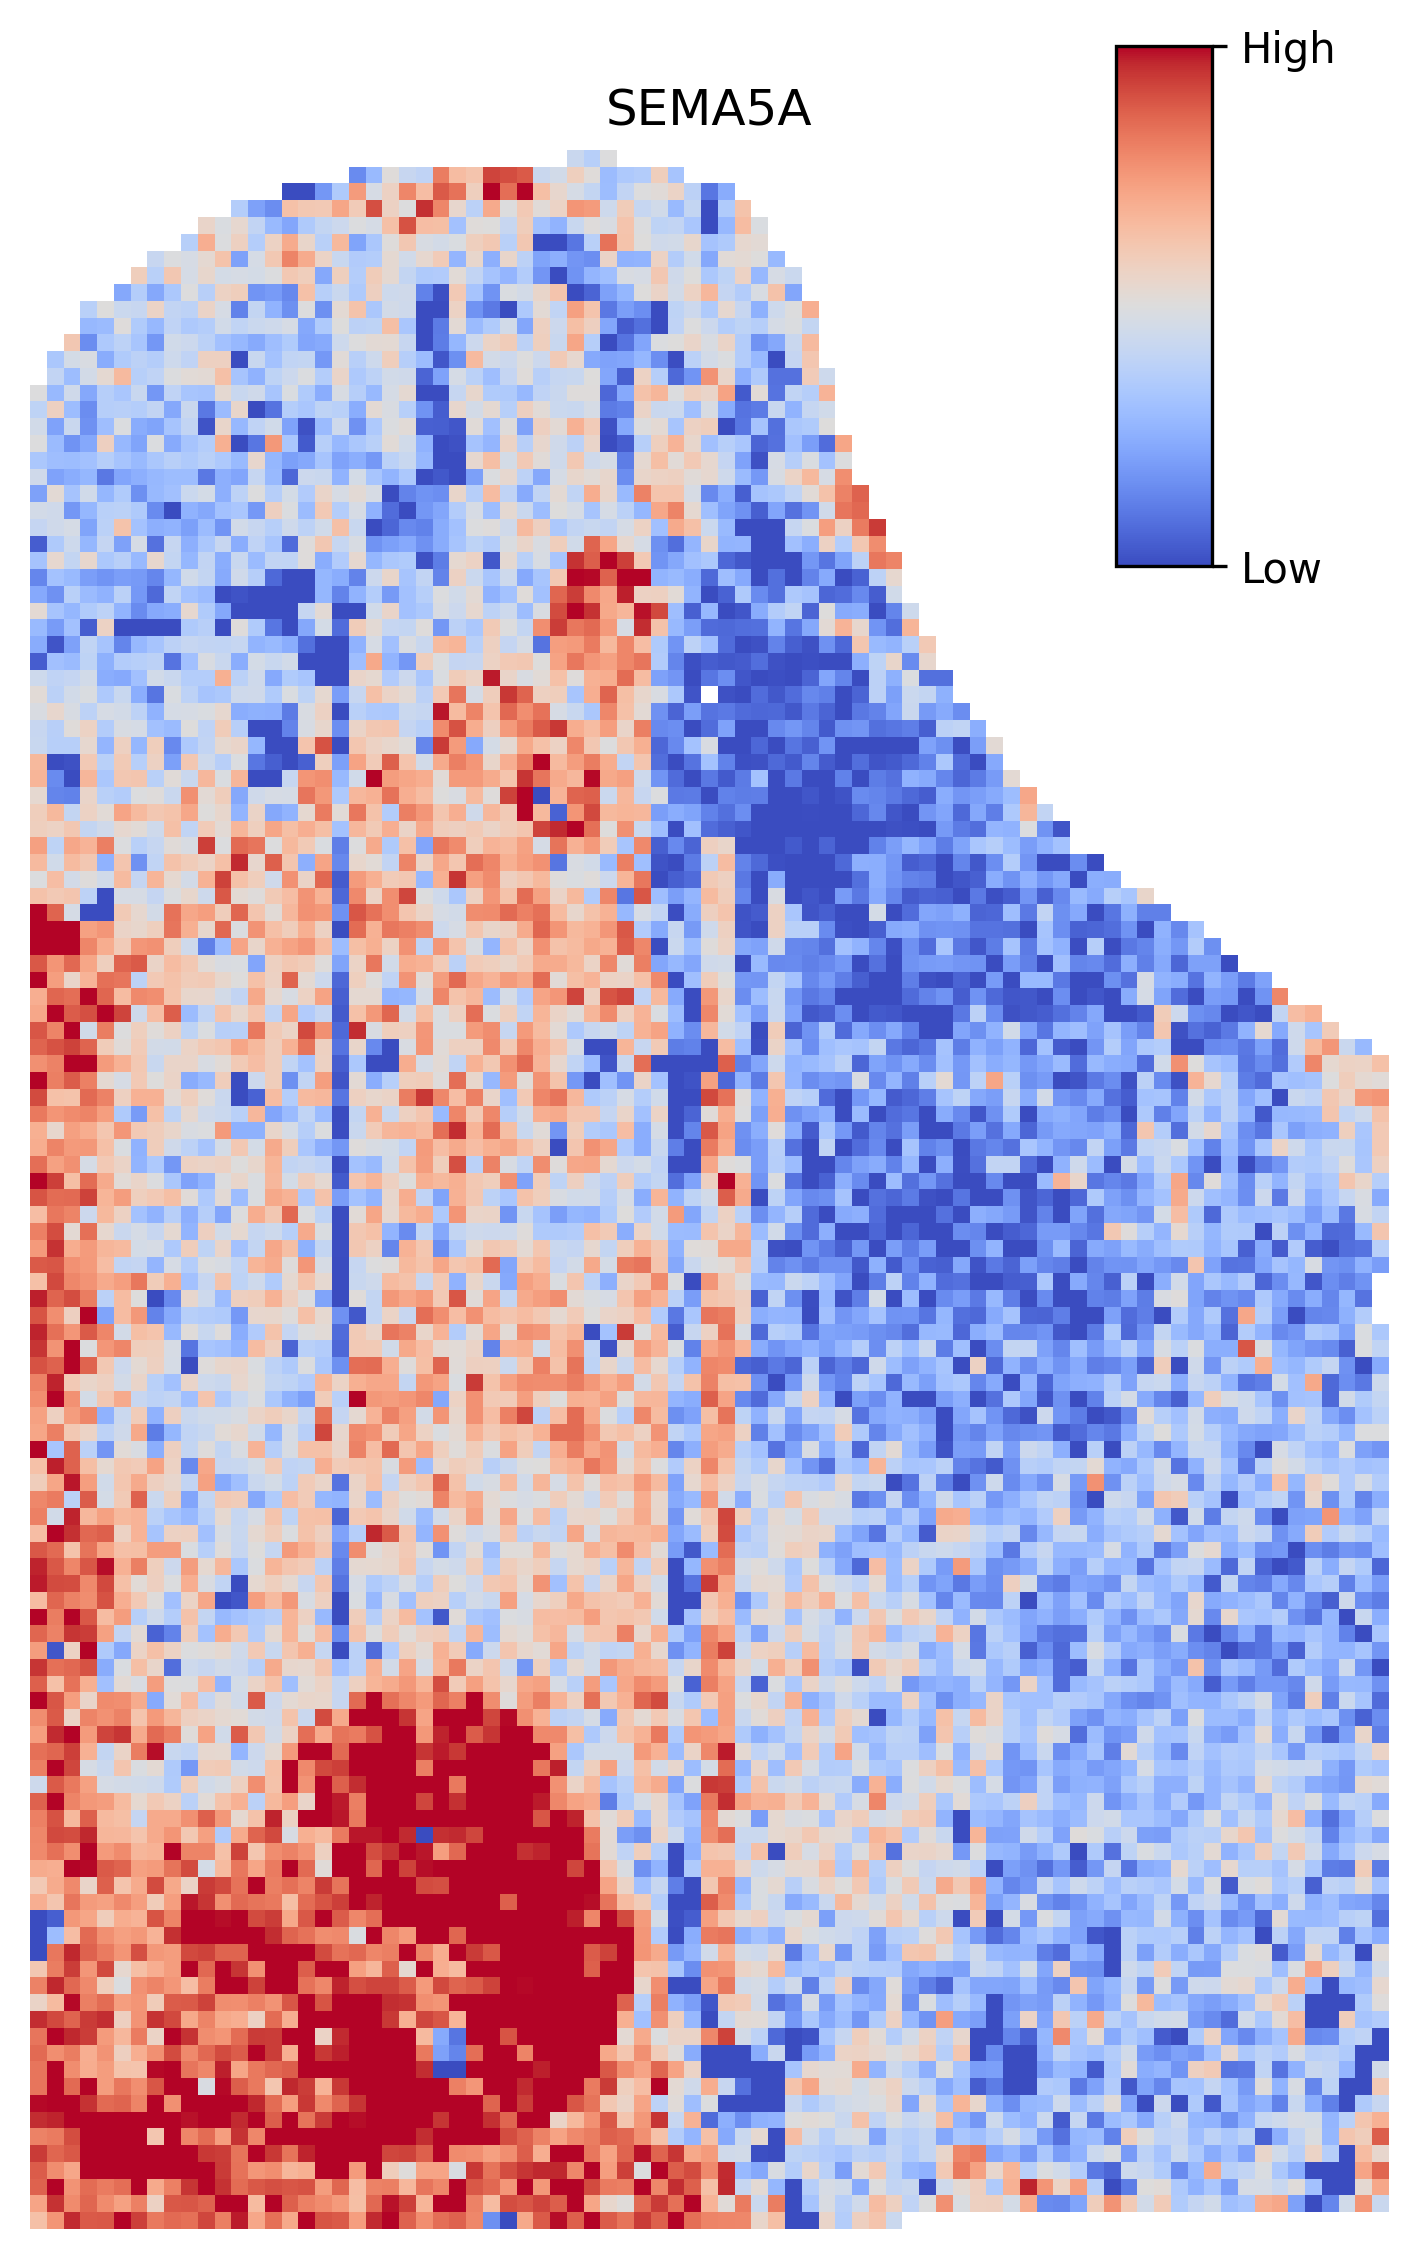

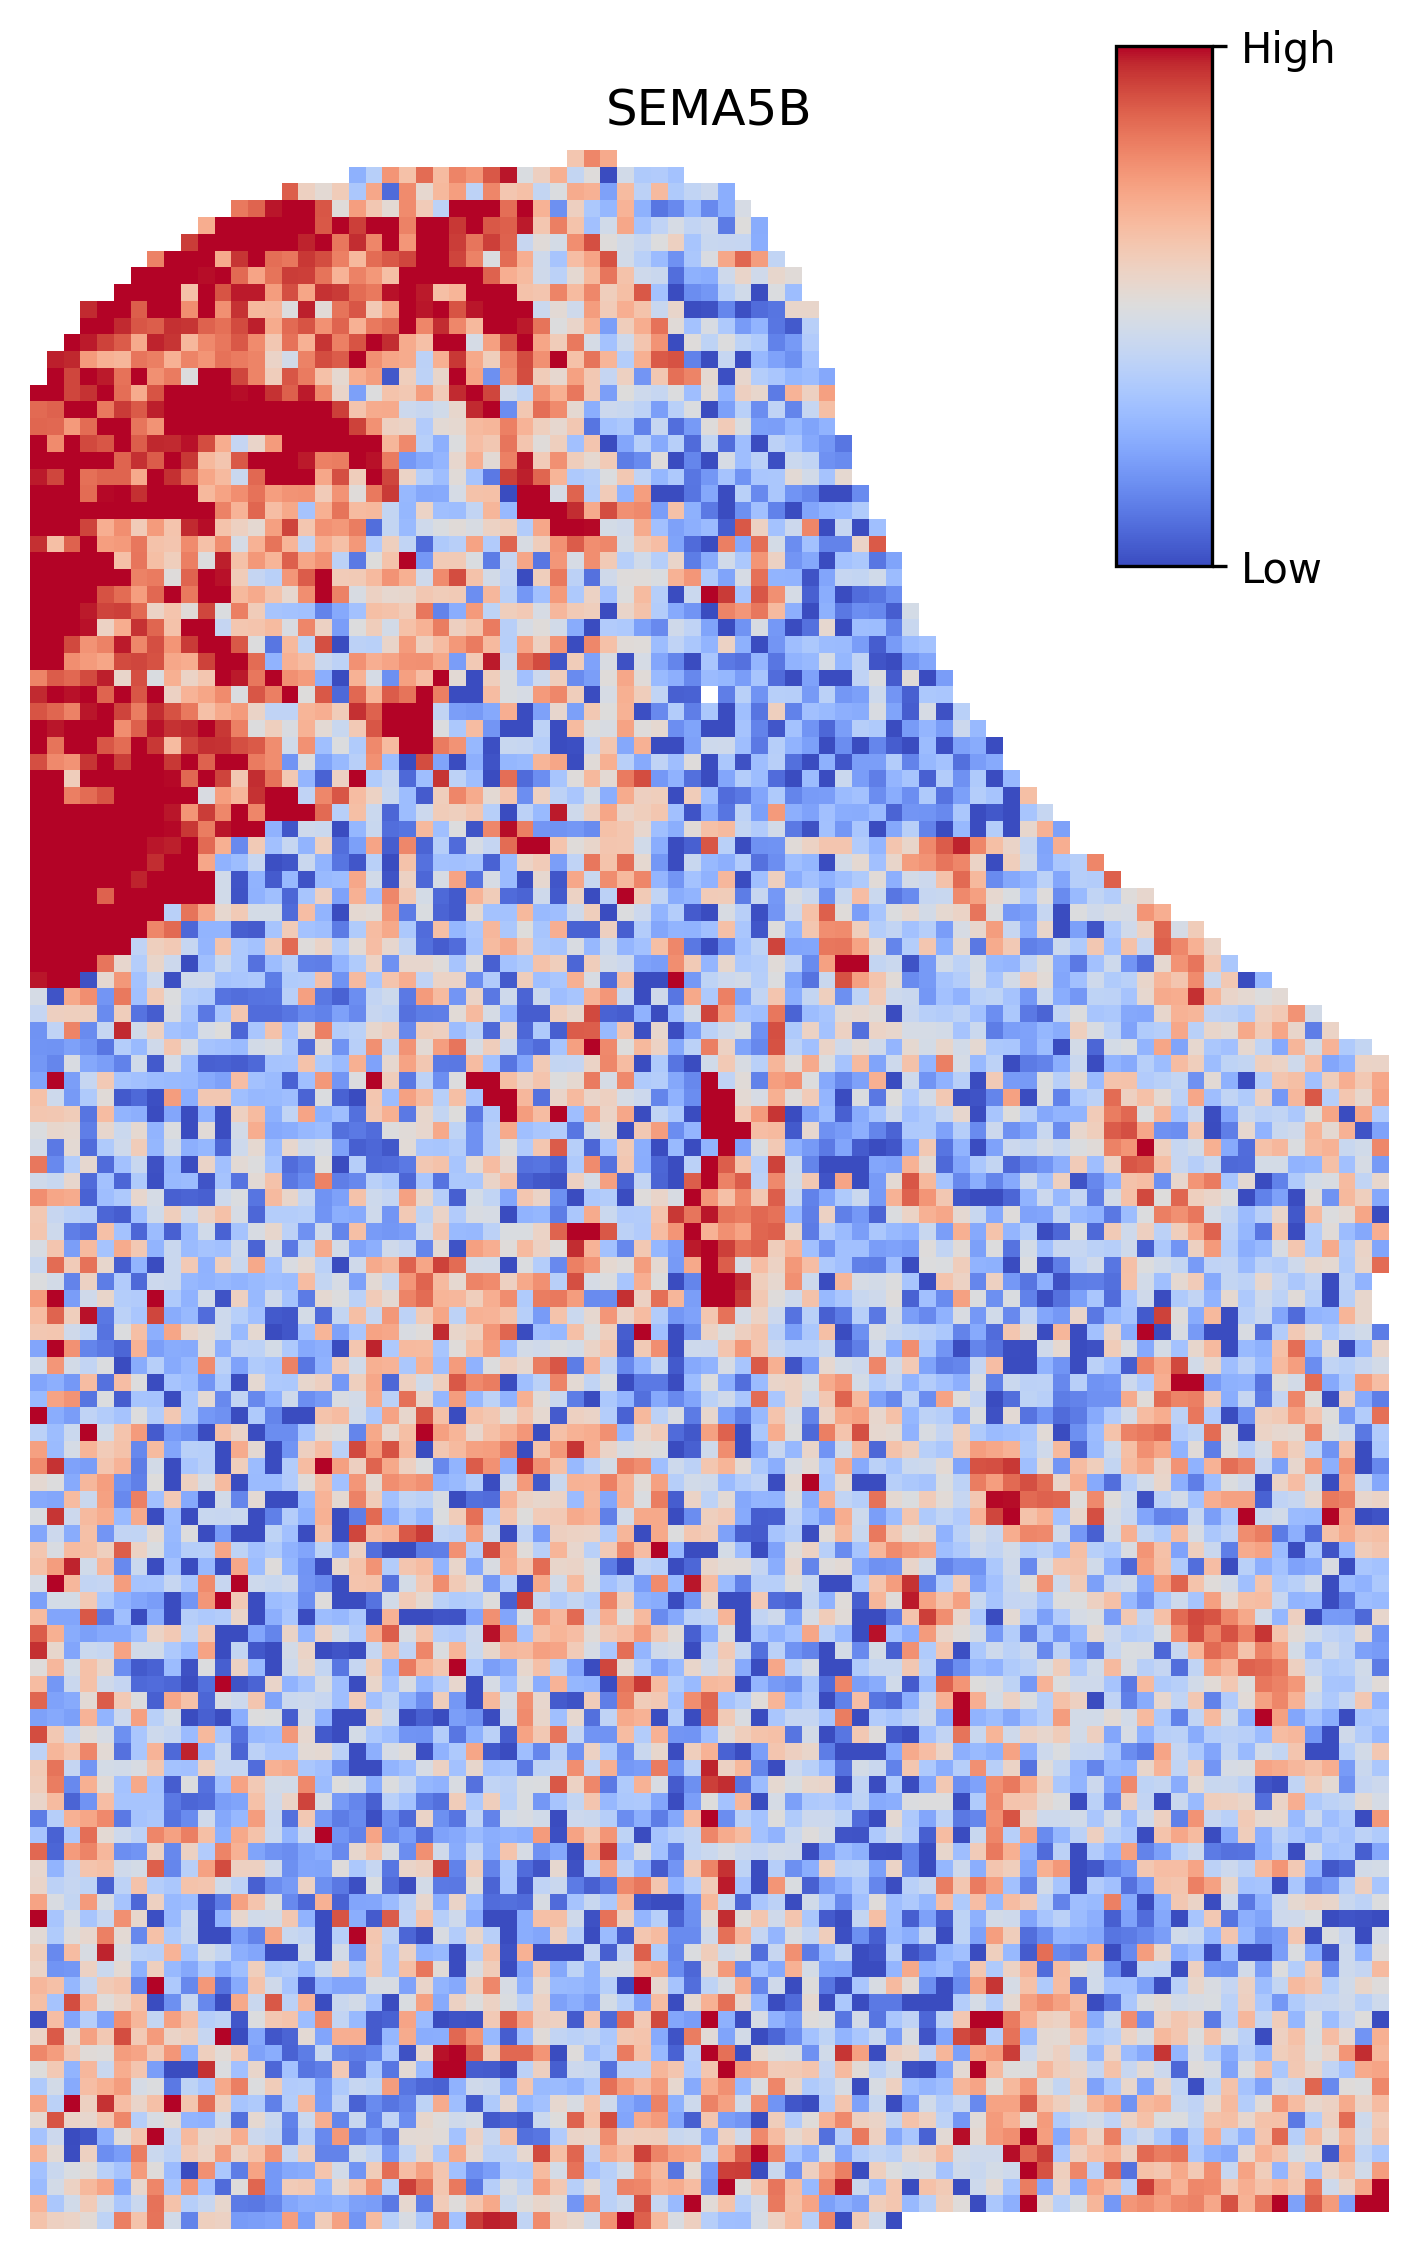

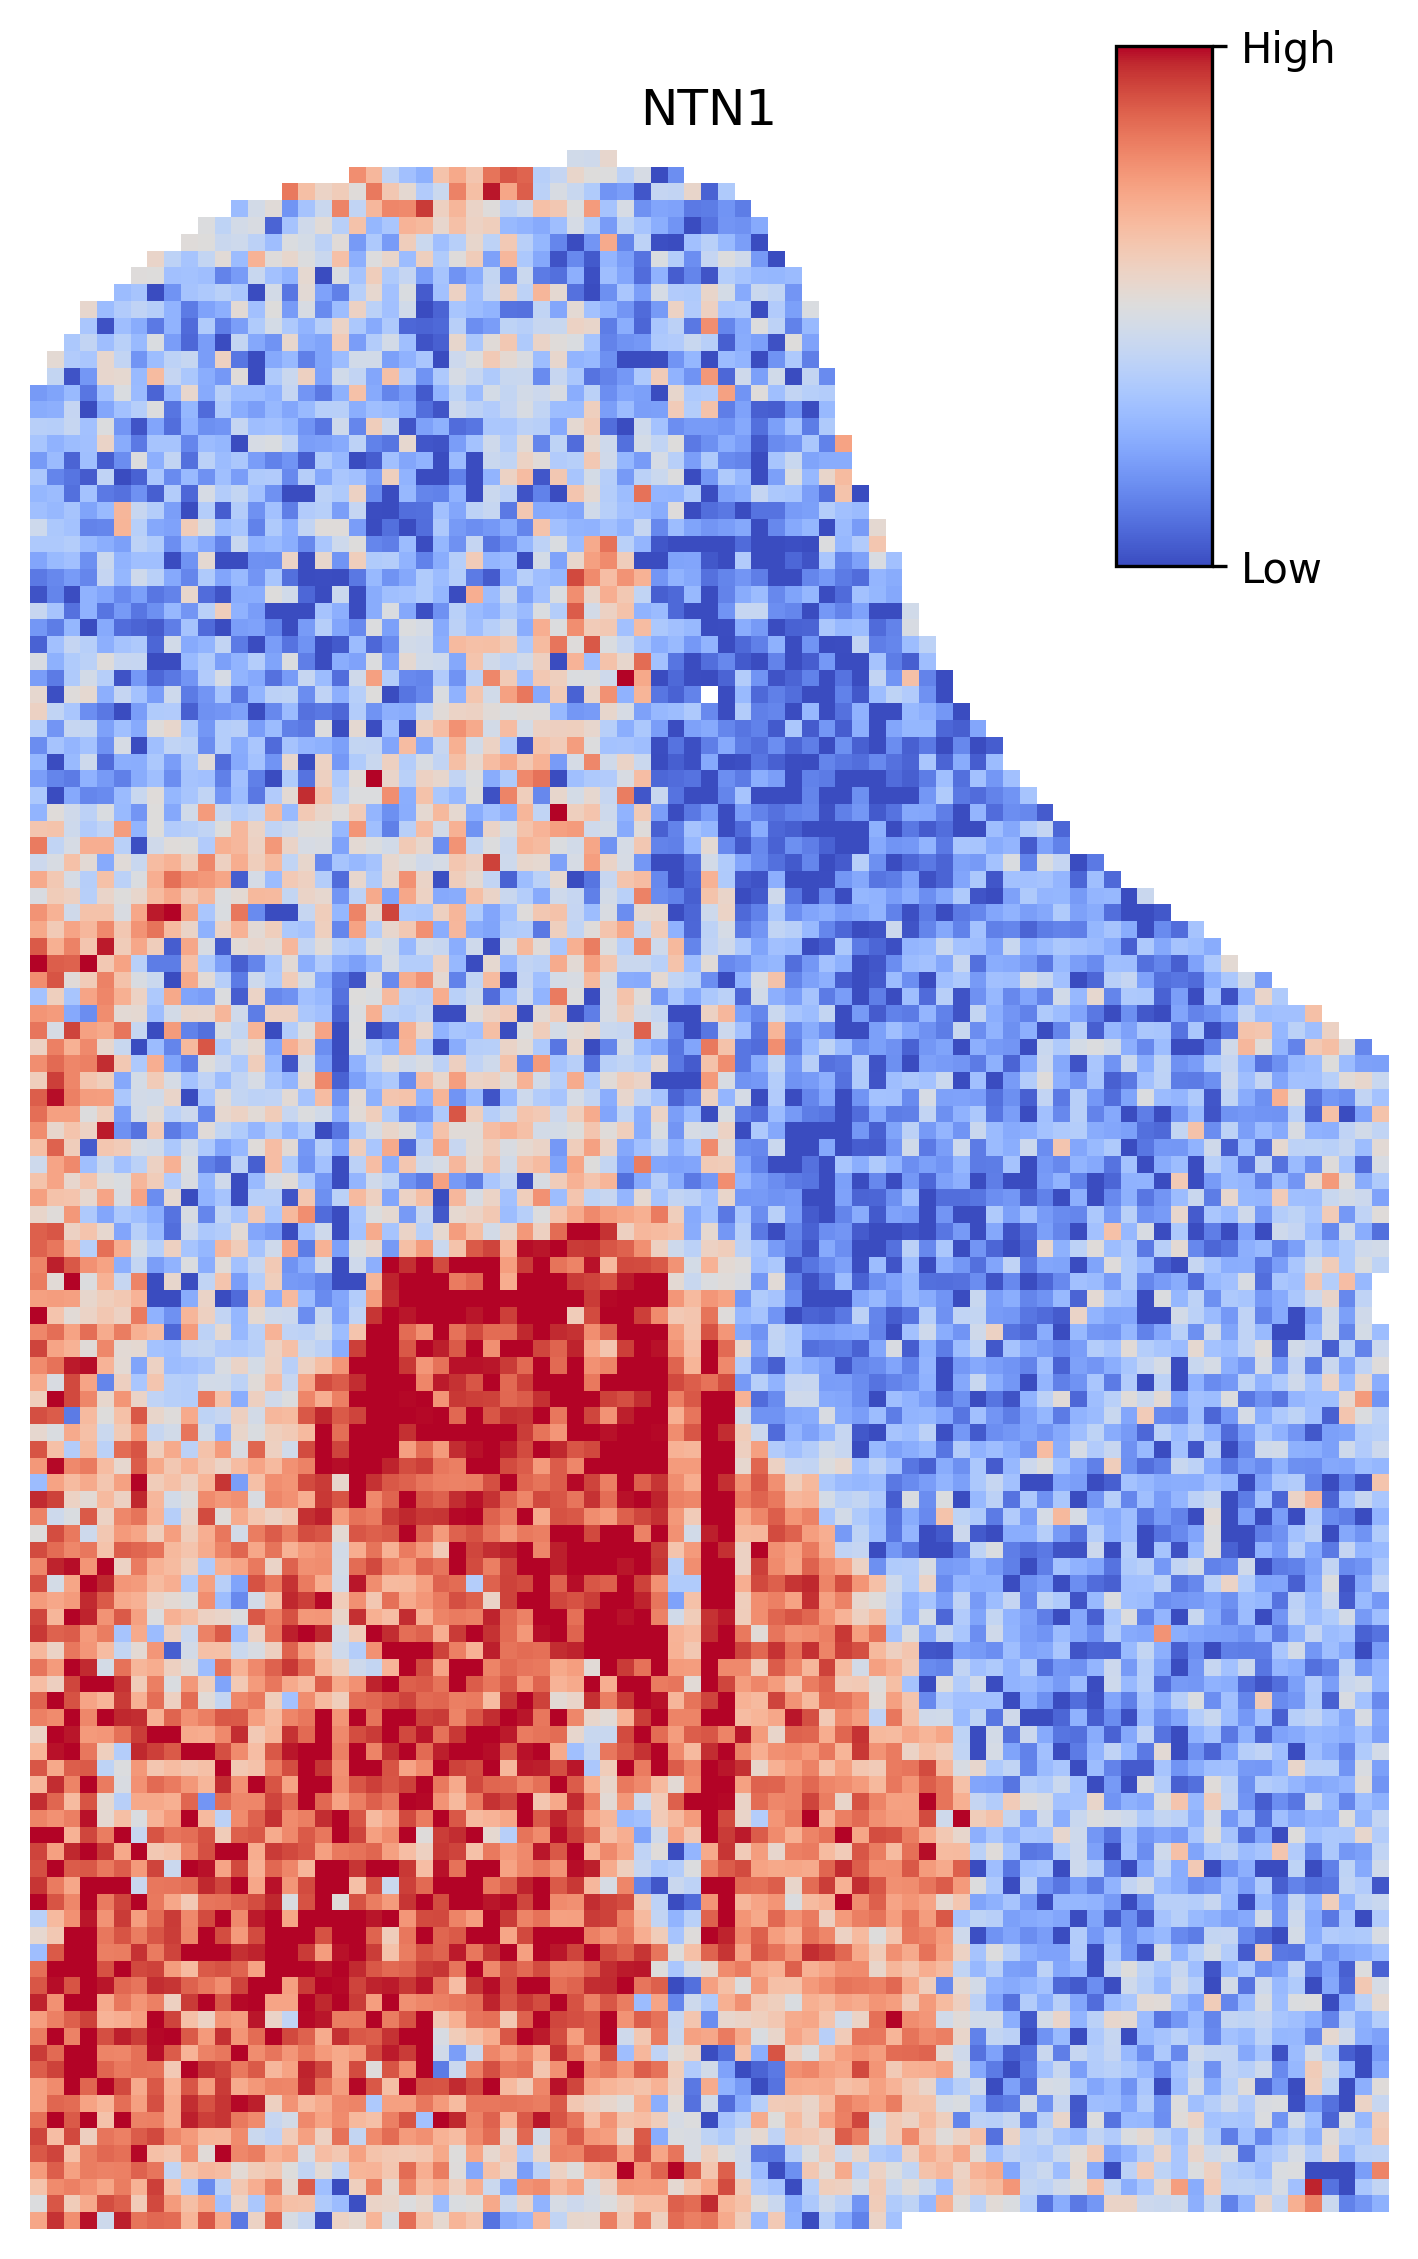

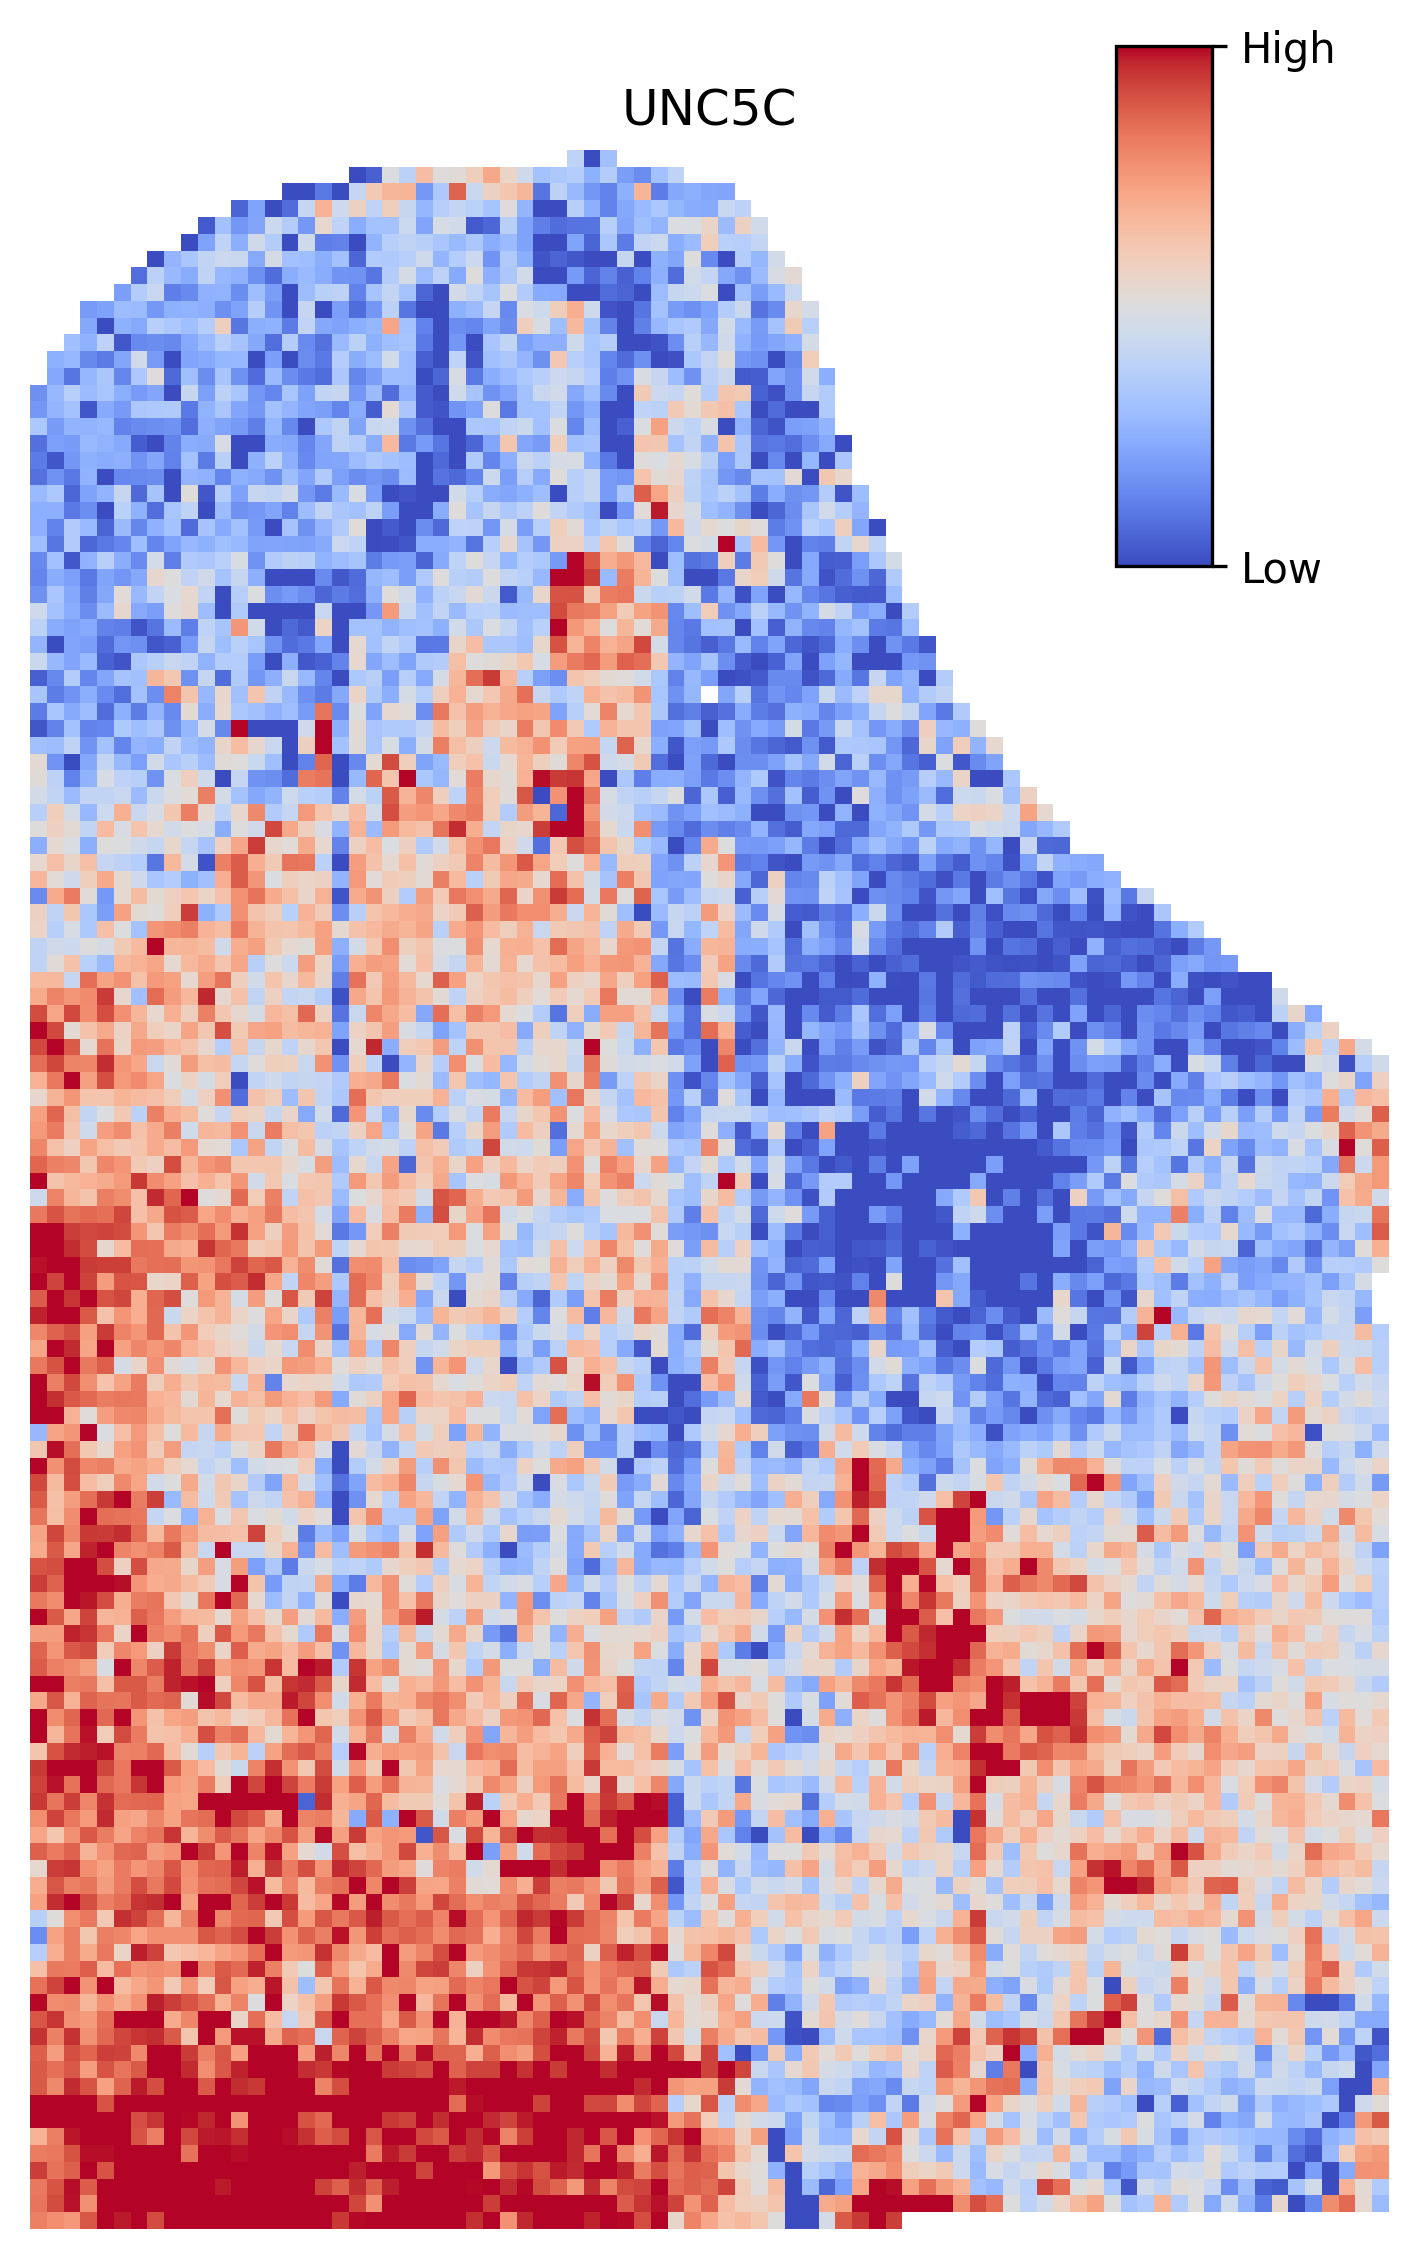

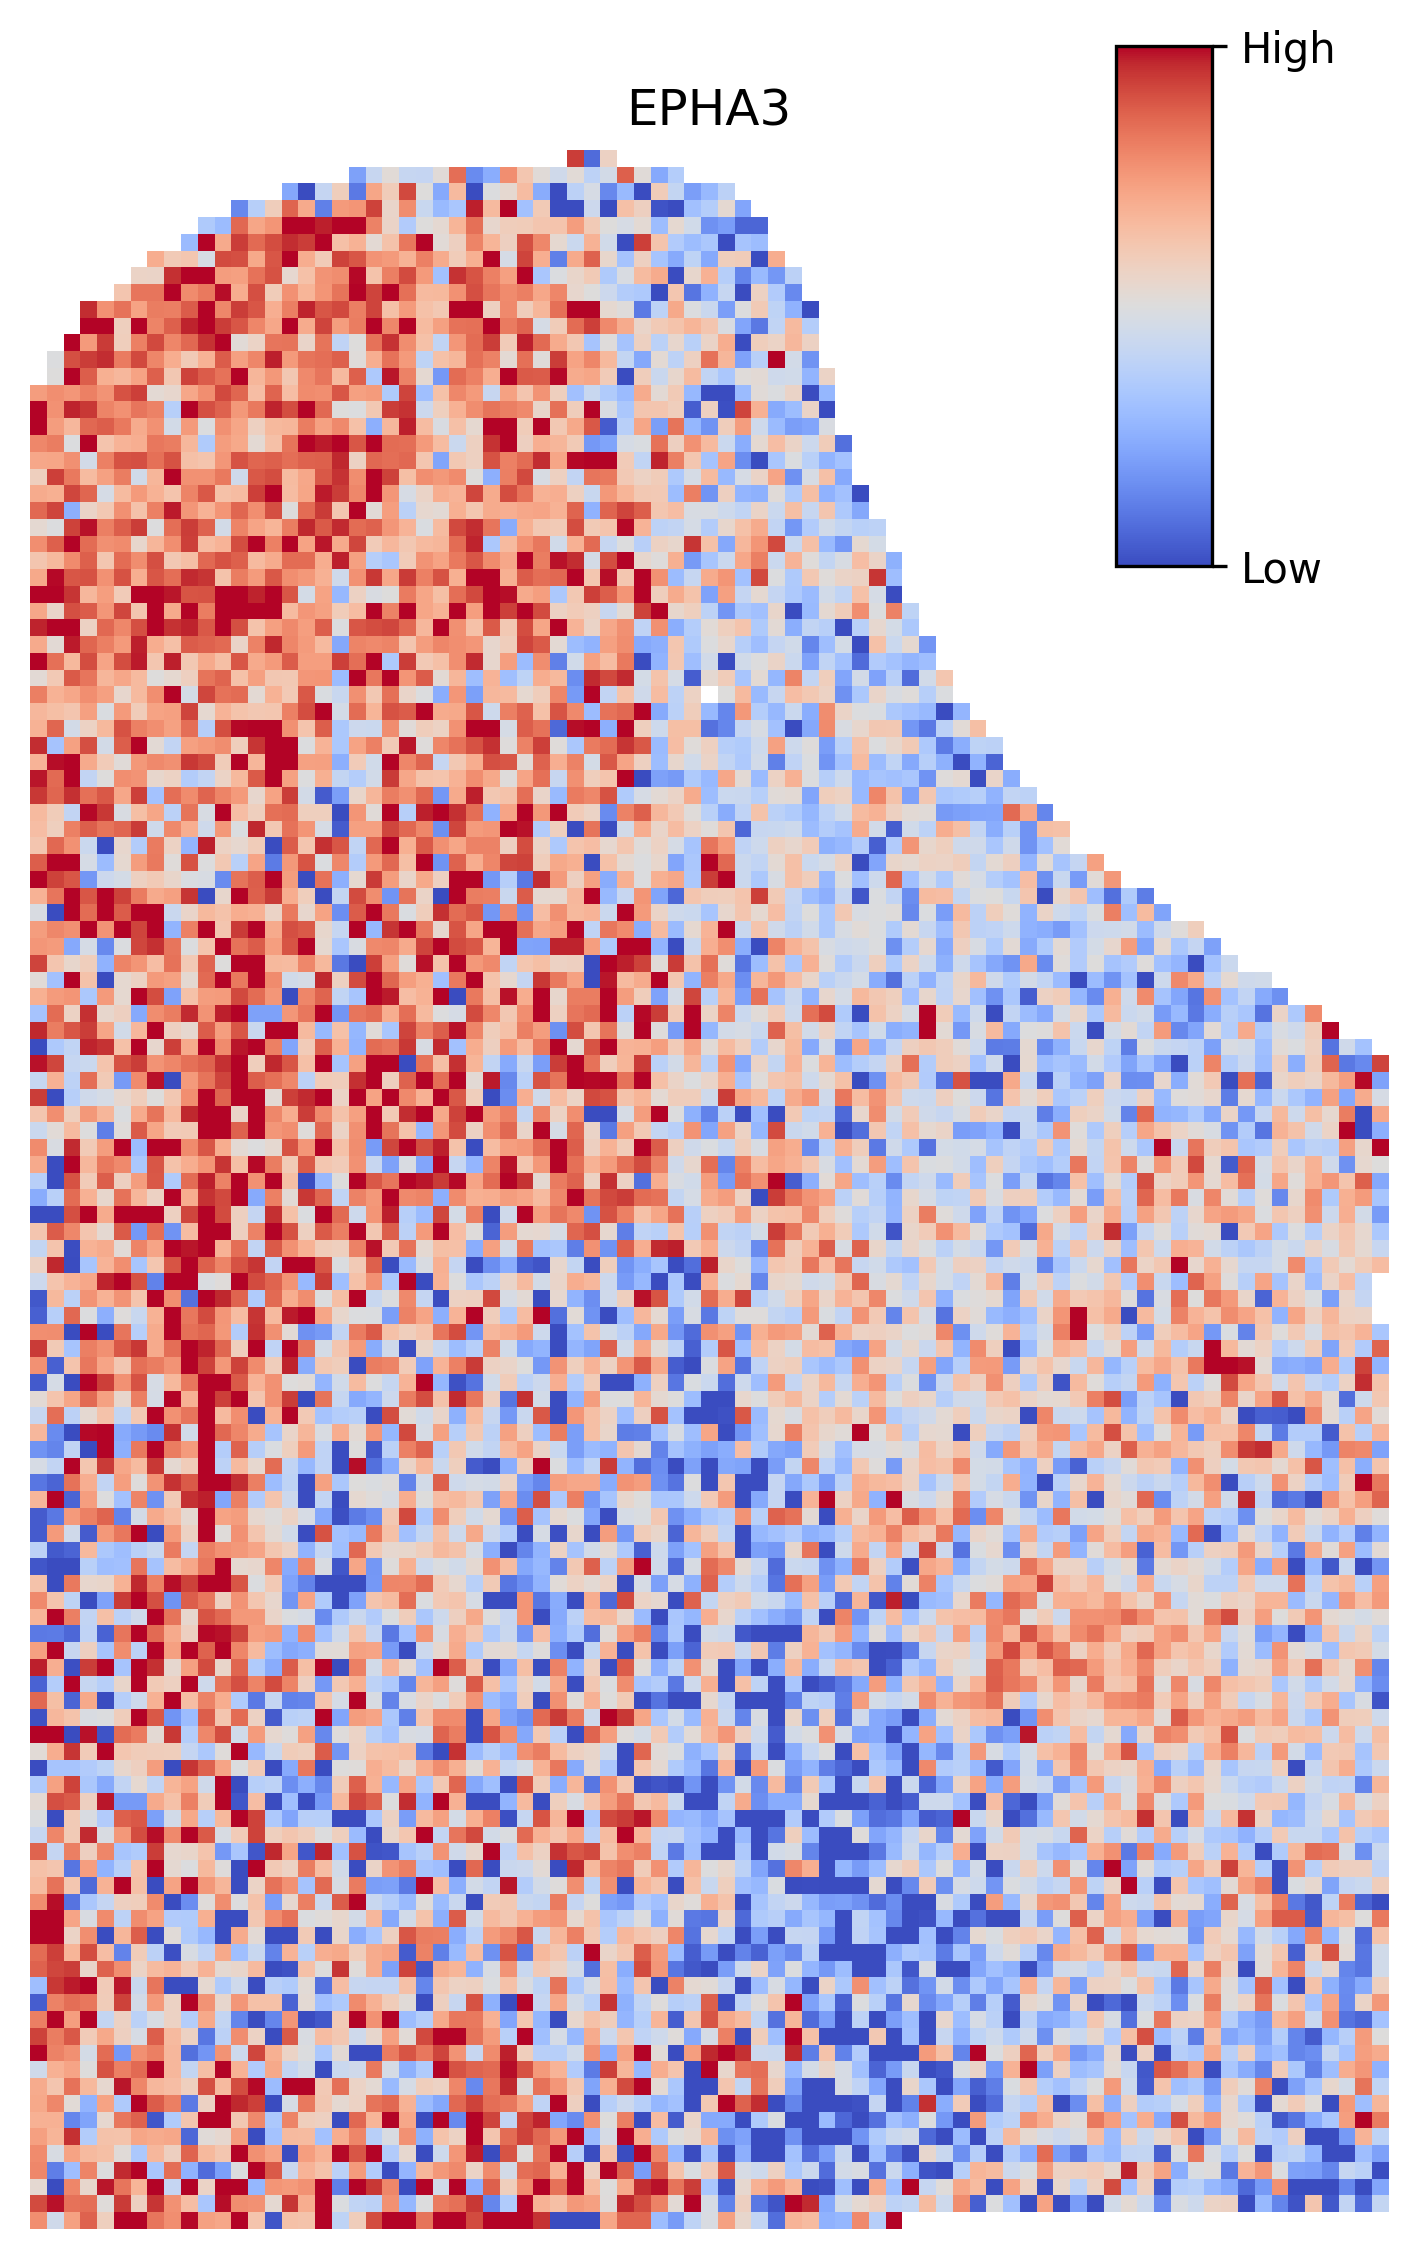

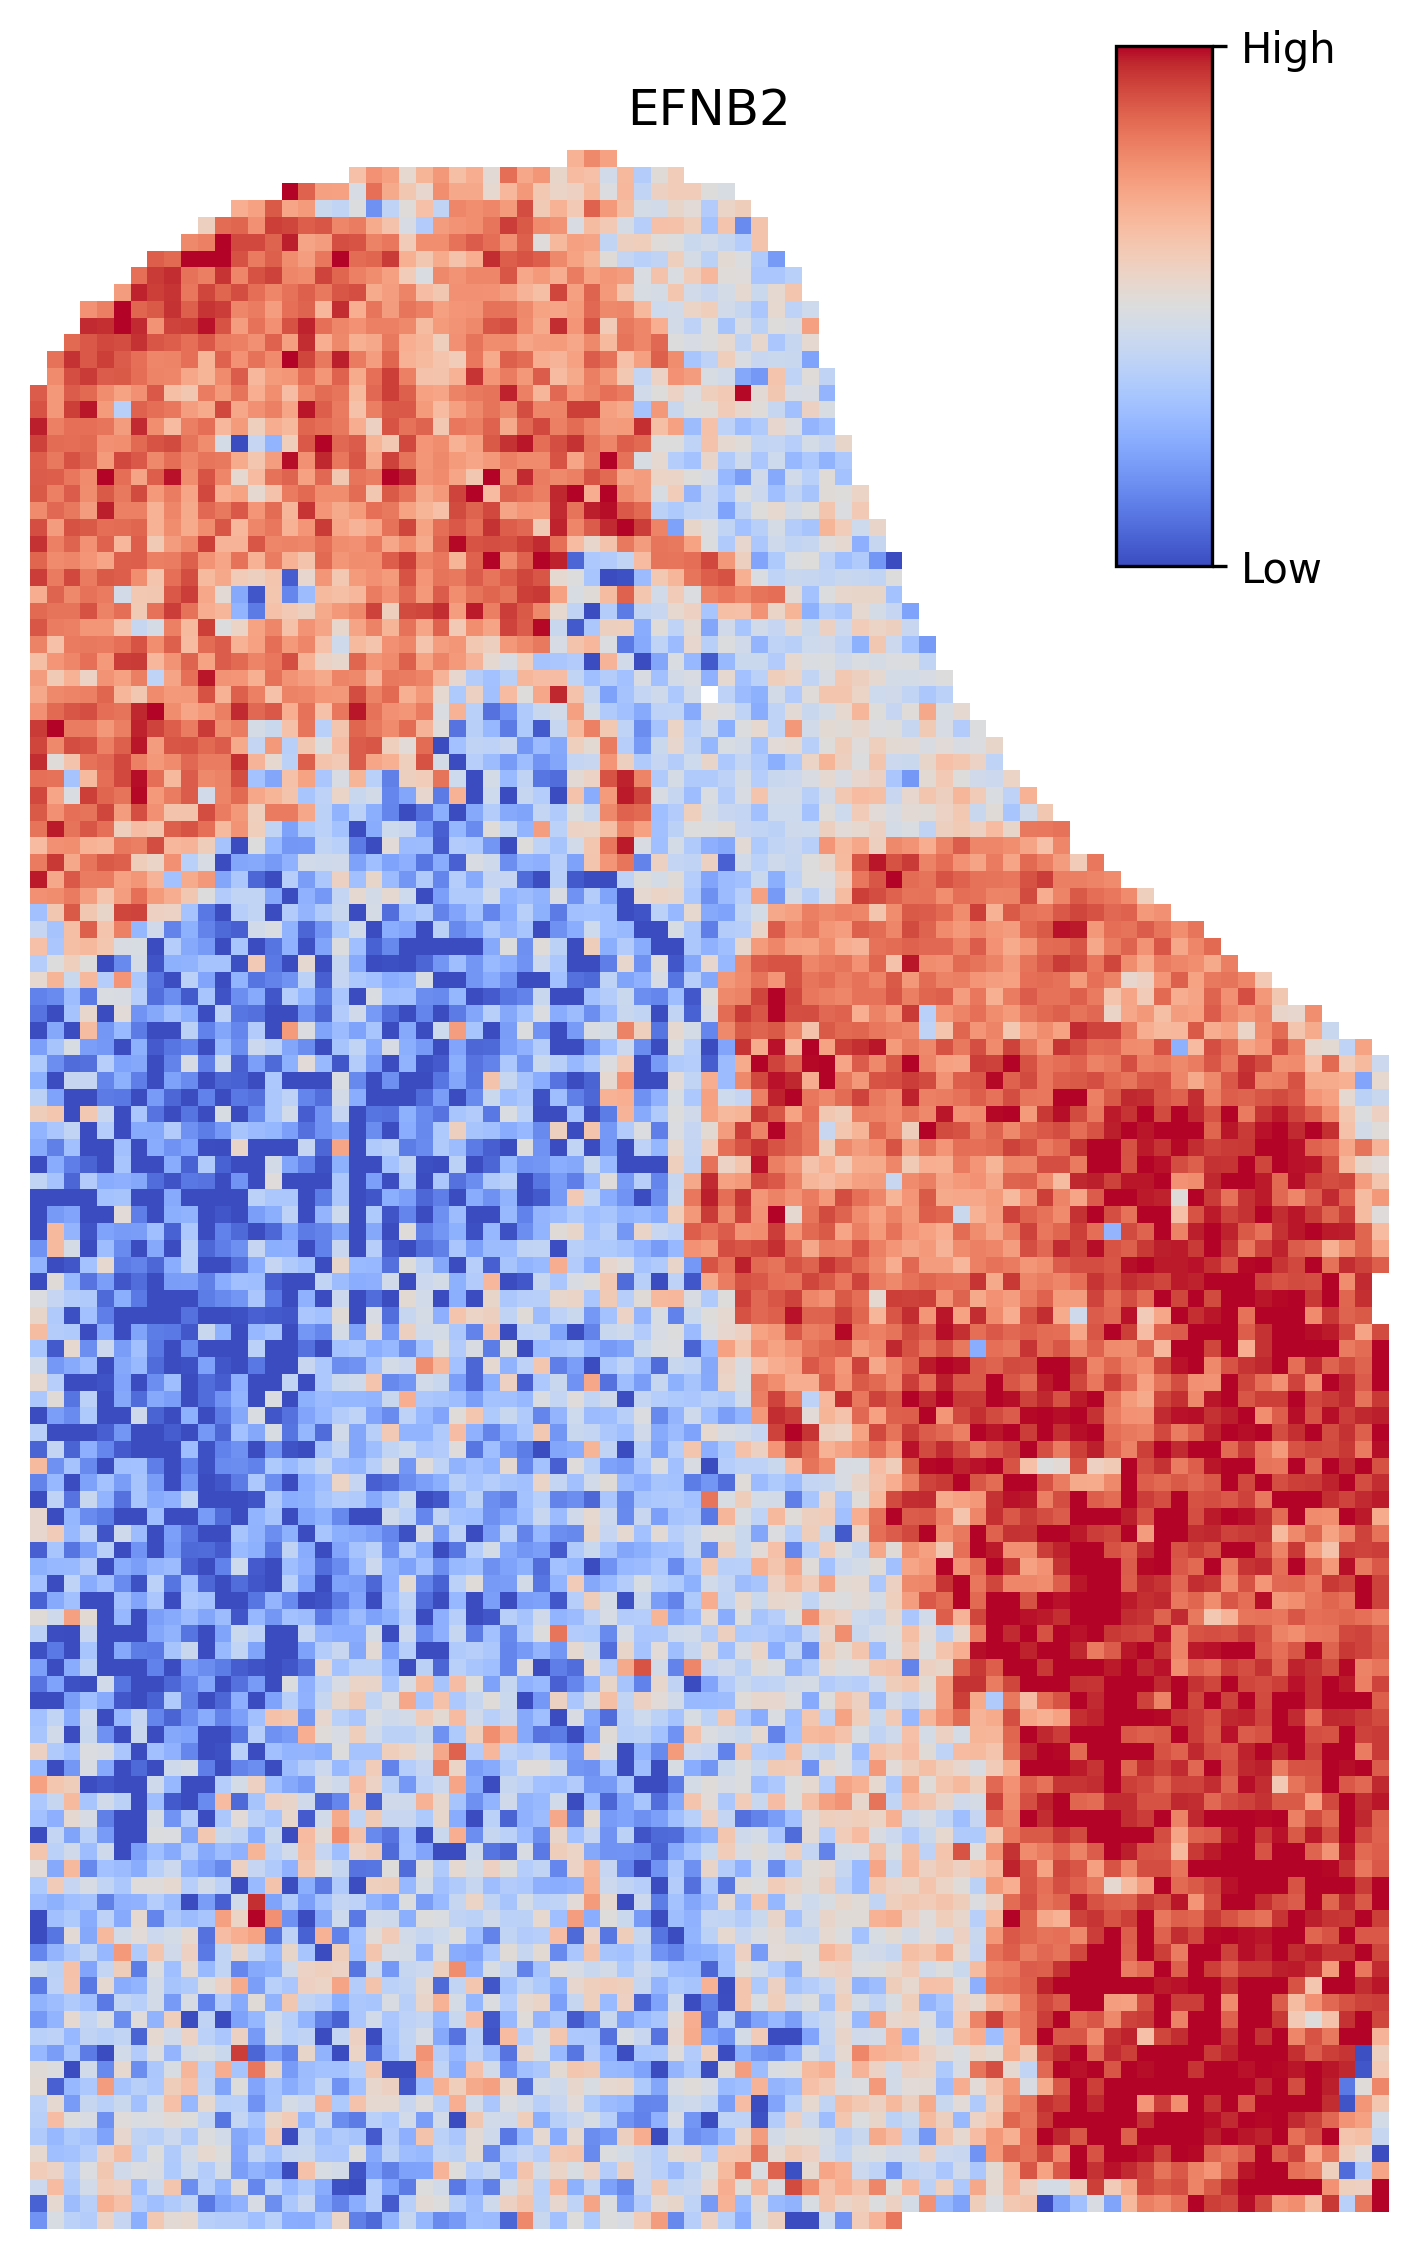

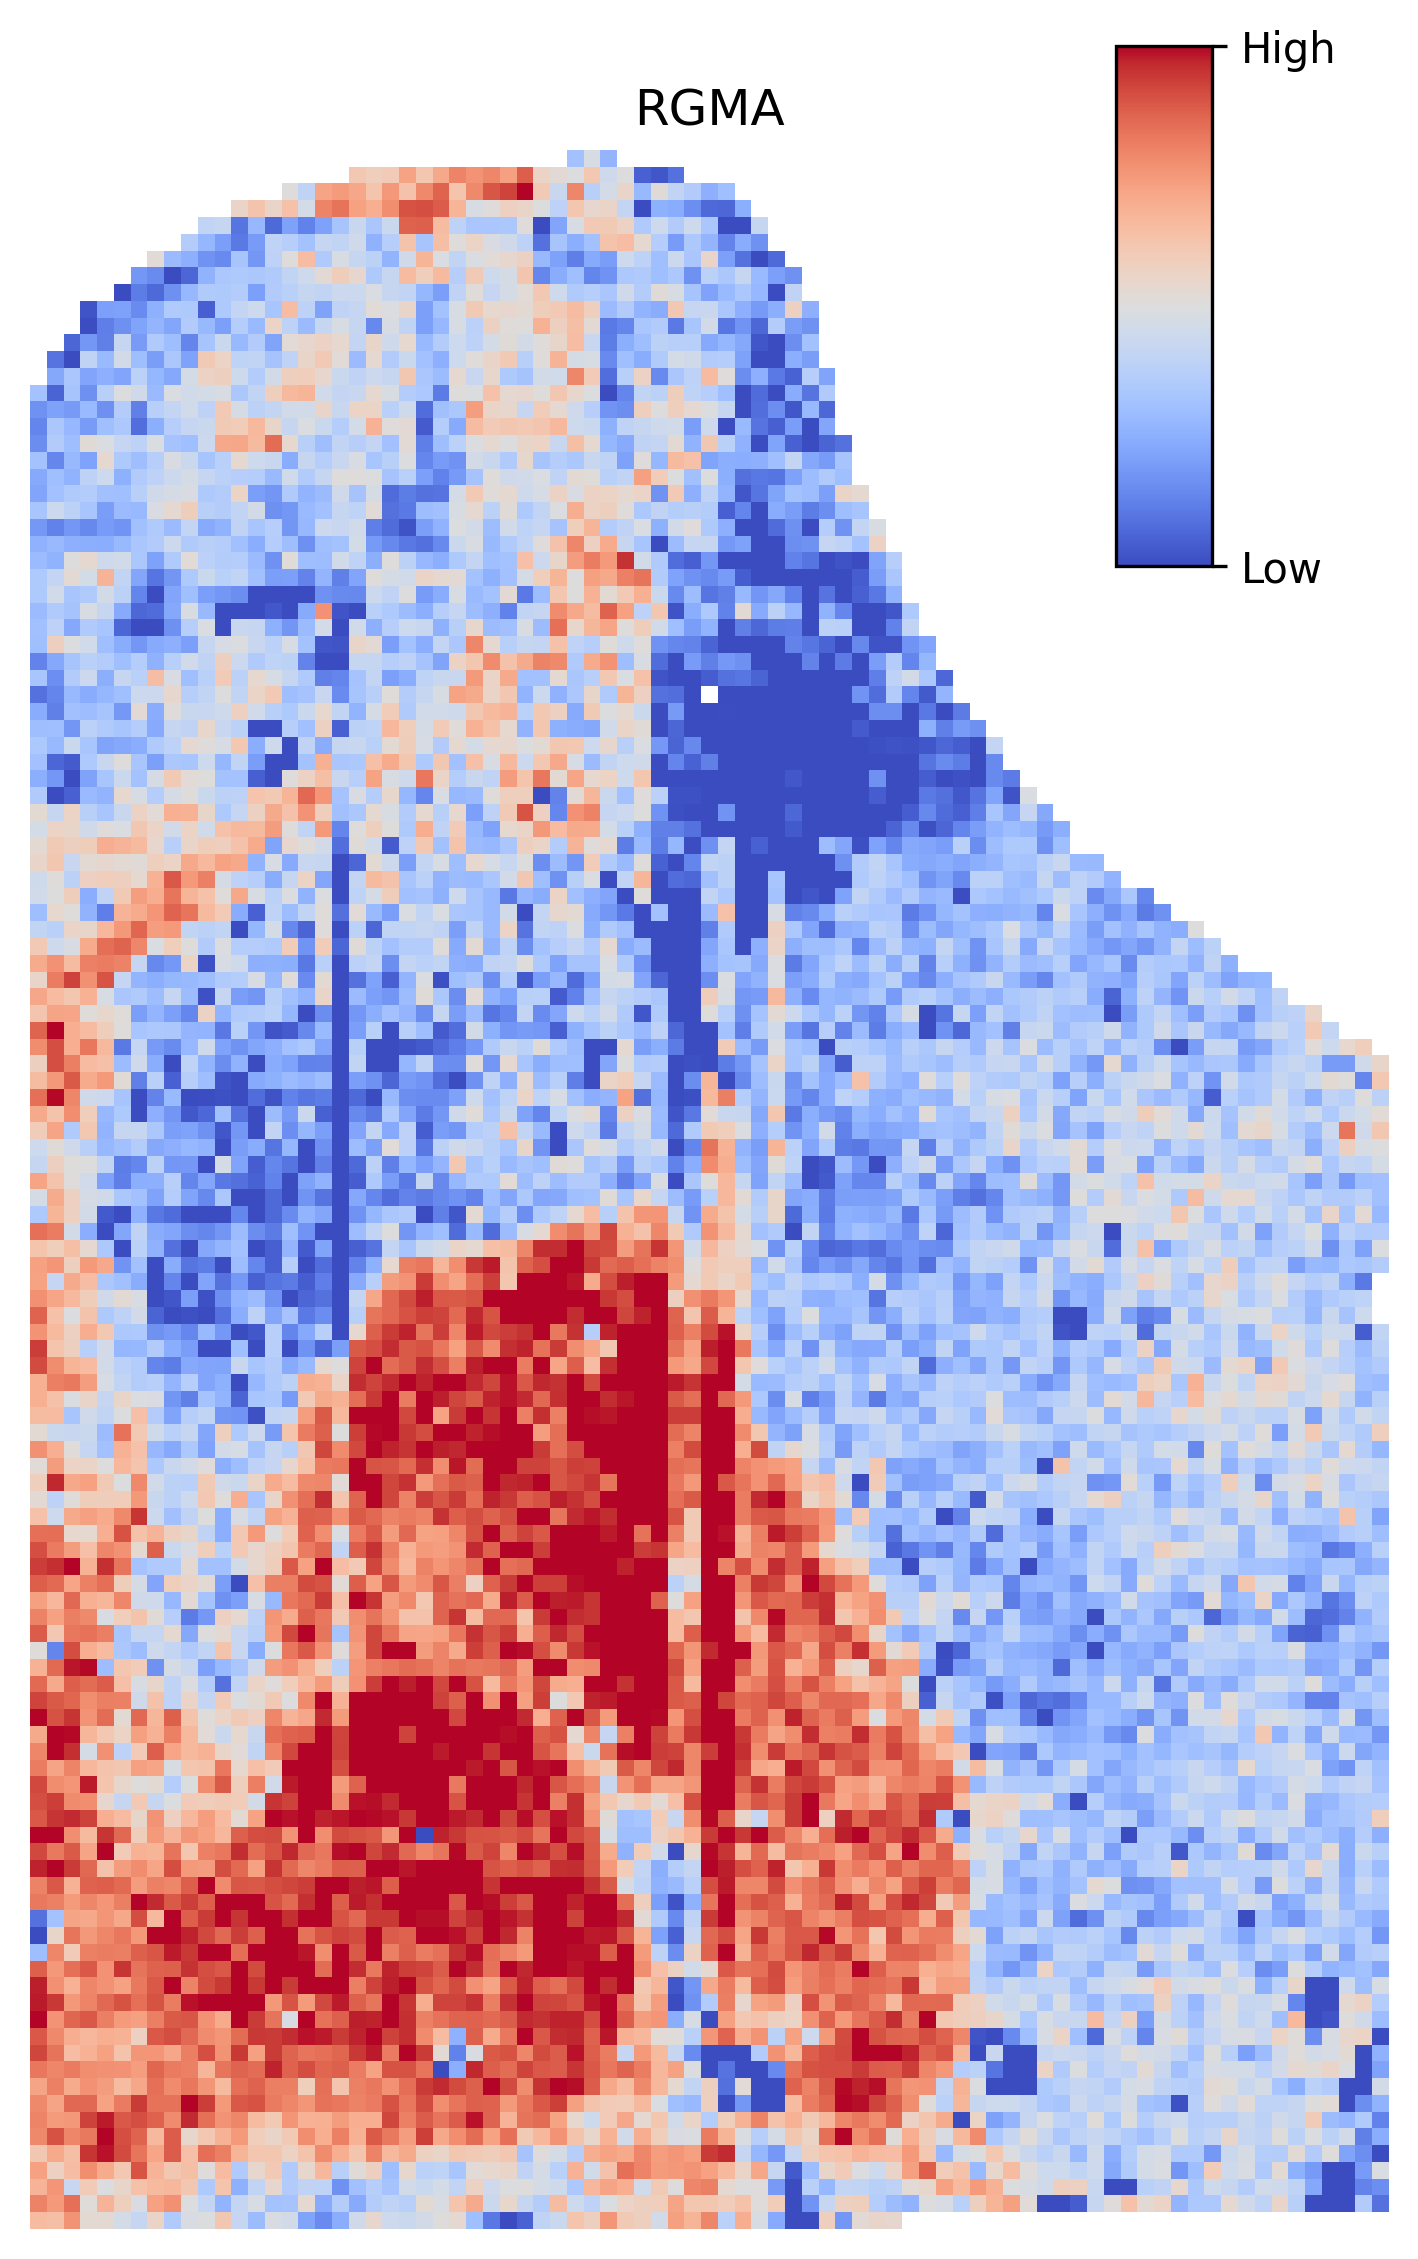

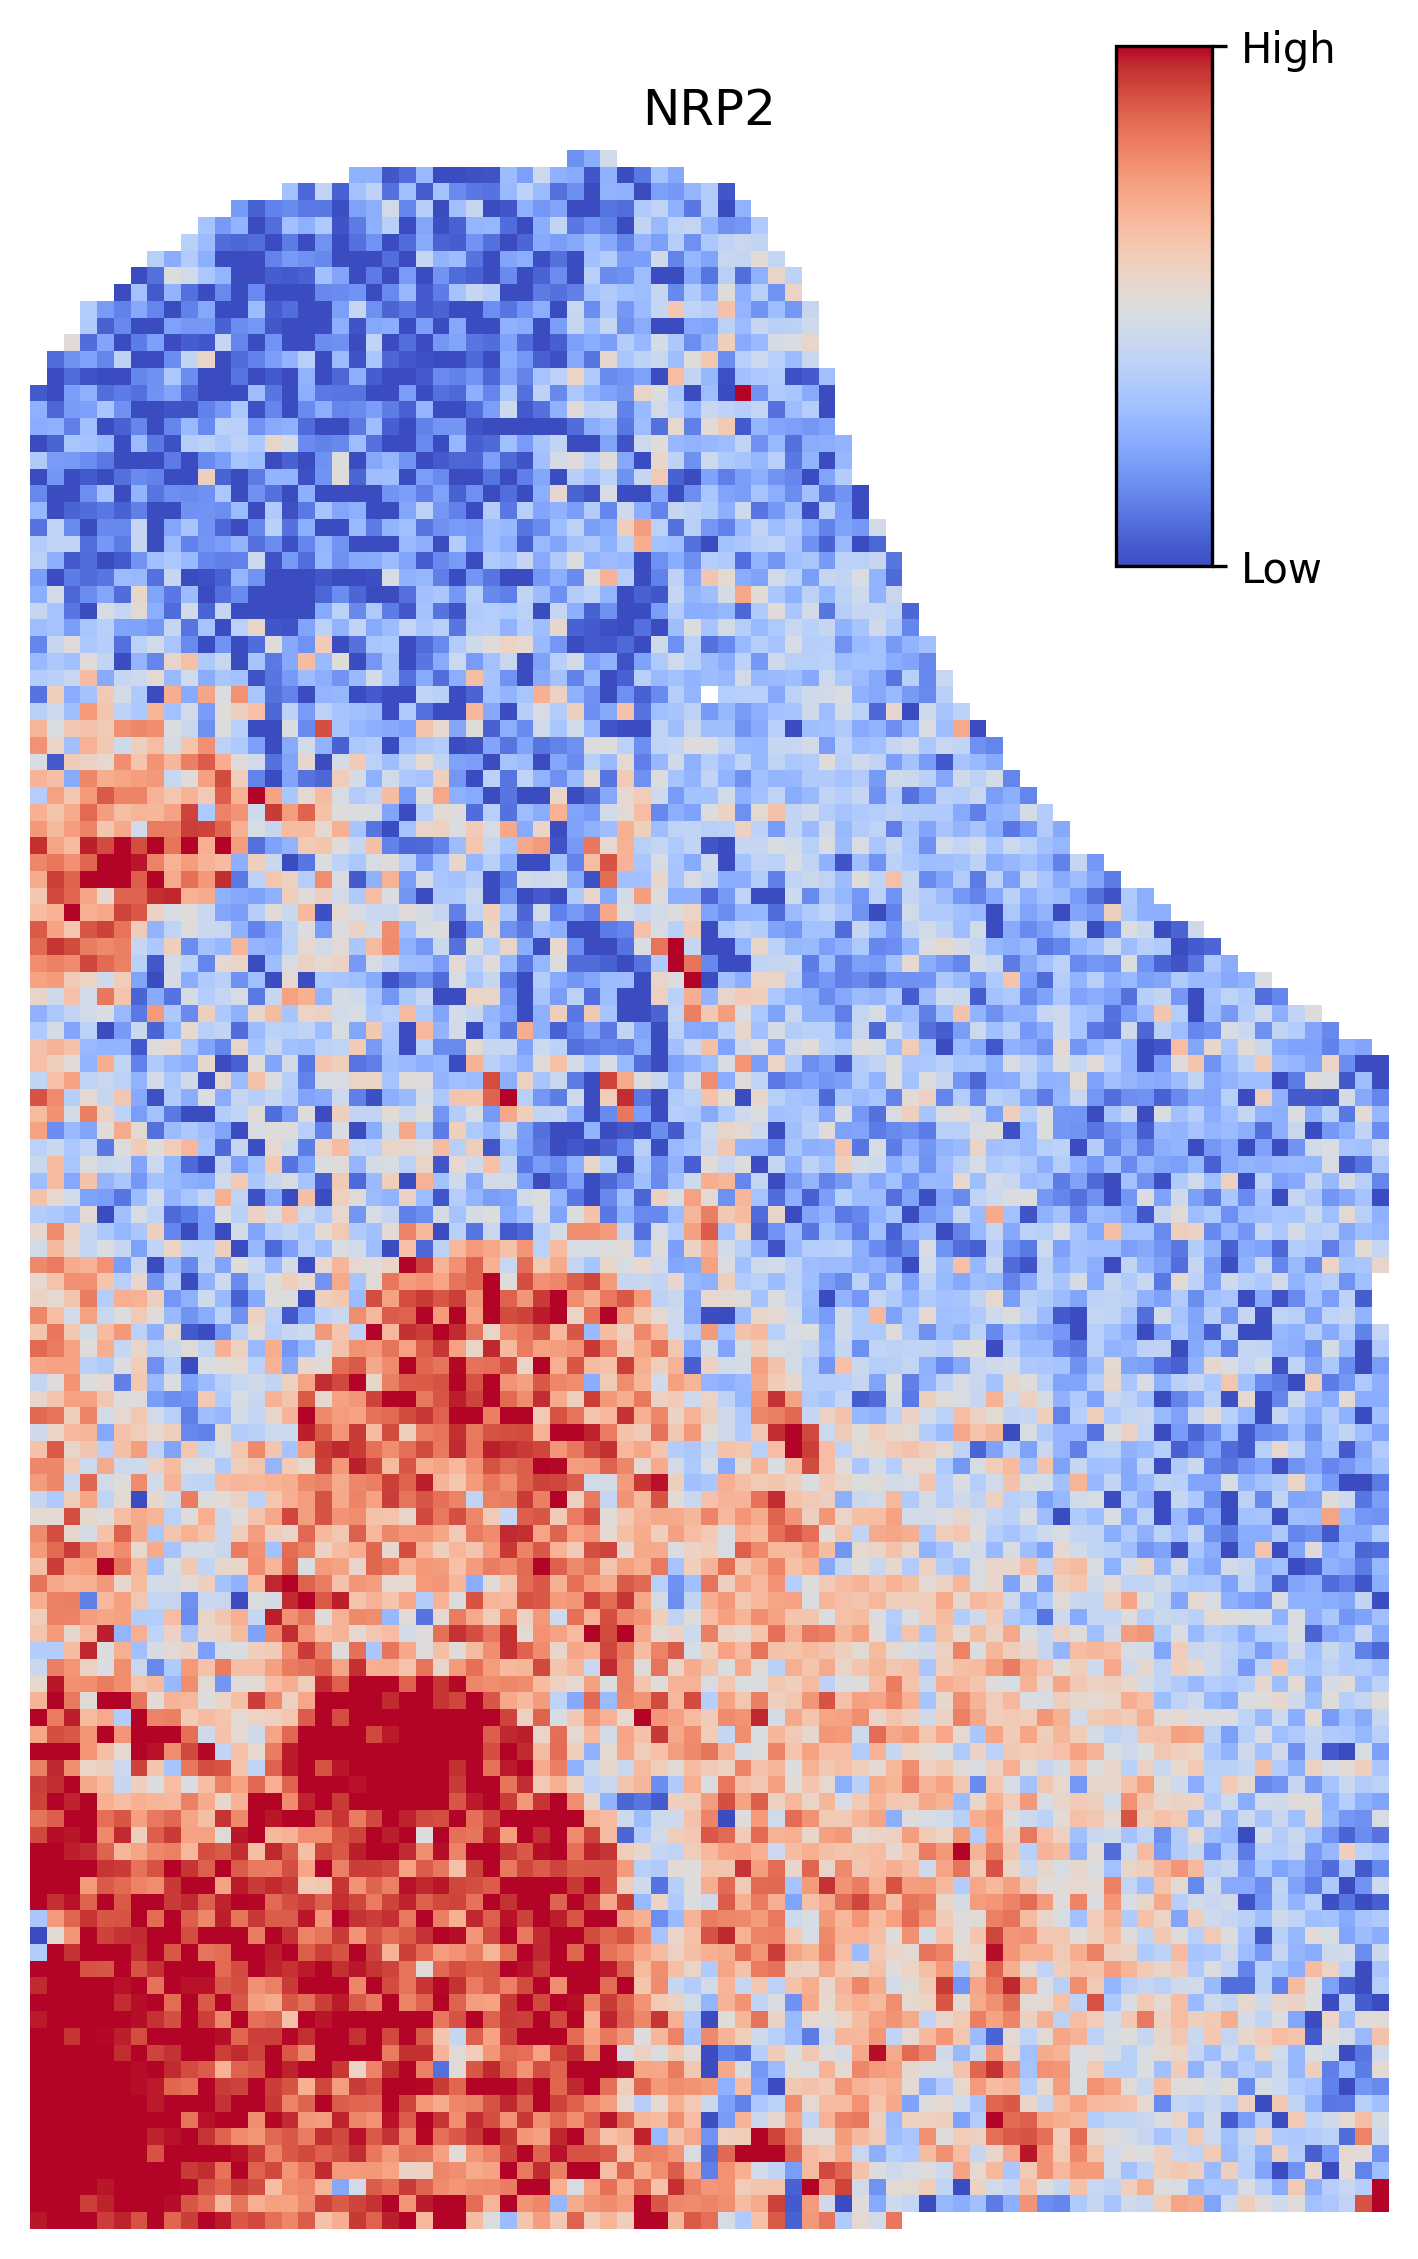

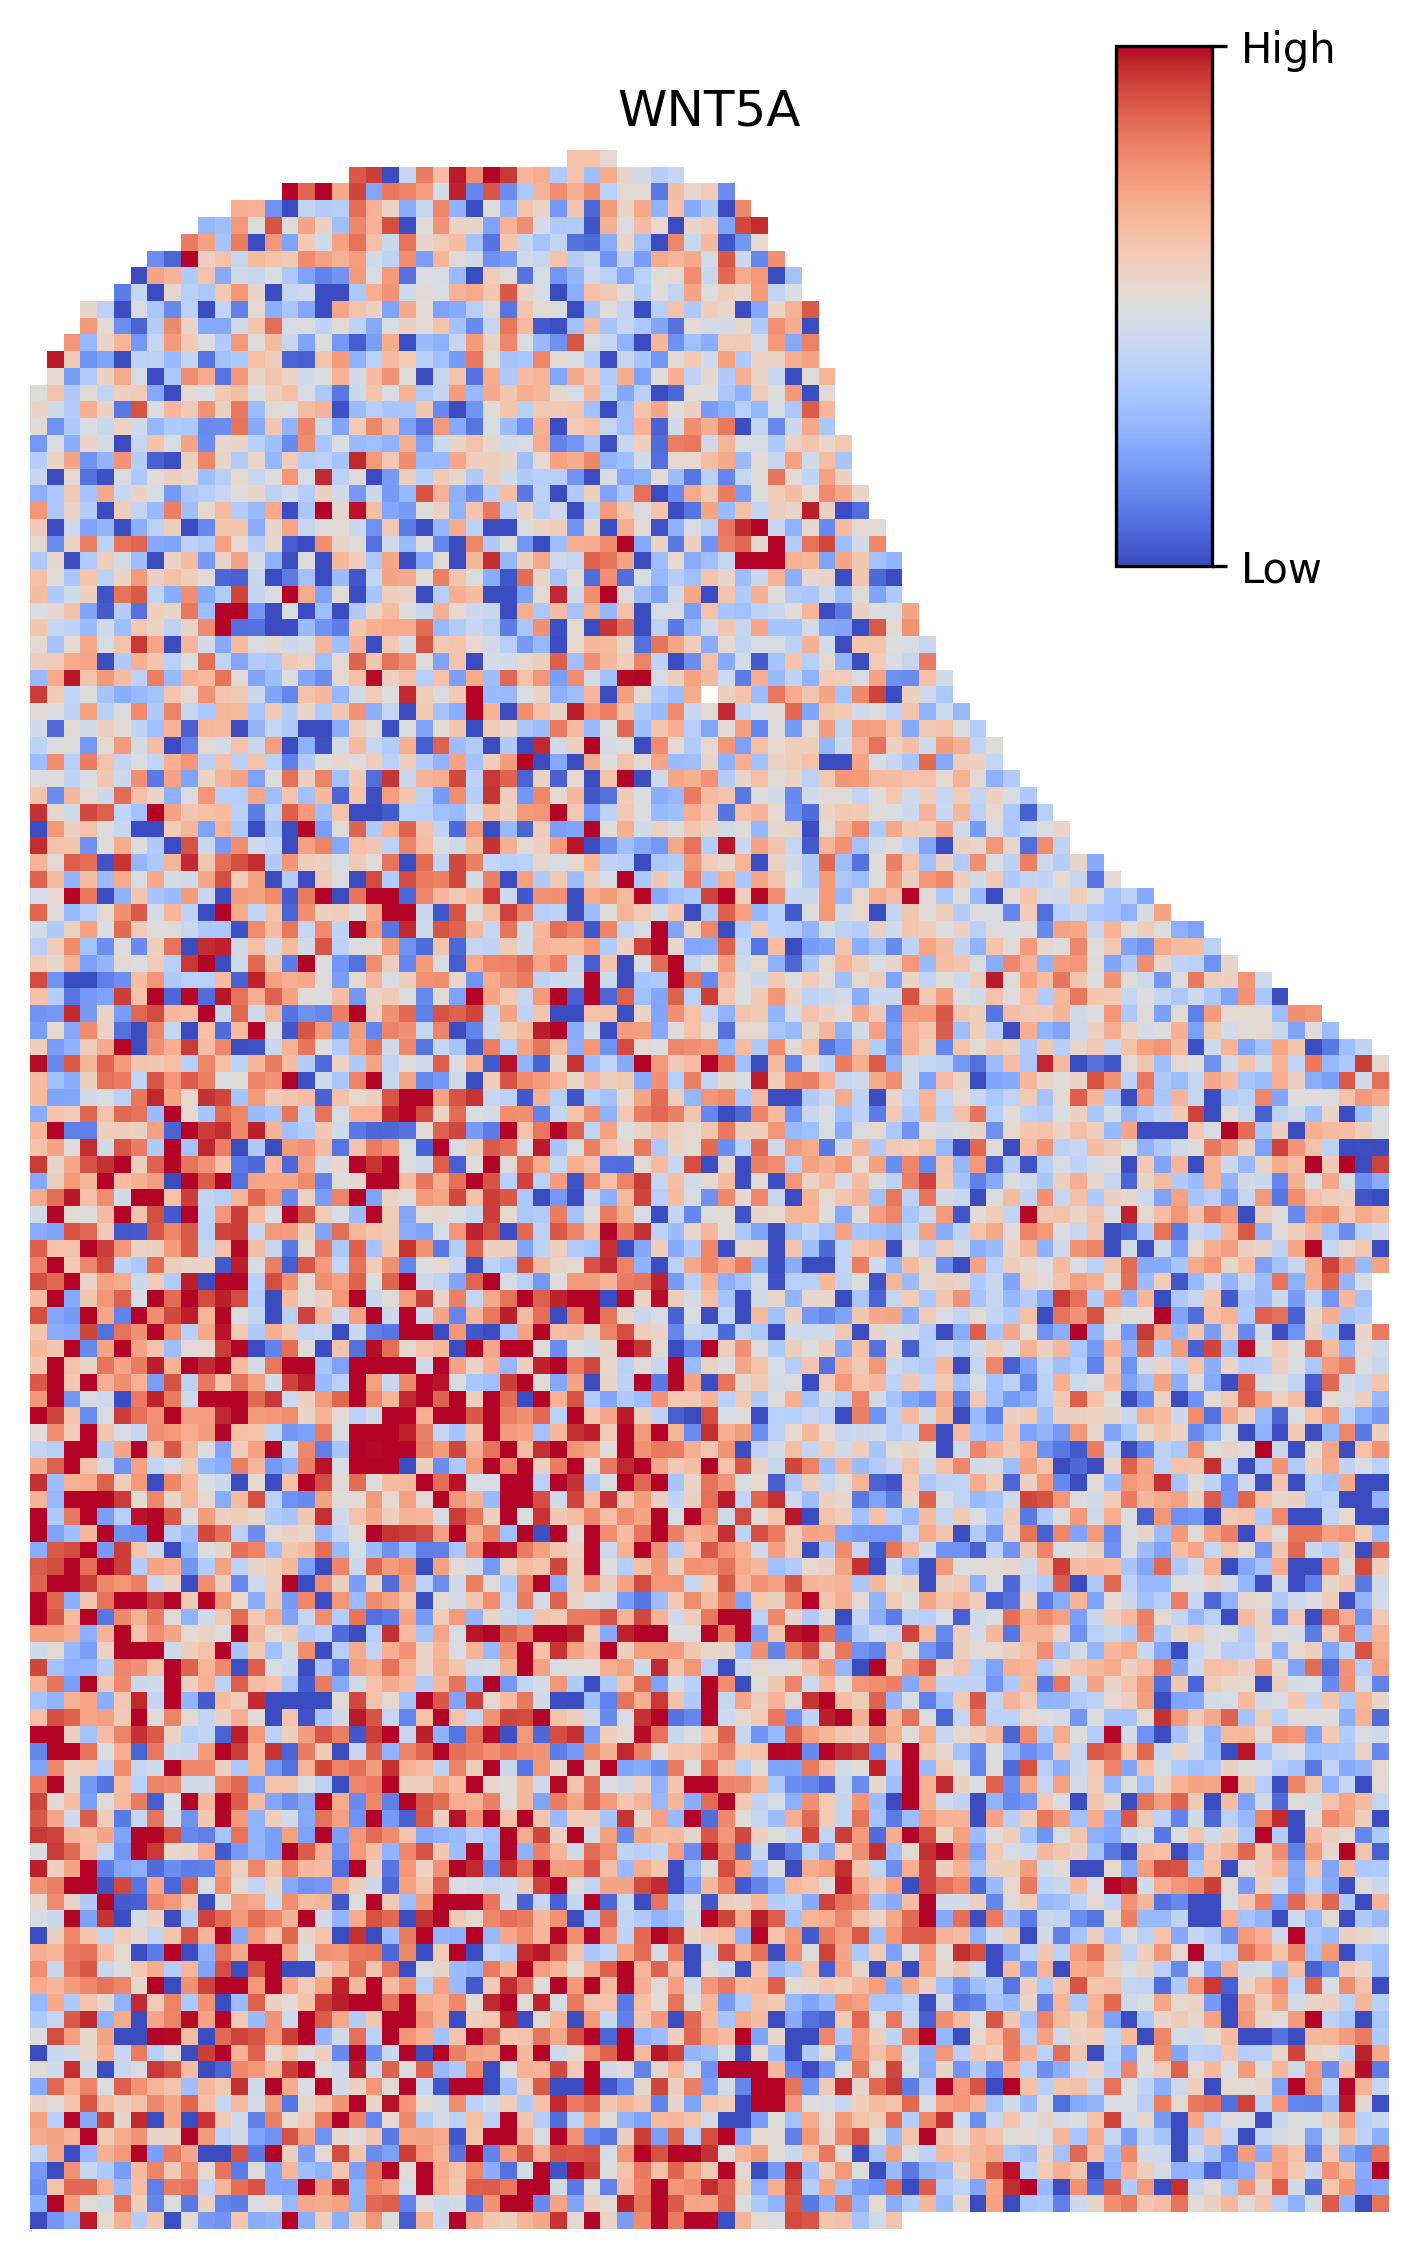

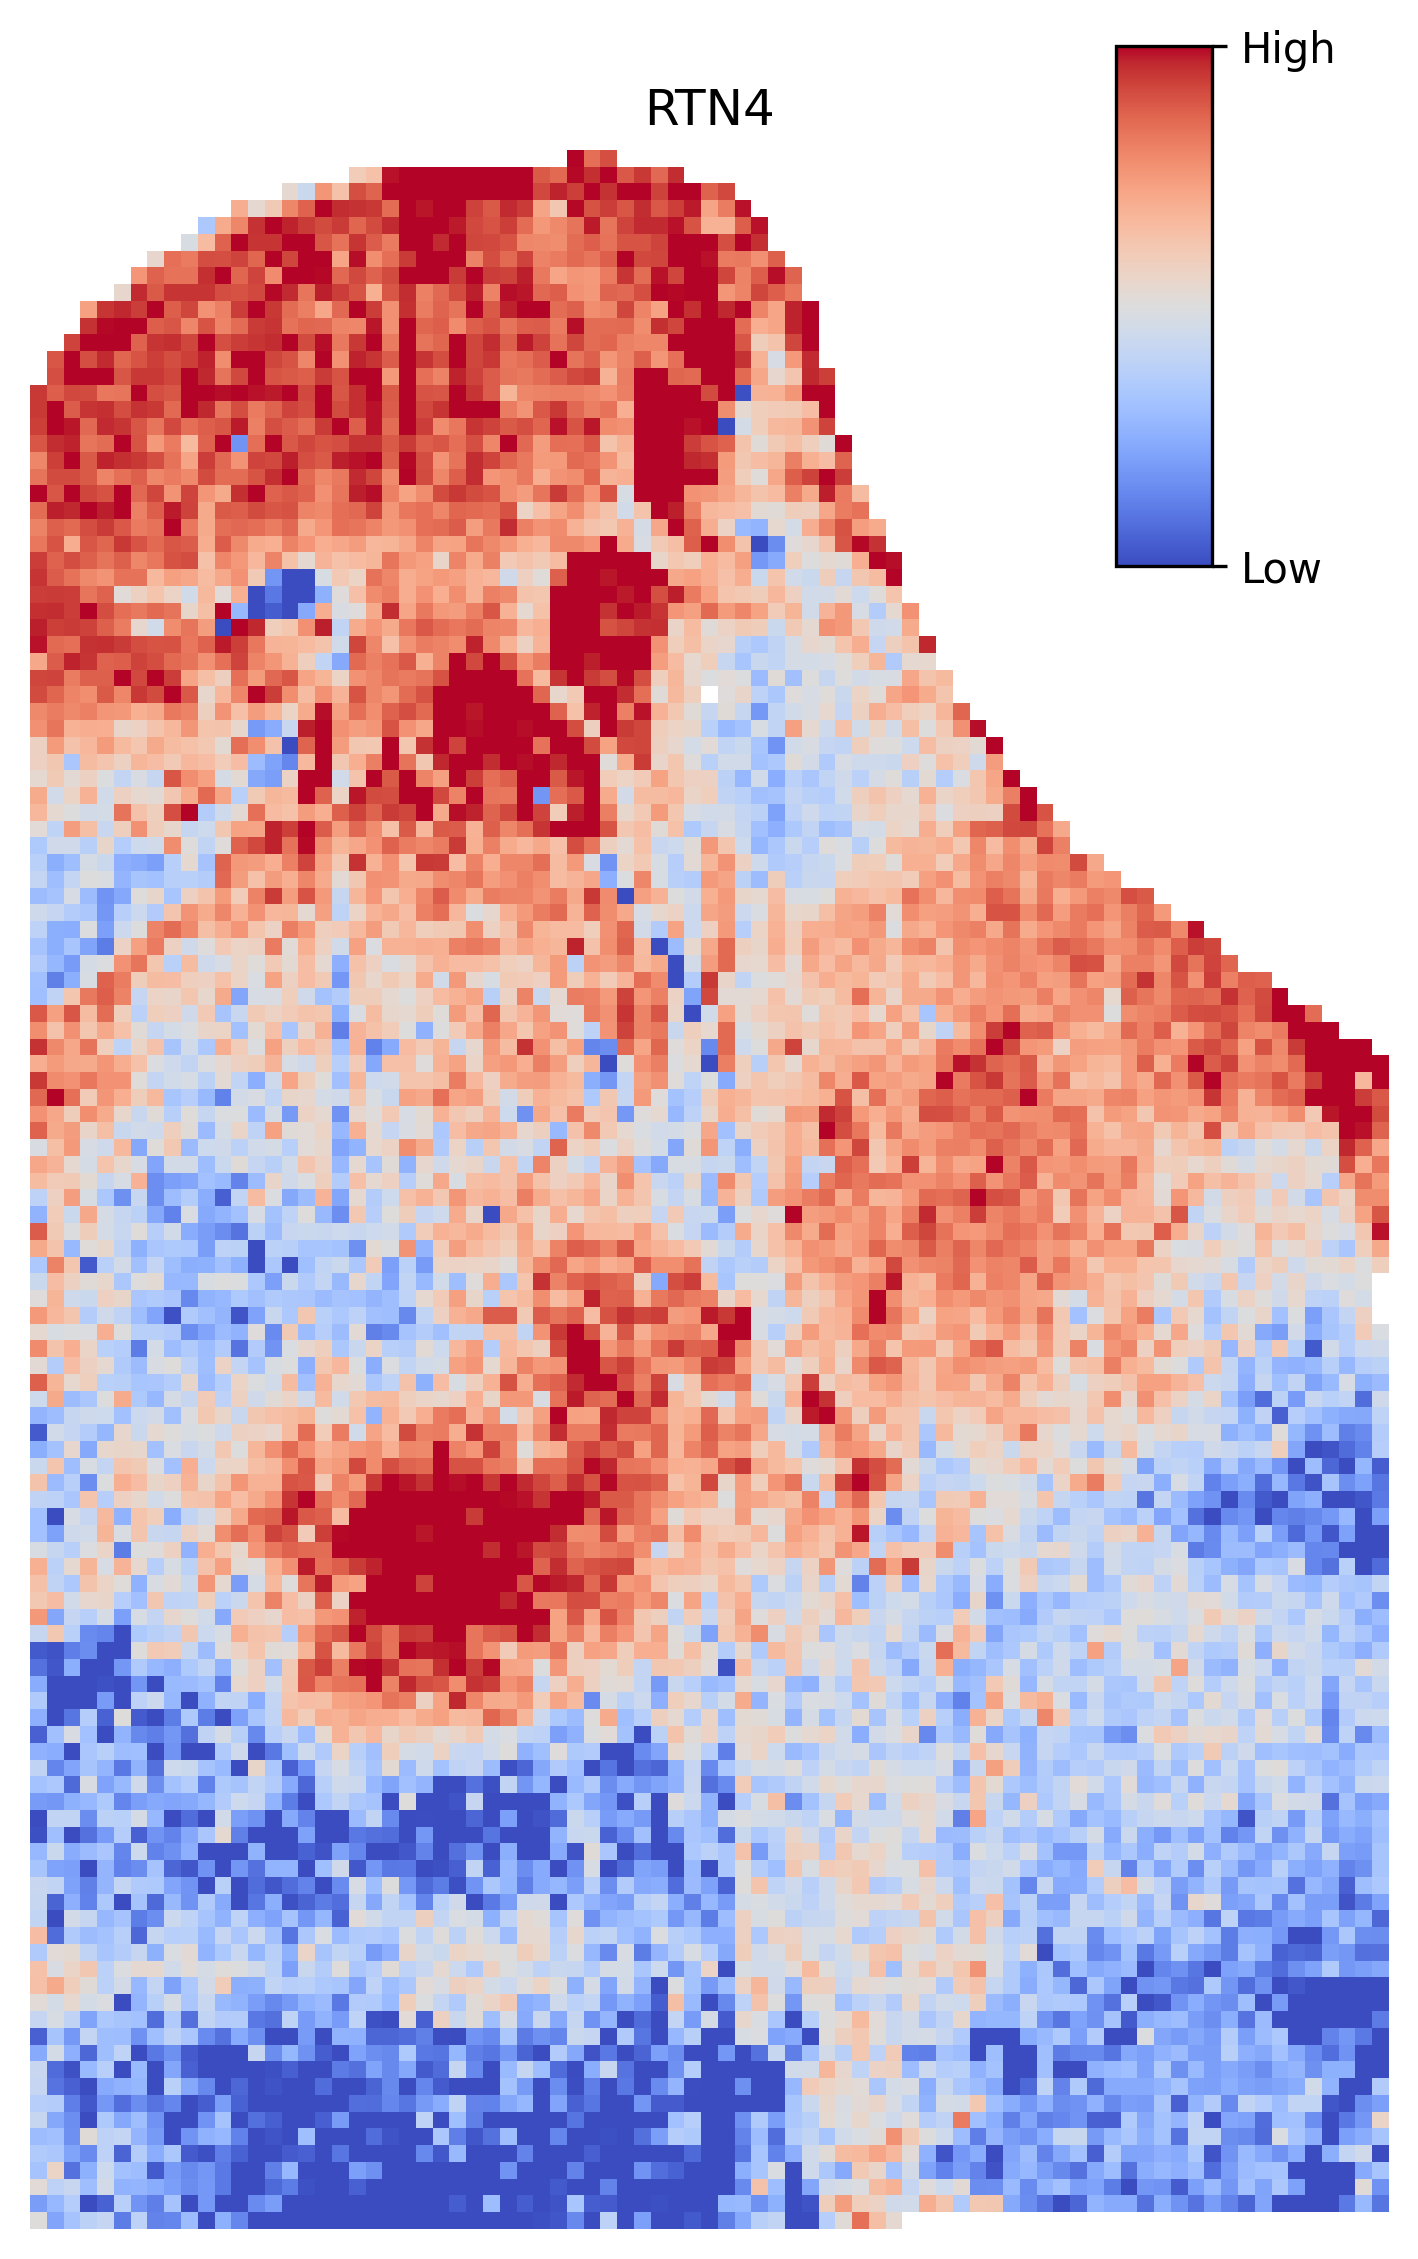

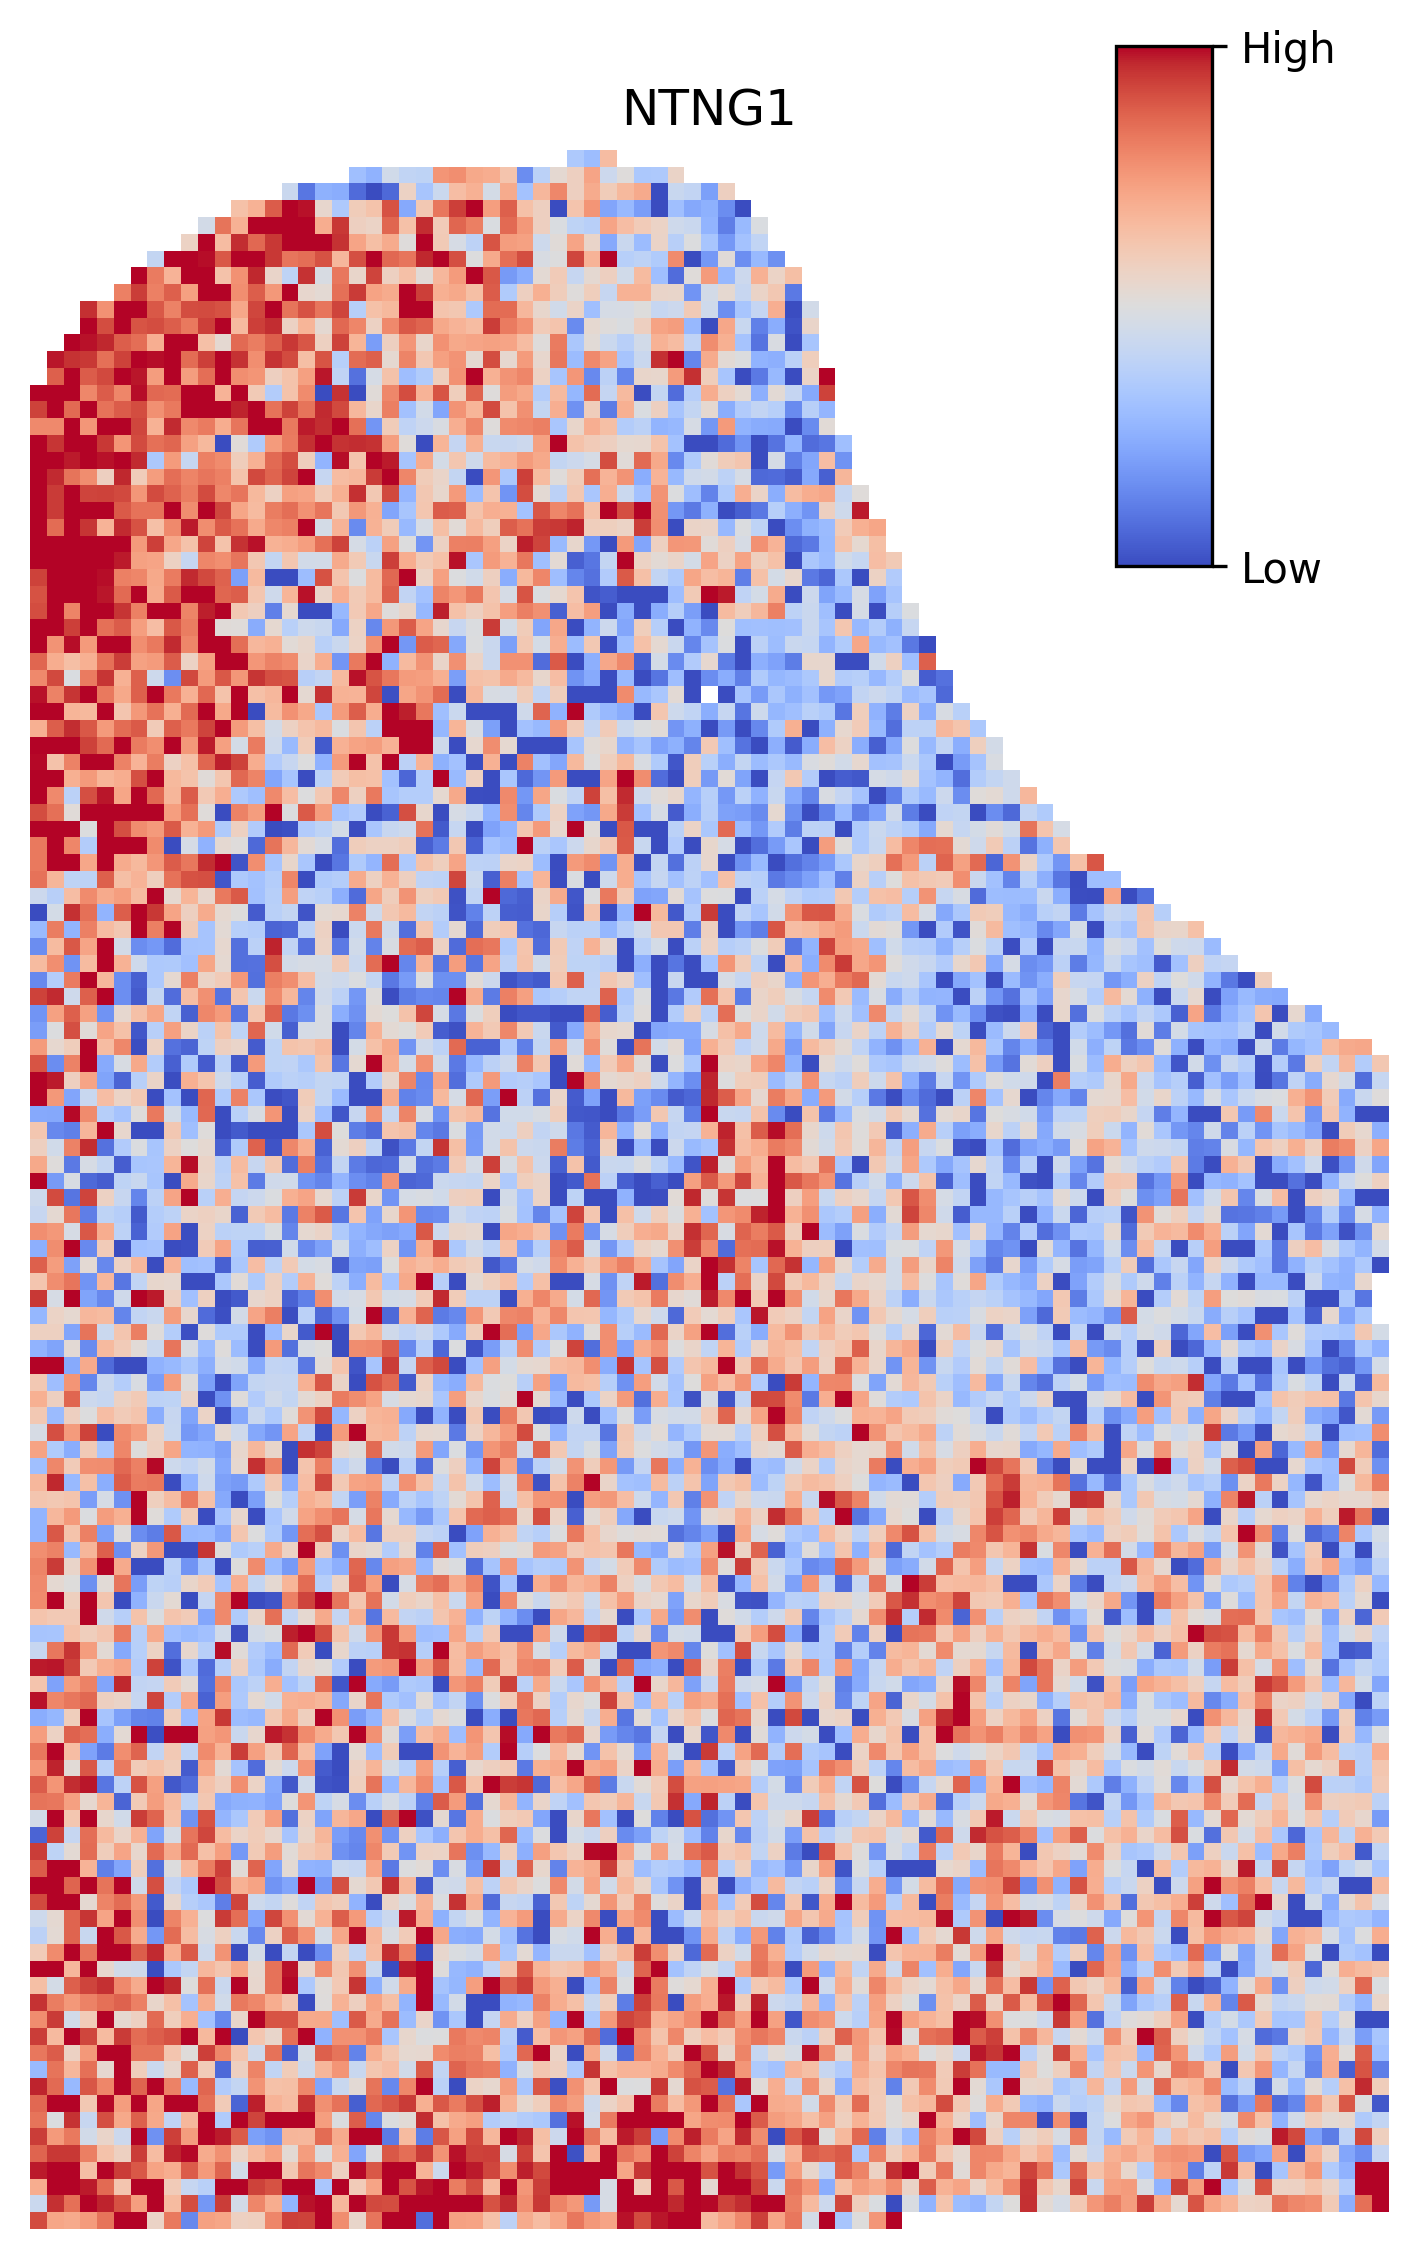

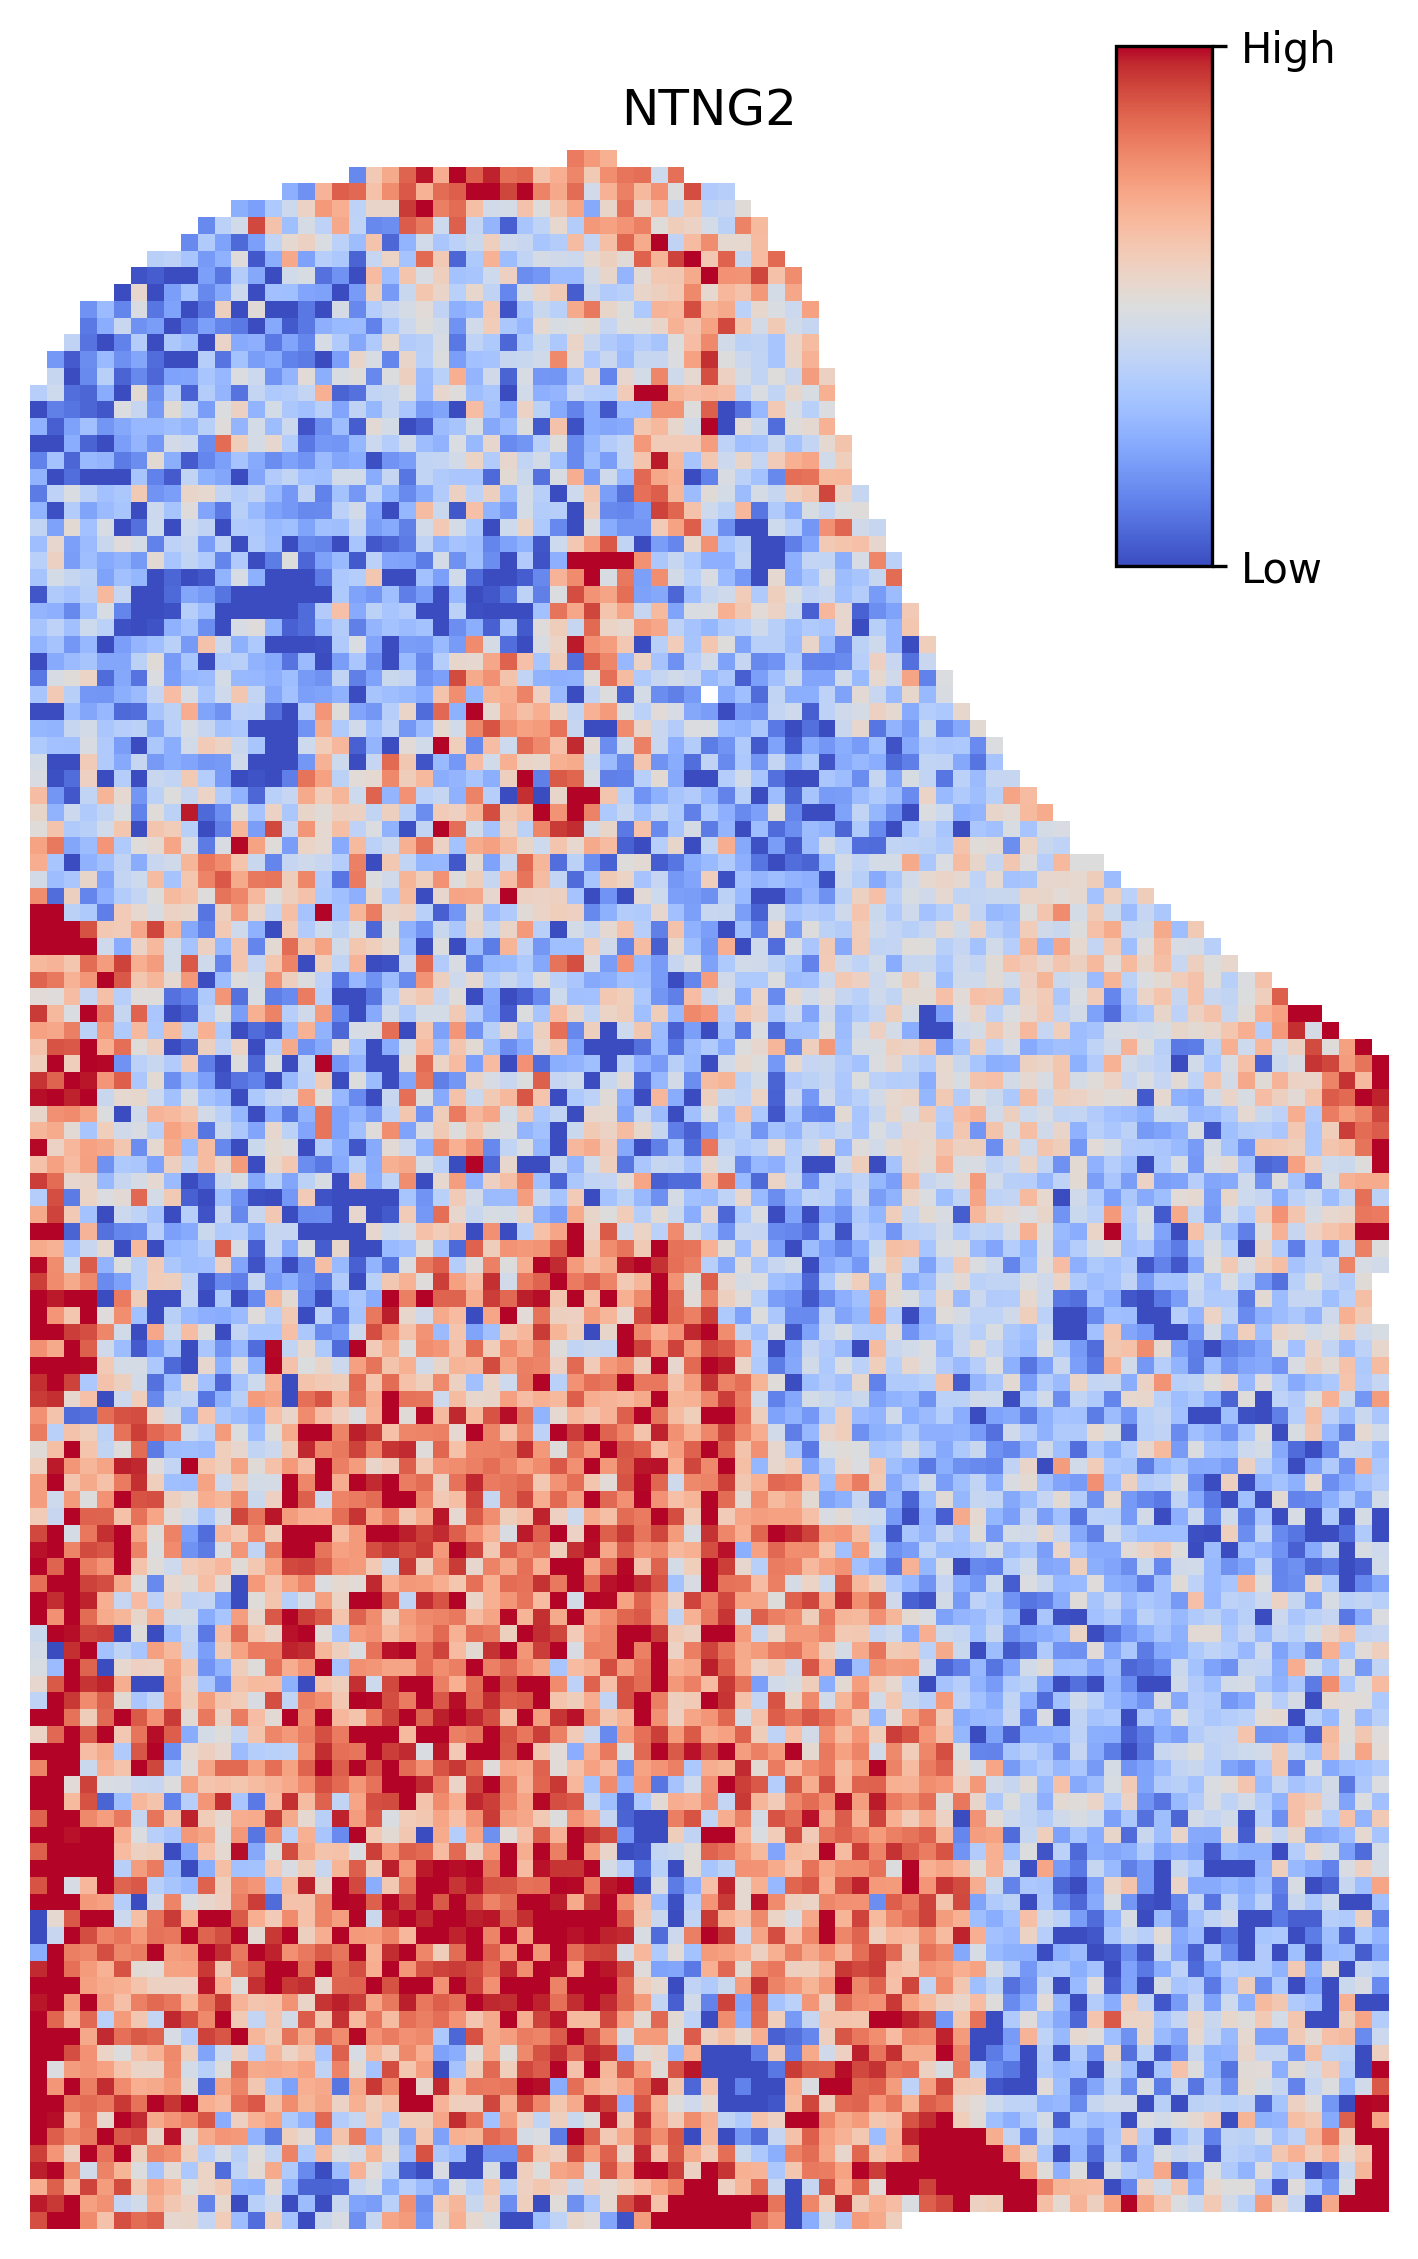

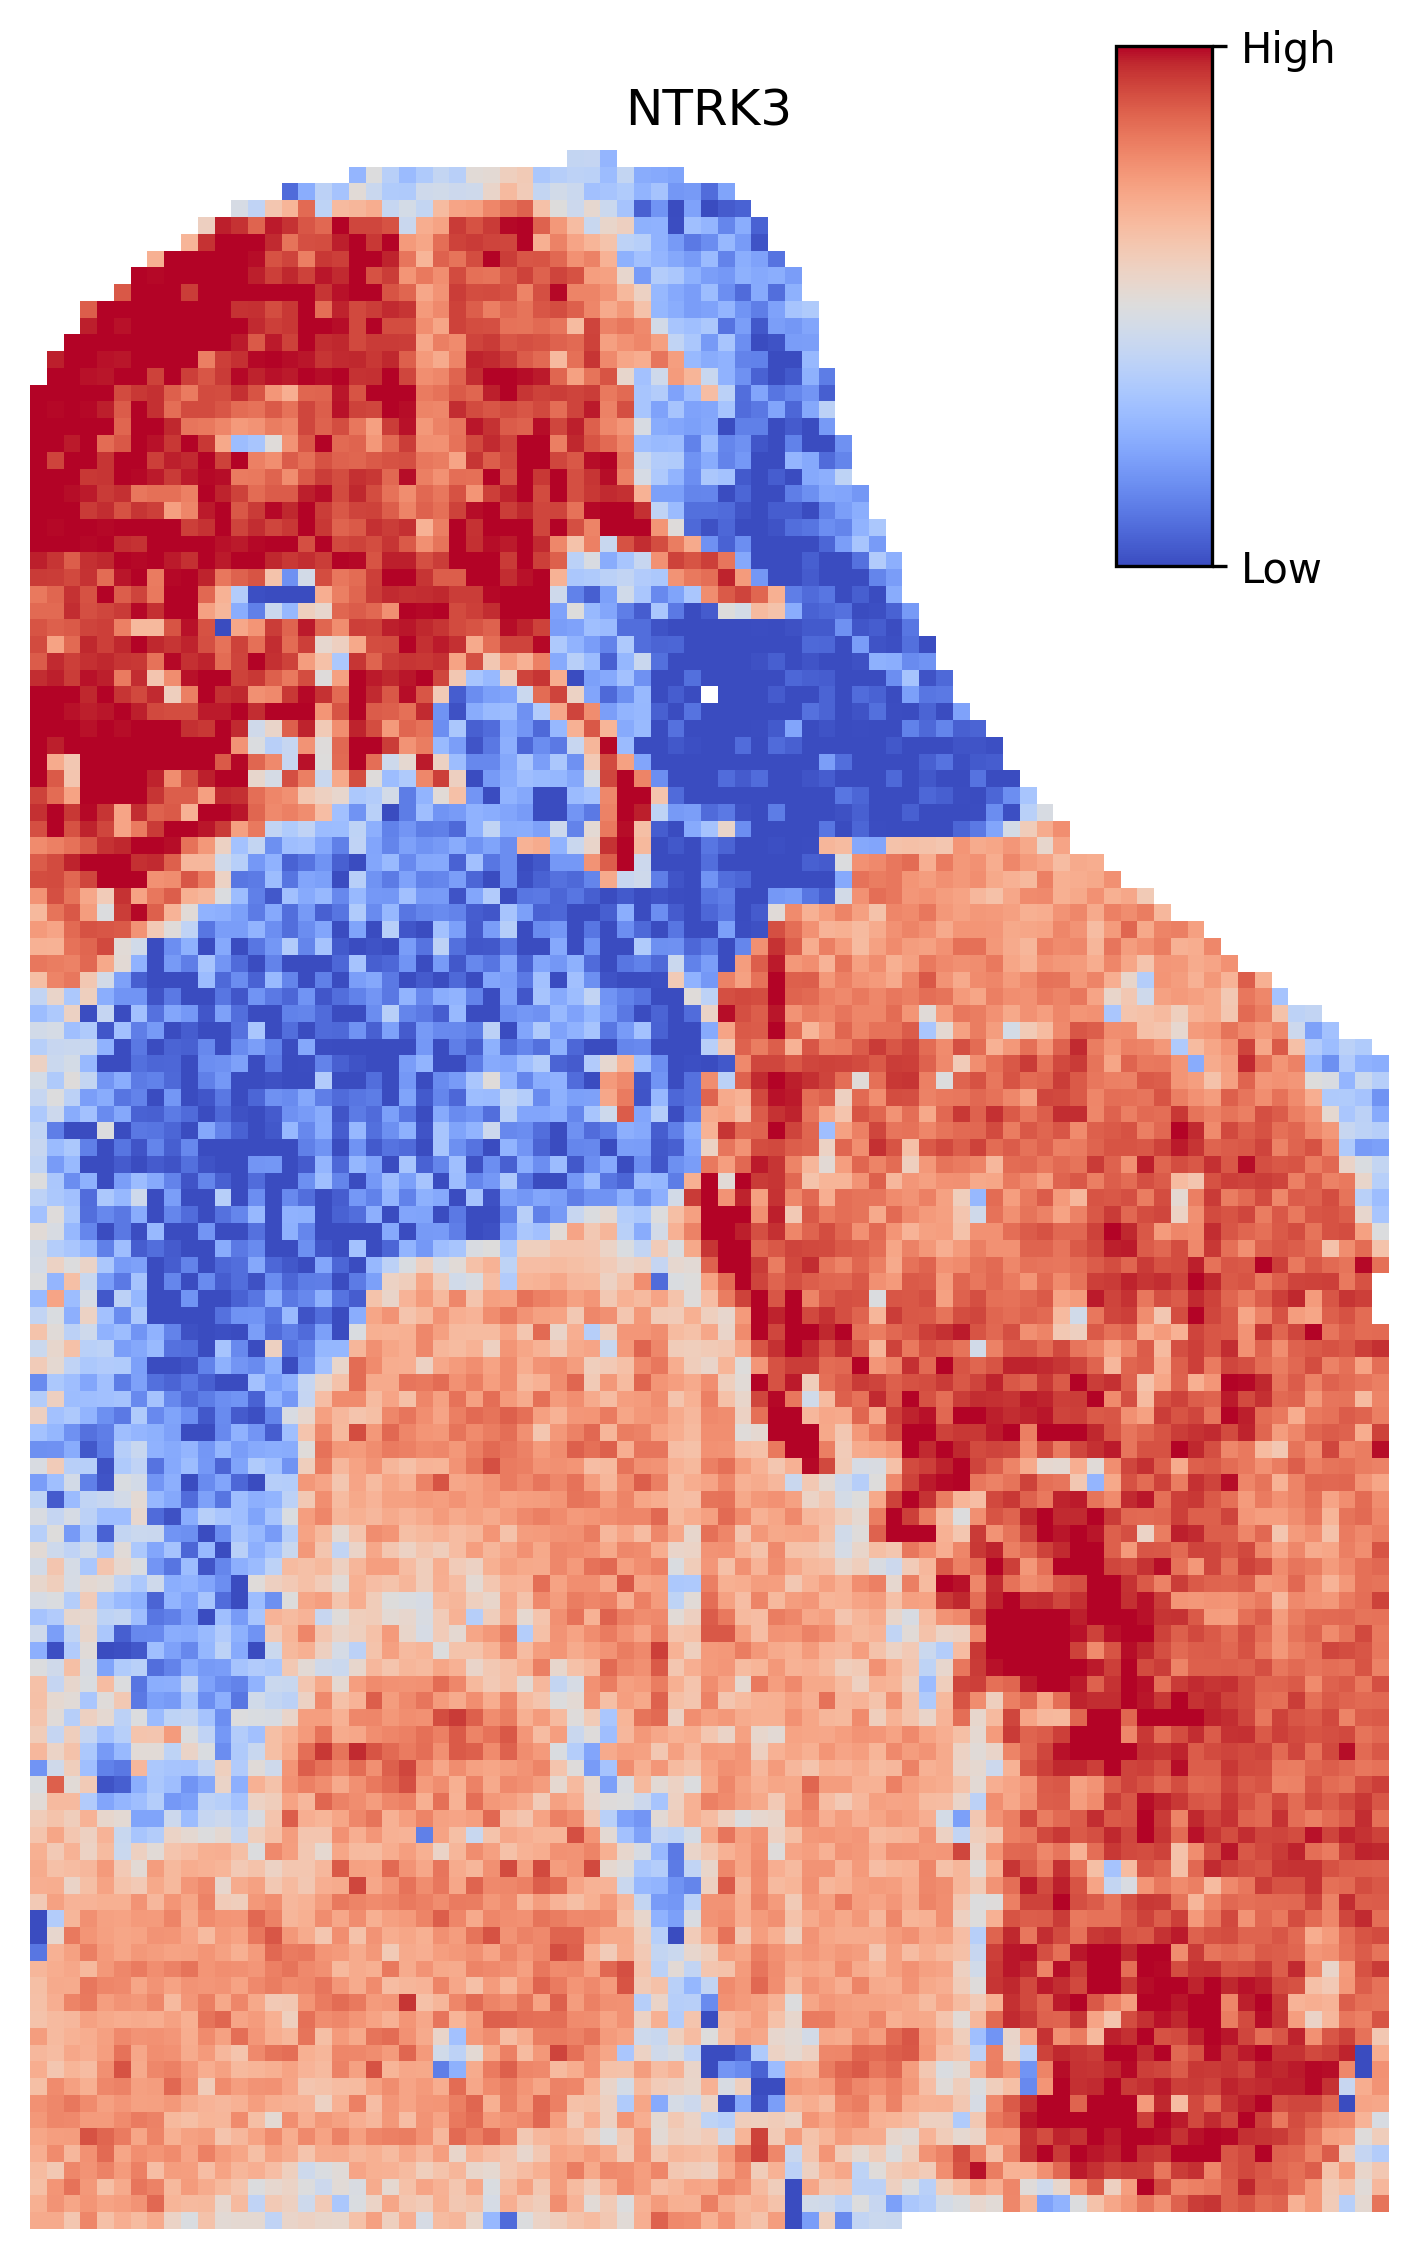

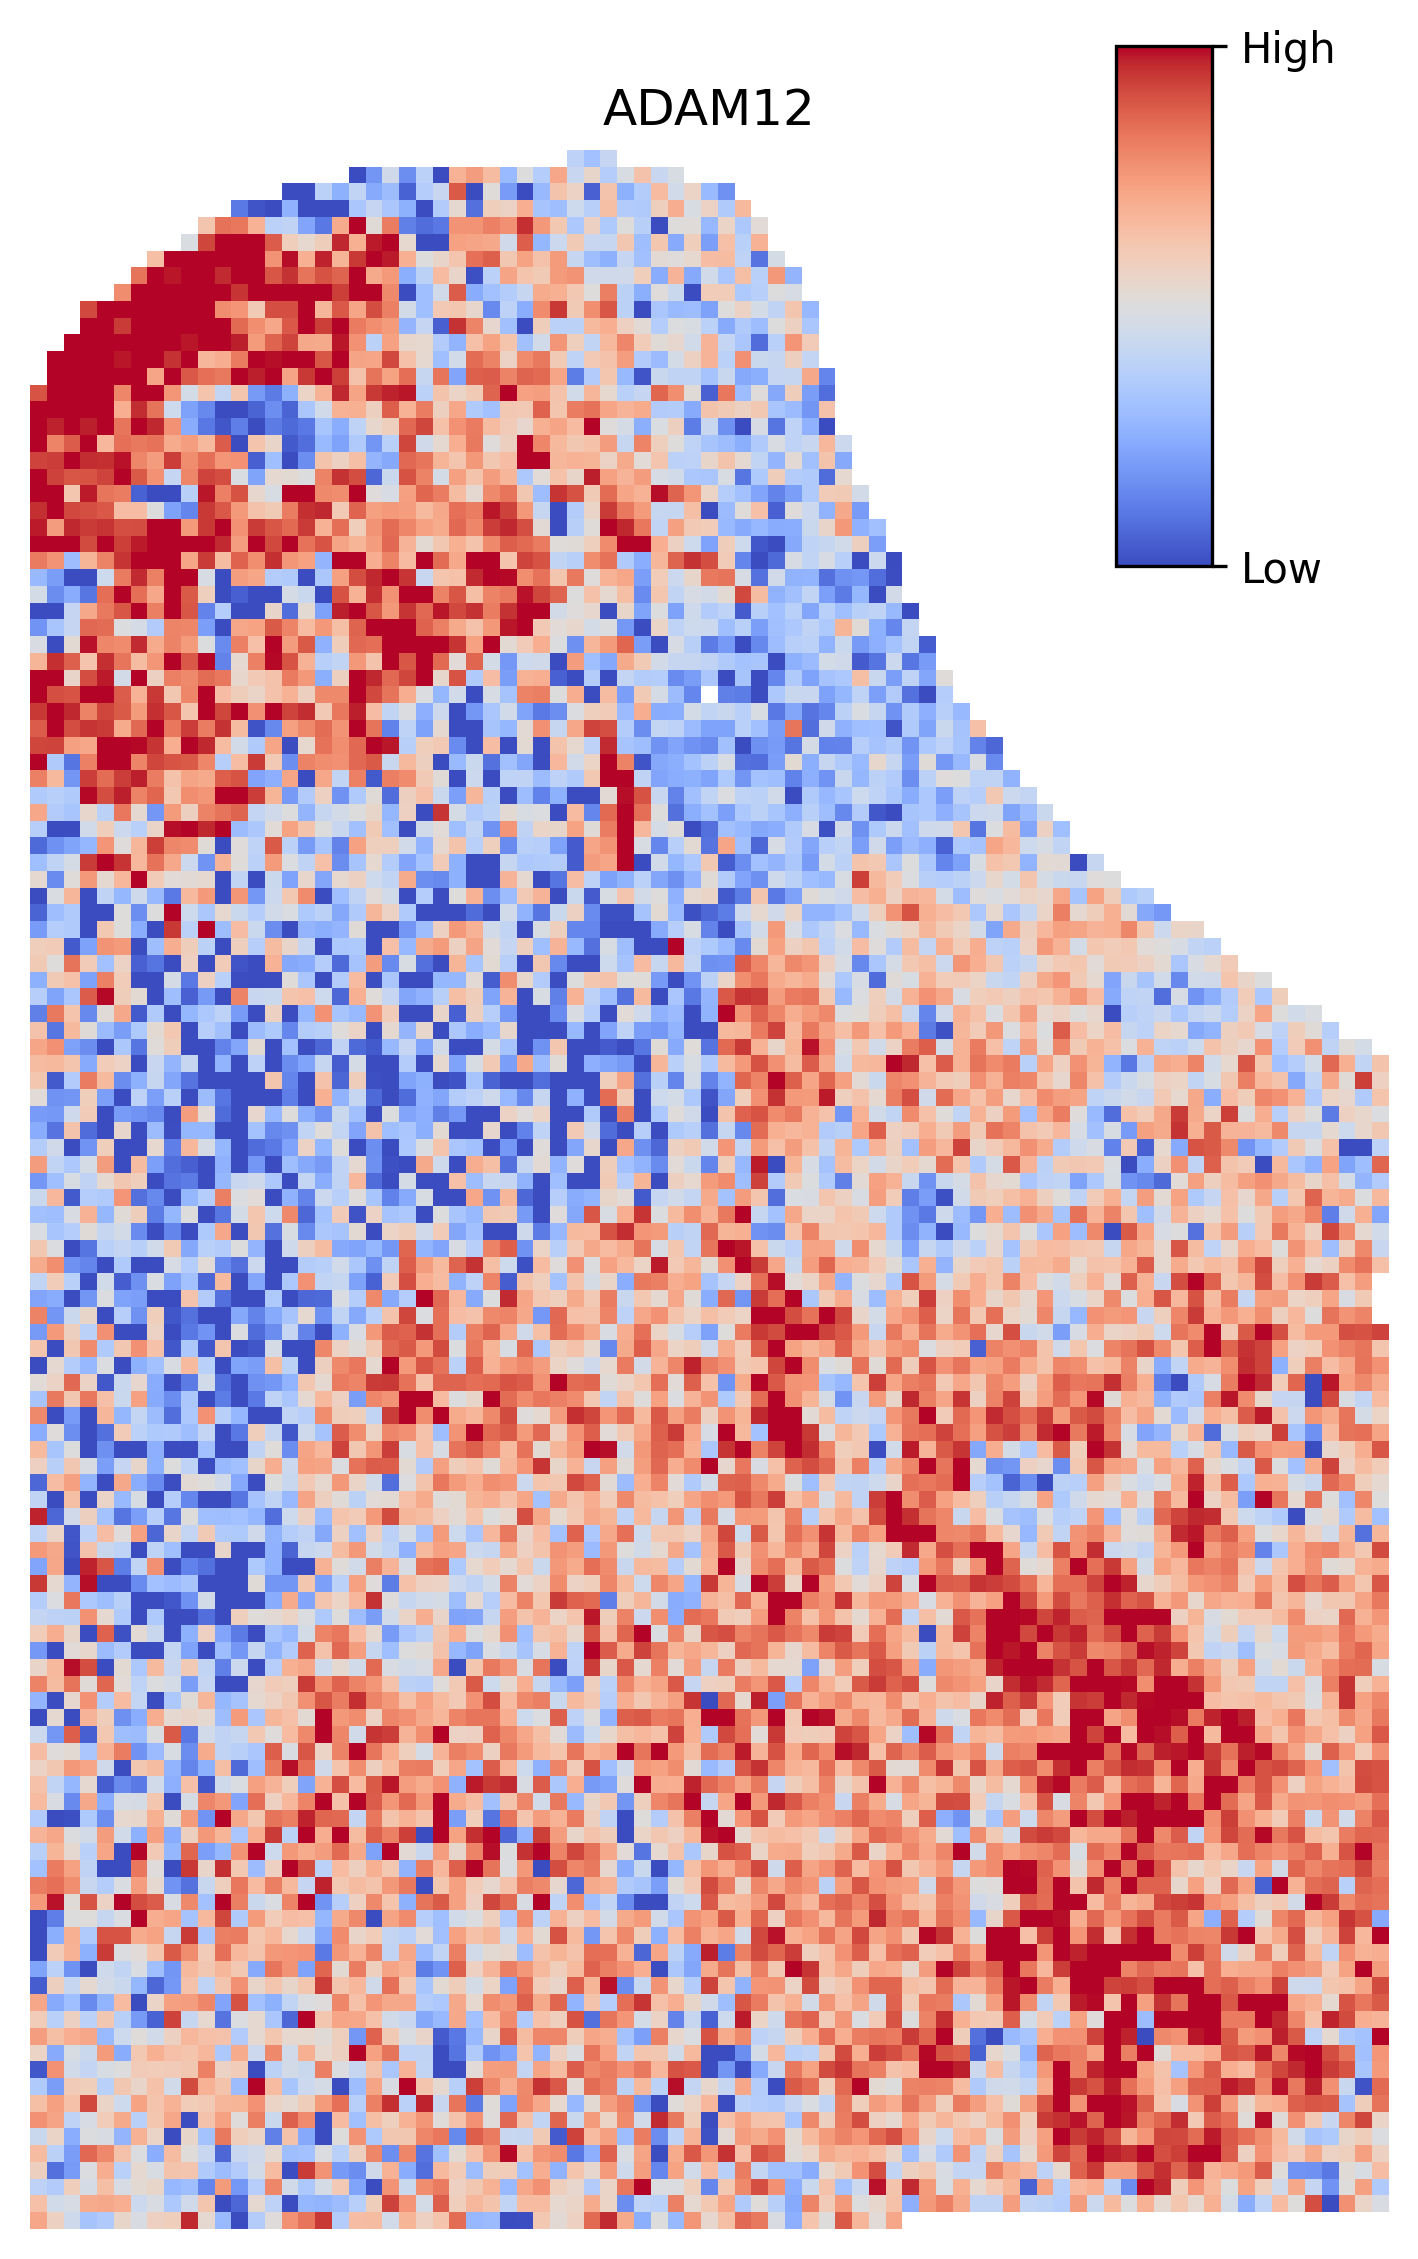

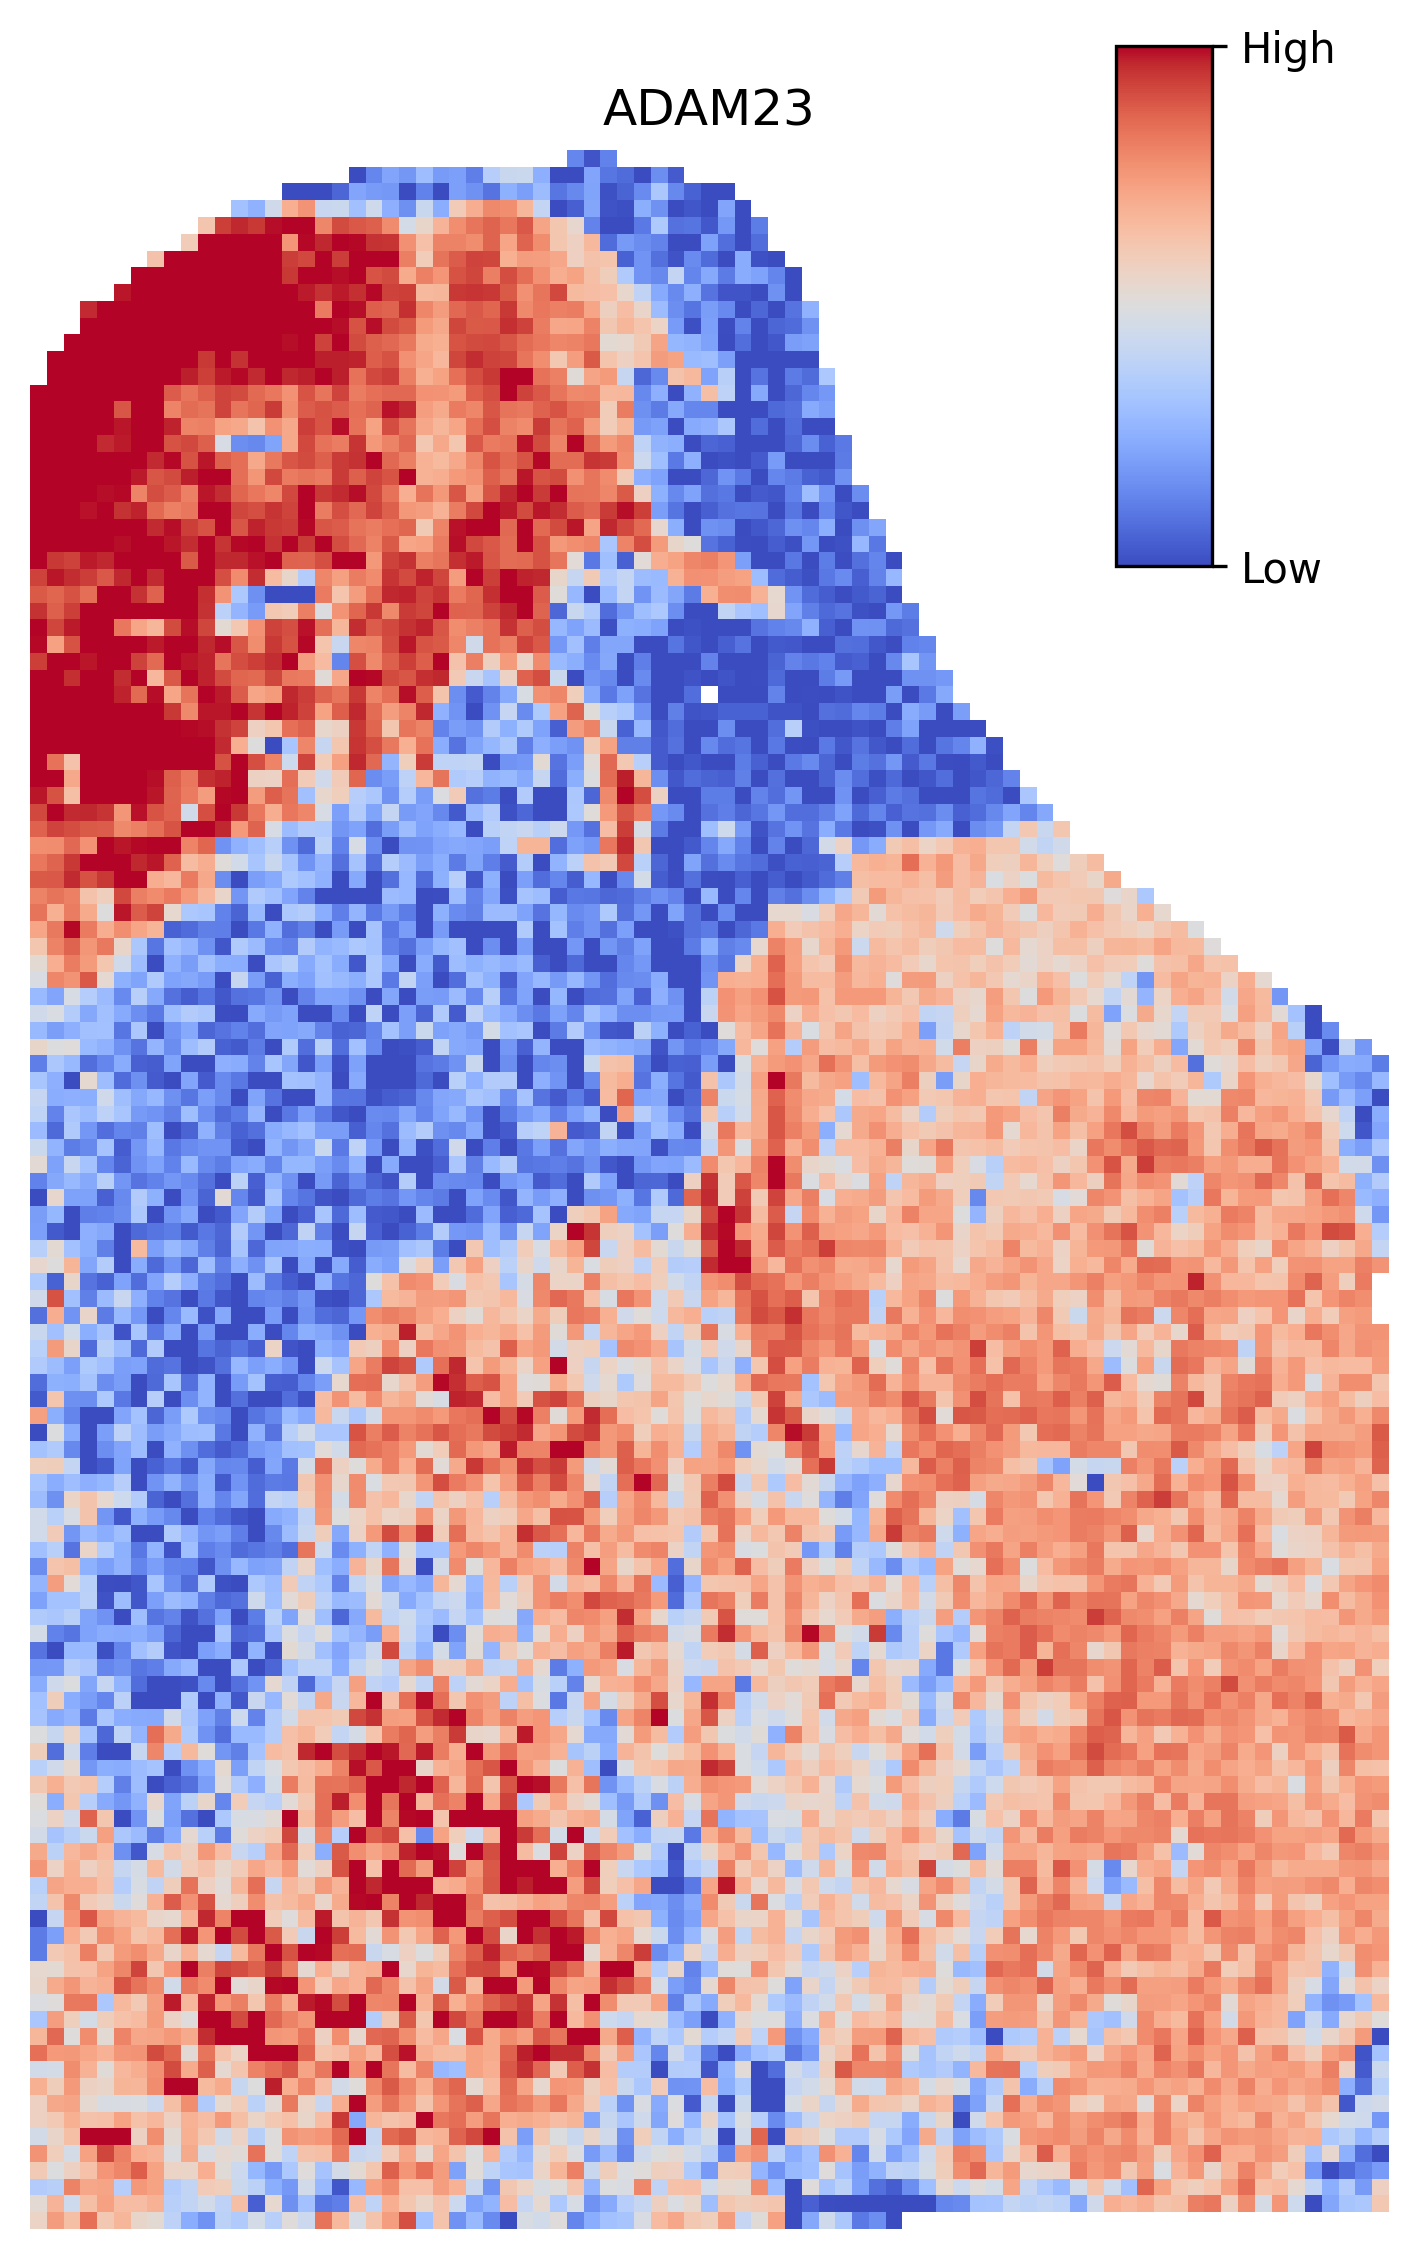

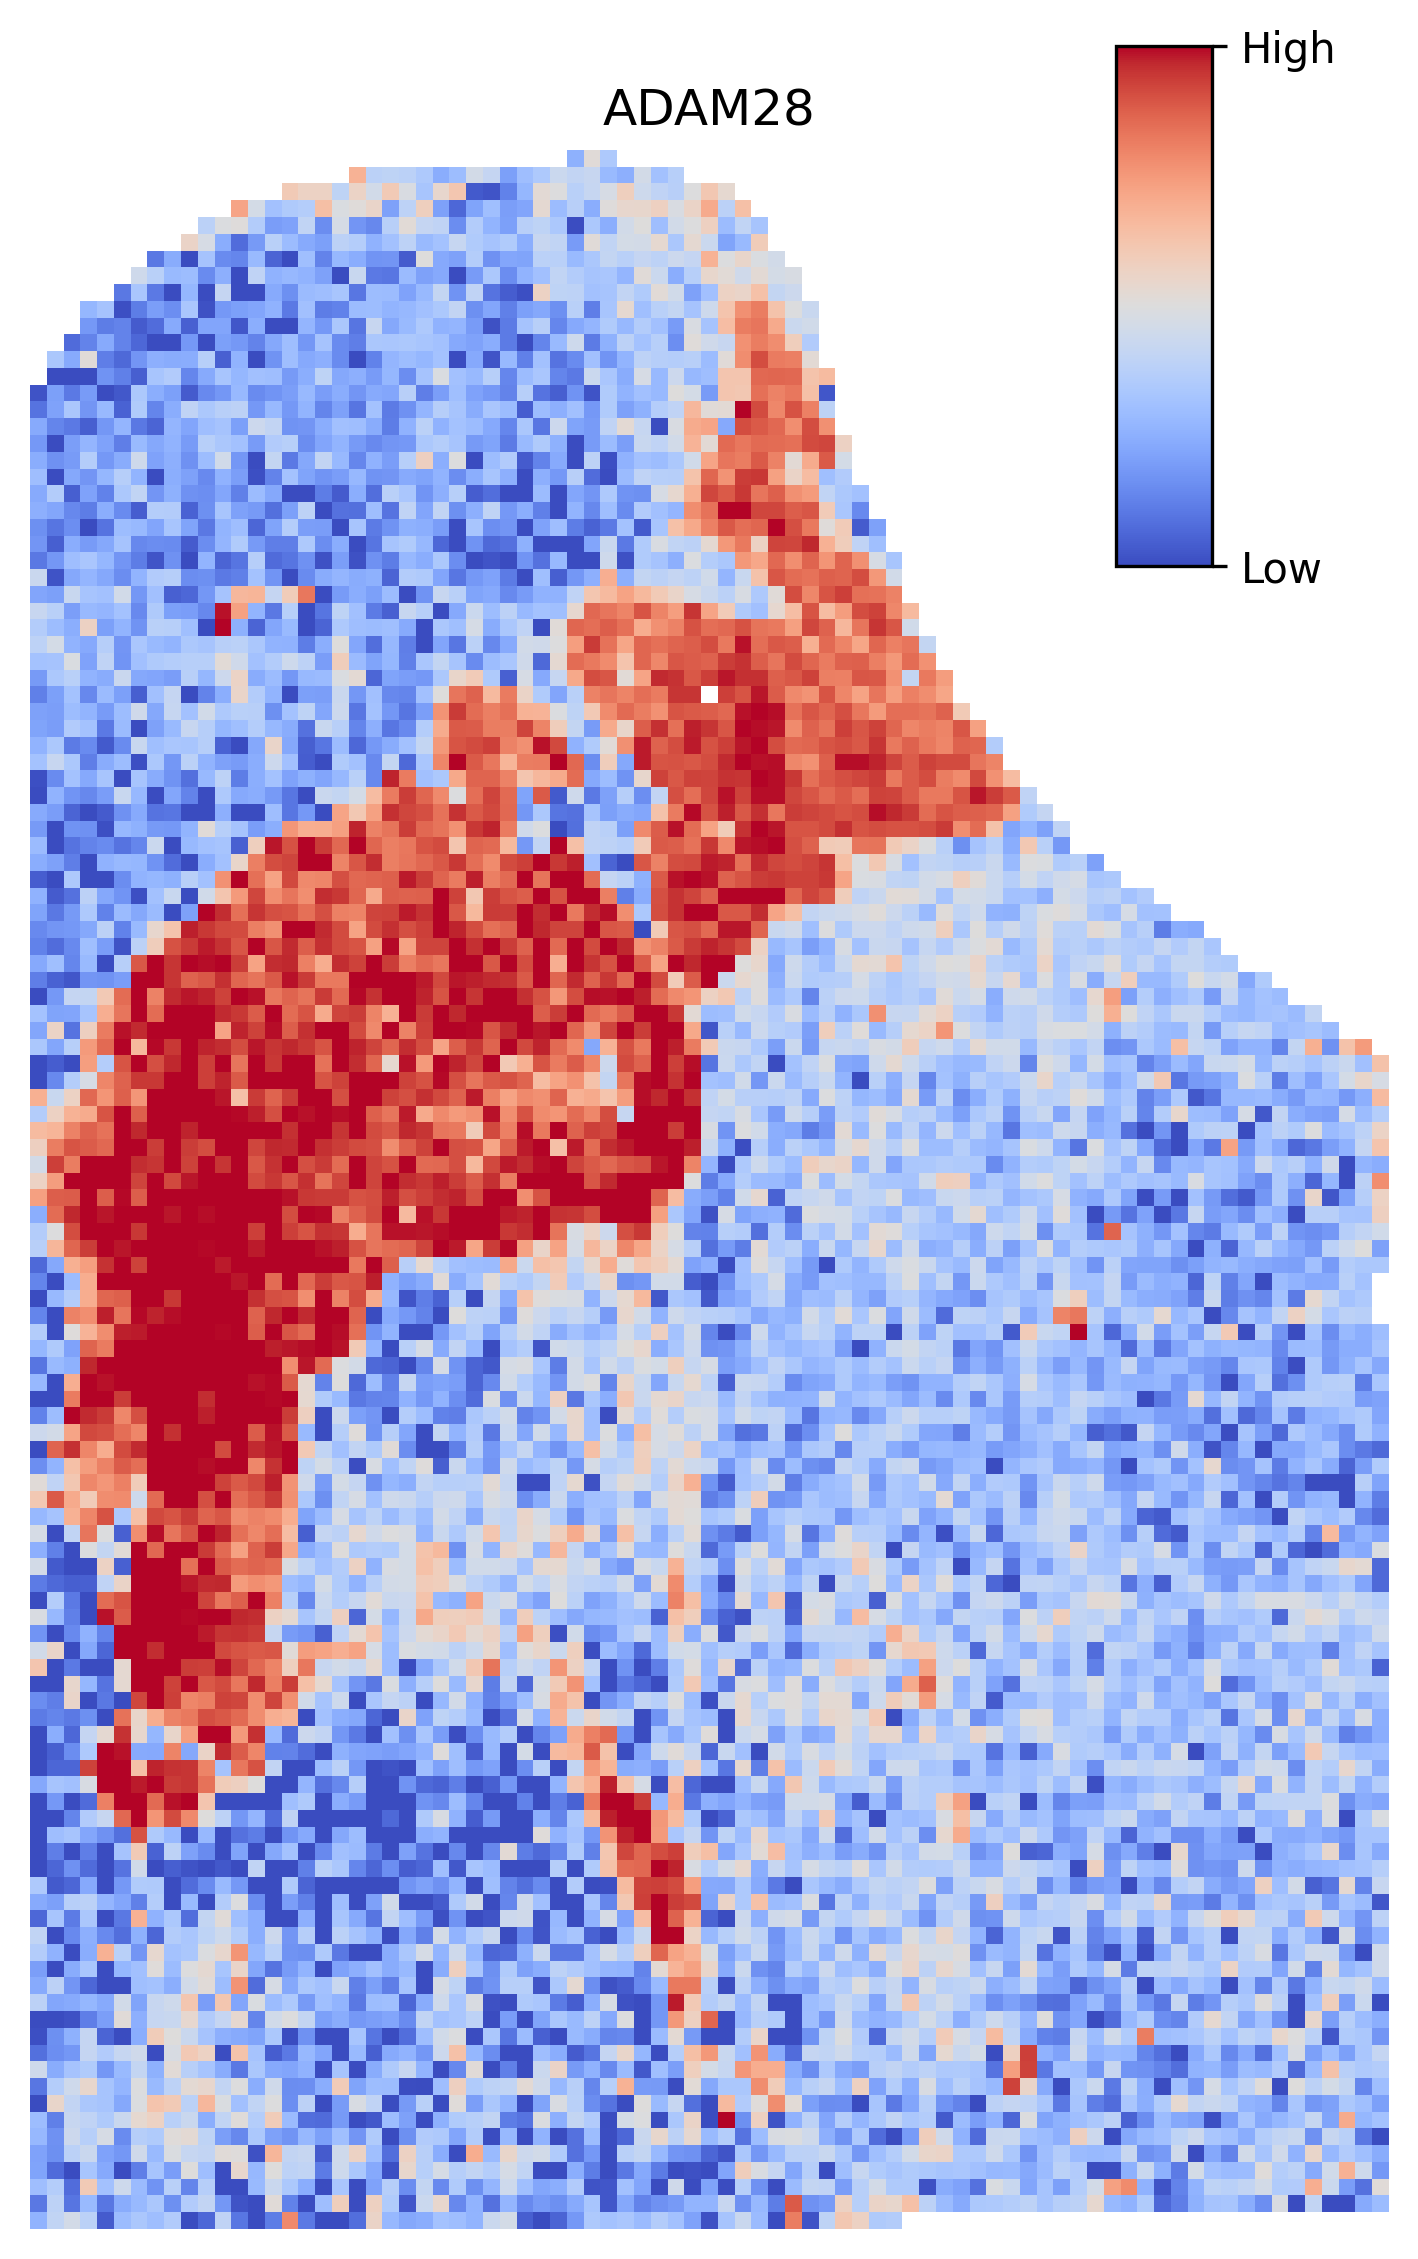

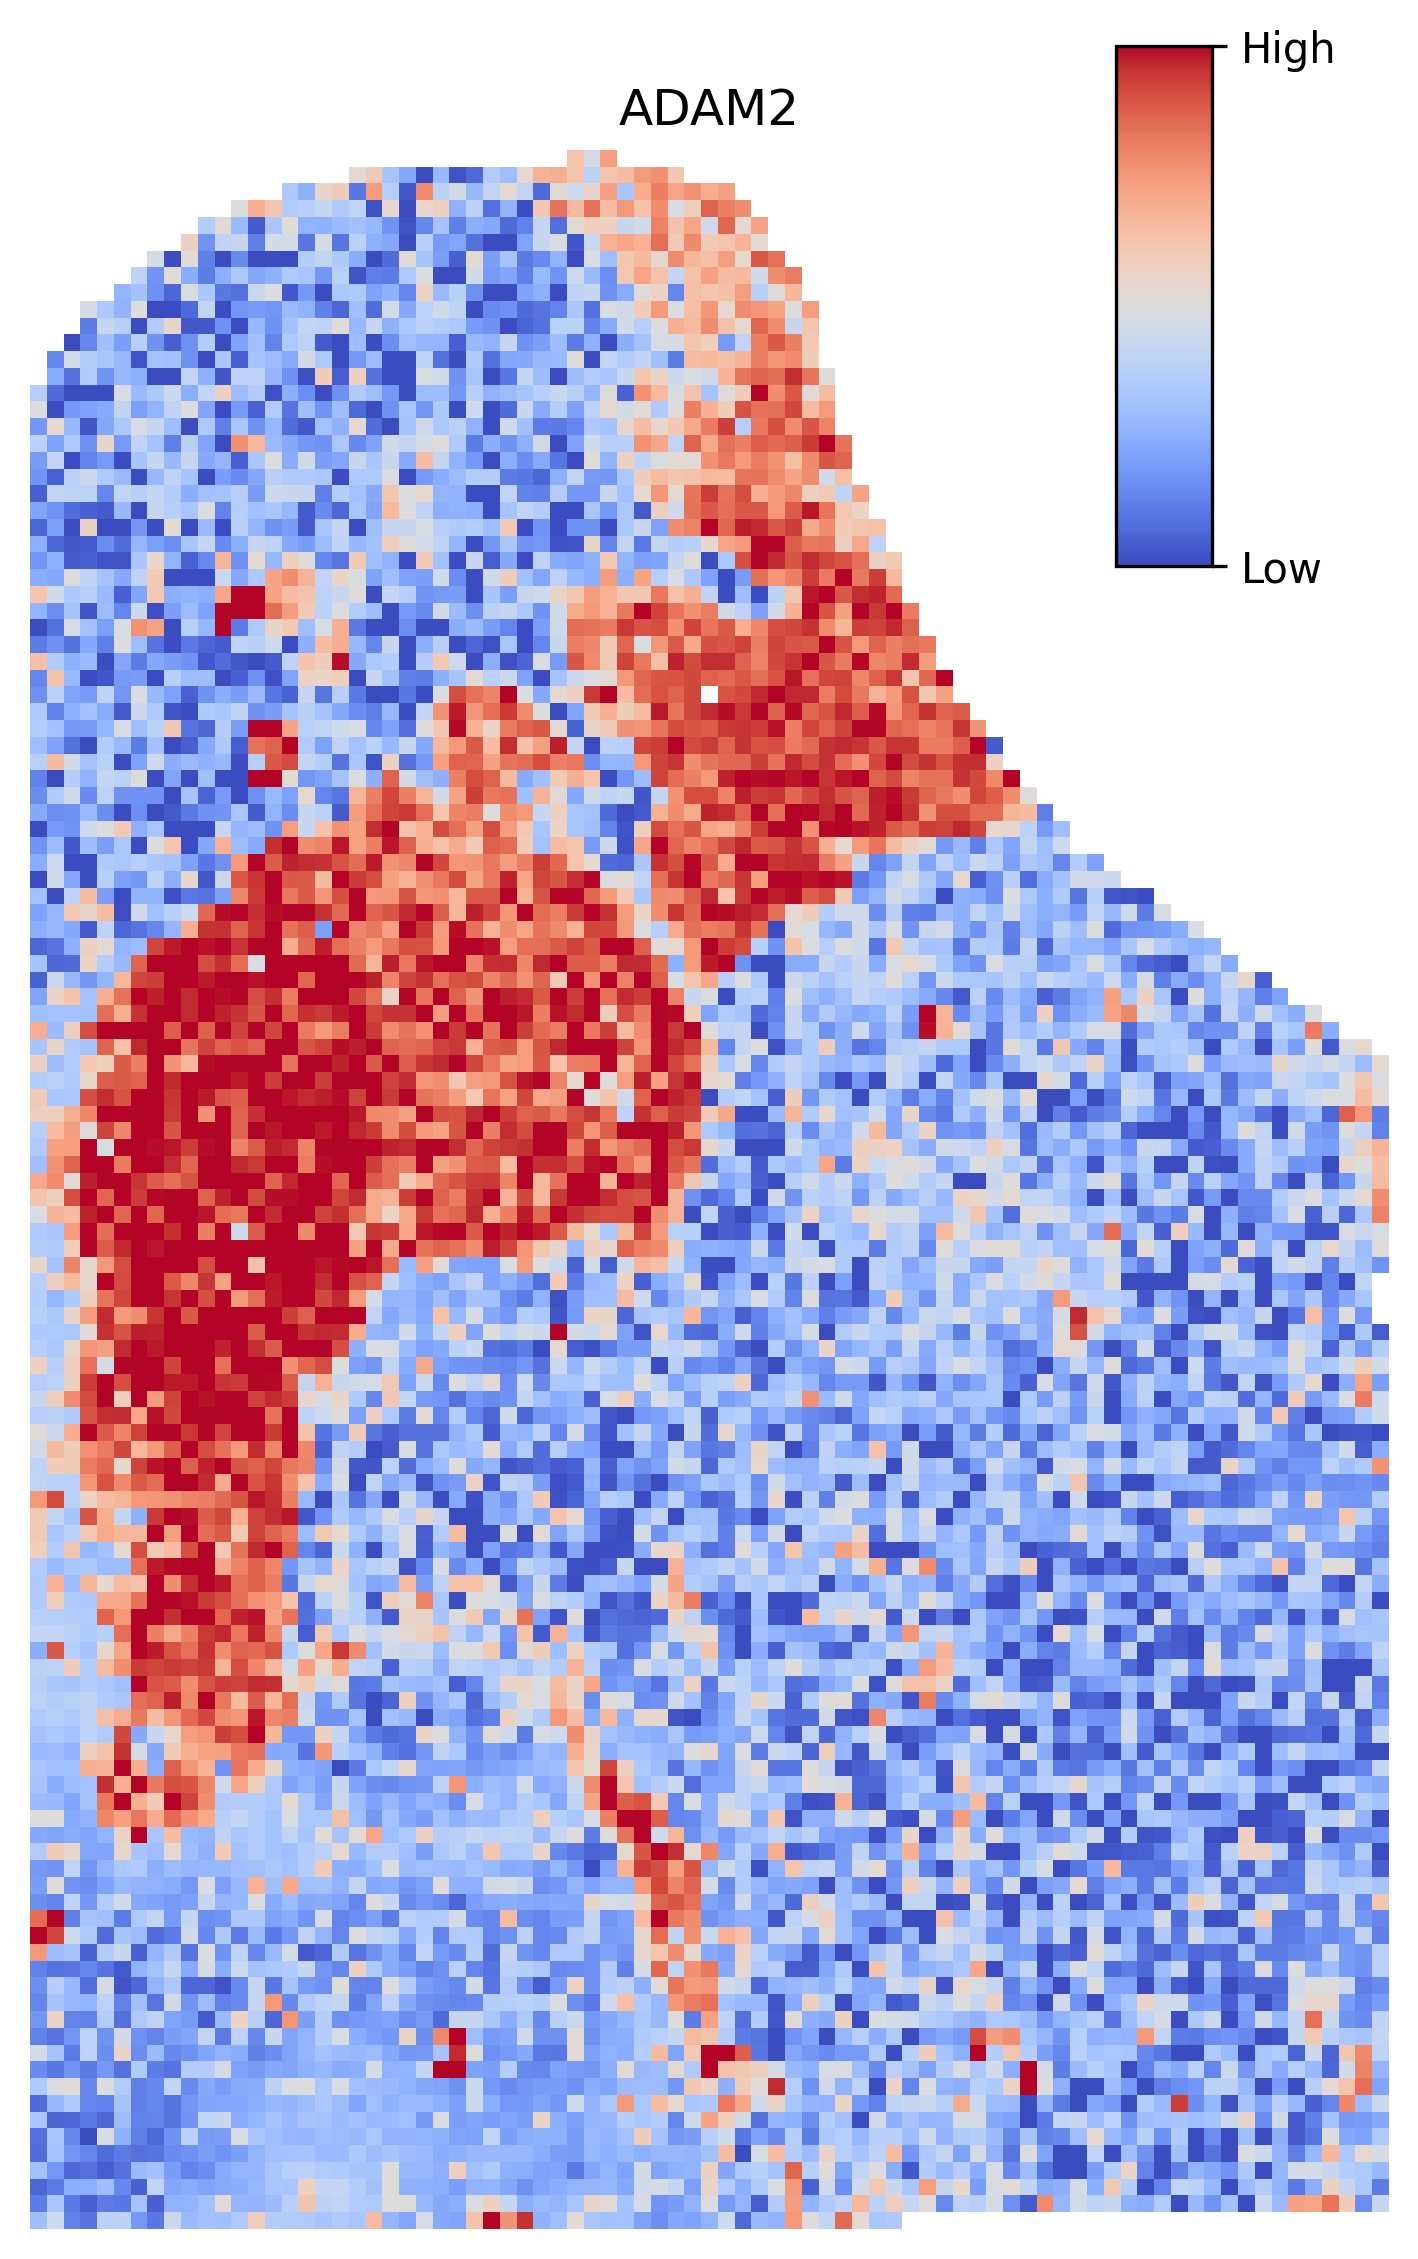

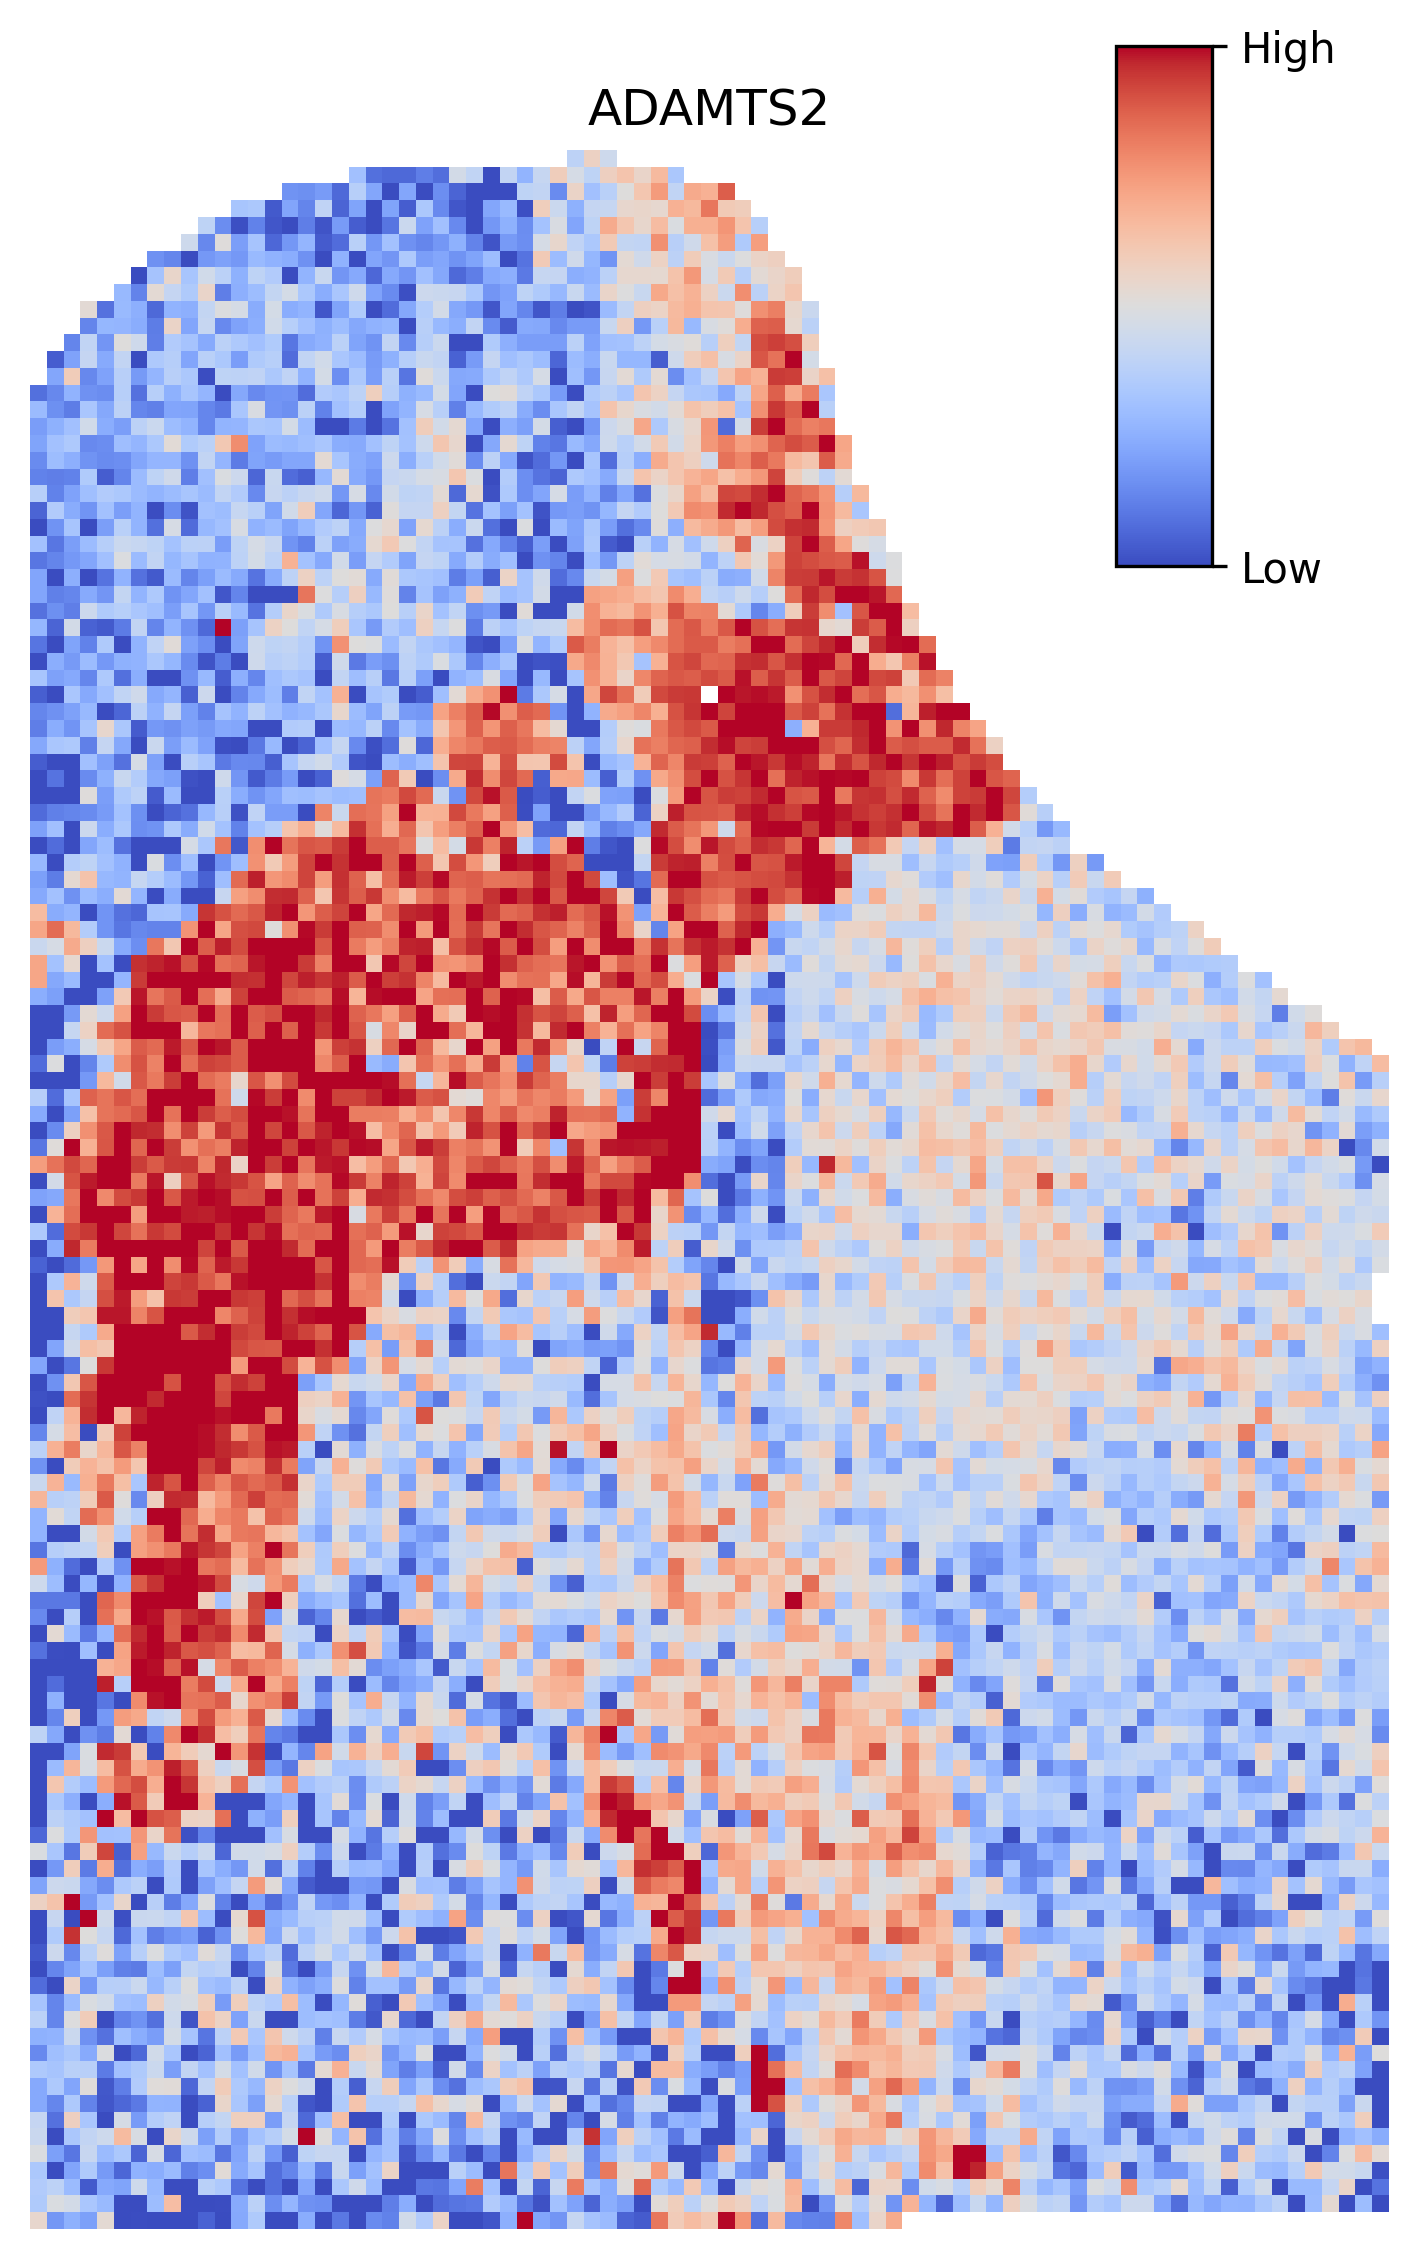

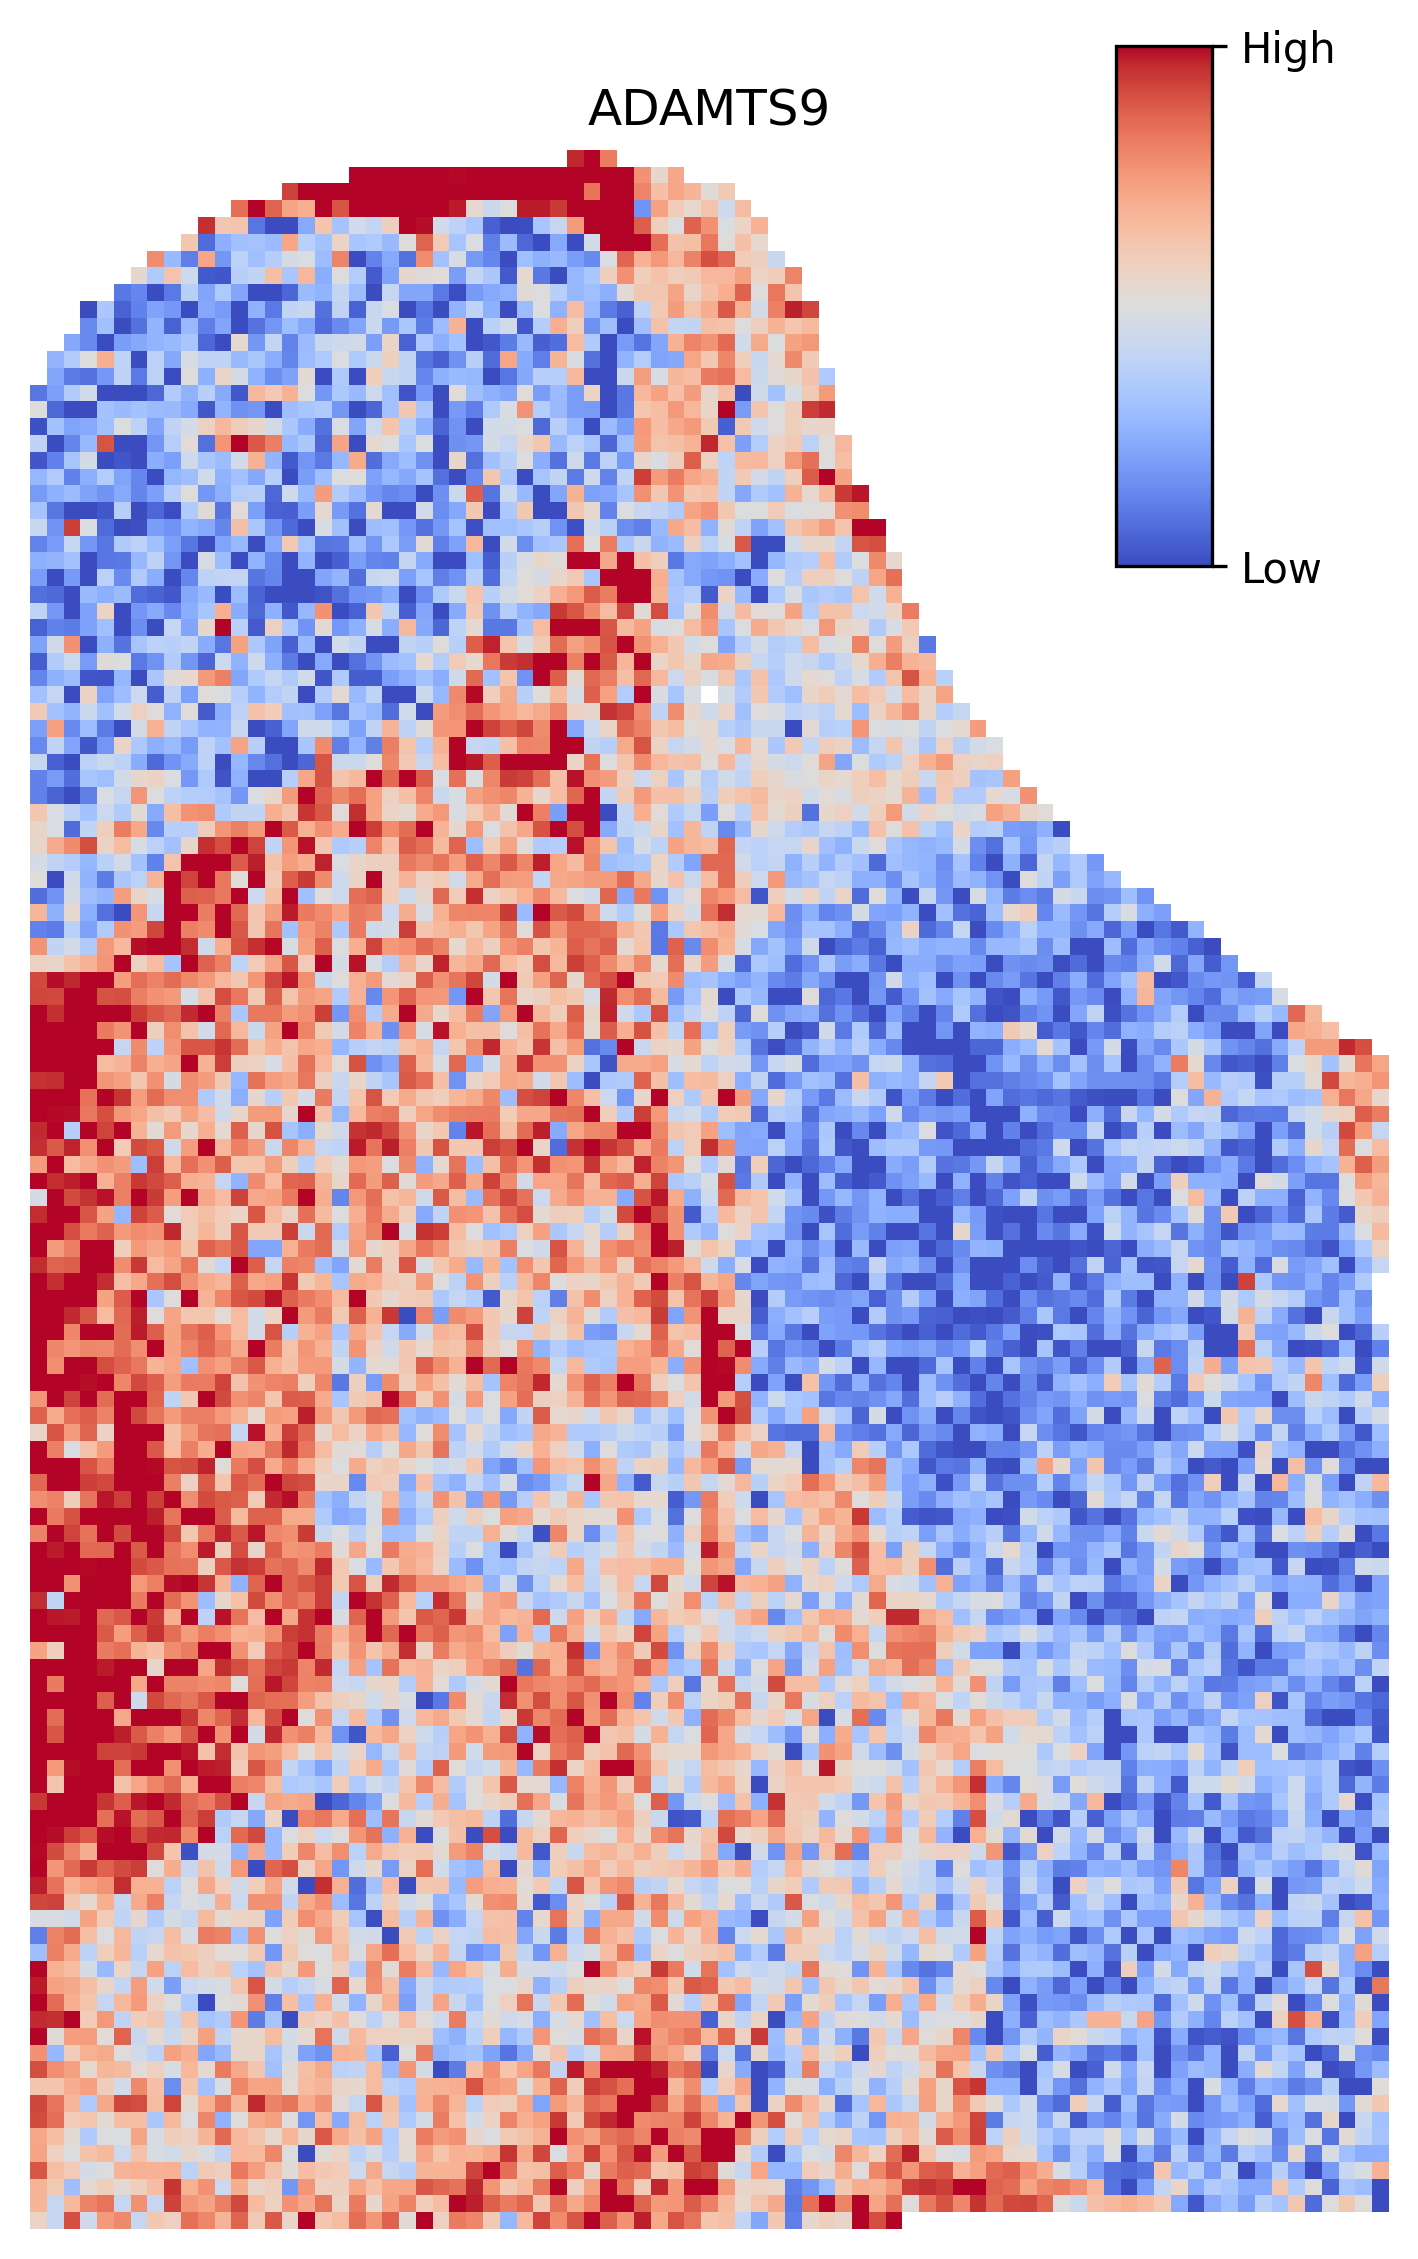

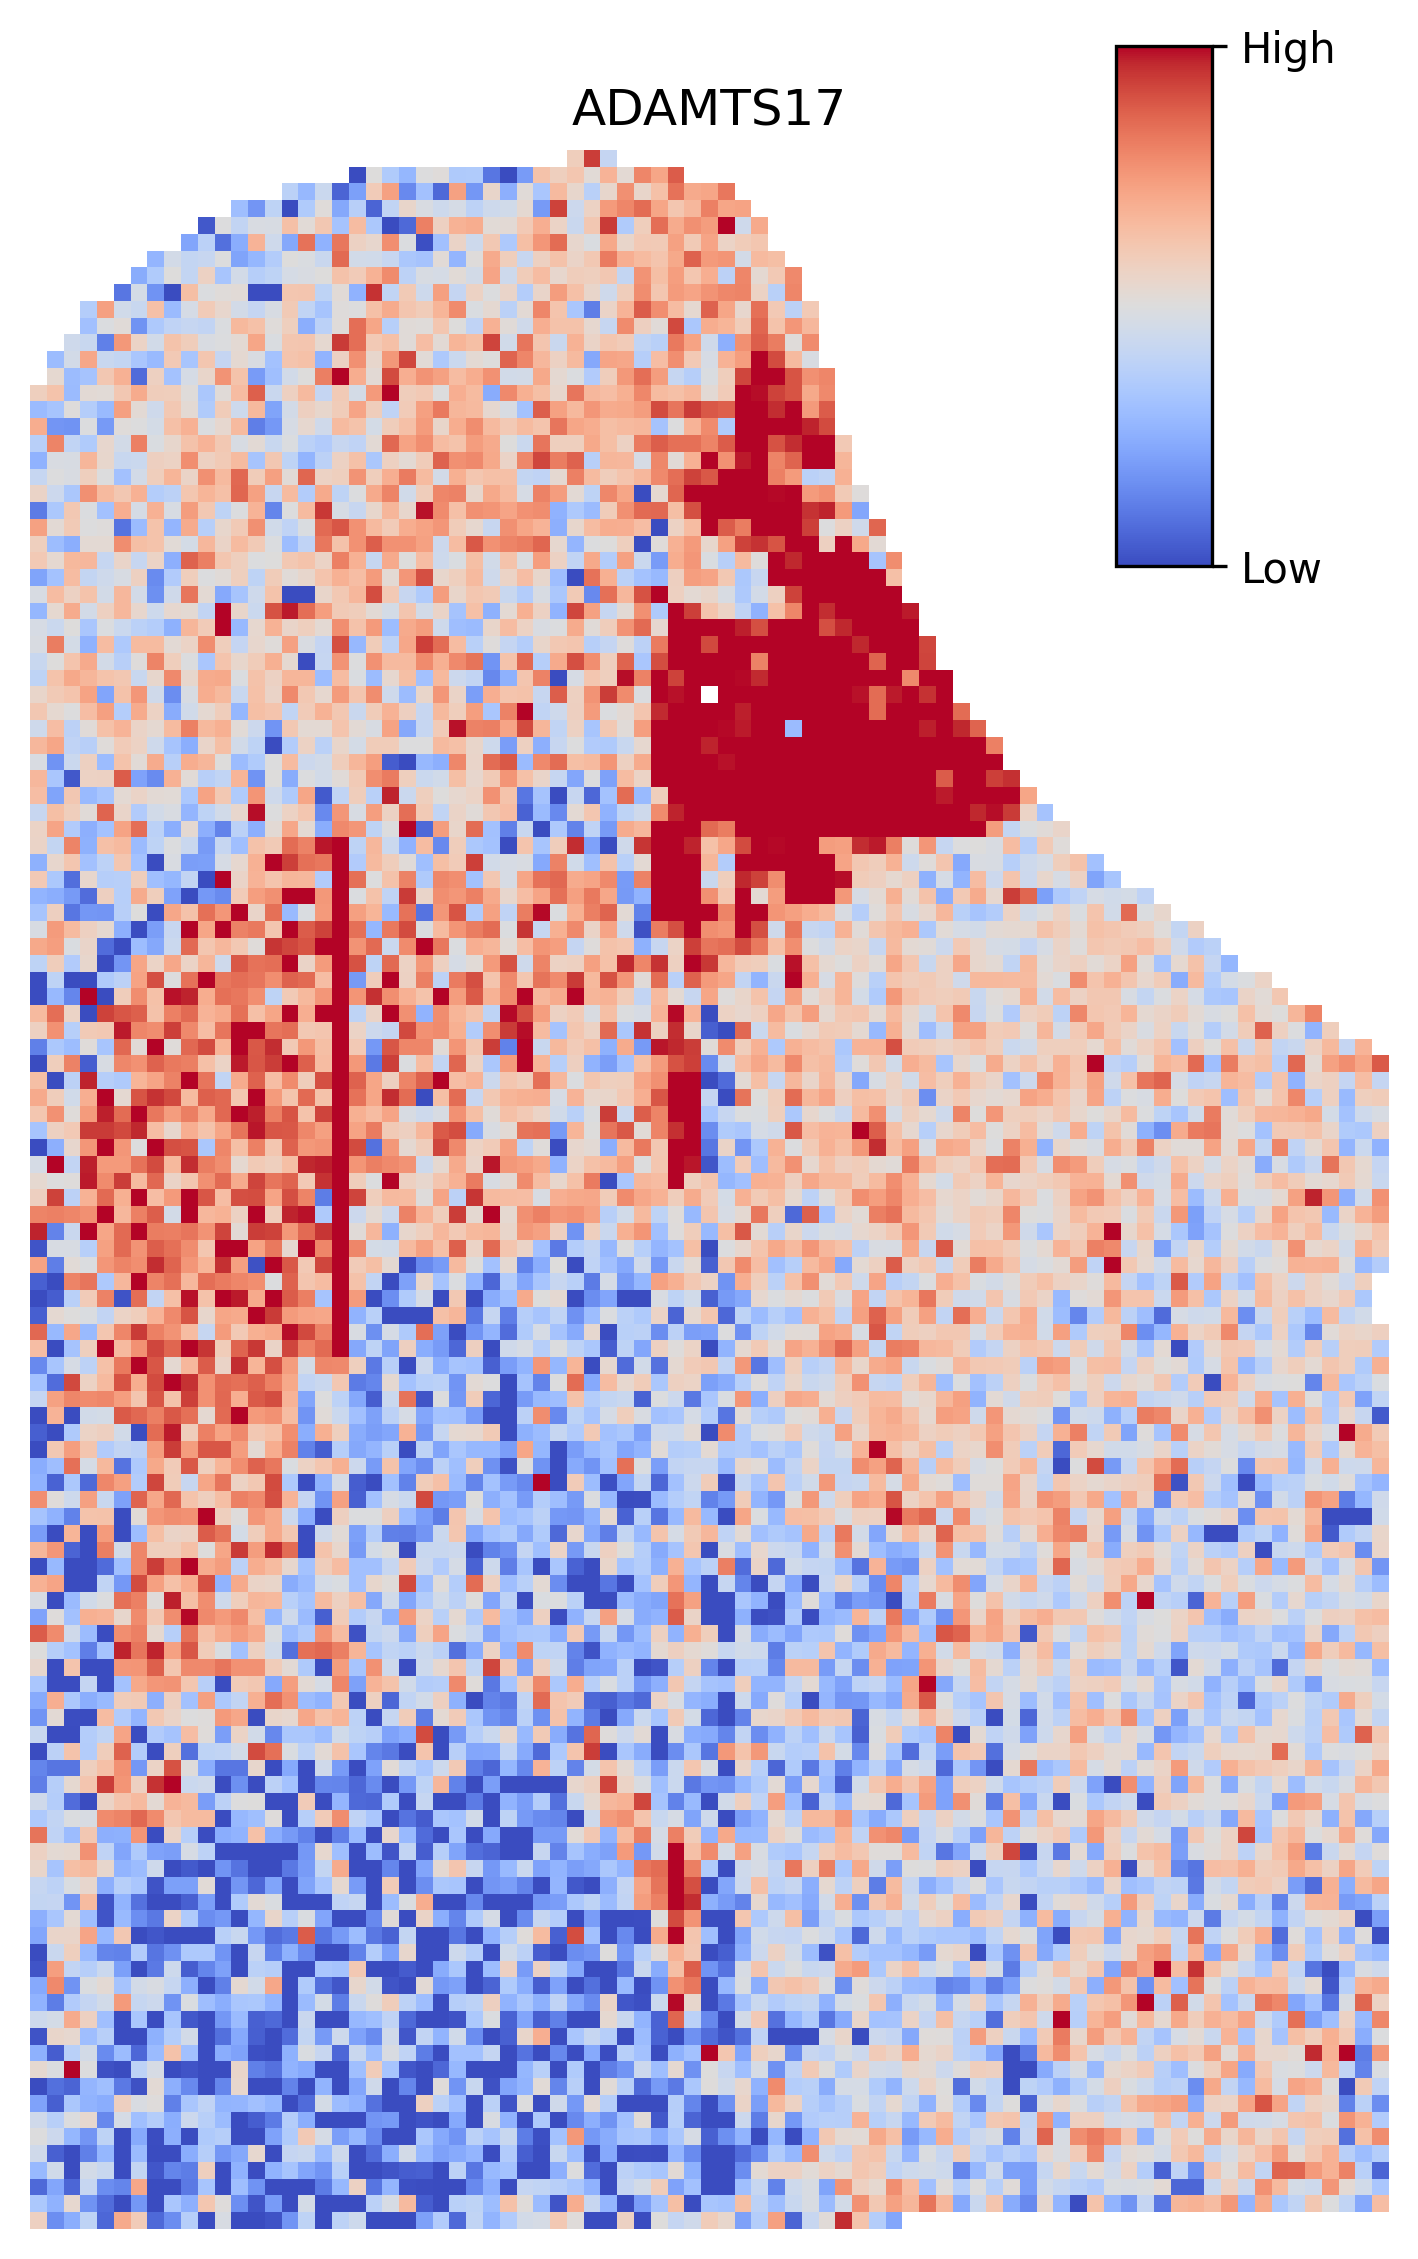

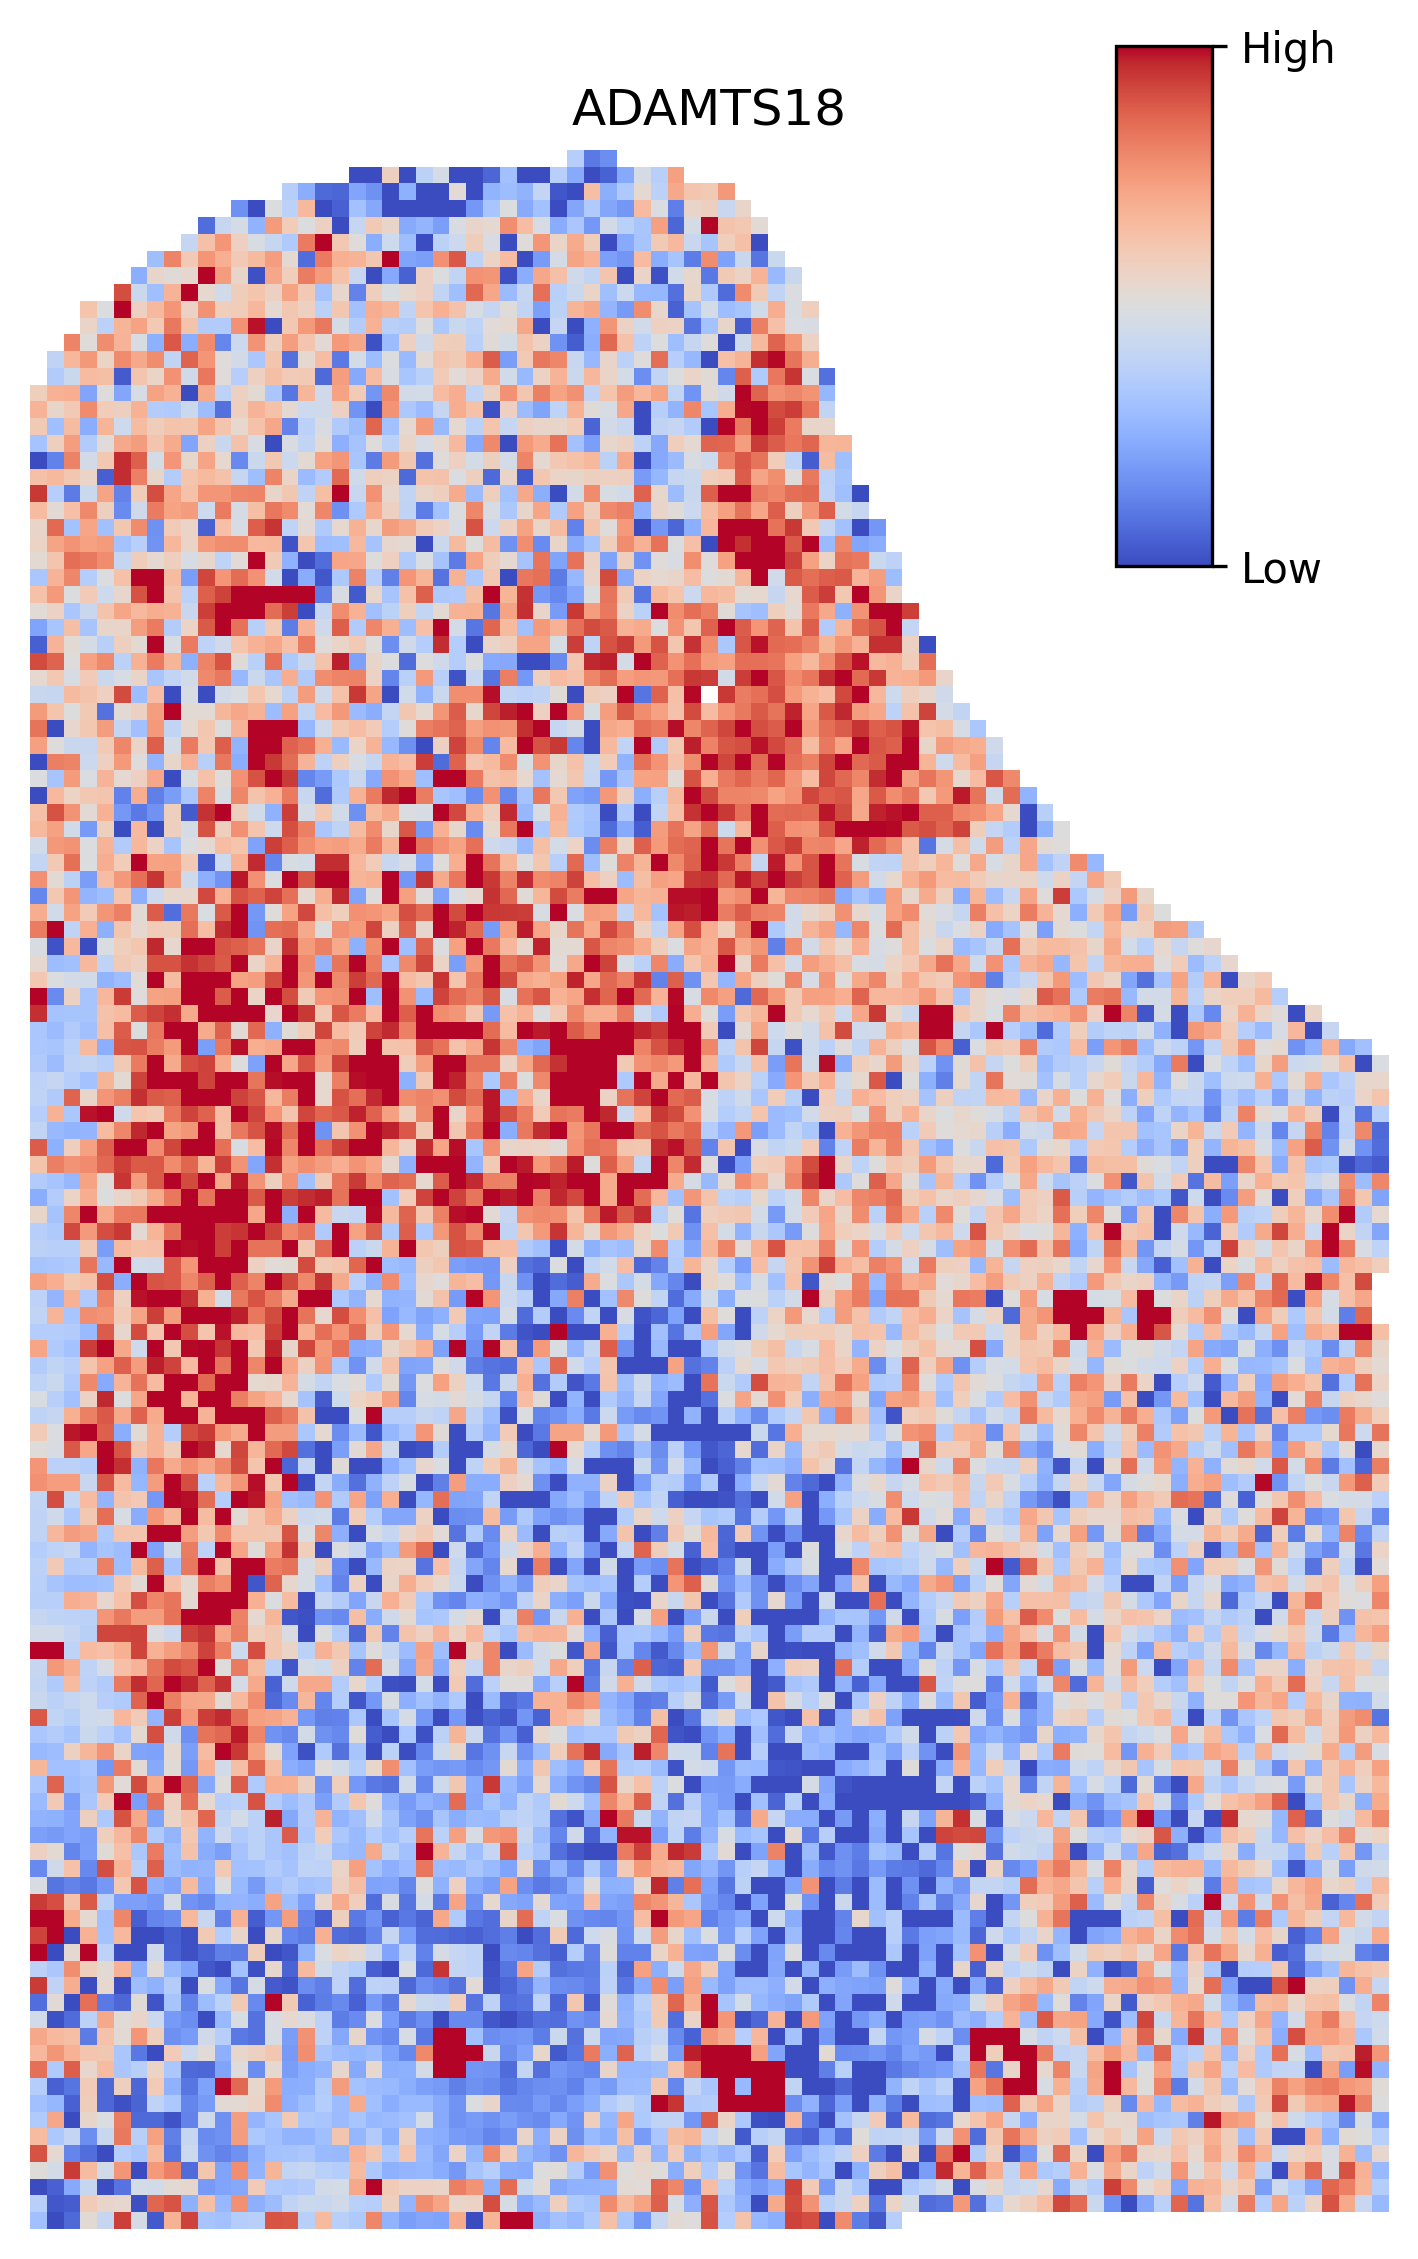

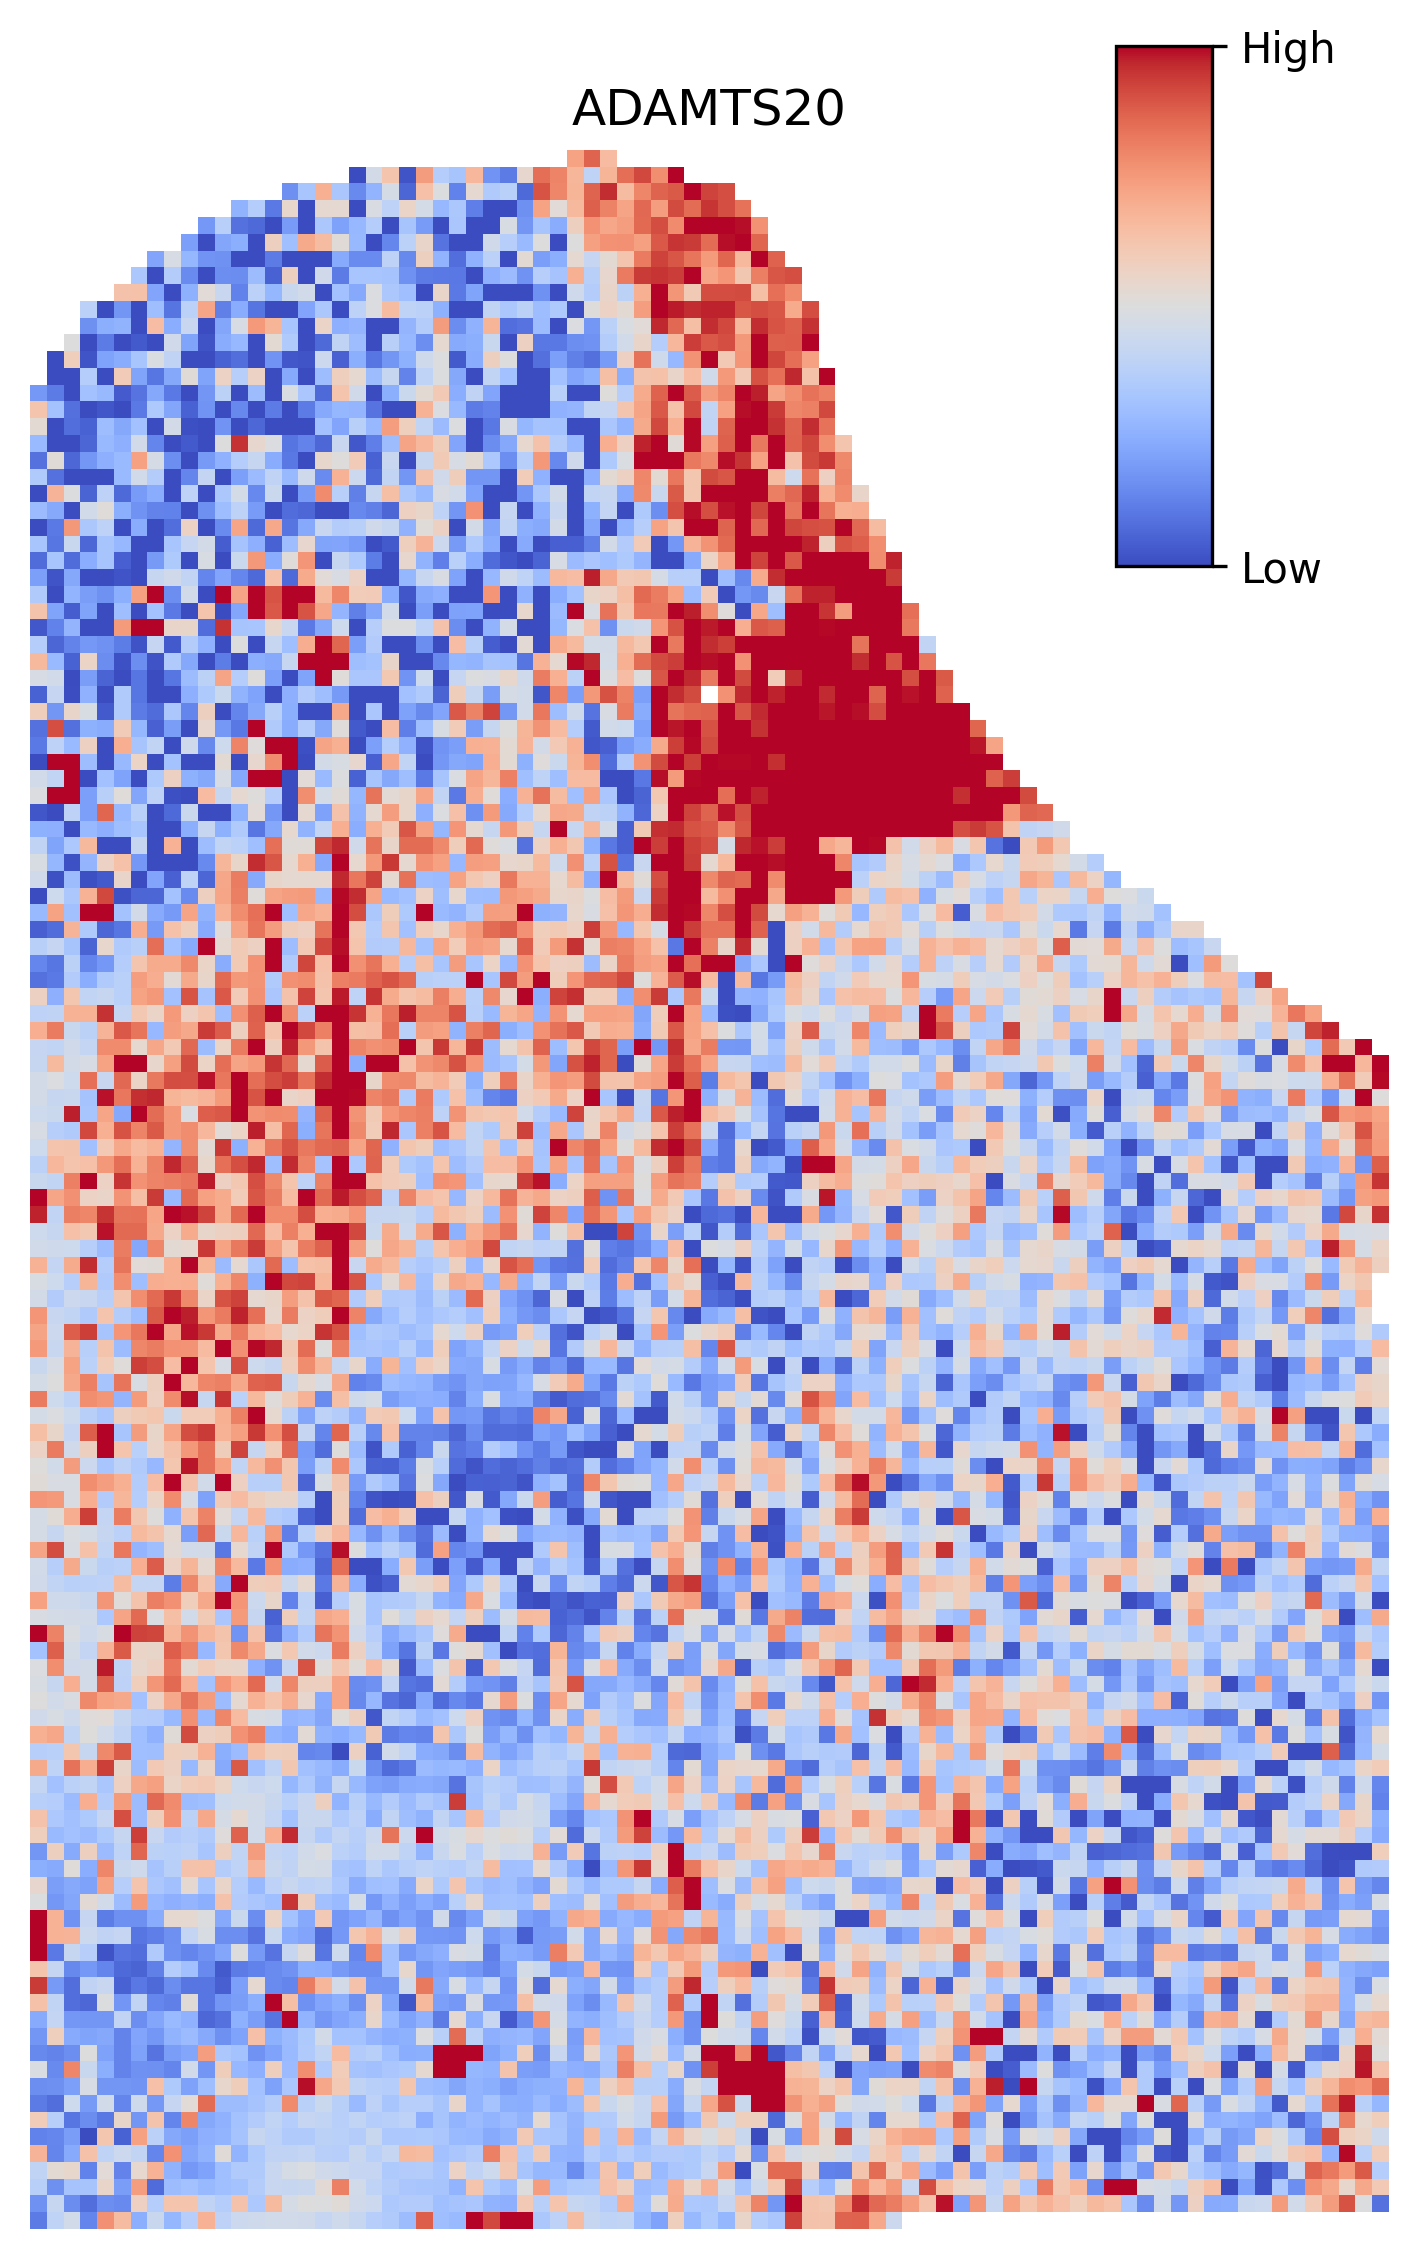

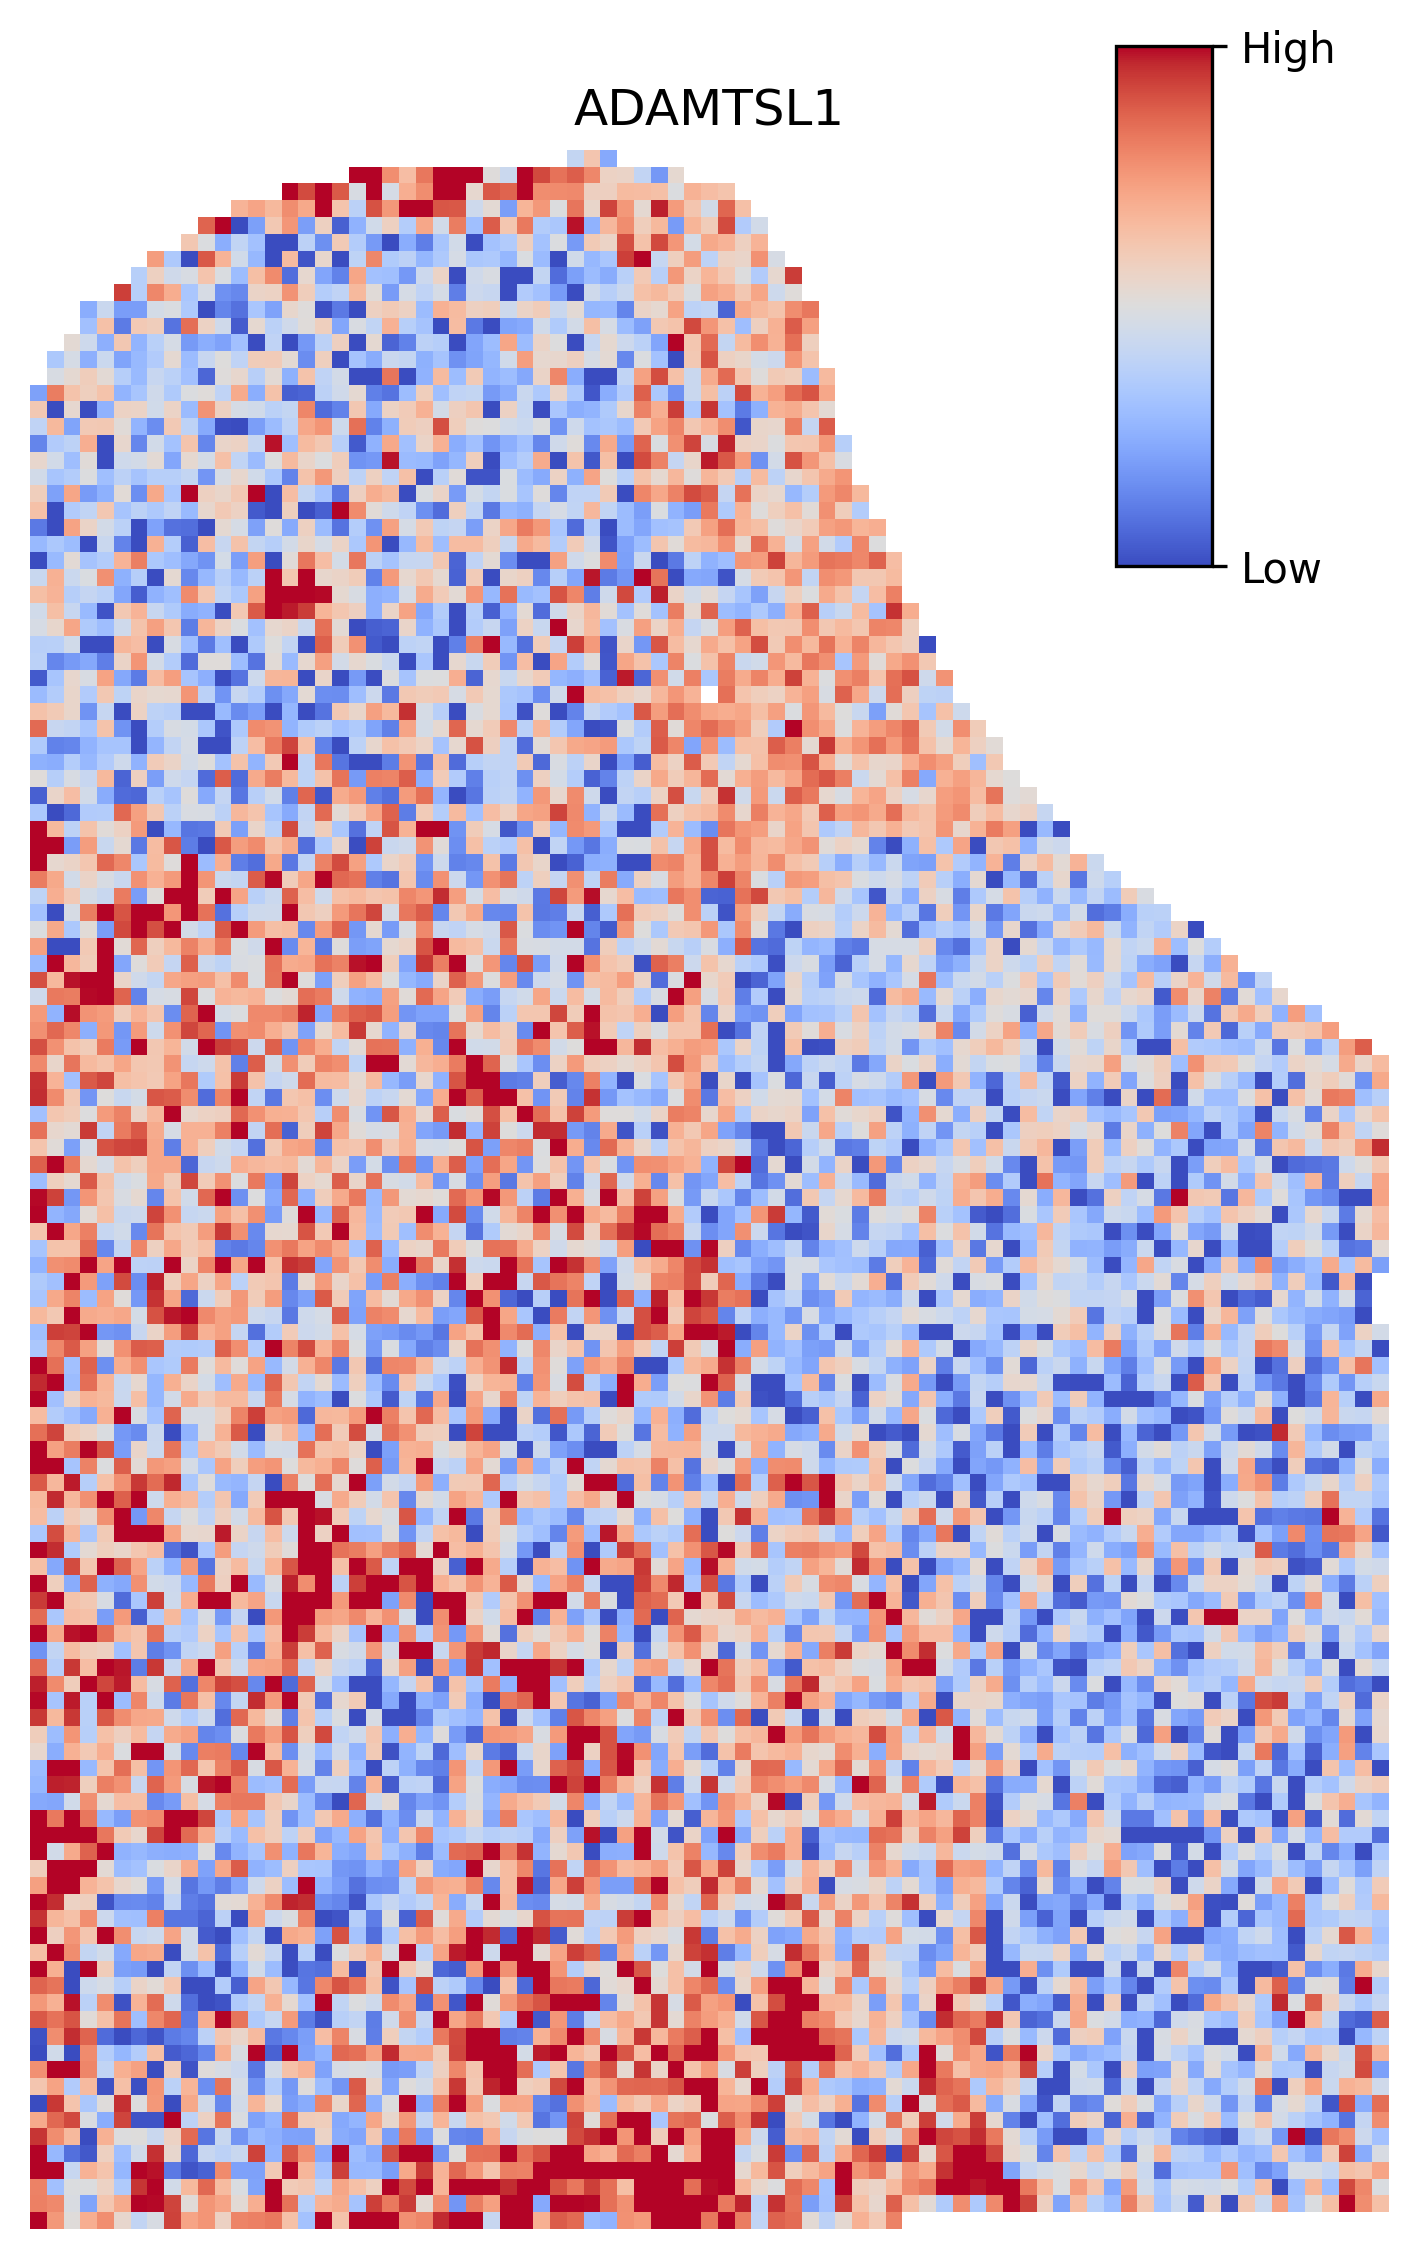

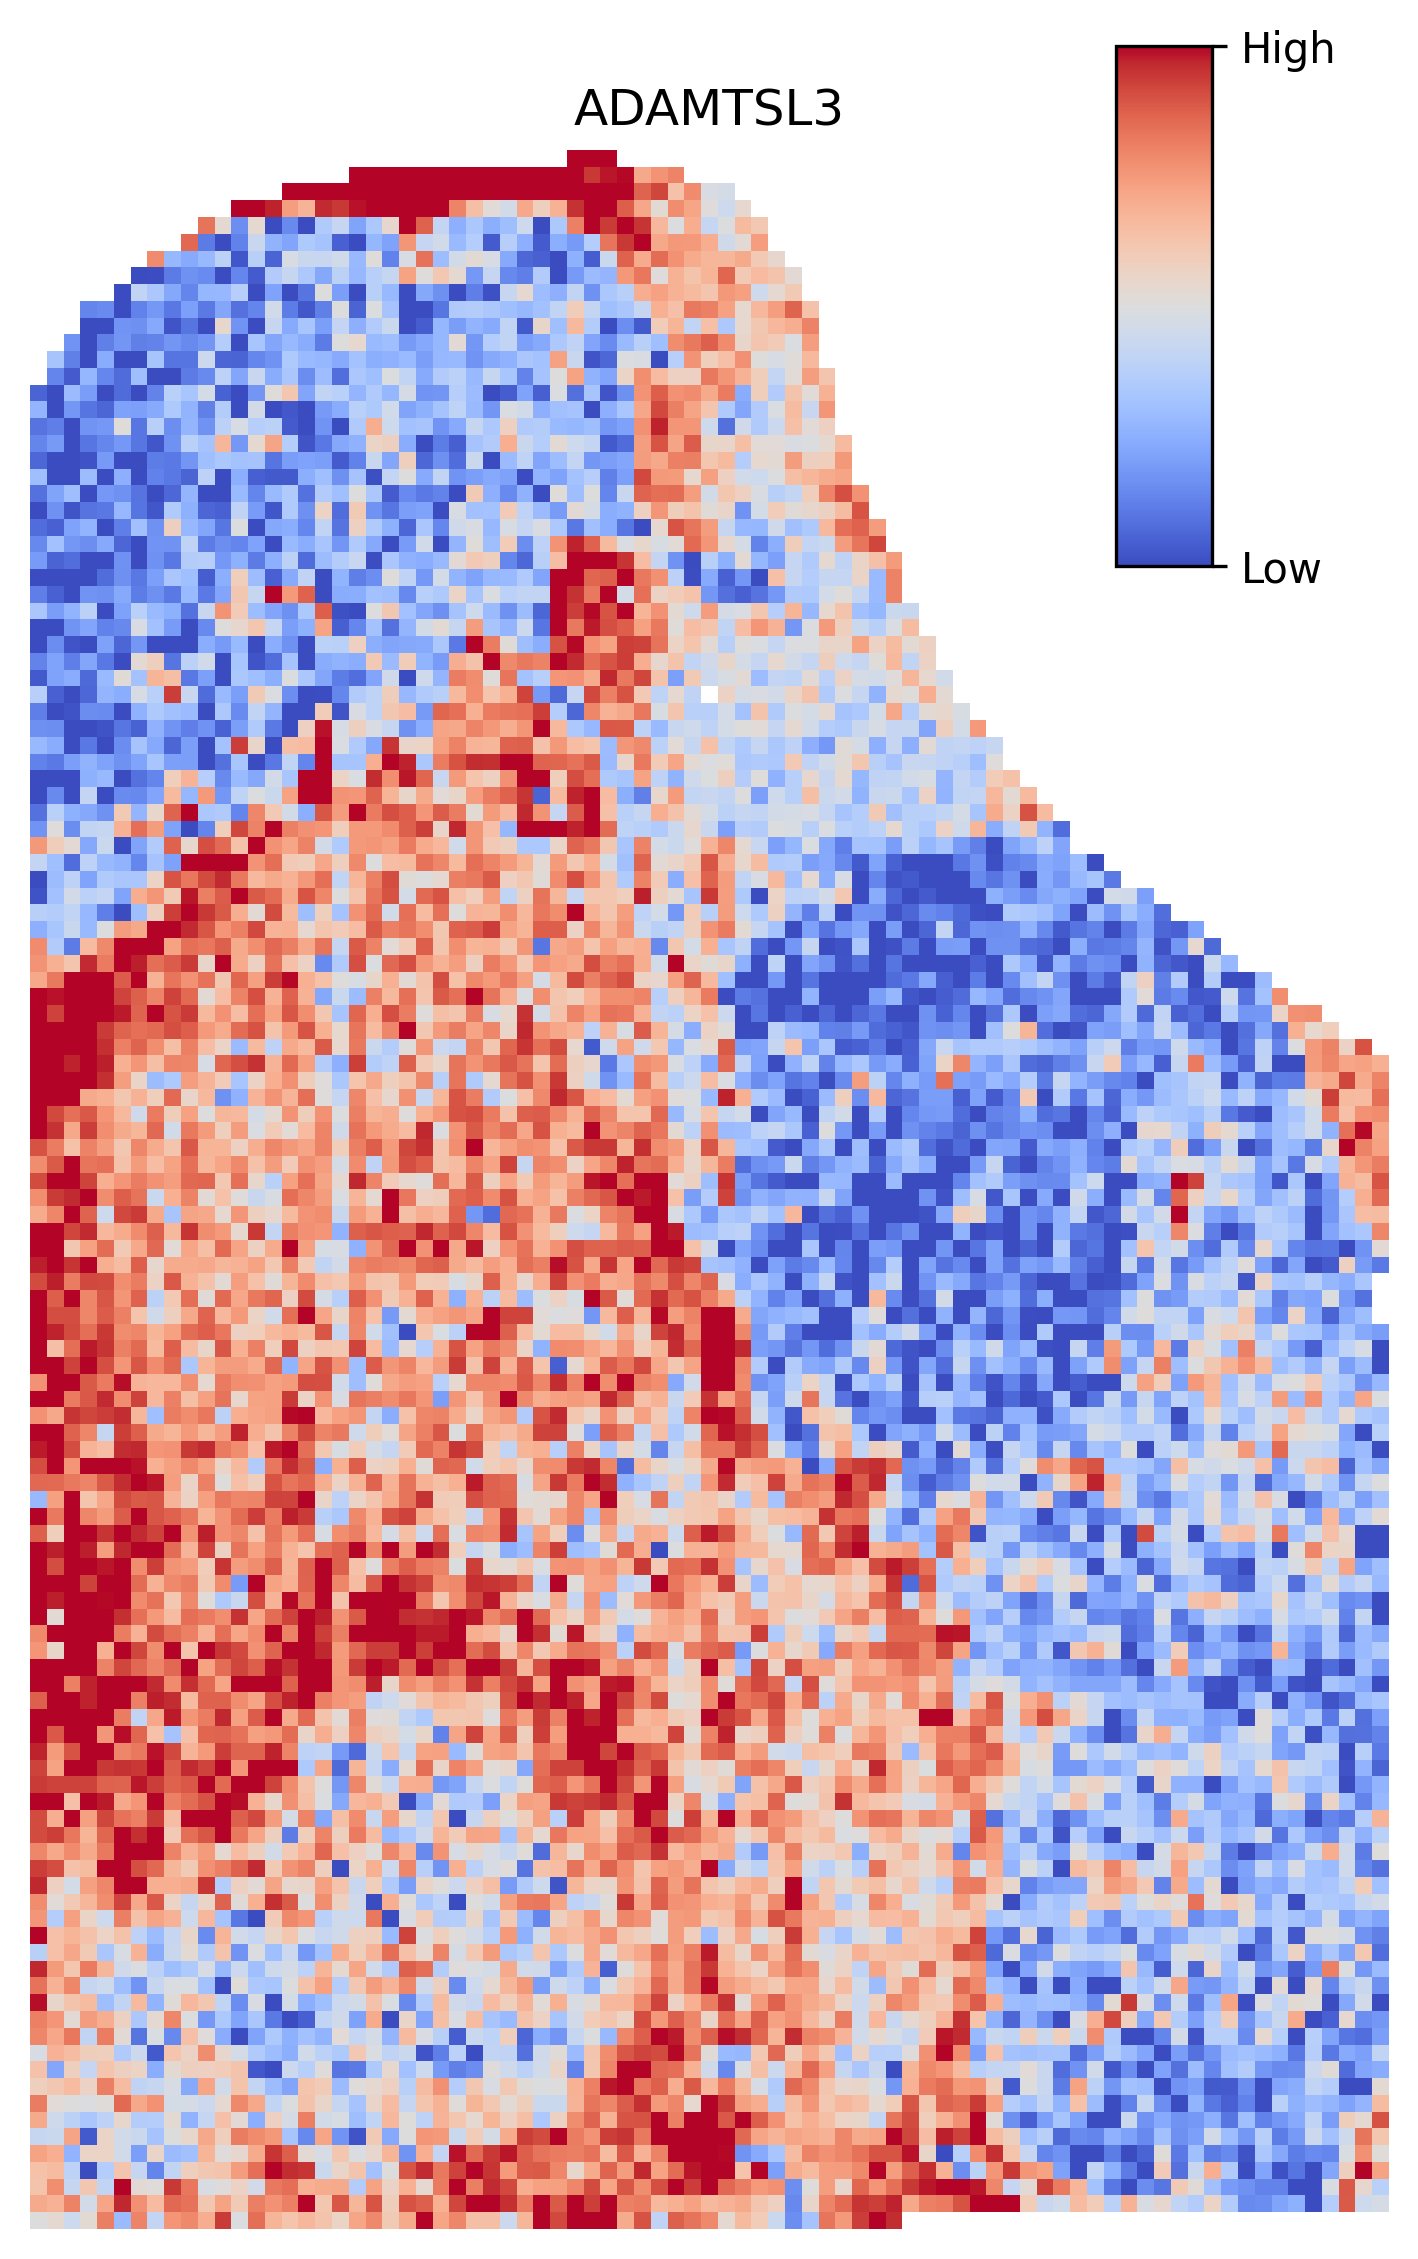

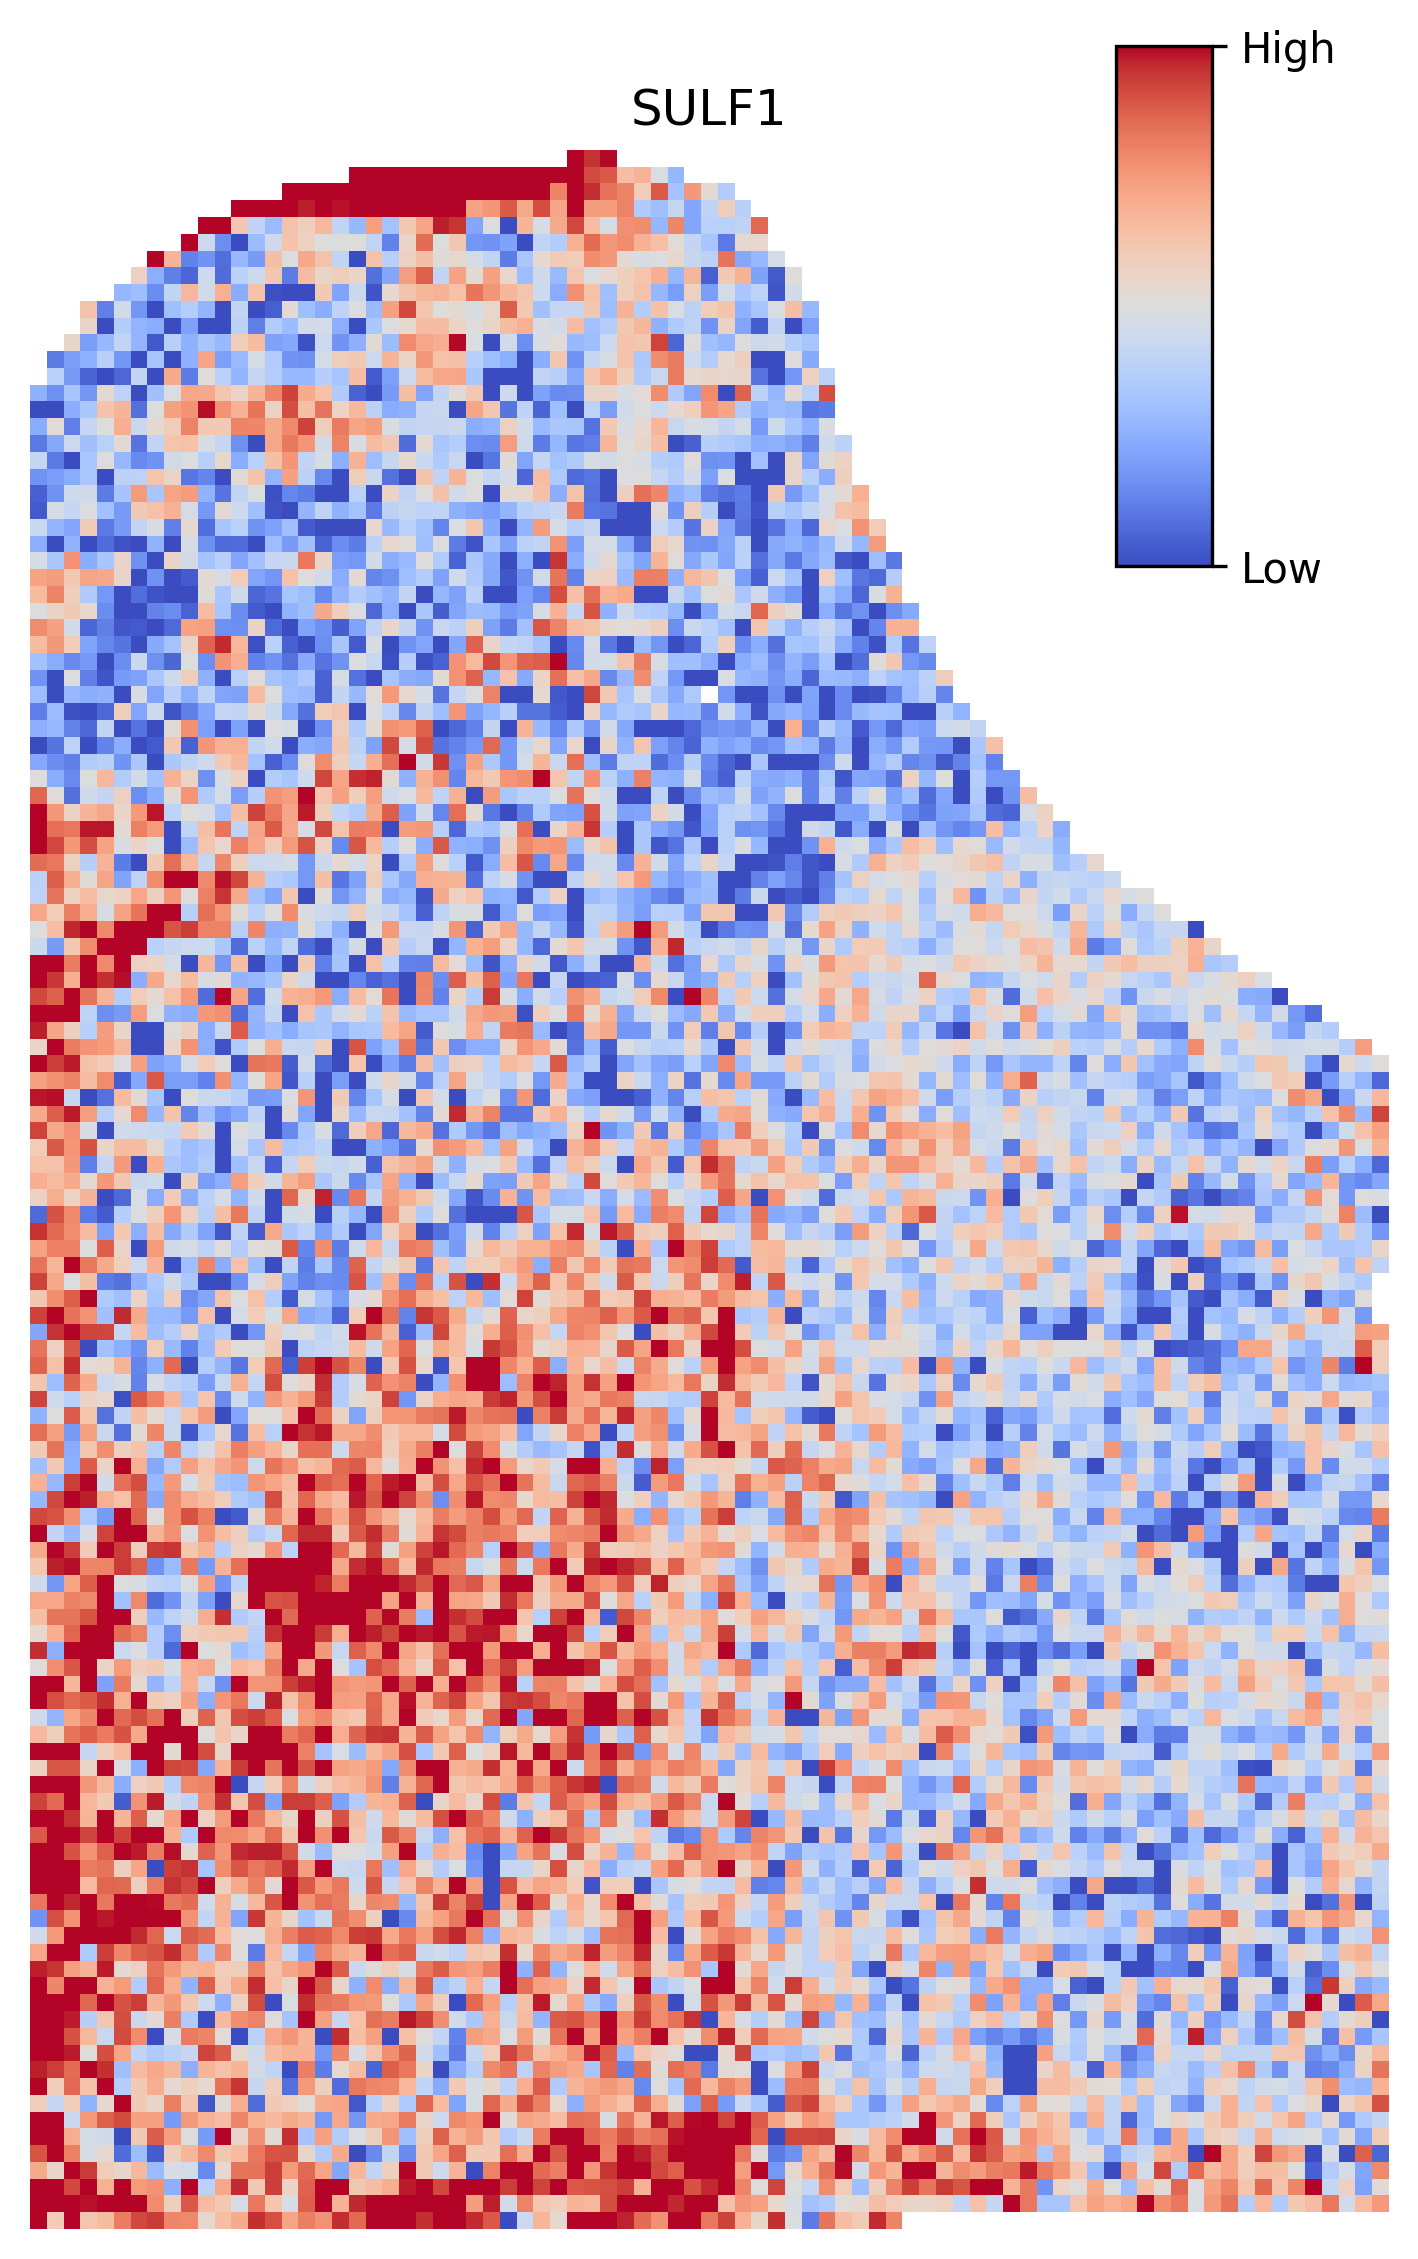

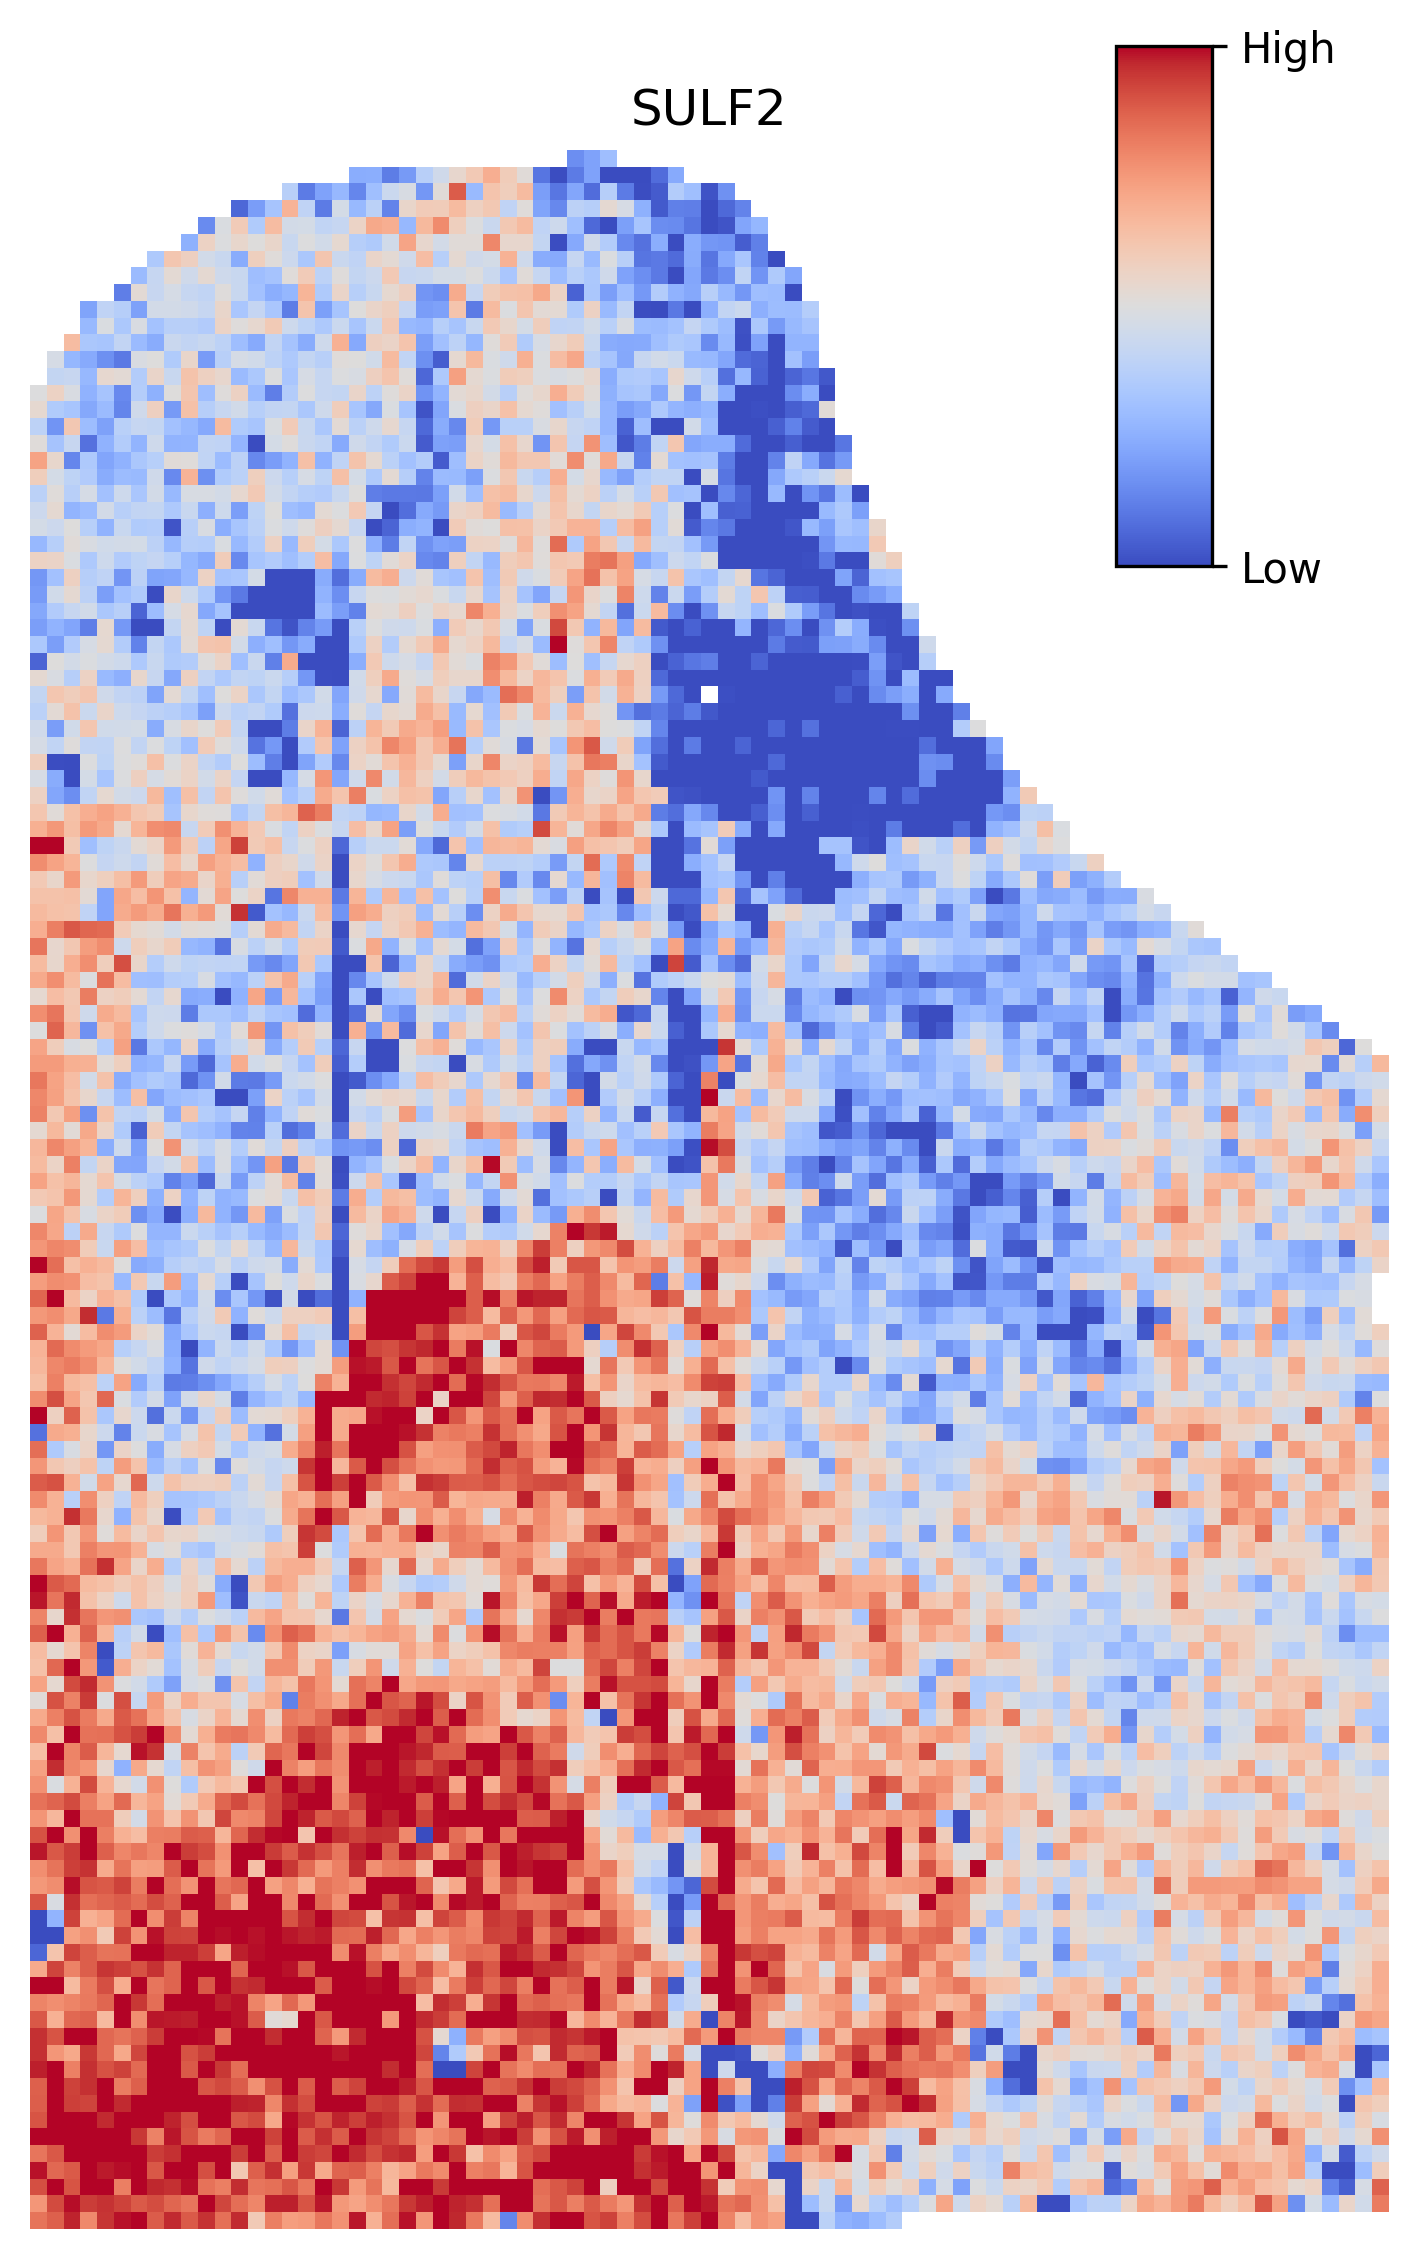

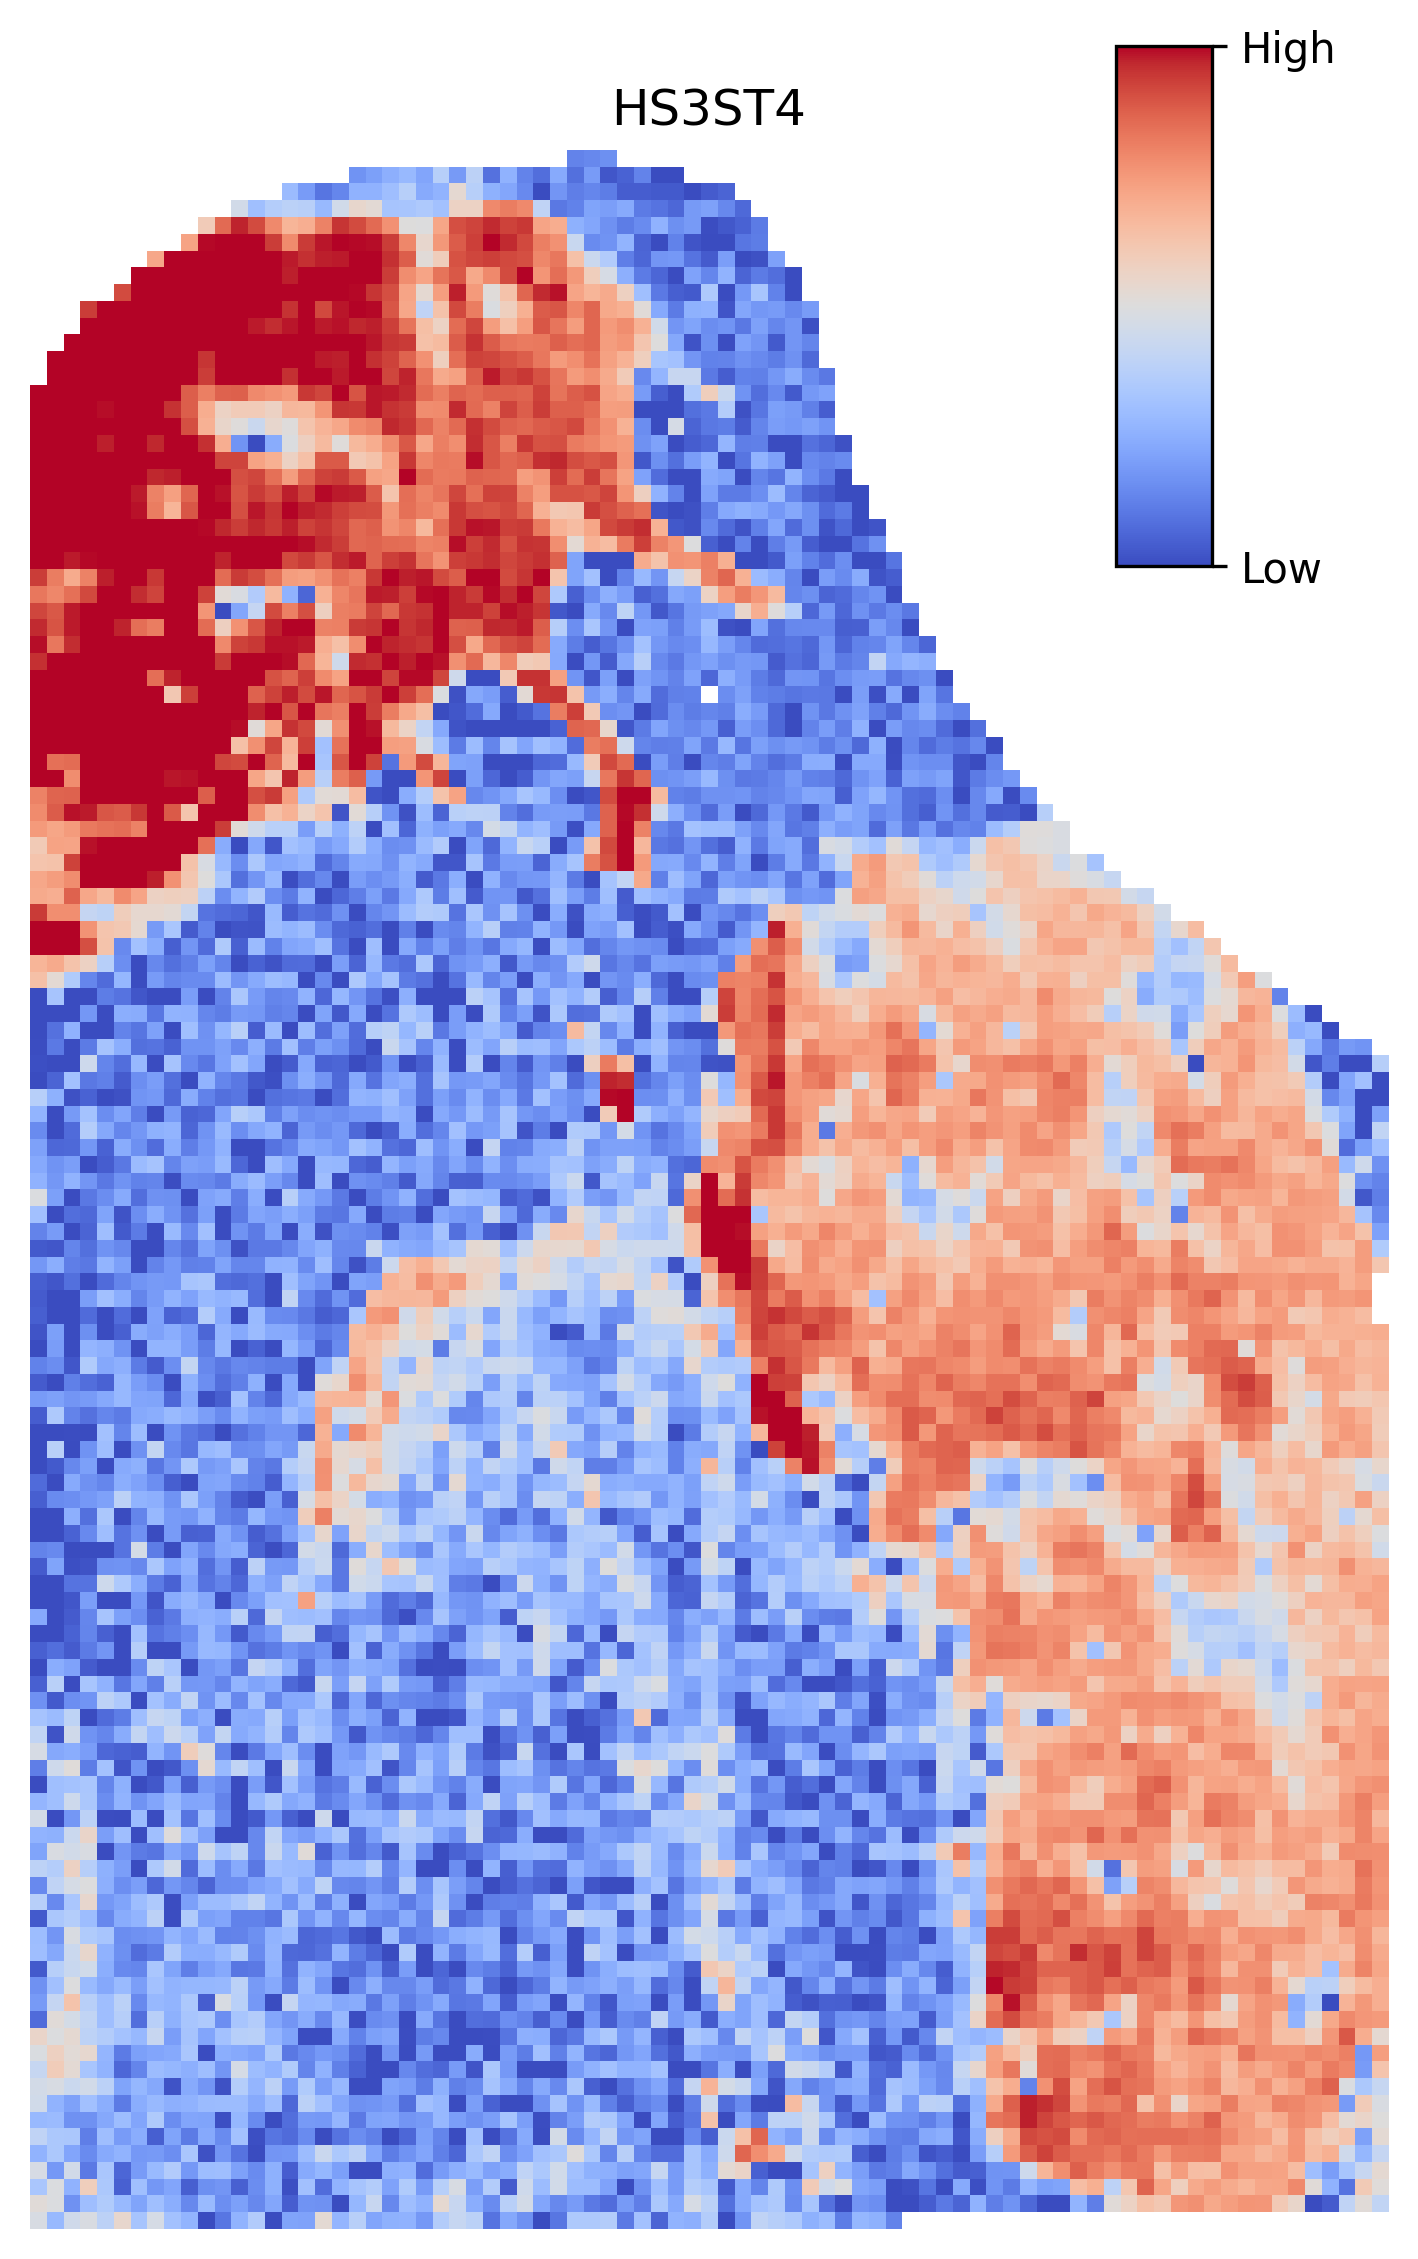

In [13]:
import matplotlib as mpl
import os
for gn in top_cellAdh_Axon_gns:
    ign = list(gns).index(gn)#PENK,RELN
    Mlog = np.log(Mcts)
    Mlog = Mlog-np.mean(Mlog,axis=-1)[:,np.newaxis]
    Mlog = Mlog-np.mean(Mlog,axis=0)[np.newaxis]

    Mloggn = Mlog[:,ign].copy()
    mgn,Mgn = np.percentile(Mloggn,5),np.percentile(Mloggn,95)
    colgn = mpl.cm.coolwarm(np.clip((Mloggn-mgn)/(Mgn-mgn),0,1))[:,:3]
    imgn = np.ones(list(np.max(XfovT,axis=0)+1)+[3])
    imgn[tuple(XfovT.T)]=colgn[:,:3]

    fig,ax = plt.subplots(1,1, dpi = 300, figsize = (6,9))
    hd = ax.imshow(imgn)
    ax.title.set_text(gn)
    # plt.colorbar(hd)
    ax.set_axis_off()
    # add a scalebar 
    # add colorbar
    bbox = ax.get_position()
    ax_cbar = fig.add_axes([bbox.xmin + 0.8*bbox.width, bbox.ymin + 0.8*bbox.height, 0.07*bbox.width, 0.25*bbox.height])


    colorNorm = np.clip((Mloggn-mgn)/(Mgn-mgn),0,1)
    cmap = mpl.cm.coolwarm
    norm = mpl.colors.Normalize(vmin=colorNorm.min(), vmax=colorNorm.max())

    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                cax=ax_cbar,)
    ax_cbar.set_yticks([0,1],['Low','High'])
    plt.savefig(r'./figures/spaital_plot_axonal_guidance_gns' + os.sep + f'spatial_Extracellular_Expression_map_{gn}.png',bbox_inches = 'tight')
    plt.savefig(r'./figures/spaital_plot_axonal_guidance_gns'+ os.sep  + f'spatial_Extracellular_Expression_map_{gn}.tif',bbox_inches = 'tight')
    plt.show()
